<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet P7 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    Partie I - Analyse Exploratoire des Données
</p>

# Importation de l'Environnement et des Données

## Importation des librairies

In [1]:
# Importation des bibliothèques nécessaires
import warnings  # Pour gérer les avertissements
import pandas as pd  # Pour la manipulation des données
import numpy as np  # Pour les opérations numériques
import scipy.stats as stats  # Pour les statistiques
from datetime import datetime  # Pour la manipulation des dates

# Visualisation
import seaborn as sns  # Pour la visualisation des données
import xplotter  # (Note: Veuillez vérifier si xplotter est correctement installé)
import matplotlib.pyplot as plt  # Pour les graphiques
%matplotlib inline  # Activation de l'affichage des graphiques dans le notebook
plt.rcParams["figure.figsize"] = 6, 4  # Taille par défaut des graphiques

sns.set_style("ticks") # Style des graphiques seaborn
sns.color_palette("pink", as_cmap=True) # Palette de couleurs (à adapter selon les besoins)

# Format d'affichage des nombres flottants
pd.set_option('display.float_format', '{:,.2f}'.format)

# Désactivation de l'affichage des avertissements
warnings.filterwarnings('ignore')

# Affichage des versions des bibliothèques utilisées
print("pandas version :", pd.__version__)
print("numpy version :", np.__version__)
print("seaborn version :", sns.__version__)

pandas version : 2.0.3
numpy version : 1.24.3
seaborn version : 0.12.2


## Importation des données

Les données sont dispatchées dans 8 fichiers liés entre eux selon le schéma suivant :

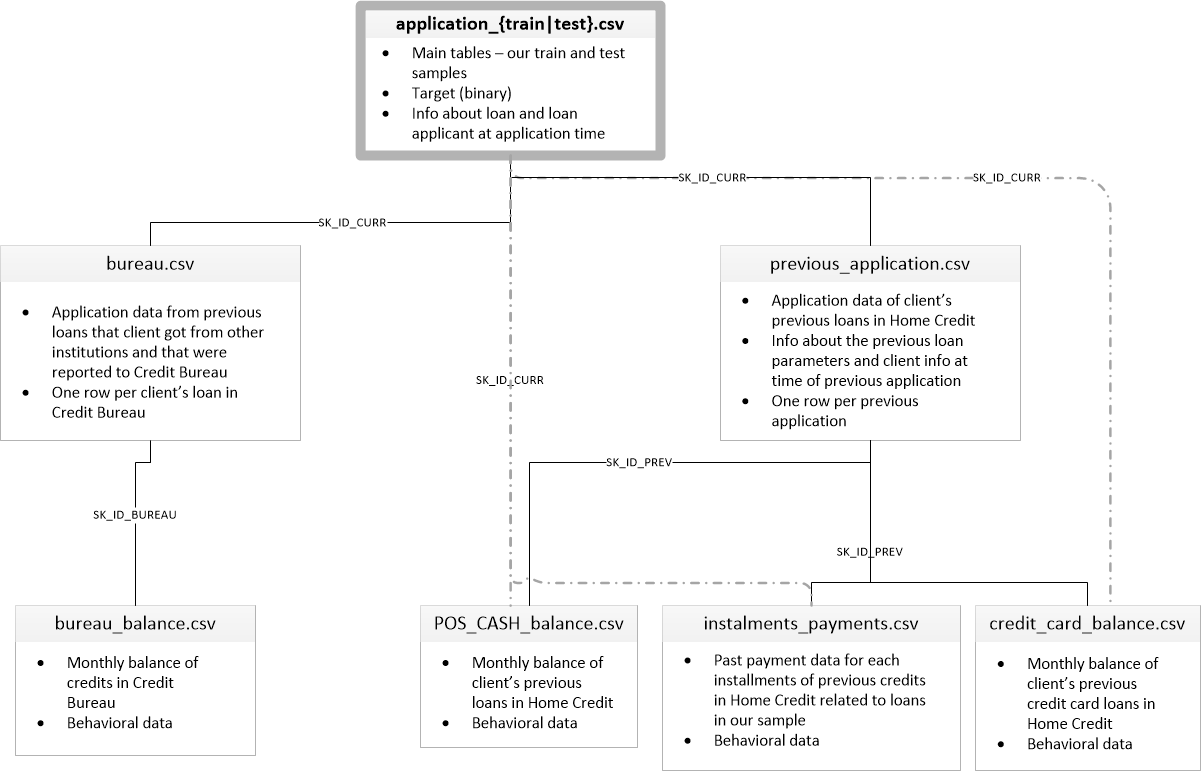

### Description des fichiers

In [3]:
# Lecture des fichiers et réduction de la mémoire utilisée

X_train = pd.read_csv('./Data/application_train.csv')
X_test = pd.read_csv('./Data/application_test.csv')
bureau = pd.read_csv('./Data/bureau.csv')
bureau_balance = pd.read_csv('./Data/bureau_balance.csv')
pos_cash = pd.read_csv('./Data/POS_CASH_balance.csv')
credit_card = pd.read_csv('./Data/credit_card_balance.csv')
previous_application = pd.read_csv('./Data/previous_application.csv')
installments_payments = pd.read_csv('./Data/installments_payments.csv')
# Spécifiez le codec approprié (par exemple, 'latin-1')
columns_description = pd.read_csv('./Data/HomeCredit_columns_description.csv', sep=';', encoding='latin-1')

In [4]:
datasets = [X_train, X_test, bureau, bureau_balance, pos_cash, credit_card, 
            previous_application, installments_payments, columns_description]

titles = ["X_train", "X_test", "bureau", "bureau_balance", "pos_cash", "credit_card", 
          "previous_application", "installments_payments", "columns_description"]

info_df = pd.DataFrame({},)
info_df['dataset'] = titles

info_df['no_of_columns'] = [len(df.columns) for df in datasets]
info_df['columns_name'] = [', '.join(list(df.columns)) for df in datasets]
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='rocket')

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = pd.DataFrame({},)
new_df['dataset'] = titles
new_df['numeric_features'] = [
    len((df.select_dtypes(include=numerics)).columns) for df in datasets]

new_df['num_features_name'] = [', '.join(
    list((df.select_dtypes(include=numerics)).columns)) for df in datasets]

new_df['object_features'] = [
    len((df.select_dtypes(include='object')).columns) for df in datasets]

new_df['objt_features_name'] = [', '.join(
    list((df.select_dtypes(include='object')).columns)) for df in datasets]

new_df.style.background_gradient(cmap='rocket')

### Description des Variables

In [7]:
# Assurez-vous que le DataFrame columns_description est correctement chargé avant de manipuler les colonnes
# columns_description = pd.read_csv('./Data/HomeCredit_columns_description.csv', sep=';', encoding='latin-1')

# Vérifiez les noms des colonnes dans le DataFrame
print(columns_description.columns)
# Supprimez la colonne 'num_columns' si elle existe
if 'num_columns' in columns_description.columns:
    columns_description.drop(columns='num_columns', axis=1, inplace=True)
else:
    print("La colonne 'num_columns' n'existe pas dans le DataFrame.")

# Affichez le DataFrame après la suppression
print(columns_description)

Index([',Table,Row,Description,Special'], dtype='object')
La colonne 'num_columns' n'existe pas dans le DataFrame.
                                                                                                                                                                                                                                                                                                                                     ,Table,Row,Description,Special
0                                                                                                                                                                                                                                                                                               1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,
1                                                                                                                              2,application_{train|test}.csv,TARGET,"Target 

# La Cible à prédire : *Le client est-il en difficulté de paiement ?*

In [8]:
print(
    f"Nombre d'identifiants de prêts uniques dupliqués : {X_train.duplicated(subset=['SK_ID_CURR']).sum()}")

Nombre d'identifiants de prêts uniques dupliqués : 0


Il y a bien une ligne par crédit, soit un échantillon d'entraînement de 307 511 crédits (86,3%) et un échantillon test de 48 744 crédits (13,7% d'un nombre total de crédits = 356 255).

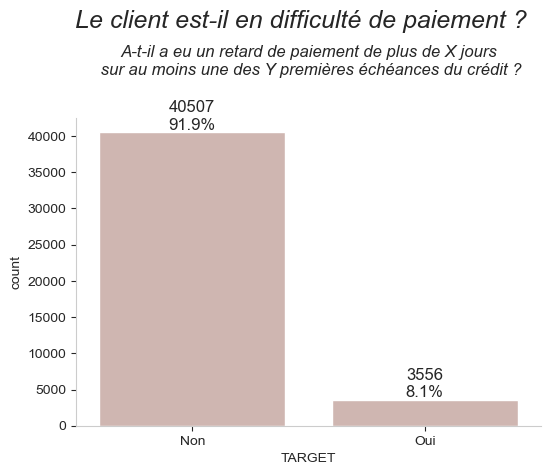

In [9]:
from xplotter.insights import *

colors = ['#d4b3ac']

loan_map = {1 : "Oui",
            0 : "Non"}

fig, ax = plt.subplots(figsize=(6, 4))

plot_countplot(df=X_train, 
               col='TARGET', 
               label_names=loan_map,
               order=True,
               palette=colors, ax=ax, orient='v', size_labels=12)

plt.suptitle("Le client est-il en difficulté de paiement ?\n",
             y=1.15, fontsize=18, fontstyle='italic')
plt.title("A-t-il a eu un retard de paiement de plus de X jours\n sur au moins une des Y premières échéances du crédit ?\n\n",
           loc="center", fontsize=12, fontstyle='italic')
plt.show()

# Data Cleaning des ensembles d'entraînement et de test

## Gestion des Valeurs Manquantes

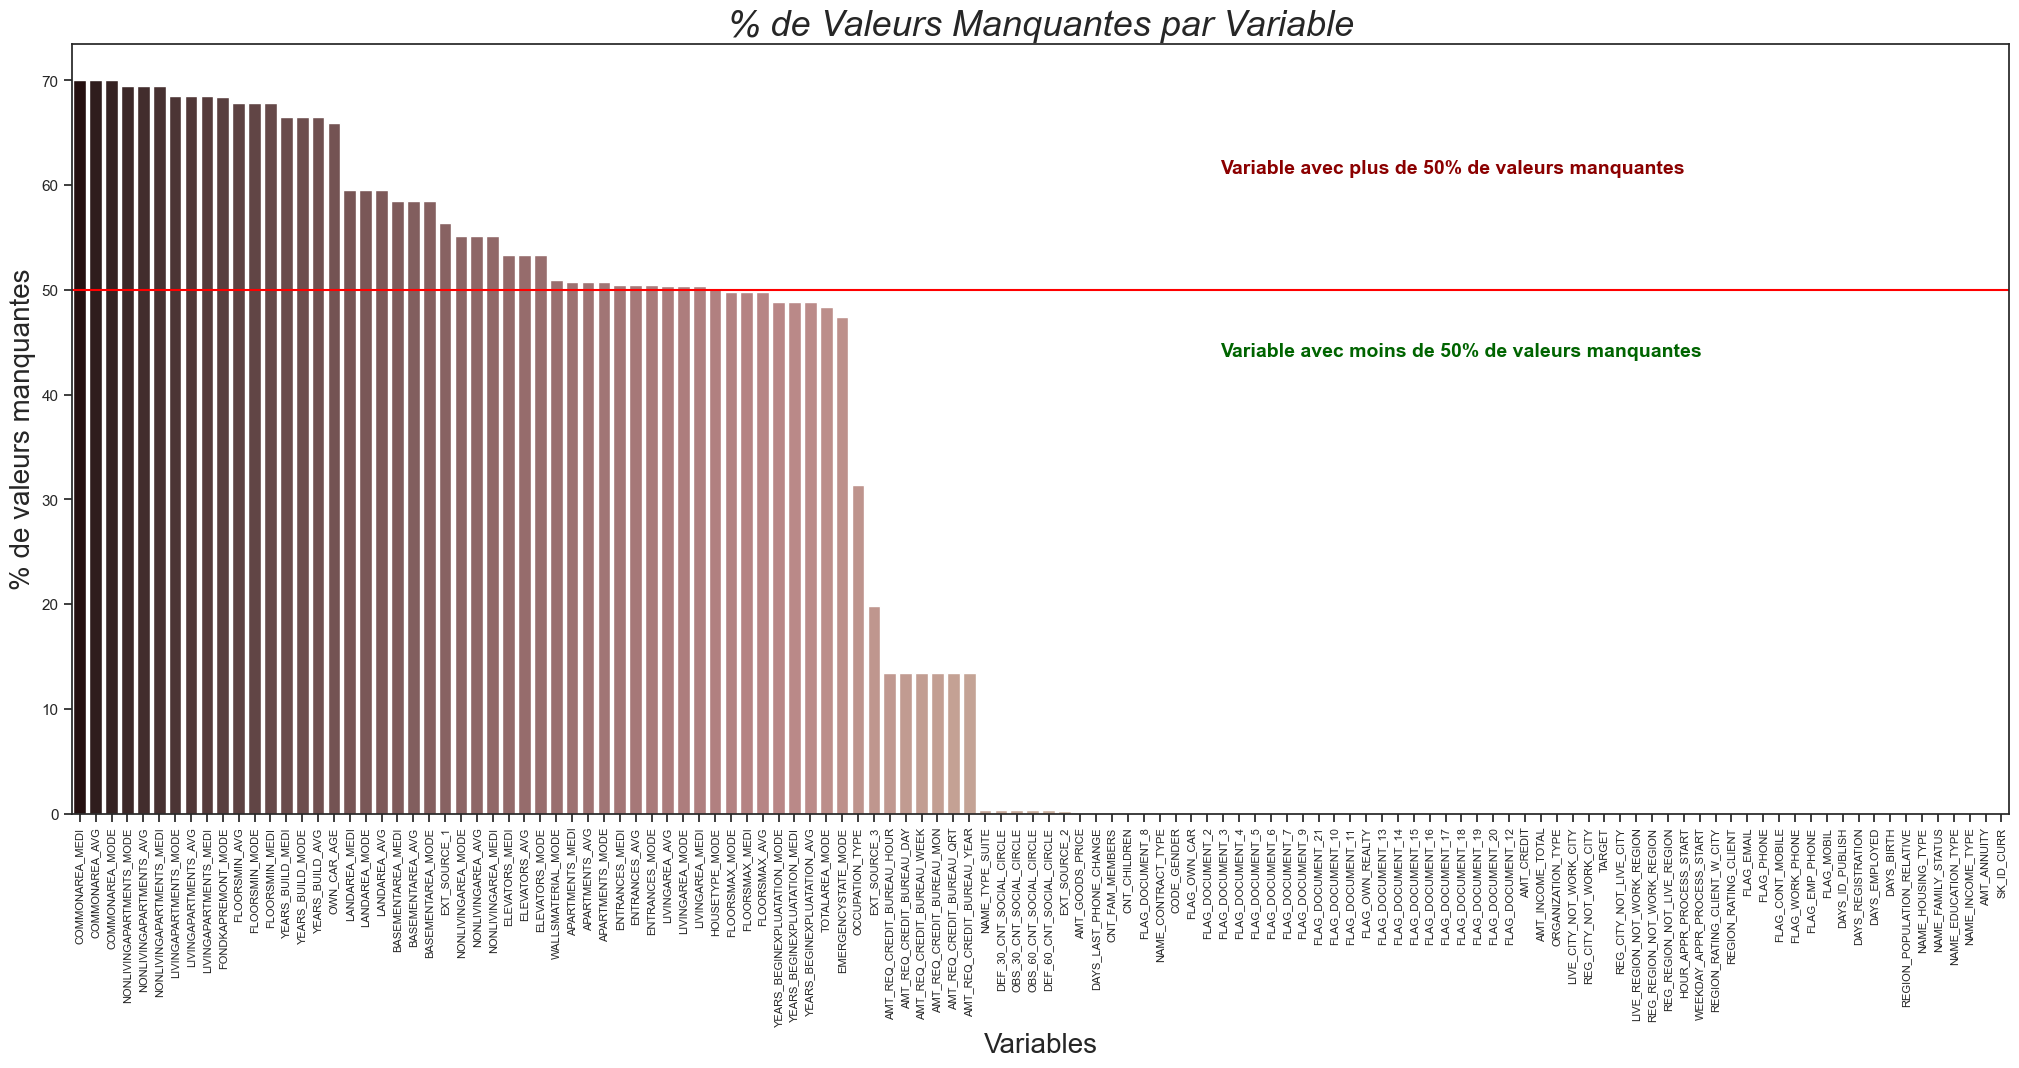

In [10]:
sns.set(style="ticks", rc = {'figure.figsize':(25,10)}, palette= "pink")
thresh_na = 50

ax = plt.subplot(1,1,1)
perc = (X_train.isnull().sum()/X_train.shape[0])*100
perc = perc.sort_values(ascending=False)

ax = sns.barplot(x = X_train.columns, y = perc, palette = "pink")

plt.axhline(y = thresh_na, color = 'r', linestyle = '-')

plt.text(len(X_train.isnull().sum()/len(X_train))/1.7, 
         thresh_na+12.5, 'Variable avec plus de %s%s de valeurs manquantes' %(thresh_na, '%'), 
         fontsize = 14, weight = 'bold', color = 'darkred', ha = 'left' , va = 'top')

plt.text(len(X_train.isnull().sum()/len(X_train))/1.7, 
         thresh_na - 5, 'Variable avec moins de %s%s de valeurs manquantes' %(thresh_na, '%'), 
         fontsize = 14, weight = 'bold', color = 'darkgreen', ha = 'left' , va = 'top')

ax.set_title('% de Valeurs Manquantes par Variable', loc="center", fontsize = 26, fontstyle='italic')
ax.set_xlabel('Variables', fontsize = 20)
ax.set_ylabel('% de valeurs manquantes', fontsize = 20)
ax.set_xticklabels(perc.index, rotation = 90, fontsize = 8)

plt.show()

In [11]:
# Find the variables with missing observations.

vars_with_na_1 = [var for var in X_train.columns if X_train[var].isnull().mean() > 0.5]
print(vars_with_na_1)

['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


In [12]:
# Let's find out whether they are numerical or categorical.

X_train[vars_with_na_1].dtypes

OWN_CAR_AGE                 float64
EXT_SOURCE_1                float64
APARTMENTS_AVG              float64
BASEMENTAREA_AVG            float64
YEARS_BUILD_AVG             float64
COMMONAREA_AVG              float64
ELEVATORS_AVG               float64
ENTRANCES_AVG               float64
FLOORSMIN_AVG               float64
LANDAREA_AVG                float64
LIVINGAPARTMENTS_AVG        float64
LIVINGAREA_AVG              float64
NONLIVINGAPARTMENTS_AVG     float64
NONLIVINGAREA_AVG           float64
APARTMENTS_MODE             float64
BASEMENTAREA_MODE           float64
YEARS_BUILD_MODE            float64
COMMONAREA_MODE             float64
ELEVATORS_MODE              float64
ENTRANCES_MODE              float64
FLOORSMIN_MODE              float64
LANDAREA_MODE               float64
LIVINGAPARTMENTS_MODE       float64
LIVINGAREA_MODE             float64
NONLIVINGAPARTMENTS_MODE    float64
NONLIVINGAREA_MODE          float64
APARTMENTS_MEDI             float64
BASEMENTAREA_MEDI           

La majorité des variables avec plus de 60% de valeurs manquantes sont des informations normalisées sur le bâtiment où vit le client, quelle est la taille moyenne (suffixe _AVG), le modus (suffixe _MODE), la taille médiane (suffixe _MEDI), la zone commune, la surface habitable, l'âge du bâtiment, le nombre d'ascenseurs, le nombre d'entrées, l'état du bâtiment, et le nombre d'étages.

In [13]:
X_train['FONDKAPREMONT_MODE'].value_counts(normalize=True, dropna=False)*100

FONDKAPREMONT_MODE
NaN                     68.45
reg oper account        23.96
reg oper spec account    3.93
not specified            1.84
org spec account         1.81
Name: proportion, dtype: float64

In [14]:
X_train['HOUSETYPE_MODE'].value_counts(normalize=True, dropna=False)*100

HOUSETYPE_MODE
NaN                50.20
block of flats     48.82
specific housing    0.52
terraced house      0.46
Name: proportion, dtype: float64

In [15]:
X_train['WALLSMATERIAL_MODE'].value_counts(normalize=True, dropna=False)*100

WALLSMATERIAL_MODE
NaN            50.99
Panel          21.30
Stone, brick   21.12
Block           2.98
Wooden          1.74
Mixed           0.69
Monolithic      0.61
Others          0.57
Name: proportion, dtype: float64

In [16]:
X_train[vars_with_na_1].describe(include=[np.number]).T

count  mean   std  min  25%  50%   75%   max
OWN_CAR_AGE              15,016.00 12.00 11.79 0.00 5.00 9.00 15.00 65.00
EXT_SOURCE_1             19,232.00  0.50  0.21 0.01 0.33 0.51  0.67  0.94
APARTMENTS_AVG           21,683.00  0.12  0.11 0.00 0.06 0.09  0.15  1.00
BASEMENTAREA_AVG         18,309.00  0.09  0.08 0.00 0.04 0.08  0.11  1.00
YEARS_BUILD_AVG          14,740.00  0.75  0.11 0.00 0.69 0.76  0.82  1.00
COMMONAREA_AVG           13,215.00  0.04  0.08 0.00 0.01 0.02  0.05  1.00
ELEVATORS_AVG            20,555.00  0.08  0.13 0.00 0.00 0.00  0.12  1.00
ENTRANCES_AVG            21,833.00  0.15  0.10 0.00 0.07 0.14  0.21  1.00
FLOORSMIN_AVG            14,172.00  0.23  0.16 0.00 0.08 0.21  0.38  1.00
LANDAREA_AVG             17,846.00  0.07  0.08 0.00 0.02 0.05  0.09  1.00
LIVINGAPARTMENTS_AVG     13,879.00  0.10  0.09 0.00 0.05 0.07  0.12  1.00
LIVINGAREA_AVG           21,873.00  0.11  0.11 0.00 0.05 0.07  0.13  1.00
NONLIVINGAPARTMENTS_AVG  13,449.00  0.01  0.05 0.00 0.00 0.00  0.00  1.00
NONLIVINGAREA_AVG        19,756.00  0.03  0.07 0.00 0.00 0.00  0.03  1.00
APARTMENTS_MODE          21,683.00  0.11  0.11 0.00 0.05 0.08  0.14  1.00
BASEMENTAREA_MODE        18,309.00  0.09  0.08 0.00 0.04 0.07  0.11  1.00
YEARS_BUILD_MODE         14,740.00  0.76  0.11 0.00 0.69 0.76  0.82  1.00
COMMONAREA_MODE          13,215.00  0.04  0.08 0.00 0.01 0.02  0.05  1.00
ELEVATORS_MODE           20,555.00  0.07  0.13 0.00 0.00 0.00  0.12  1.00
ENTRANCES_MODE           21,833.00  0.15  0.10 0.00 0.07 0.14  0.21  1.00
FLOORSMIN_MODE           14,172.00  0.23  0.16 0.00 0.08 0.21  0.38  1.00
LANDAREA_MODE            17,846.00  0.06  0.08 0.00 0.02 0.05  0.08  1.00
LIVINGAPARTMENTS_MODE    13,879.00  0.11  0.10 0.00 0.05 0.07  0.13  1.00
LIVINGAREA_MODE          21,873.00  0.11  0.11 0.00 0.04 0.07  0.12  1.00
NONLIVINGAPARTMENTS_MODE 13,449.00  0.01  0.05 0.00 0.00 0.00  0.00  1.00
NONLIVINGAREA_MODE       19,756.00  0.03  0.07 0.00 0.00 0.00  0.02  1.00
APARTMENTS_MEDI          21,683.00  0.12  0.11 0.00 0.06 0.09  0.15  1.00
BASEMENTAREA_MEDI        18,309.00  0.09  0.08 0.00 0.04 0.08  0.11  1.00
YEARS_BUILD_MEDI         14,740.00  0.75  0.11 0.00 0.69 0.76  0.83  1.00
COMMONAREA_MEDI          13,215.00  0.04  0.08 0.00 0.01 0.02  0.05  1.00
ELEVATORS_MEDI           20,555.00  0.08  0.13 0.00 0.00 0.00  0.12  1.00
ENTRANCES_MEDI           21,833.00  0.15  0.10 0.00 0.07 0.14  0.21  1.00
FLOORSMIN_MEDI           14,172.00  0.23  0.16 0.00 0.08 0.21  0.38  1.00
LANDAREA_MEDI            17,846.00  0.07  0.08 0.00 0.02 0.05  0.09  1.00
LIVINGAPARTMENTS_MEDI    13,879.00  0.10  0.09 0.00 0.05 0.08  0.12  1.00
LIVINGAREA_MEDI          21,873.00  0.11  0.11 0.00 0.05 0.07  0.13  1.00
NONLIVINGAPARTMENTS_MEDI 13,449.00  0.01  0.05 0.00 0.00 0.00  0.00  1.00
NONLIVINGAREA_MEDI       19,756.00  0.03  0.07 0.00 0.00 0.00  0.03  1.00

In [17]:
X_train.drop(labels=vars_with_na_1, axis=1, inplace=True)
X_train.shape

(44063, 81)

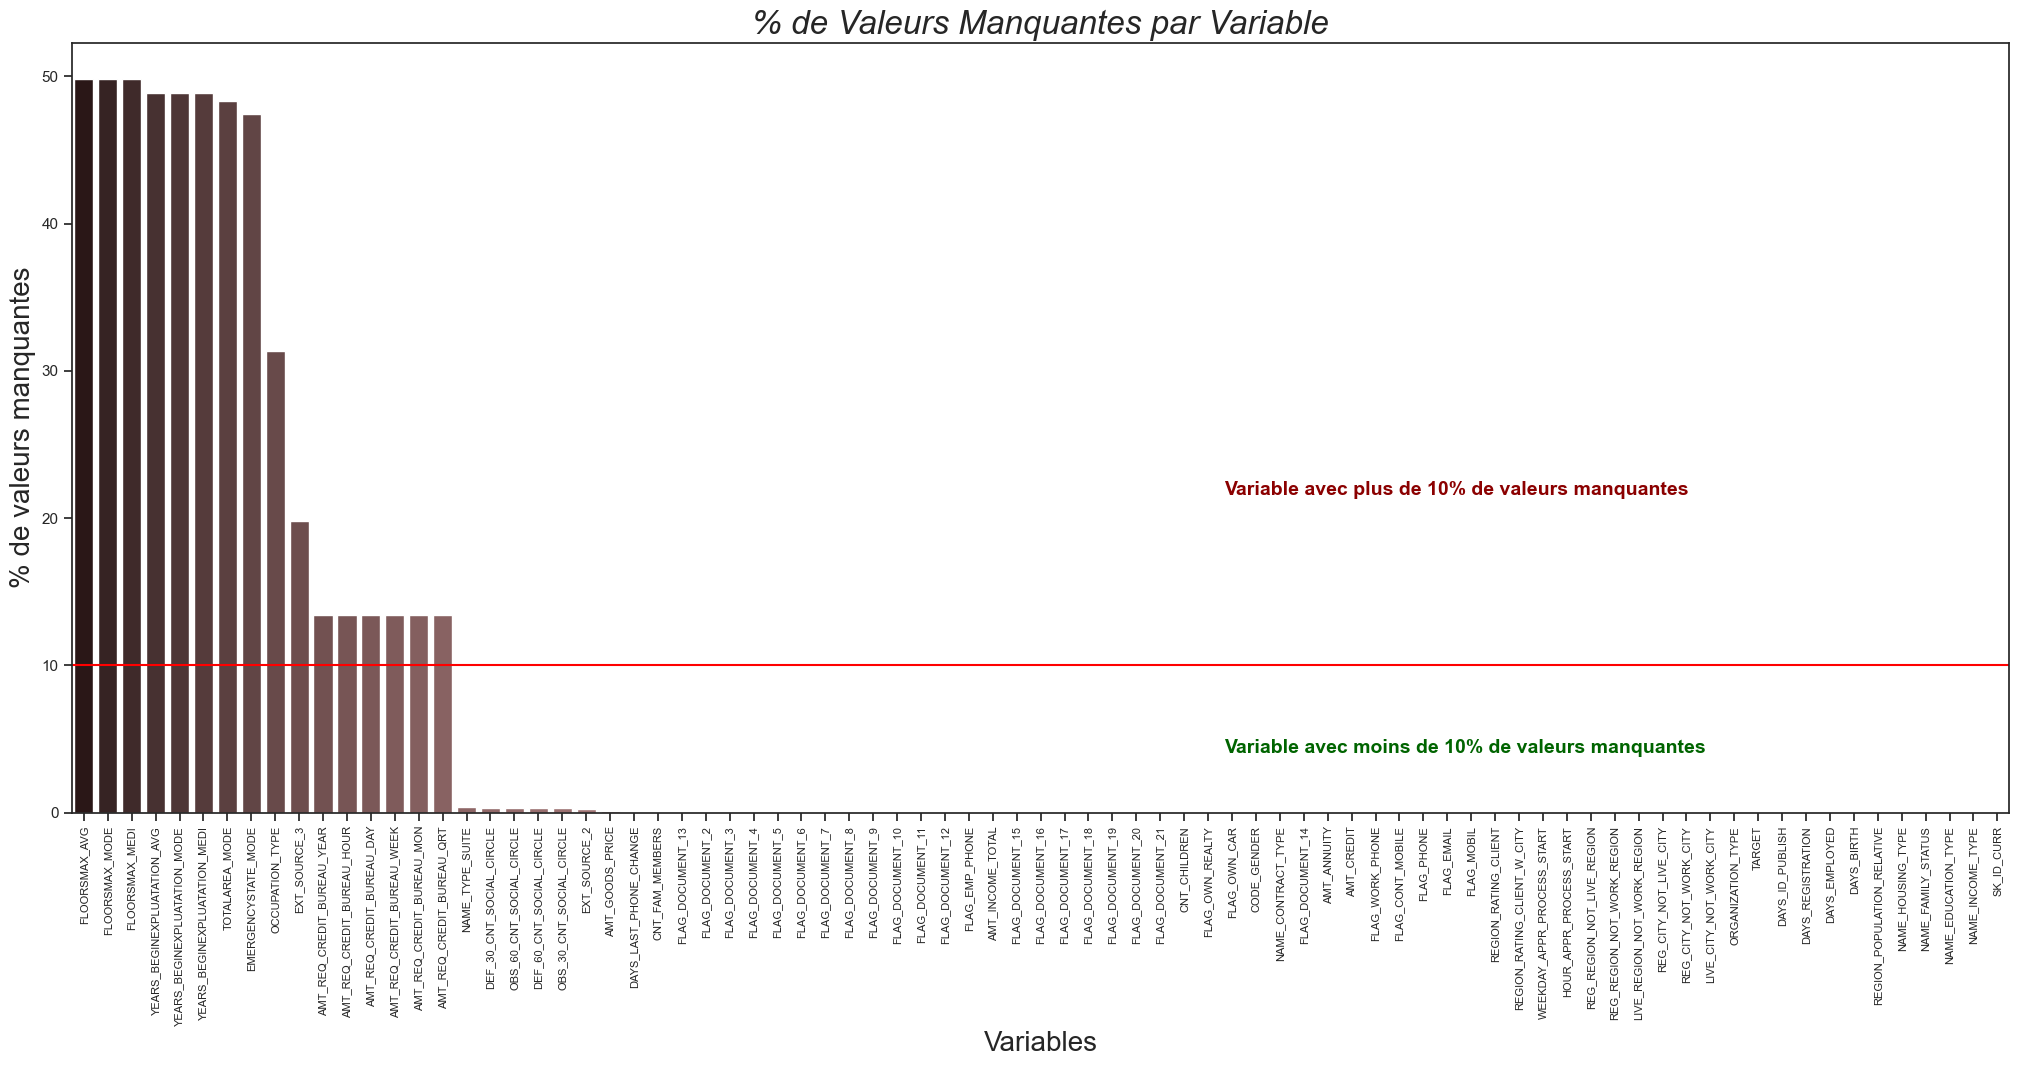

In [18]:
sns.set(style="ticks", rc = {'figure.figsize':(25,10)}, palette= "pink")
thresh_na = 10

ax = plt.subplot(1,1,1)
perc = (X_train.isnull().sum()/X_train.shape[0])*100
perc = perc.sort_values(ascending=False)

ax = sns.barplot(x = X_train.columns, y = perc, palette = "pink")

plt.axhline(y = thresh_na, color = 'r', linestyle = '-')

plt.text(len(X_train.isnull().sum()/len(X_train))/1.7, 
         thresh_na+12.5, 'Variable avec plus de %s%s de valeurs manquantes' %(thresh_na, '%'), 
         fontsize = 14, weight = 'bold', color = 'darkred', ha = 'left' , va = 'top')

plt.text(len(X_train.isnull().sum()/len(X_train))/1.7, 
         thresh_na - 5, 'Variable avec moins de %s%s de valeurs manquantes' %(thresh_na, '%'), 
         fontsize = 14, weight = 'bold', color = 'darkgreen', ha = 'left' , va = 'top')

ax.set_title('% de Valeurs Manquantes par Variable', loc="center", fontsize = 24, fontstyle='italic')
ax.set_xlabel('Variables', fontsize = 20)
ax.set_ylabel('% de valeurs manquantes', fontsize = 20)
ax.set_xticklabels(perc.index, rotation = 90, fontsize = 8)

plt.show()

In [19]:
vars_with_na_2 = [var for var in X_train.columns if X_train[var].isnull().mean() > 0.1]
print(vars_with_na_2)

['OCCUPATION_TYPE', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [20]:
X_train[vars_with_na_2].dtypes

OCCUPATION_TYPE                  object
EXT_SOURCE_3                    float64
YEARS_BEGINEXPLUATATION_AVG     float64
FLOORSMAX_AVG                   float64
YEARS_BEGINEXPLUATATION_MODE    float64
FLOORSMAX_MODE                  float64
YEARS_BEGINEXPLUATATION_MEDI    float64
FLOORSMAX_MEDI                  float64
TOTALAREA_MODE                  float64
EMERGENCYSTATE_MODE              object
AMT_REQ_CREDIT_BUREAU_HOUR      float64
AMT_REQ_CREDIT_BUREAU_DAY       float64
AMT_REQ_CREDIT_BUREAU_WEEK      float64
AMT_REQ_CREDIT_BUREAU_MON       float64
AMT_REQ_CREDIT_BUREAU_QRT       float64
AMT_REQ_CREDIT_BUREAU_YEAR      float64
dtype: object

In [21]:
X_train[vars_with_na_2].describe(include=[np.number]).T

count  mean  std  min  25%  50%  75%   max
EXT_SOURCE_3                 35,331.00  0.51 0.19 0.00 0.37 0.54 0.67  0.90
YEARS_BEGINEXPLUATATION_AVG  22,533.00  0.98 0.05 0.00 0.98 0.98 0.99  1.00
FLOORSMAX_AVG                22,121.00  0.23 0.14 0.00 0.17 0.17 0.33  1.00
YEARS_BEGINEXPLUATATION_MODE 22,533.00  0.98 0.06 0.00 0.98 0.98 0.99  1.00
FLOORSMAX_MODE               22,121.00  0.22 0.14 0.00 0.17 0.17 0.33  1.00
YEARS_BEGINEXPLUATATION_MEDI 22,533.00  0.98 0.06 0.00 0.98 0.98 0.99  1.00
FLOORSMAX_MEDI               22,121.00  0.22 0.15 0.00 0.17 0.17 0.33  1.00
TOTALAREA_MODE               22,760.00  0.10 0.11 0.00 0.04 0.07 0.13  1.00
AMT_REQ_CREDIT_BUREAU_HOUR   38,150.00  0.01 0.09 0.00 0.00 0.00 0.00  3.00
AMT_REQ_CREDIT_BUREAU_DAY    38,150.00  0.01 0.11 0.00 0.00 0.00 0.00  6.00
AMT_REQ_CREDIT_BUREAU_WEEK   38,150.00  0.03 0.20 0.00 0.00 0.00 0.00  6.00
AMT_REQ_CREDIT_BUREAU_MON    38,150.00  0.27 0.93 0.00 0.00 0.00 0.00 24.00
AMT_REQ_CREDIT_BUREAU_QRT    38,150.00  0.26 0.61 0.00 0.00 0.00 0.00  8.00
AMT_REQ_CREDIT_BUREAU_YEAR   38,150.00  1.88 1.86 0.00 0.00 1.00 3.00 25.00

In [22]:
X_train['OCCUPATION_TYPE'].value_counts(normalize=True, dropna=False)*100

OCCUPATION_TYPE
NaN                     31.33
Laborers                17.86
Sales staff             10.38
Core staff               8.93
Managers                 6.93
Drivers                  6.04
High skill tech staff    3.74
Accountants              3.20
Medicine staff           2.85
Security staff           2.27
Cooking staff            1.89
Cleaning staff           1.45
Private service staff    0.91
Low-skill Laborers       0.74
Waiters/barmen staff     0.44
Secretaries              0.43
Realty agents            0.25
HR staff                 0.21
IT staff                 0.15
Name: proportion, dtype: float64

In [23]:
X_train['EMERGENCYSTATE_MODE'].value_counts(normalize=True, dropna=False)*100

EMERGENCYSTATE_MODE
No    51.88
NaN   47.45
Yes    0.67
Name: proportion, dtype: float64

In [24]:
X_train.drop(labels=vars_with_na_2, axis=1, inplace=True)
X_train.shape

(44063, 65)

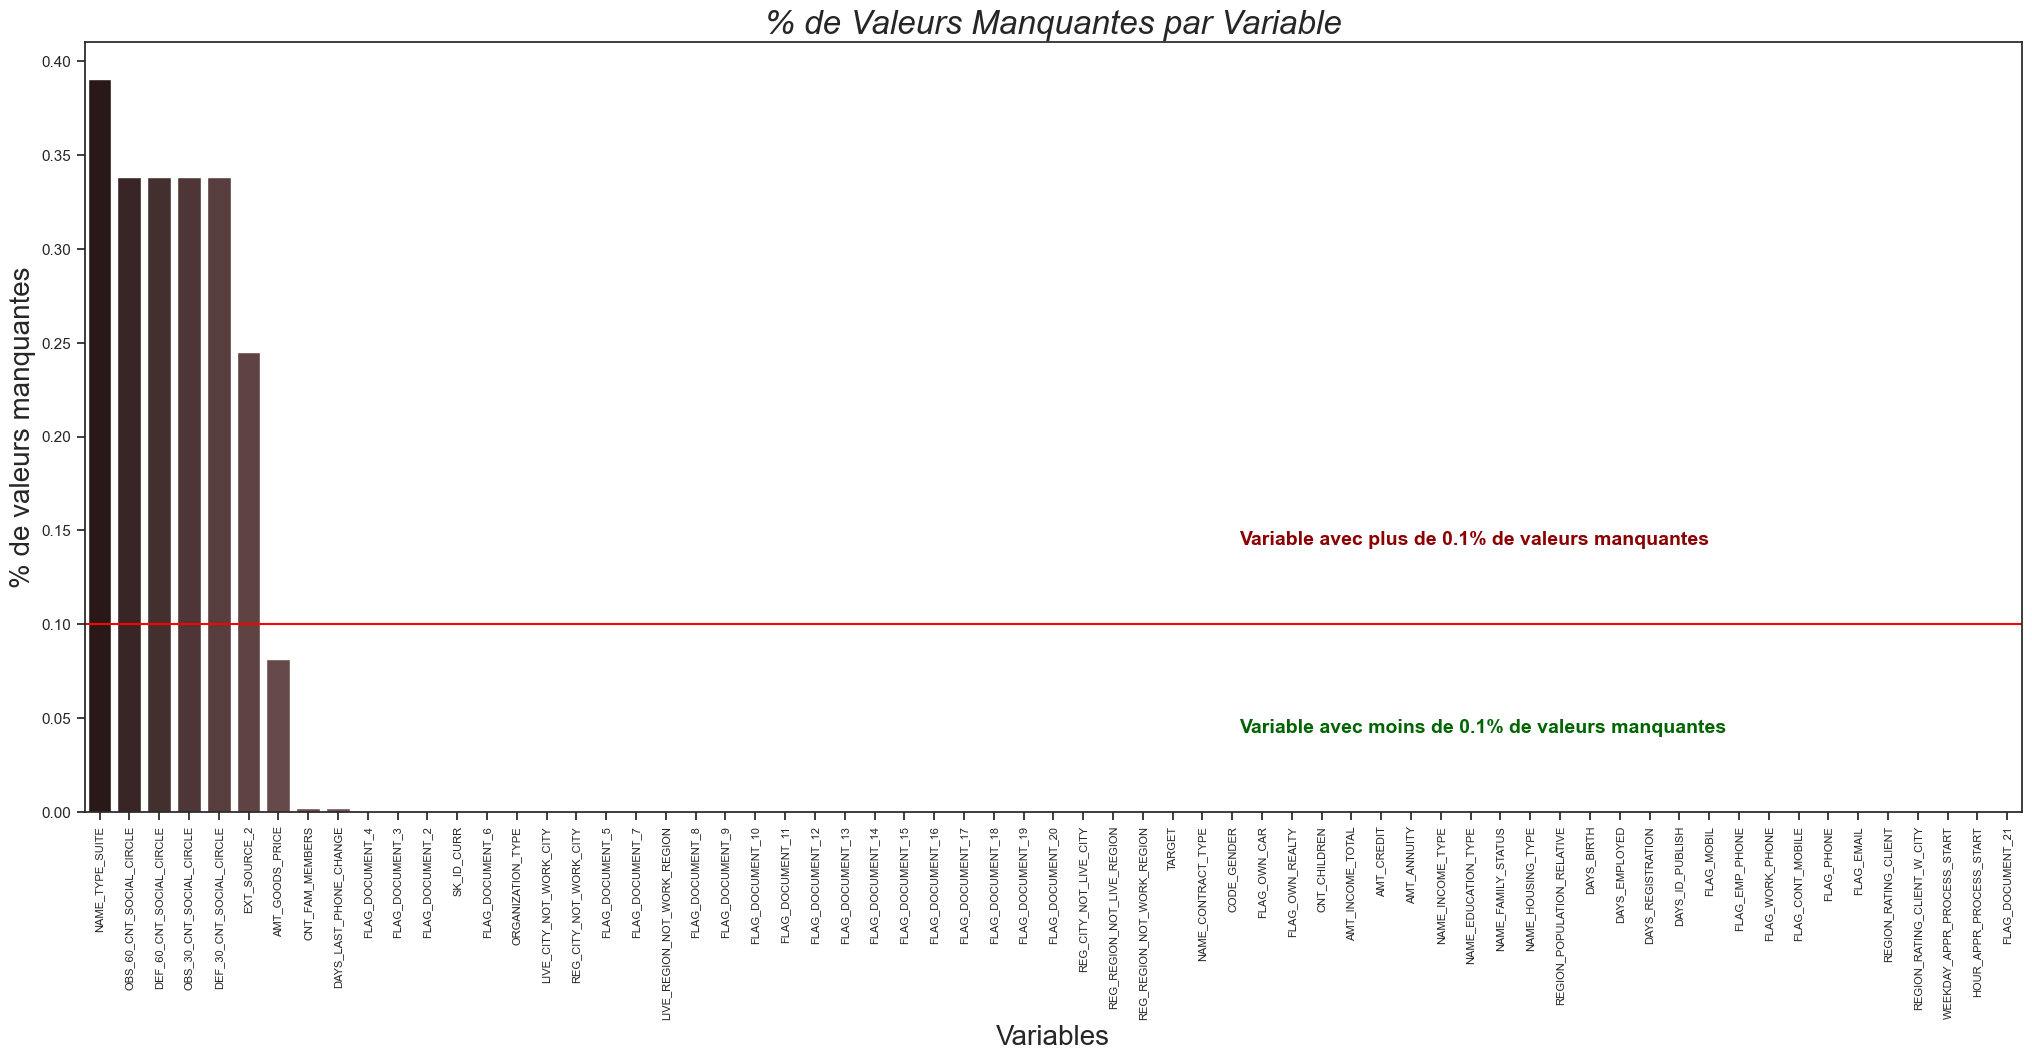

In [25]:
sns.set(style="ticks", rc = {'figure.figsize':(25,10)}, palette= "pink")
thresh_na = 0.1

ax = plt.subplot(1,1,1)
perc = (X_train.isnull().sum()/X_train.shape[0])*100
perc = perc.sort_values(ascending=False)

ax = sns.barplot(x = X_train.columns, y = perc, palette = "pink")

plt.axhline(y = thresh_na, color = 'r', linestyle = '-')

plt.text(len(X_train.isnull().sum()/len(X_train))/1.7, 
         thresh_na + 0.05, 'Variable avec plus de %s%s de valeurs manquantes' %(thresh_na, '%'), 
         fontsize = 14, weight = 'bold', color = 'darkred', ha = 'left' , va = 'top')

plt.text(len(X_train.isnull().sum()/len(X_train))/1.7, 
         thresh_na - 0.05, 'Variable avec moins de %s%s de valeurs manquantes' %(thresh_na, '%'), 
         fontsize = 14, weight = 'bold', color = 'darkgreen', ha = 'left' , va = 'top')

ax.set_title('% de Valeurs Manquantes par Variable', loc="center", fontsize = 24, fontstyle='italic')
ax.set_xlabel('Variables', fontsize = 20)
ax.set_ylabel('% de valeurs manquantes', fontsize = 20)
ax.set_xticklabels(perc.index, rotation = 90, fontsize = 8)

plt.show()

In [26]:
vars_with_na_3 = [var for var in X_train.columns if X_train[var].isnull().mean() > 0]
print(vars_with_na_3)

['AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']


In [27]:
X_train[vars_with_na_3].dtypes

AMT_GOODS_PRICE             float64
NAME_TYPE_SUITE              object
CNT_FAM_MEMBERS             float64
EXT_SOURCE_2                float64
OBS_30_CNT_SOCIAL_CIRCLE    float64
DEF_30_CNT_SOCIAL_CIRCLE    float64
OBS_60_CNT_SOCIAL_CIRCLE    float64
DEF_60_CNT_SOCIAL_CIRCLE    float64
DAYS_LAST_PHONE_CHANGE      float64
dtype: object

In [28]:
# Qui accompagnait le client lors de sa demande de prêt ?

X_train['NAME_TYPE_SUITE'].value_counts(normalize=True, dropna=False)*100

NAME_TYPE_SUITE
Unaccompanied     80.82
Family            13.17
Spouse, partner    3.66
Children           1.10
Other_B            0.52
NaN                0.39
Other_A            0.26
Group of people    0.07
Name: proportion, dtype: float64

In [29]:
X_train[vars_with_na_3].describe(include=[np.number]).T

count       mean        std       min        25%  \
AMT_GOODS_PRICE          44,027.00 539,218.65 369,773.39 45,000.00 238,500.00   
CNT_FAM_MEMBERS          44,062.00       2.16       0.91      1.00       2.00   
EXT_SOURCE_2             43,955.00       0.51       0.19      0.00       0.39   
OBS_30_CNT_SOCIAL_CIRCLE 43,914.00       1.43       2.31      0.00       0.00   
DEF_30_CNT_SOCIAL_CIRCLE 43,914.00       0.14       0.44      0.00       0.00   
OBS_60_CNT_SOCIAL_CIRCLE 43,914.00       1.41       2.29      0.00       0.00   
DEF_60_CNT_SOCIAL_CIRCLE 43,914.00       0.10       0.36      0.00       0.00   
DAYS_LAST_PHONE_CHANGE   44,062.00    -966.06     830.06 -4,002.00  -1,574.00   

                                50%        75%          max  
AMT_GOODS_PRICE          450,000.00 679,500.00 4,050,000.00  
CNT_FAM_MEMBERS                2.00       3.00        13.00  
EXT_SOURCE_2                   0.57       0.66         0.85  
OBS_30_CNT_SOCIAL_CIRCLE       0.00       2.00        28.00  
DEF_30_CNT_SOCIAL_CIRCLE       0.00       0.00         6.00  
OBS_60_CNT_SOCIAL_CIRCLE       0.00       2.00        28.00  
DEF_60_CNT_SOCIAL_CIRCLE       0.00       0.00         5.00  
DAYS_LAST_PHONE_CHANGE      -758.00    -271.00         0.00

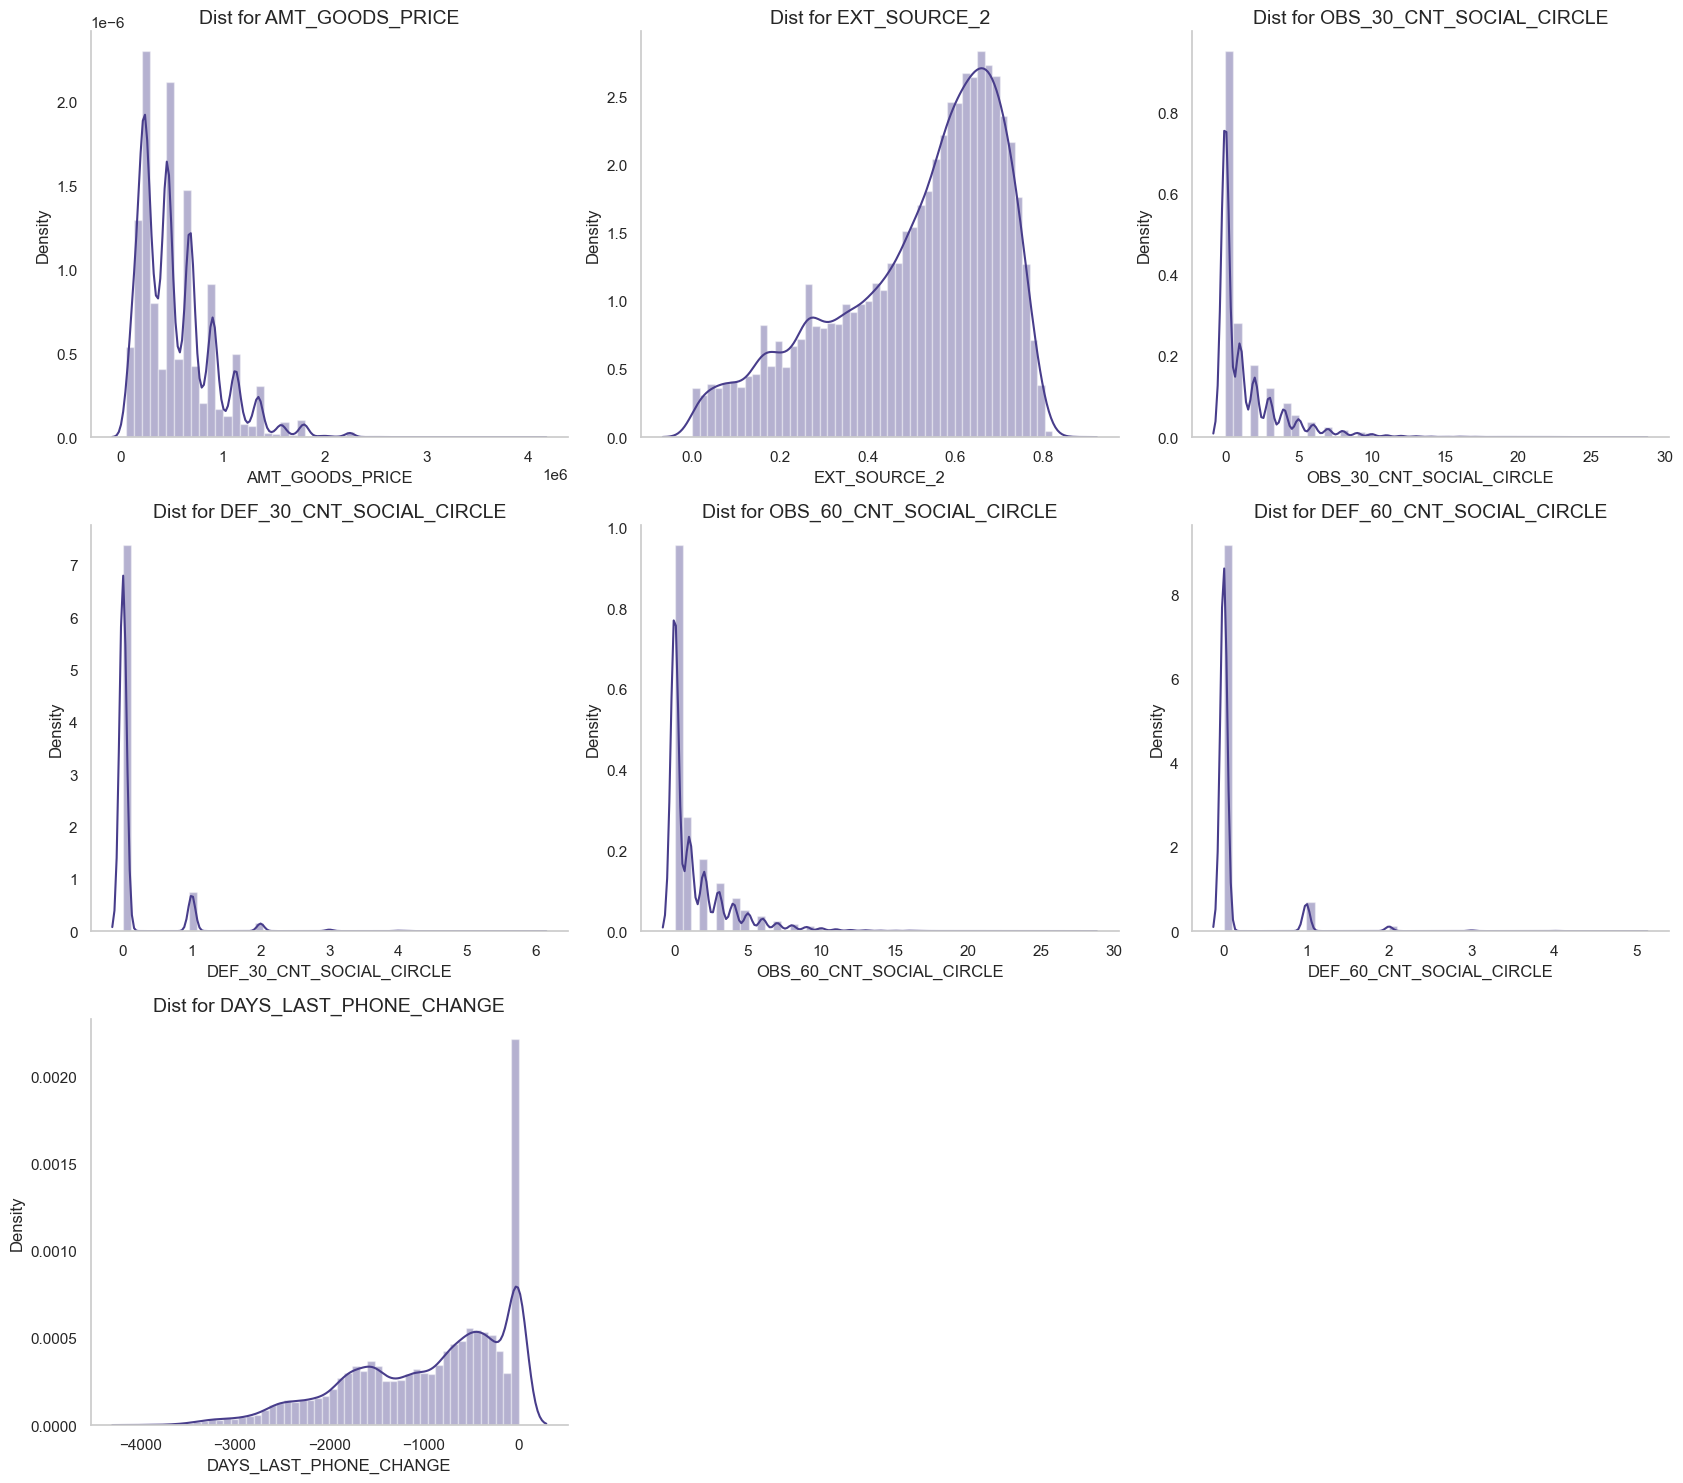

In [31]:
# Suppression des variables catégorielles de la liste
vars_with_na_3 = [var for var in vars_with_na_3 if X_train[var].dtype != 'O']

plot_multiple_distplots(df=X_train, 
                        col_list=vars_with_na_3, 
                        n_cols=3,
                        kind='dist',
                        hist=True,
                        kde=True,
                        size_title=14)
plt.show()

**Compte tenu des distributions des variables numériques, nous allons remplacer les valeurs manquantes par leur médiane.**

Mais d'abord supprimons les colonnes que nous avons éliminées du dataframe "train", dans le dataframe "test".

In [32]:
vars_with_na_drop = vars_with_na_1 + vars_with_na_2

In [33]:
X_test.drop(labels=vars_with_na_drop, axis=1, inplace=True)
X_test.shape

(36374, 64)

In [34]:
# Suppression de la variable cible dans le X-train
y_train = X_train['TARGET']
X_train.drop(labels='TARGET', axis=1, inplace=True)
X_train.shape, y_train.shape

((44063, 64), (44063,))

In [36]:
#!pip install feature-engine
from feature_engine.imputation import MeanMedianImputer

# To perform median imputation, we specify the 
# imputation strategy
imputer = MeanMedianImputer(imputation_method='median')
# we fit the imputer
imputer.fit(X_train)
# The imputer found the numerical variables to
# impute with the median
print(imputer.variables_)

['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLA

In [37]:
# here we can see the median assigned to each variable
imputer.imputer_dict_

{'SK_ID_CURR': 125659.0,
 'CNT_CHILDREN': 0.0,
 'AMT_INCOME_TOTAL': 144000.0,
 'AMT_CREDIT': 517500.0,
 'AMT_ANNUITY': 24939.0,
 'AMT_GOODS_PRICE': 450000.0,
 'REGION_POPULATION_RELATIVE': 0.01885,
 'DAYS_BIRTH': -15751.0,
 'DAYS_EMPLOYED': -1222.0,
 'DAYS_REGISTRATION': -4482.0,
 'DAYS_ID_PUBLISH': -3256.0,
 'FLAG_MOBIL': 1.0,
 'FLAG_EMP_PHONE': 1.0,
 'FLAG_WORK_PHONE': 0.0,
 'FLAG_CONT_MOBILE': 1.0,
 'FLAG_PHONE': 0.0,
 'FLAG_EMAIL': 0.0,
 'CNT_FAM_MEMBERS': 2.0,
 'REGION_RATING_CLIENT': 2.0,
 'REGION_RATING_CLIENT_W_CITY': 2.0,
 'HOUR_APPR_PROCESS_START': 12.0,
 'REG_REGION_NOT_LIVE_REGION': 0.0,
 'REG_REGION_NOT_WORK_REGION': 0.0,
 'LIVE_REGION_NOT_WORK_REGION': 0.0,
 'REG_CITY_NOT_LIVE_CITY': 0.0,
 'REG_CITY_NOT_WORK_CITY': 0.0,
 'LIVE_CITY_NOT_WORK_CITY': 0.0,
 'EXT_SOURCE_2': 0.5654134269877088,
 'OBS_30_CNT_SOCIAL_CIRCLE': 0.0,
 'DEF_30_CNT_SOCIAL_CIRCLE': 0.0,
 'OBS_60_CNT_SOCIAL_CIRCLE': 0.0,
 'DEF_60_CNT_SOCIAL_CIRCLE': 0.0,
 'DAYS_LAST_PHONE_CHANGE': -758.0,
 'FLAG_DOCUMENT

In [38]:
# Feature-engine returns a dataframe
clean_X_train = imputer.transform(X_train)
clean_X_train.shape

(44063, 64)

In [39]:
# let's check that the numerical variables don't
# have NA any more
clean_X_train[imputer.variables_].isnull().mean()

SK_ID_CURR                    0.00
CNT_CHILDREN                  0.00
AMT_INCOME_TOTAL              0.00
AMT_CREDIT                    0.00
AMT_ANNUITY                   0.00
AMT_GOODS_PRICE               0.00
REGION_POPULATION_RELATIVE    0.00
DAYS_BIRTH                    0.00
DAYS_EMPLOYED                 0.00
DAYS_REGISTRATION             0.00
DAYS_ID_PUBLISH               0.00
FLAG_MOBIL                    0.00
FLAG_EMP_PHONE                0.00
FLAG_WORK_PHONE               0.00
FLAG_CONT_MOBILE              0.00
FLAG_PHONE                    0.00
FLAG_EMAIL                    0.00
CNT_FAM_MEMBERS               0.00
REGION_RATING_CLIENT          0.00
REGION_RATING_CLIENT_W_CITY   0.00
HOUR_APPR_PROCESS_START       0.00
REG_REGION_NOT_LIVE_REGION    0.00
REG_REGION_NOT_WORK_REGION    0.00
LIVE_REGION_NOT_WORK_REGION   0.00
REG_CITY_NOT_LIVE_CITY        0.00
REG_CITY_NOT_WORK_CITY        0.00
LIVE_CITY_NOT_WORK_CITY       0.00
EXT_SOURCE_2                  0.00
OBS_30_CNT_SOCIAL_CI

In [40]:
clean_X_test = imputer.transform(X_test)
clean_X_test.shape

(36374, 64)

In [41]:
clean_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44063 entries, 0 to 44062
Data columns (total 64 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   44063 non-null  int64  
 1   NAME_CONTRACT_TYPE           44063 non-null  object 
 2   CODE_GENDER                  44063 non-null  object 
 3   FLAG_OWN_CAR                 44063 non-null  object 
 4   FLAG_OWN_REALTY              44063 non-null  object 
 5   CNT_CHILDREN                 44063 non-null  int64  
 6   AMT_INCOME_TOTAL             44063 non-null  float64
 7   AMT_CREDIT                   44063 non-null  float64
 8   AMT_ANNUITY                  44063 non-null  float64
 9   AMT_GOODS_PRICE              44063 non-null  float64
 10  NAME_TYPE_SUITE              43891 non-null  object 
 11  NAME_INCOME_TYPE             44063 non-null  object 
 12  NAME_EDUCATION_TYPE          44063 non-null  object 
 13  NAME_FAMILY_STAT

In [42]:
clean_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36374 entries, 0 to 36373
Data columns (total 64 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   36374 non-null  int64  
 1   NAME_CONTRACT_TYPE           36374 non-null  object 
 2   CODE_GENDER                  36374 non-null  object 
 3   FLAG_OWN_CAR                 36374 non-null  object 
 4   FLAG_OWN_REALTY              36374 non-null  object 
 5   CNT_CHILDREN                 36374 non-null  int64  
 6   AMT_INCOME_TOTAL             36374 non-null  float64
 7   AMT_CREDIT                   36374 non-null  float64
 8   AMT_ANNUITY                  36374 non-null  float64
 9   AMT_GOODS_PRICE              36374 non-null  float64
 10  NAME_TYPE_SUITE              35698 non-null  object 
 11  NAME_INCOME_TYPE             36374 non-null  object 
 12  NAME_EDUCATION_TYPE          36374 non-null  object 
 13  NAME_FAMILY_STAT

Une seule variable catégorielle à des valeurs manquantes, NAME_TYPE_SUITE : Qui accompagnait le client lors de sa demande de prêt ?

In [43]:
# We specify how we want to impute
# the categorical variables.
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer(imputation_method='frequent')
# we fit the imputer
imputer.fit(clean_X_train)
# here we can see the values that will be used
# to replace NA for each variable
imputer.imputer_dict_

{'NAME_CONTRACT_TYPE': 'Cash loans',
 'CODE_GENDER': 'F',
 'FLAG_OWN_CAR': 'N',
 'FLAG_OWN_REALTY': 'Y',
 'NAME_TYPE_SUITE': 'Unaccompanied',
 'NAME_INCOME_TYPE': 'Working',
 'NAME_EDUCATION_TYPE': 'Secondary / secondary special',
 'NAME_FAMILY_STATUS': 'Married',
 'NAME_HOUSING_TYPE': 'House / apartment',
 'WEEKDAY_APPR_PROCESS_START': 'TUESDAY',
 'ORGANIZATION_TYPE': 'Business Entity Type 3'}

In [44]:
clean_X_train = imputer.transform(clean_X_train)

In [45]:
# let's check that the numerical variables don't
# contain NA any more
clean_X_train[imputer.variables_].isnull().mean()

NAME_CONTRACT_TYPE           0.00
CODE_GENDER                  0.00
FLAG_OWN_CAR                 0.00
FLAG_OWN_REALTY              0.00
NAME_TYPE_SUITE              0.00
NAME_INCOME_TYPE             0.00
NAME_EDUCATION_TYPE          0.00
NAME_FAMILY_STATUS           0.00
NAME_HOUSING_TYPE            0.00
WEEKDAY_APPR_PROCESS_START   0.00
ORGANIZATION_TYPE            0.00
dtype: float64

In [46]:
clean_X_test = imputer.transform(clean_X_test)
clean_X_test[imputer.variables_].isnull().mean()

NAME_CONTRACT_TYPE           0.00
CODE_GENDER                  0.00
FLAG_OWN_CAR                 0.00
FLAG_OWN_REALTY              0.00
NAME_TYPE_SUITE              0.00
NAME_INCOME_TYPE             0.00
NAME_EDUCATION_TYPE          0.00
NAME_FAMILY_STATUS           0.00
NAME_HOUSING_TYPE            0.00
WEEKDAY_APPR_PROCESS_START   0.00
ORGANIZATION_TYPE            0.00
dtype: float64

In [47]:
clean_X_test.shape, clean_X_train.shape

((36374, 64), (44063, 64))

## Les variables qualitatives

In [48]:
print(clean_X_train.select_dtypes(exclude=[np.number]).columns.to_list())

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


### Le genre du client

In [49]:
# Fonction pour tracer des graphiques à barre d'une variable qualitative
# la variable couleur est un dictionnaire pour attribuer une couleur à une modalité 
# ou un nom de palette ; taille est un tuple qui représente la taille du graph

def grah_barre(df, var, couleur, titre, taille):
    
    fig, ax = plt.subplots(figsize=taille)
    
    plot_countplot(df=df, 
                   col=var, 
                   order=True,
                   palette=couleur,
                   ax=ax, orient='v', 
                   size_labels=12)

    plt.title(titre, loc="center", fontsize=18, fontstyle='italic')
    plt.show()

In [50]:
clean_X_train['CODE_GENDER'].value_counts()

CODE_GENDER
F      28939
M      15122
XNA        2
Name: count, dtype: int64

In [51]:
# Qui sont les 4 clients dont le genre n'est pas connu ?
clean_X_train[clean_X_train.CODE_GENDER == 'XNA']

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
35657      141289    Revolving loans         XNA            Y               Y   
38566      144669    Revolving loans         XNA            N               Y   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
35657             0        207,000.00  382,500.00    19,125.00   
38566             2        157,500.00  270,000.00    13,500.00   

       AMT_GOODS_PRICE  ... FLAG_DOCUMENT_12 FLAG_DOCUMENT_13  \
35657       337,500.00  ...                0                0   
38566       225,000.00  ...                0                0   

      FLAG_DOCUMENT_14 FLAG_DOCUMENT_15 FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  \
35657                0                0                0                 0   
38566                0                0                0                 0   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  
35657                 0                 0                 0                 0  
38566                 0                 0                 0                 0  

[2 rows x 64 columns]

In [52]:
# Imputation des 4 clients dont le genre est inconnu à la modalité la plus fréquente (F)

map_genre = {'F' : 'Femme',
             'M' : 'Homme',
             'XNA' : 'Femme'}

clean_X_train['CODE_GENDER'] = clean_X_train['CODE_GENDER'].map(map_genre)
clean_X_test['CODE_GENDER'] = clean_X_test['CODE_GENDER'].map(map_genre)

clean_X_train.shape, clean_X_test.shape

((44063, 64), (36374, 64))

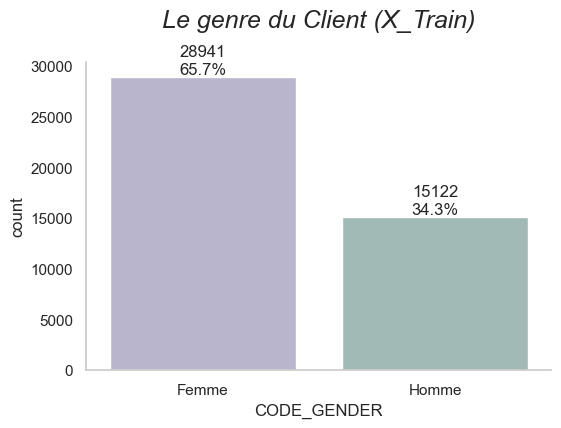

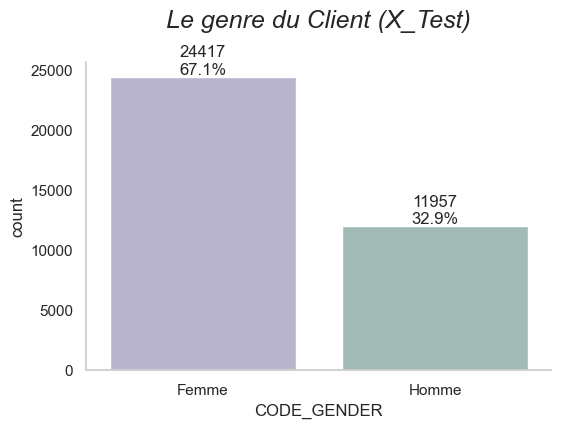

In [53]:
couleur = {"Femme" : "#b5b1d0",
           "Homme" : "#9ebeb8"}

grah_barre(clean_X_train, 'CODE_GENDER', couleur, "Le genre du Client (X_Train)\n", (6, 4))
grah_barre(clean_X_test, 'CODE_GENDER', couleur, "Le genre du Client (X_Test)\n", (6, 4))

### Le client a-t-il une voiture ? 

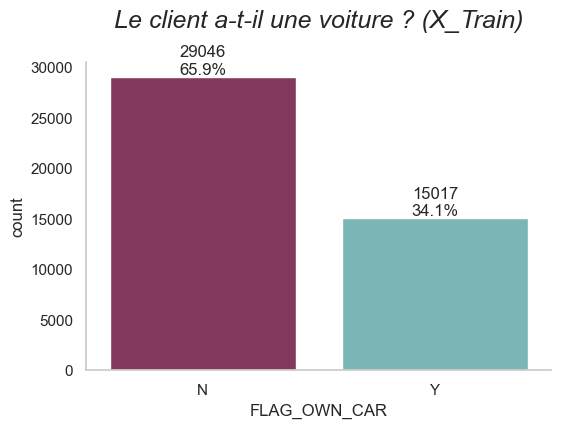

In [54]:
palette2 = {"N" : "#902b5c",
            "Y" : "#73bfbf"}

grah_barre(clean_X_train, 'FLAG_OWN_CAR', palette2, "Le client a-t-il une voiture ? (X_Train)\n", (6, 4))

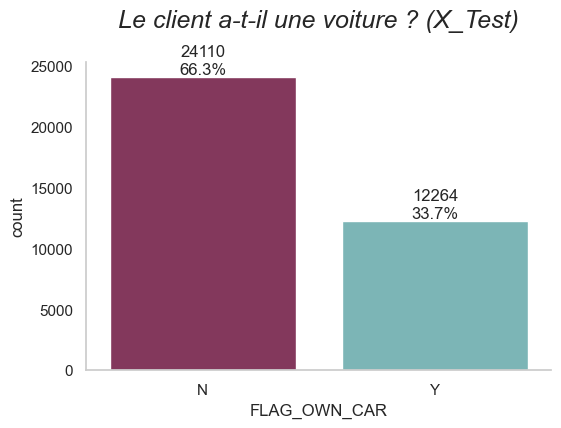

In [55]:
grah_barre(clean_X_test, 'FLAG_OWN_CAR', palette2, "Le client a-t-il une voiture ? (X_Test)\n", (6, 4))

### Le client possède-t-il un appartement ou une maison ?

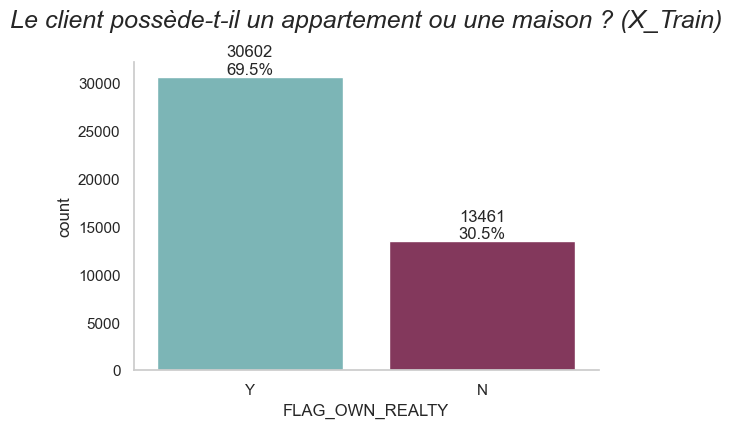

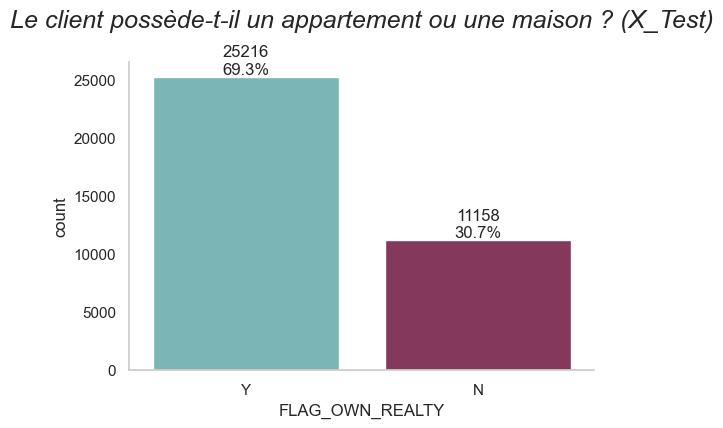

In [56]:
grah_barre(clean_X_train, 'FLAG_OWN_REALTY', palette2, "Le client possède-t-il un appartement ou une maison ? (X_Train)\n", (6, 4))
grah_barre(clean_X_test, 'FLAG_OWN_REALTY', palette2, "Le client possède-t-il un appartement ou une maison ? (X_Test)\n", (6, 4))

 ### Qui accompagnait le client lors de sa demande de prêt ?

In [57]:
clean_X_train['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      35785
Family              5802
Spouse, partner     1614
Children             483
Other_B              231
Other_A              116
Group of people       32
Name: count, dtype: int64

In [58]:
# Regroupement des modalités

map_name_type_suite = {'Unaccompanied' : 'Unaccompanied',
                       'Family' : 'Famille',
                       'Spouse, partner' : 'Famille',
                       'Children' : 'Famille',
                       'Other_A' : 'Autres',
                       'Other_B' : 'Autres',
                       'Group of people' : 'Autres'}

clean_X_train['NAME_TYPE_SUITE'] = clean_X_train['NAME_TYPE_SUITE'].map(map_name_type_suite)

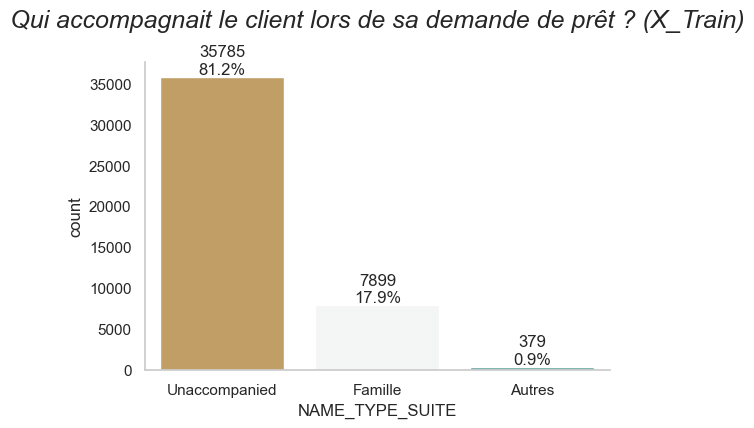

In [59]:
grah_barre(clean_X_train, 'NAME_TYPE_SUITE', "BrBG", "Qui accompagnait le client lors de sa demande de prêt ? (X_Train)\n", (6, 4))

In [60]:
clean_X_test['NAME_TYPE_SUITE'] = clean_X_test['NAME_TYPE_SUITE'].map(map_name_type_suite)

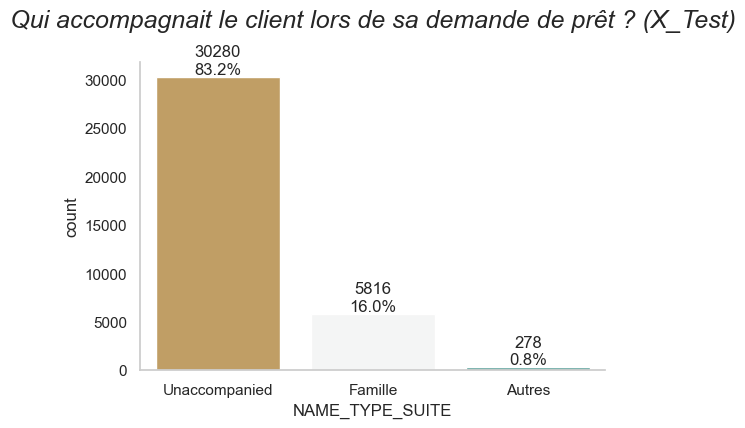

In [61]:
grah_barre(clean_X_test, 'NAME_TYPE_SUITE', "BrBG", "Qui accompagnait le client lors de sa demande de prêt ? (X_Test)\n", (6, 4))

Cette variable risque d'être fort peu discriminante puisque plus de 80% des clients sont venus seuls. Nous pourrions la supprimer.

### Type de revenu des clients

In [62]:
clean_X_train['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 22947
Commercial associate    10127
Pensioner                7884
State servant            3094
Unemployed                  6
Student                     3
Businessman                 2
Name: count, dtype: int64

In [63]:
# Regroupement des modalités

map_name_income_type = {'Working' : 'employé',
                        'Commercial associate' : 'associé_commercial_ou_Businessman',
                        'Pensioner' : 'retraité_ou_sans_emploi',
                        'State servant' : 'fonctionnaire',
                        'Unemployed' : 'retraité_ou_sans_emploi',
                        'Student' : 'retraité_ou_sans_emploi',
                        'Maternity leave' : 'retraité_ou_sans_emploi'}

clean_X_train['NAME_INCOME_TYPE'] = clean_X_train['NAME_INCOME_TYPE'].map(map_name_income_type)

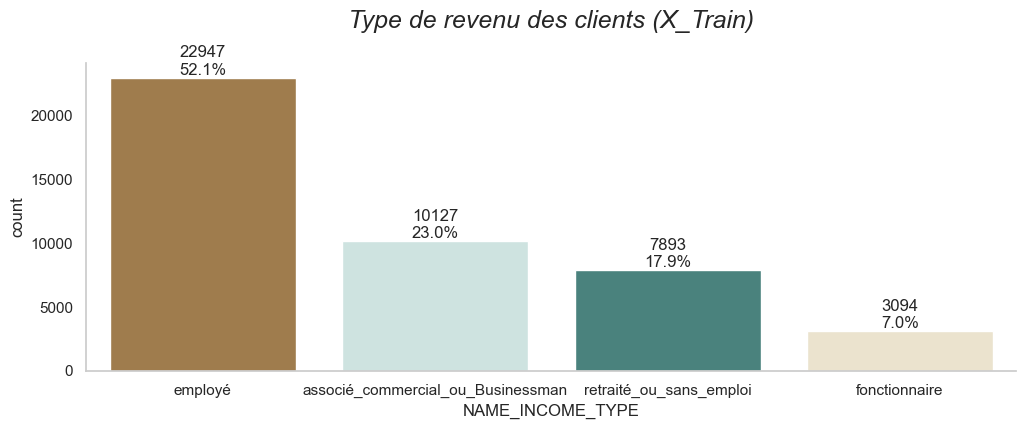

In [64]:
palette3 = {"employé": "#ad7e3f",
            "associé_commercial_ou_Businessman": "#cbe6e2",
            "fonctionnaire" : "#f0e5c9",
            "retraité_ou_sans_emploi" : "#418b85"}

grah_barre(clean_X_train, 'NAME_INCOME_TYPE', palette3, "Type de revenu des clients (X_Train)\n", (12, 4))

In [65]:
clean_X_test['NAME_INCOME_TYPE'] = clean_X_test['NAME_INCOME_TYPE'].map(map_name_income_type)

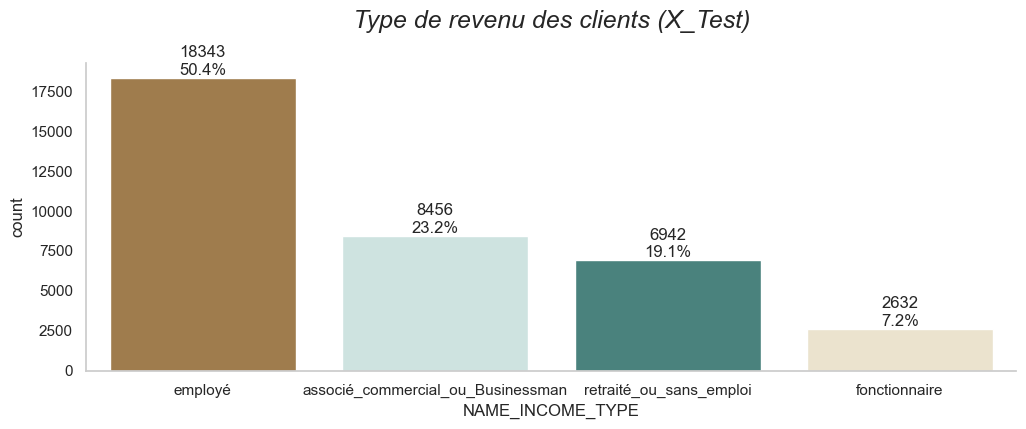

In [66]:
grah_barre(clean_X_test, 'NAME_INCOME_TYPE', palette3, "Type de revenu des clients (X_Test)\n", (12, 4))

### Niveau de scolarité le plus élevé atteint par le client

In [67]:
clean_X_train['NAME_EDUCATION_TYPE'].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    31315
Higher education                 10748
Incomplete higher                 1436
Lower secondary                    547
Academic degree                     17
Name: count, dtype: int64

In [68]:
# Regroupement des modalités

map_name_education_type = {'Lower secondary' : 'college_lycee',
                           'Secondary / secondary special' : 'college_lycee',
                           'Higher education' : 'enseignement_superieur',
                           'Academic degree' : 'enseignement_superieur',
                           'Incomplete higher' : 'enseignement_superieur'}

clean_X_train['NAME_EDUCATION_TYPE'] = clean_X_train['NAME_EDUCATION_TYPE'].map(map_name_education_type)

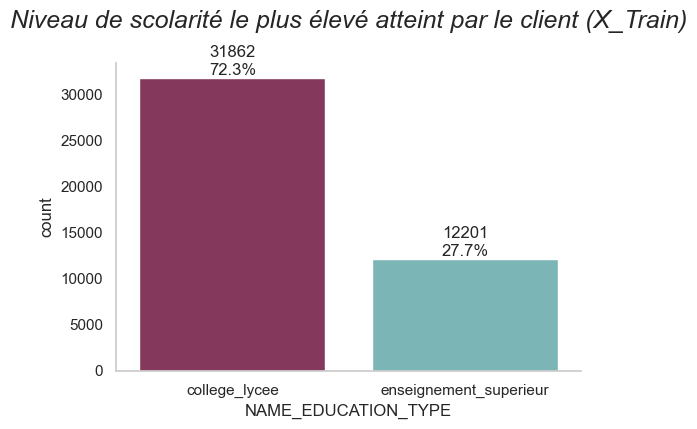

In [69]:
palette4 = {"college_lycee" : "#902b5c",
            "enseignement_superieur" : "#73bfbf"}

grah_barre(clean_X_train, 'NAME_EDUCATION_TYPE', palette4, "Niveau de scolarité le plus élevé atteint par le client (X_Train)\n", (6, 4))

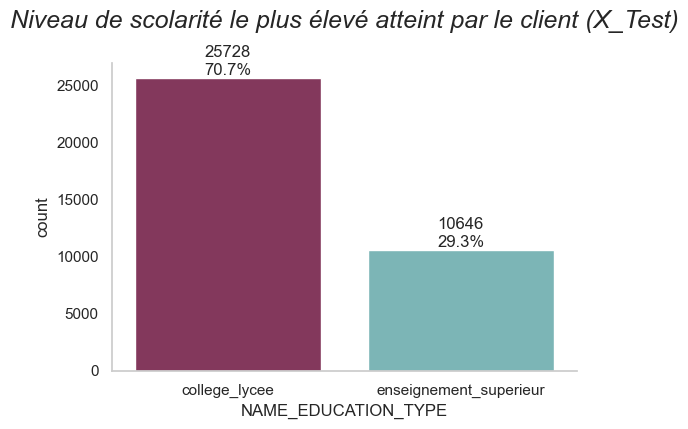

In [70]:
clean_X_test['NAME_EDUCATION_TYPE'] = clean_X_test['NAME_EDUCATION_TYPE'].map(map_name_education_type)

grah_barre(clean_X_test, 'NAME_EDUCATION_TYPE', palette4, "Niveau de scolarité le plus élevé atteint par le client (X_Test)\n", (6, 4))

### Situation familiale du client

In [71]:
clean_X_train['NAME_FAMILY_STATUS'].value_counts()

NAME_FAMILY_STATUS
Married                 28298
Single / not married     6426
Civil marriage           4289
Separated                2754
Widow                    2295
Unknown                     1
Name: count, dtype: int64

In [72]:
# Regroupement des modalités

map_name_education_type = {'Married' : 'avec_un_partenaire',
                           'Civil marriage' : 'avec_un_partenaire',
                           'Single / not married' : 'sans_partenaire',
                           'Separated' : 'sans_partenaire',
                           'Widow' : 'sans_partenaire',
                           'Unknown' : 'avec_un_partenaire'}

clean_X_train['NAME_FAMILY_STATUS'] = clean_X_train['NAME_FAMILY_STATUS'].map(map_name_education_type)

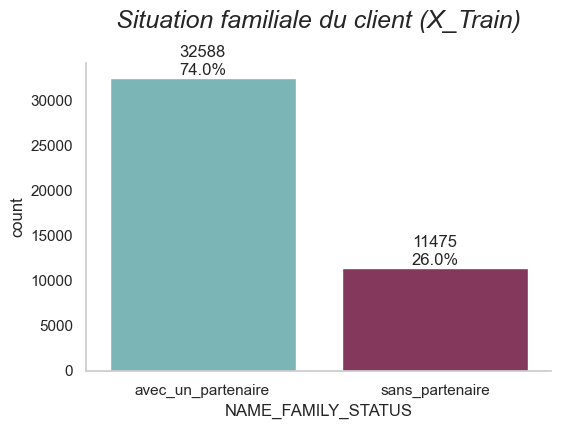

In [73]:
palette5 = {"sans_partenaire" : "#902b5c",
            "avec_un_partenaire" : "#73bfbf"}

grah_barre(clean_X_train, 'NAME_FAMILY_STATUS', palette5, "Situation familiale du client (X_Train)\n", (6, 4))

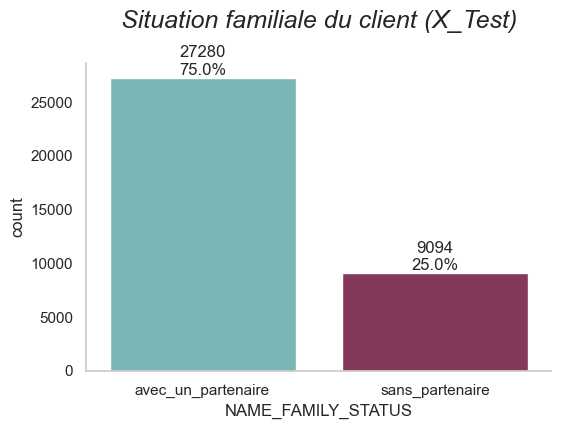

In [74]:
clean_X_test['NAME_FAMILY_STATUS'] = clean_X_test['NAME_FAMILY_STATUS'].map(map_name_education_type)
grah_barre(clean_X_test, 'NAME_FAMILY_STATUS', palette5, "Situation familiale du client (X_Test)\n", (6, 4))

### Quelle est la situation de logement du client (locataire, vivant avec les parents, ...)	?

In [75]:
clean_X_train['NAME_HOUSING_TYPE'].value_counts()

NAME_HOUSING_TYPE
House / apartment      39160
With parents            2087
Municipal apartment     1622
Rented apartment         667
Office apartment         367
Co-op apartment          160
Name: count, dtype: int64

In [76]:
# Regroupement des modalités

map_name_housing_type = {'House / apartment' : 'maison_appartement',
                         'With parents' : 'autre_type_logement',
                         'Municipal apartment' : 'autre_type_logement',
                         'Rented apartment' : 'autre_type_logement',
                         'Office apartment' : 'autre_type_logement',
                         'Co-op apartment' : 'autre_type_logement'}

clean_X_train['NAME_HOUSING_TYPE'] = clean_X_train['NAME_HOUSING_TYPE'].map(map_name_housing_type)

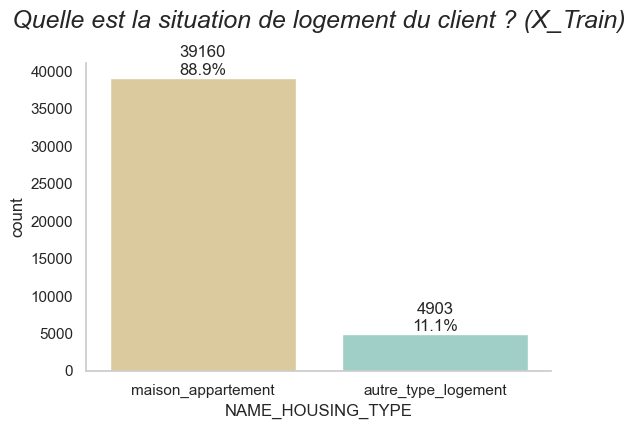

In [77]:
grah_barre(clean_X_train, 'NAME_HOUSING_TYPE', "BrBG", "Quelle est la situation de logement du client ? (X_Train)\n", (6, 4))

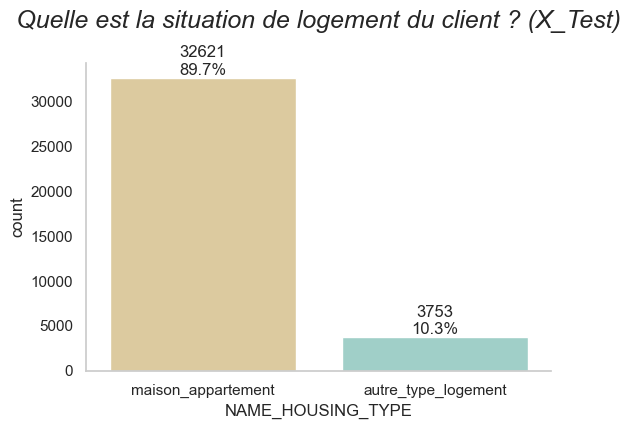

In [78]:
clean_X_test['NAME_HOUSING_TYPE'] = clean_X_test['NAME_HOUSING_TYPE'].map(map_name_housing_type)
grah_barre(clean_X_test, 'NAME_HOUSING_TYPE', "BrBG", "Quelle est la situation de logement du client ? (X_Test)\n", (6, 4))

### Type d'organisation où travaille le client 	?

In [79]:
clean_X_train['ORGANIZATION_TYPE'].value_counts(normalize=True) * 100

ORGANIZATION_TYPE
Business Entity Type 3   22.09
XNA                      17.90
Self-employed            12.50
Other                     5.45
Medicine                  3.67
Government                3.42
Business Entity Type 2    3.39
School                    2.94
Trade: type 7             2.45
Kindergarten              2.17
Construction              2.12
Business Entity Type 1    1.87
Transport: type 4         1.66
Trade: type 3             1.12
Industry: type 3          1.09
Security                  1.09
Industry: type 9          1.08
Industry: type 11         0.99
Housing                   0.96
Military                  0.90
Bank                      0.86
Transport: type 2         0.82
Agriculture               0.78
Postal                    0.74
Police                    0.74
Security Ministries       0.66
Trade: type 2             0.62
Services                  0.57
Restaurant                0.55
University                0.43
Industry: type 7          0.43
Transport: type 3    

In [80]:
clean_X_test['ORGANIZATION_TYPE'].value_counts(normalize=True) * 100

ORGANIZATION_TYPE
Business Entity Type 3   22.08
XNA                      19.08
Self-employed            12.06
Other                     5.59
Medicine                  3.51
Government                3.07
Business Entity Type 2    3.02
School                    2.67
Trade: type 7             2.64
Construction              2.21
Kindergarten              2.16
Business Entity Type 1    1.86
Transport: type 4         1.82
Trade: type 3             1.18
Military                  1.06
Industry: type 9          1.03
Industry: type 3          0.99
Security                  0.96
Transport: type 2         0.96
Police                    0.93
Housing                   0.89
Industry: type 11         0.89
Bank                      0.80
Security Ministries       0.67
Services                  0.62
Agriculture               0.60
Postal                    0.58
Restaurant                0.57
Trade: type 2             0.50
Industry: type 7          0.47
University                0.47
Transport: type 3    

Cette variable a beaucoup trop de valeurs maquantes (XNA) pour être conservée. Nous la supprimons des ensembles de'entraînement et de test.

In [81]:
clean_X_train.drop(labels='ORGANIZATION_TYPE', axis=1, inplace=True)
clean_X_test.drop(labels='ORGANIZATION_TYPE', axis=1, inplace=True)

clean_X_train.shape, clean_X_test.shape

((44063, 63), (36374, 63))

### Type de prêt : trésorerie ou renouvelable

In [82]:
clean_X_train['NAME_CONTRACT_TYPE'].value_counts()

NAME_CONTRACT_TYPE
Cash loans         39919
Revolving loans     4144
Name: count, dtype: int64

In [83]:
map_name_contract_type = {"Cash loans" : "cash_loans",
                          "Revolving loans" : "revolving_loans"}

clean_X_train['NAME_CONTRACT_TYPE'] = clean_X_train['NAME_CONTRACT_TYPE'].map(map_name_contract_type)

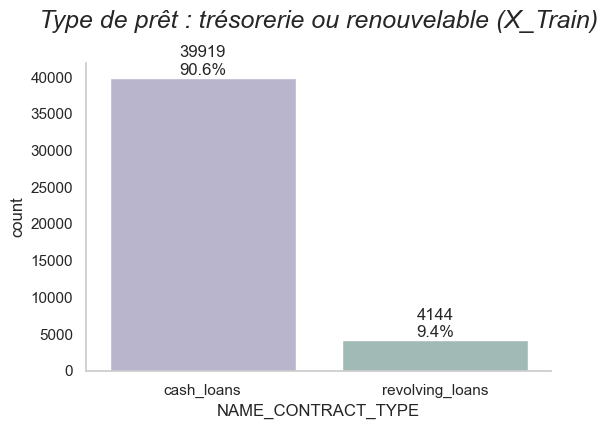

In [84]:
couleur2 = {"cash_loans" : "#b5b1d0",
            "revolving_loans" : "#9ebeb8"}

grah_barre(clean_X_train, 'NAME_CONTRACT_TYPE', couleur2, "Type de prêt : trésorerie ou renouvelable (X_Train)\n", (6, 4))

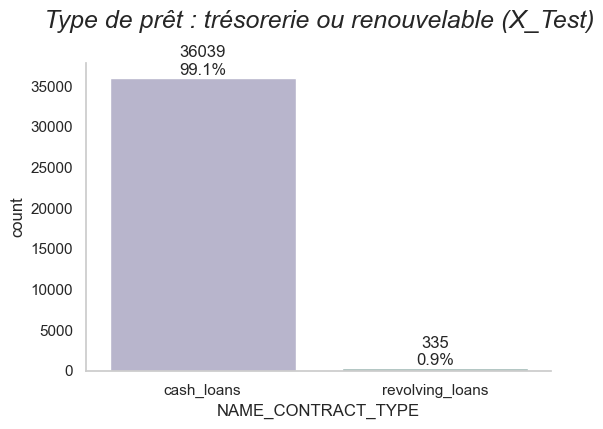

In [85]:
clean_X_test['NAME_CONTRACT_TYPE'] = clean_X_test['NAME_CONTRACT_TYPE'].map(map_name_contract_type)

grah_barre(clean_X_test, 'NAME_CONTRACT_TYPE', couleur2, "Type de prêt : trésorerie ou renouvelable (X_Test)\n", (6, 4))

### Quel jour de la semaine le client a-t-il demandé le prêt ?

In [86]:
clean_X_train['WEEKDAY_APPR_PROCESS_START'].value_counts()

WEEKDAY_APPR_PROCESS_START
TUESDAY      7734
WEDNESDAY    7346
FRIDAY       7320
MONDAY       7315
THURSDAY     7239
SATURDAY     4820
SUNDAY       2289
Name: count, dtype: int64

In [87]:
clean_X_test['WEEKDAY_APPR_PROCESS_START'].value_counts()

WEEKDAY_APPR_PROCESS_START
TUESDAY      7285
THURSDAY     6323
MONDAY       6300
WEDNESDAY    6288
FRIDAY       5381
SATURDAY     3427
SUNDAY       1370
Name: count, dtype: int64

In [88]:
clean_X_train['TARGET'] = y_train

In [89]:
clean_X_train['TARGET'].value_counts()

TARGET
0    40507
1     3556
Name: count, dtype: int64

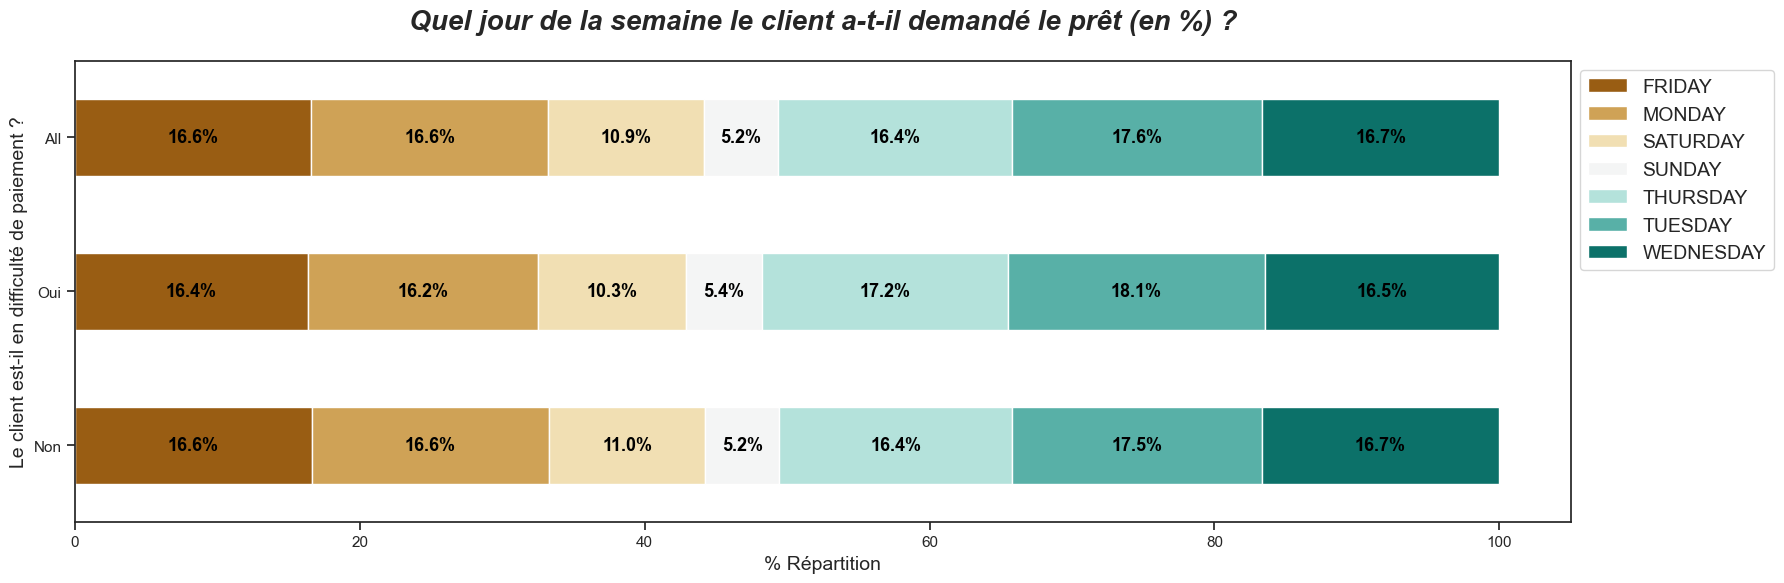

In [90]:
loan_map = {1 : "Oui",
            0 : "Non"}

df_tab_croisee = pd.crosstab(clean_X_train['TARGET'].map(loan_map), 
                             clean_X_train['WEEKDAY_APPR_PROCESS_START'],
                             normalize='index', margins=True, margins_name='All') * 100

sns.set(style="ticks", rc={'figure.figsize': (18, 6)})
sns.set_palette("BrBG", 7)

ax_1 = df_tab_croisee.plot.barh(stacked=True, rot=0)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2,
              rec.get_y() + height / 2,
              "{:.1f}%".format(rec.get_width()),
              ha='center',
              va='center',
              color='black',
              fontweight='bold',
              fontsize=13)
plt.xlabel('% Répartition', fontsize=14)
plt.ylabel('Le client est-il en difficulté de paiement ?', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.title('Quel jour de la semaine le client a-t-il demandé le prêt (en %) ?',
             y=1.05, fontsize=20, fontstyle='italic', fontweight='bold')
plt.tight_layout()
plt.show()

In [91]:
clean_X_train.drop(labels='TARGET', axis=1, inplace=True)
clean_X_train.shape, clean_X_test.shape

((44063, 63), (36374, 63))

## Les variables numériques et la Gestion des Outliers 

Une valeur aberrante est un point de données qui est significativement différent des données restantes. "Une valeur aberrante est une observation qui s'écarte tellement des autres observations qu'elle éveille des soupçons qu'elle a été générée par un mécanisme différent." [RÉ. Hawkins. Identification des valeurs aberrantes, Chapman et Hall, 1980].

Les statistiques telles que la moyenne et la variance sont très sensibles aux valeurs aberrantes. En outre, certains modèles de machine learning sont sensibles aux valeurs aberrantes, ce qui peut réduire leurs performances. Ainsi, selon l'algorithme que nous souhaitons former, nous supprimons souvent les valeurs aberrantes de nos variables où nous les transformons.

In [92]:
# function to create histogram, Q-Q plot and boxplot.

# for Q-Q plots
import scipy.stats as stats

def diagnostic_plots(df, variable, title):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    sns.set(style="ticks", rc = {'figure.figsize':(20, 4)})

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.suptitle(f"{title}",
                 y=1.05, fontsize=20, fontstyle='italic')

    plt.show()

In [93]:
clean_X_train.describe().T

count       mean        std        min  \
SK_ID_CURR                  44,063.00 125,584.22  14,715.40 100,002.00   
CNT_CHILDREN                44,063.00       0.42       0.72       0.00   
AMT_INCOME_TOTAL            44,063.00 170,950.69 565,219.02  25,650.00   
AMT_CREDIT                  44,063.00 600,033.72 402,405.01  45,000.00   
AMT_ANNUITY                 44,063.00  27,129.35  14,613.38   2,052.00   
AMT_GOODS_PRICE             44,063.00 539,145.76 369,631.10  45,000.00   
REGION_POPULATION_RELATIVE  44,063.00       0.02       0.01       0.00   
DAYS_BIRTH                  44,063.00 -16,031.66   4,359.36 -25,182.00   
DAYS_EMPLOYED               44,063.00  63,409.58 140,961.75 -17,531.00   
DAYS_REGISTRATION           44,063.00  -4,974.05   3,517.34 -21,249.00   
DAYS_ID_PUBLISH             44,063.00  -2,993.43   1,510.05  -6,228.00   
FLAG_MOBIL                  44,063.00       1.00       0.00       0.00   
FLAG_EMP_PHONE              44,063.00       0.82       0.38       0.00   
FLAG_WORK_PHONE             44,063.00       0.20       0.40       0.00   
FLAG_CONT_MOBILE            44,063.00       1.00       0.05       0.00   
FLAG_PHONE                  44,063.00       0.28       0.45       0.00   
FLAG_EMAIL                  44,063.00       0.06       0.23       0.00   
CNT_FAM_MEMBERS             44,063.00       2.16       0.91       1.00   
REGION_RATING_CLIENT        44,063.00       2.05       0.51       1.00   
REGION_RATING_CLIENT_W_CITY 44,063.00       2.03       0.50       1.00   
HOUR_APPR_PROCESS_START     44,063.00      12.06       3.25       0.00   
REG_REGION_NOT_LIVE_REGION  44,063.00       0.02       0.12       0.00   
REG_REGION_NOT_WORK_REGION  44,063.00       0.05       0.22       0.00   
LIVE_REGION_NOT_WORK_REGION 44,063.00       0.04       0.19       0.00   
REG_CITY_NOT_LIVE_CITY      44,063.00       0.08       0.27       0.00   
REG_CITY_NOT_WORK_CITY      44,063.00       0.23       0.42       0.00   
LIVE_CITY_NOT_WORK_CITY     44,063.00       0.18       0.38       0.00   
EXT_SOURCE_2                44,063.00       0.51       0.19       0.00   
OBS_30_CNT_SOCIAL_CIRCLE    44,063.00       1.42       2.31       0.00   
DEF_30_CNT_SOCIAL_CIRCLE    44,063.00       0.14       0.44       0.00   
OBS_60_CNT_SOCIAL_CIRCLE    44,063.00       1.40       2.29       0.00   
DEF_60_CNT_SOCIAL_CIRCLE    44,063.00       0.10       0.36       0.00   
DAYS_LAST_PHONE_CHANGE      44,063.00    -966.05     830.05  -4,002.00   
FLAG_DOCUMENT_2             44,063.00       0.00       0.01       0.00   
FLAG_DOCUMENT_3             44,063.00       0.71       0.45       0.00   
FLAG_DOCUMENT_4             44,063.00       0.00       0.01       0.00   
FLAG_DOCUMENT_5             44,063.00       0.02       0.12       0.00   
FLAG_DOCUMENT_6             44,063.00       0.09       0.28       0.00   
FLAG_DOCUMENT_7             44,063.00       0.00       0.01       0.00   
FLAG_DOCUMENT_8             44,063.00       0.08       0.27       0.00   
FLAG_DOCUMENT_9             44,063.00       0.00       0.06       0.00   
FLAG_DOCUMENT_10            44,063.00       0.00       0.00       0.00   
FLAG_DOCUMENT_11            44,063.00       0.00       0.07       0.00   
FLAG_DOCUMENT_12            44,063.00       0.00       0.00       0.00   
FLAG_DOCUMENT_13            44,063.00       0.00       0.06       0.00   
FLAG_DOCUMENT_14            44,063.00       0.00       0.06       0.00   
FLAG_DOCUMENT_15            44,063.00       0.00       0.03       0.00   
FLAG_DOCUMENT_16            44,063.00       0.01       0.10       0.00   
FLAG_DOCUMENT_17            44,063.00       0.00       0.02       0.00   
FLAG_DOCUMENT_18            44,063.00       0.01       0.09       0.00   
FLAG_DOCUMENT_19            44,063.00       0.00       0.03       0.00   
FLAG_DOCUMENT_20            44,063.00       0.00       0.02       0.00   
FLAG_DOCUMENT_21            44,063.00       0.00       0.02       0.00   

                                   

### Les variables numériques (presque) discrètes 

#### Le nombre d'enfants des clients

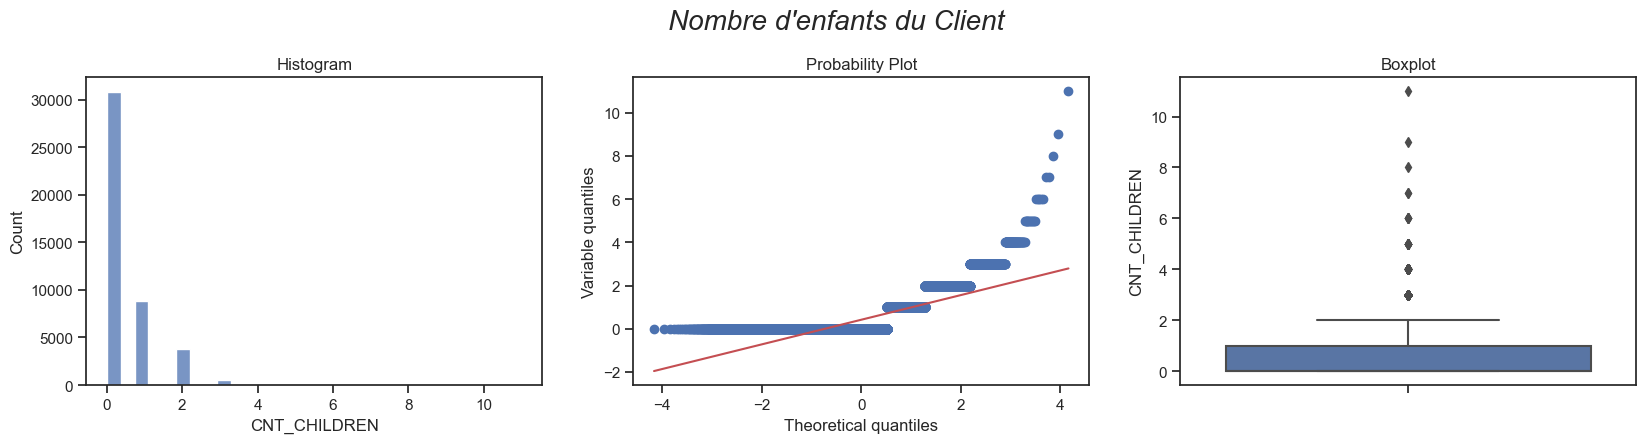

In [94]:
diagnostic_plots(clean_X_train, 'CNT_CHILDREN', "Nombre d'enfants du Client")

In [95]:
clean_X_train['CNT_CHILDREN'].value_counts()

CNT_CHILDREN
0     30826
1      8823
2      3774
3       556
4        62
5        12
6         5
7         2
8         1
9         1
11        1
Name: count, dtype: int64

In [96]:
# Transformation de la variable numérique 'CNT_CHILDREN' en variable qualitative de l'ensemble d'entraînement

clean_X_train['nbr_enfants'] = clean_X_train['CNT_CHILDREN'] 

clean_X_train['nbr_enfants'] = np.where(clean_X_train['CNT_CHILDREN'] == 0, 'sans_enfant', clean_X_train['nbr_enfants'])

clean_X_train['nbr_enfants'] = np.where(clean_X_train['CNT_CHILDREN'] == 1, 'un_enfant', clean_X_train['nbr_enfants'])

clean_X_train['nbr_enfants'] = np.where(clean_X_train['CNT_CHILDREN'] >= 2, 'deux_enfants_et_plus', clean_X_train['nbr_enfants'])

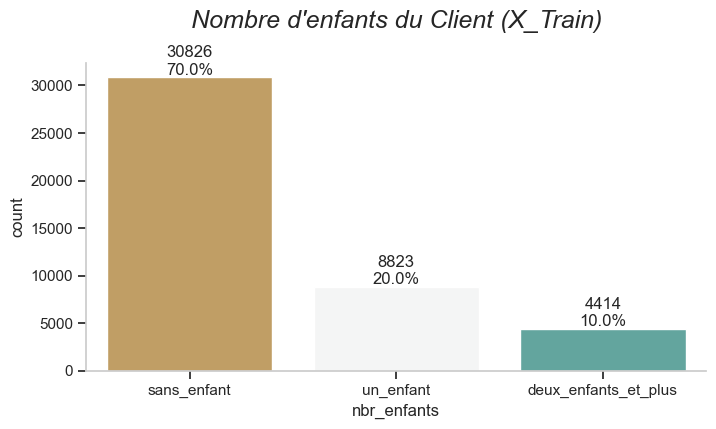

In [97]:
grah_barre(clean_X_train, 'nbr_enfants', 'BrBG', "Nombre d'enfants du Client (X_Train)\n", (8, 4))

In [98]:
#Suppression de la variable CNT_CHILDREN

clean_X_train.drop(labels='CNT_CHILDREN', axis=1, inplace=True)

In [99]:
# Transformation de la variable numérique 'CNT_CHILDREN' en variable qualitative de l'ensemble de test

clean_X_test['nbr_enfants'] = clean_X_test['CNT_CHILDREN'] 

clean_X_test['nbr_enfants'] = np.where(clean_X_test['CNT_CHILDREN'] == 0, 'sans_enfant', clean_X_test['nbr_enfants'])

clean_X_test['nbr_enfants'] = np.where(clean_X_test['CNT_CHILDREN'] == 1, 'un_enfant', clean_X_test['nbr_enfants'])

clean_X_test['nbr_enfants'] = np.where(clean_X_test['CNT_CHILDREN'] >= 2, 'deux_enfants_et_plus', clean_X_test['nbr_enfants'])

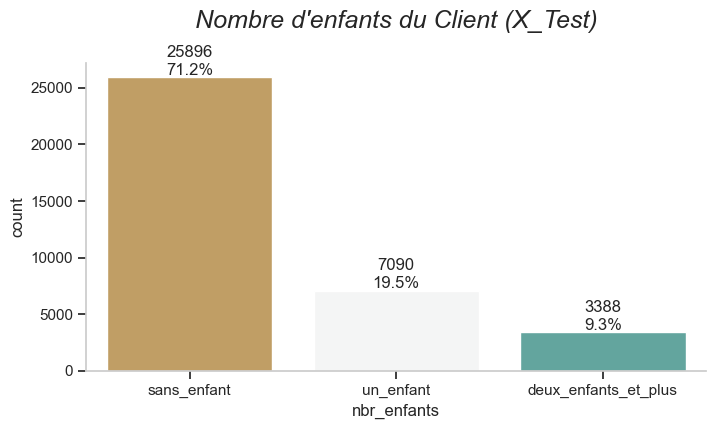

In [100]:
grah_barre(clean_X_test, 'nbr_enfants', 'BrBG', "Nombre d'enfants du Client (X_Test)\n", (8, 4))

In [101]:
clean_X_test.drop(labels='CNT_CHILDREN', axis=1, inplace=True)

#### Nombre de personnes dans la famille

In [102]:
clean_X_train['CNT_FAM_MEMBERS'].value_counts()

CNT_FAM_MEMBERS
2.00     22779
1.00      9587
3.00      7588
4.00      3505
5.00       525
6.00        58
7.00        11
8.00         5
9.00         2
10.00        2
13.00        1
Name: count, dtype: int64

In [103]:
# Transformation de la variable numérique 'CNT_CHILDREN' en variable qualitative de l'ensemble d'entraînement

clean_X_train['taille_famille'] = clean_X_train['CNT_FAM_MEMBERS'] 

clean_X_train['taille_famille'] = np.where(clean_X_train['CNT_FAM_MEMBERS'] == 1, '1_personne', clean_X_train['taille_famille'])

clean_X_train['taille_famille'] = np.where(clean_X_train['CNT_FAM_MEMBERS'] == 2, '2_personnes', clean_X_train['taille_famille'])

clean_X_train['taille_famille'] = np.where(clean_X_train['CNT_FAM_MEMBERS'] == 3, '3_personnes', clean_X_train['taille_famille'])

clean_X_train['taille_famille'] = np.where(clean_X_train['CNT_FAM_MEMBERS'] >= 4, '4_personnes_et_plus', clean_X_train['taille_famille'])

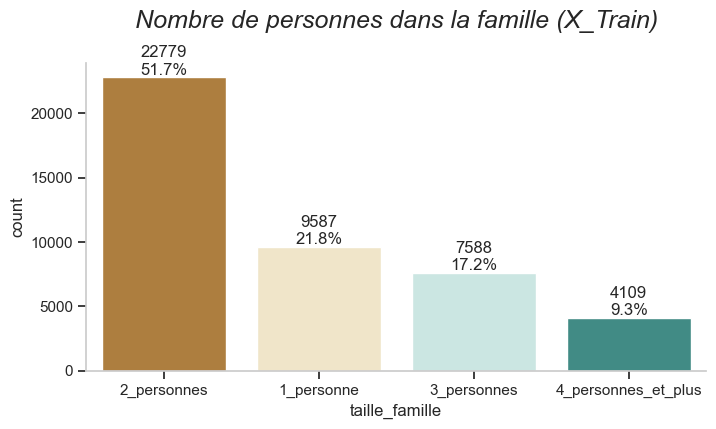

In [104]:
grah_barre(clean_X_train, 'taille_famille', 'BrBG', "Nombre de personnes dans la famille (X_Train)\n", (8, 4))

In [105]:
#Suppression de la variable CNT_FAM_MEMBERS

clean_X_train.drop(labels='CNT_FAM_MEMBERS', axis=1, inplace=True)

In [106]:
clean_X_test['CNT_FAM_MEMBERS'].value_counts()

CNT_FAM_MEMBERS
2.00     19461
1.00      7639
3.00      6104
4.00      2754
5.00       365
6.00        35
7.00        10
8.00         2
10.00        1
9.00         1
21.00        1
13.00        1
Name: count, dtype: int64

In [107]:
# Transformation de la variable numérique 'CNT_FAM_MEMBERS' en variable qualitative de l'ensemble de test

clean_X_test['taille_famille'] = clean_X_test['CNT_FAM_MEMBERS'] 

clean_X_test['taille_famille'] = np.where(clean_X_test['CNT_FAM_MEMBERS'] == 1, '1_personne', clean_X_test['taille_famille'])

clean_X_test['taille_famille'] = np.where(clean_X_test['CNT_FAM_MEMBERS'] == 2, '2_personnes', clean_X_test['taille_famille'])

clean_X_test['taille_famille'] = np.where(clean_X_test['CNT_FAM_MEMBERS'] == 3, '3_personnes', clean_X_test['taille_famille'])

clean_X_test['taille_famille'] = np.where(clean_X_test['CNT_FAM_MEMBERS'] >= 4, '4_personnes_et_plus', clean_X_test['taille_famille'])

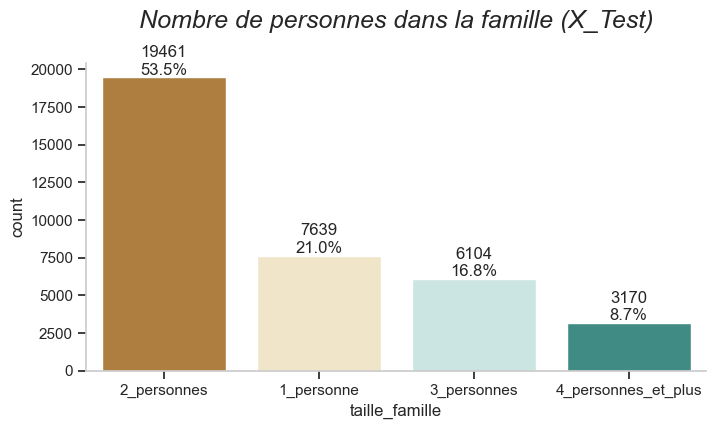

In [108]:
grah_barre(clean_X_test, 'taille_famille', 'BrBG', "Nombre de personnes dans la famille (X_Test)\n", (8, 4))

In [109]:
#Suppression de la variable CNT_FAM_MEMBERS

clean_X_test.drop(labels='CNT_FAM_MEMBERS', axis=1, inplace=True)

#### Les adresses des Clients

In [110]:
# transformation des variables numériques dichotomiques en variables qualitatives

liste1 = ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']

flag_map = {1 : "adresse_differente",
            0 : "adresse_identique"}

for var in liste1:
    clean_X_train[var] = clean_X_train[var].map(flag_map)

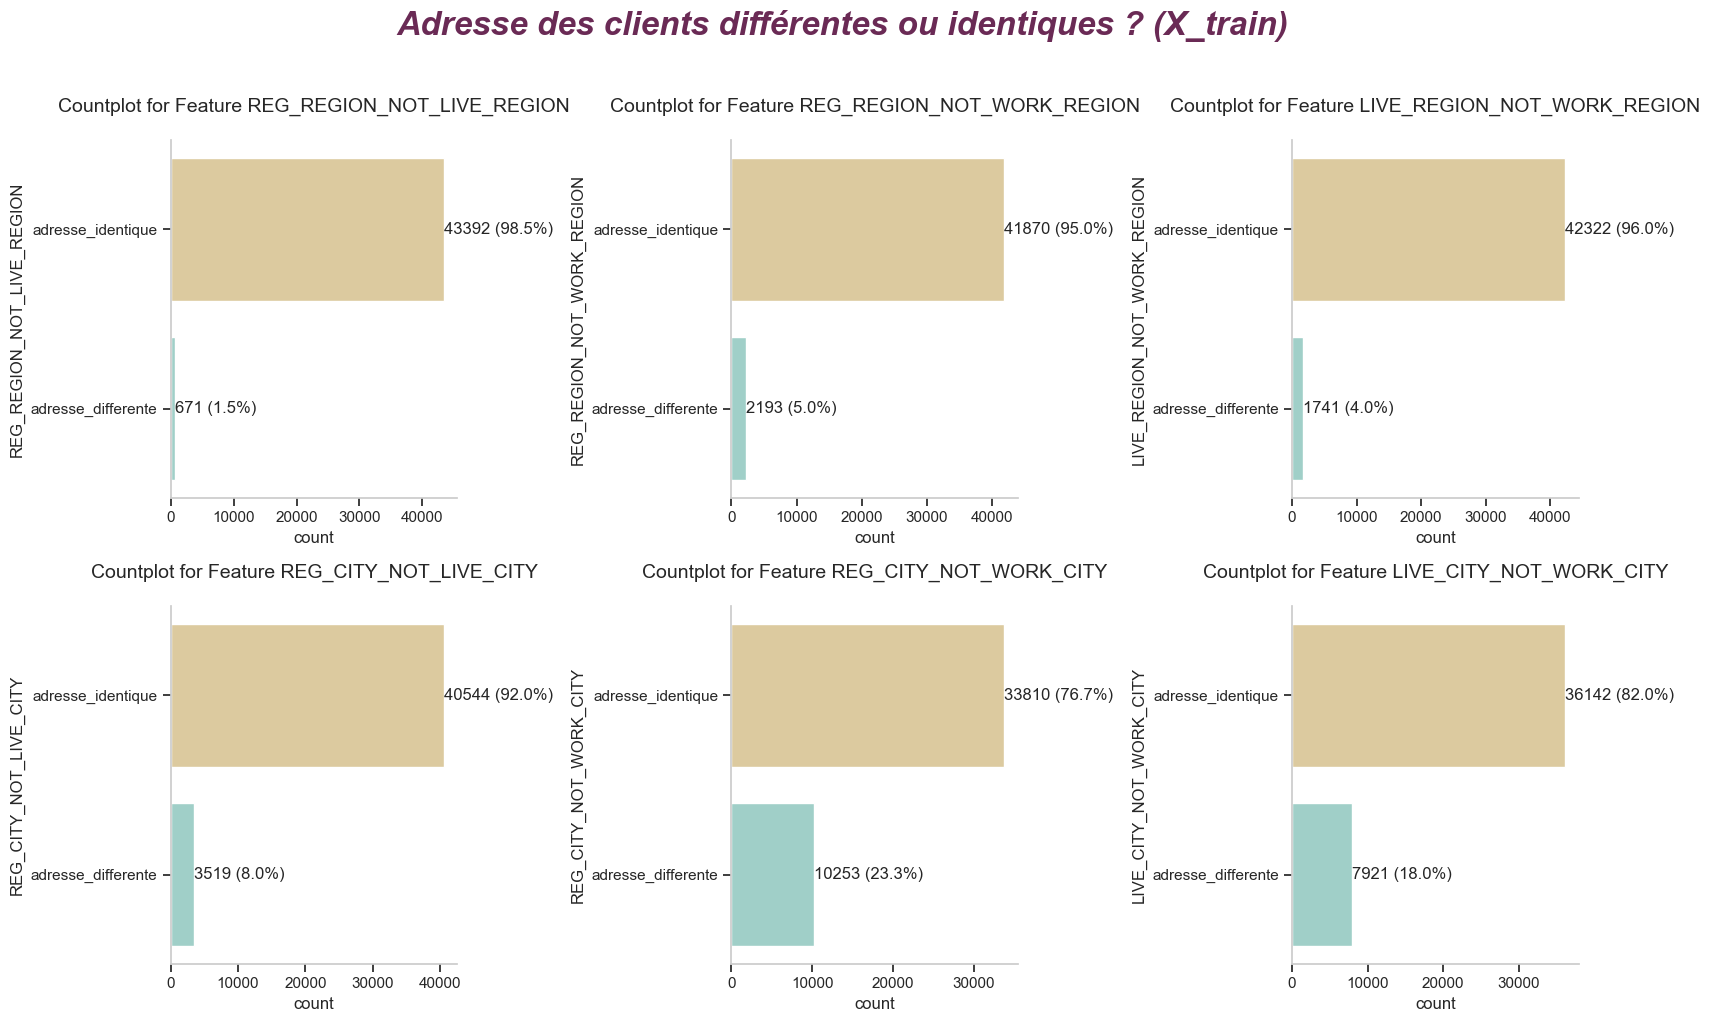

In [111]:
sns.set(style="ticks")

plot_multiple_countplots(df=clean_X_train,
                         n_cols=3,
                         col_list=liste1,
                         orient='h',
                         palette="BrBG",
                         size_labels=12,
                         size_title=14)

plt.suptitle("Adresse des clients différentes ou identiques ? (X_train)",
             y=1.02, fontsize=24, fontstyle='italic', fontweight='bold', color="#6a2a55")
plt.tight_layout()
plt.show()

In [112]:
# transformation des variables numériques dichotomiques en variables qualitatives

liste1 = ['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']

flag_map = {1 : "adresse_differente",
            0 : "adresse_identique"}

for var in liste1:
    clean_X_test[var] = clean_X_test[var].map(flag_map)

#### Téléphones et e-mail des clients

In [113]:
# transformation des variables numériques dichotomiques en variables qualitatives

liste2 = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL']

flag_map = {1 : "Oui",
            0 : "Non"}

for var in liste2:
    clean_X_train[var] = clean_X_train[var].map(flag_map)

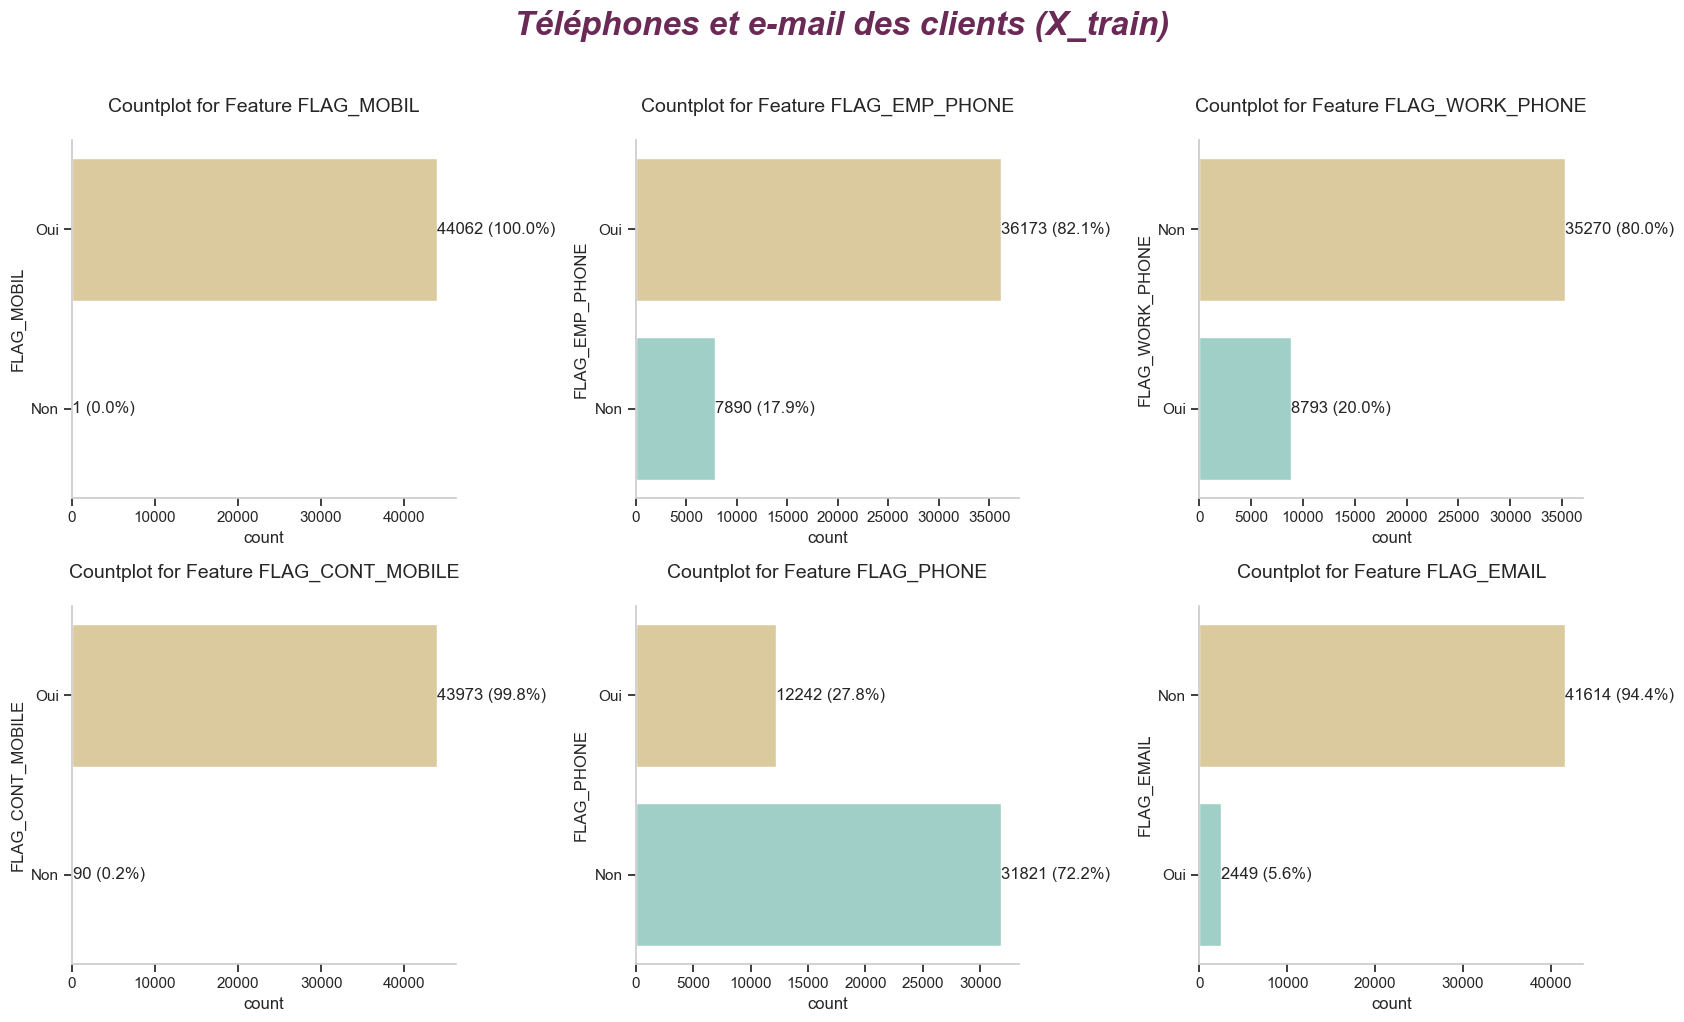

In [114]:
sns.set(style="ticks")

plot_multiple_countplots(df=clean_X_train,
                         n_cols=3,
                         col_list=liste2,
                         orient='h',
                         palette="BrBG",
                         size_labels=12,
                         size_title=14)

plt.suptitle("Téléphones et e-mail des clients (X_train)",
             y=1.02, fontsize=24, fontstyle='italic', fontweight='bold', color="#6a2a55")
plt.tight_layout()
plt.show()

In [115]:
# Suppression des variables 'FLAG_MOBIL' : Le client a-t-il fourni un téléphone portable ?
# et 'FLAG_CONT_MOBILE' : Le téléphone portable était-il joignable ?

clean_X_train.drop(labels=['FLAG_MOBIL', 'FLAG_CONT_MOBILE'], 
                   axis=1, inplace=True)

clean_X_test.drop(labels=['FLAG_MOBIL', 'FLAG_CONT_MOBILE'], 
                   axis=1, inplace=True)

In [116]:
# transformation des variables numériques dichotomiques en variables qualitatives de l'ensemble de test

liste2 = ['FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']

flag_map = {1 : "Oui",
            0 : "Non"}

for var in liste2:
    clean_X_test[var] = clean_X_test[var].map(flag_map)

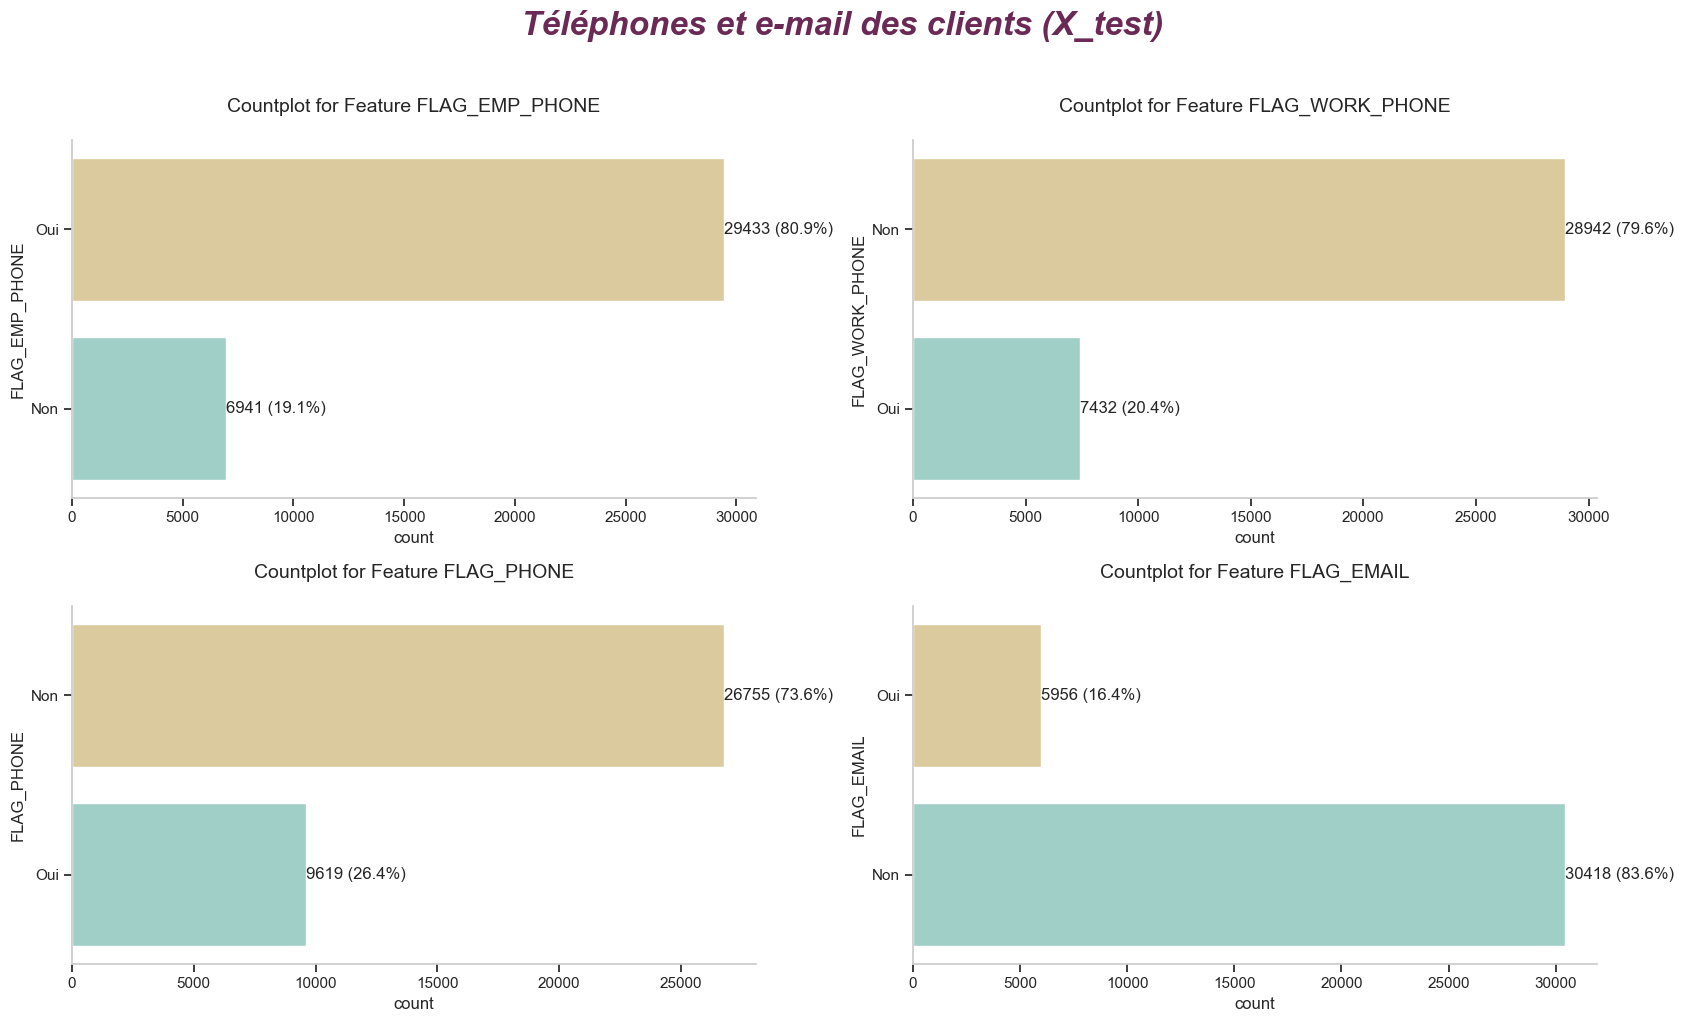

In [117]:
sns.set(style="ticks")

plot_multiple_countplots(df=clean_X_test,
                         n_cols=2,
                         col_list=liste2,
                         orient='h',
                         palette="BrBG",
                         size_labels=12,
                         size_title=14)

plt.suptitle("Téléphones et e-mail des clients (X_test)",
             y=1.02, fontsize=24, fontstyle='italic', fontweight='bold', color="#6a2a55")
plt.tight_layout()
plt.show()

#### Les documents fournis par les clients

In [118]:
liste3 = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 
          'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
          'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 
          'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

flag_map = {1 : "Oui",
            0 : "Non"}

for var in liste3:
    clean_X_train[var] = clean_X_train[var].map(flag_map)

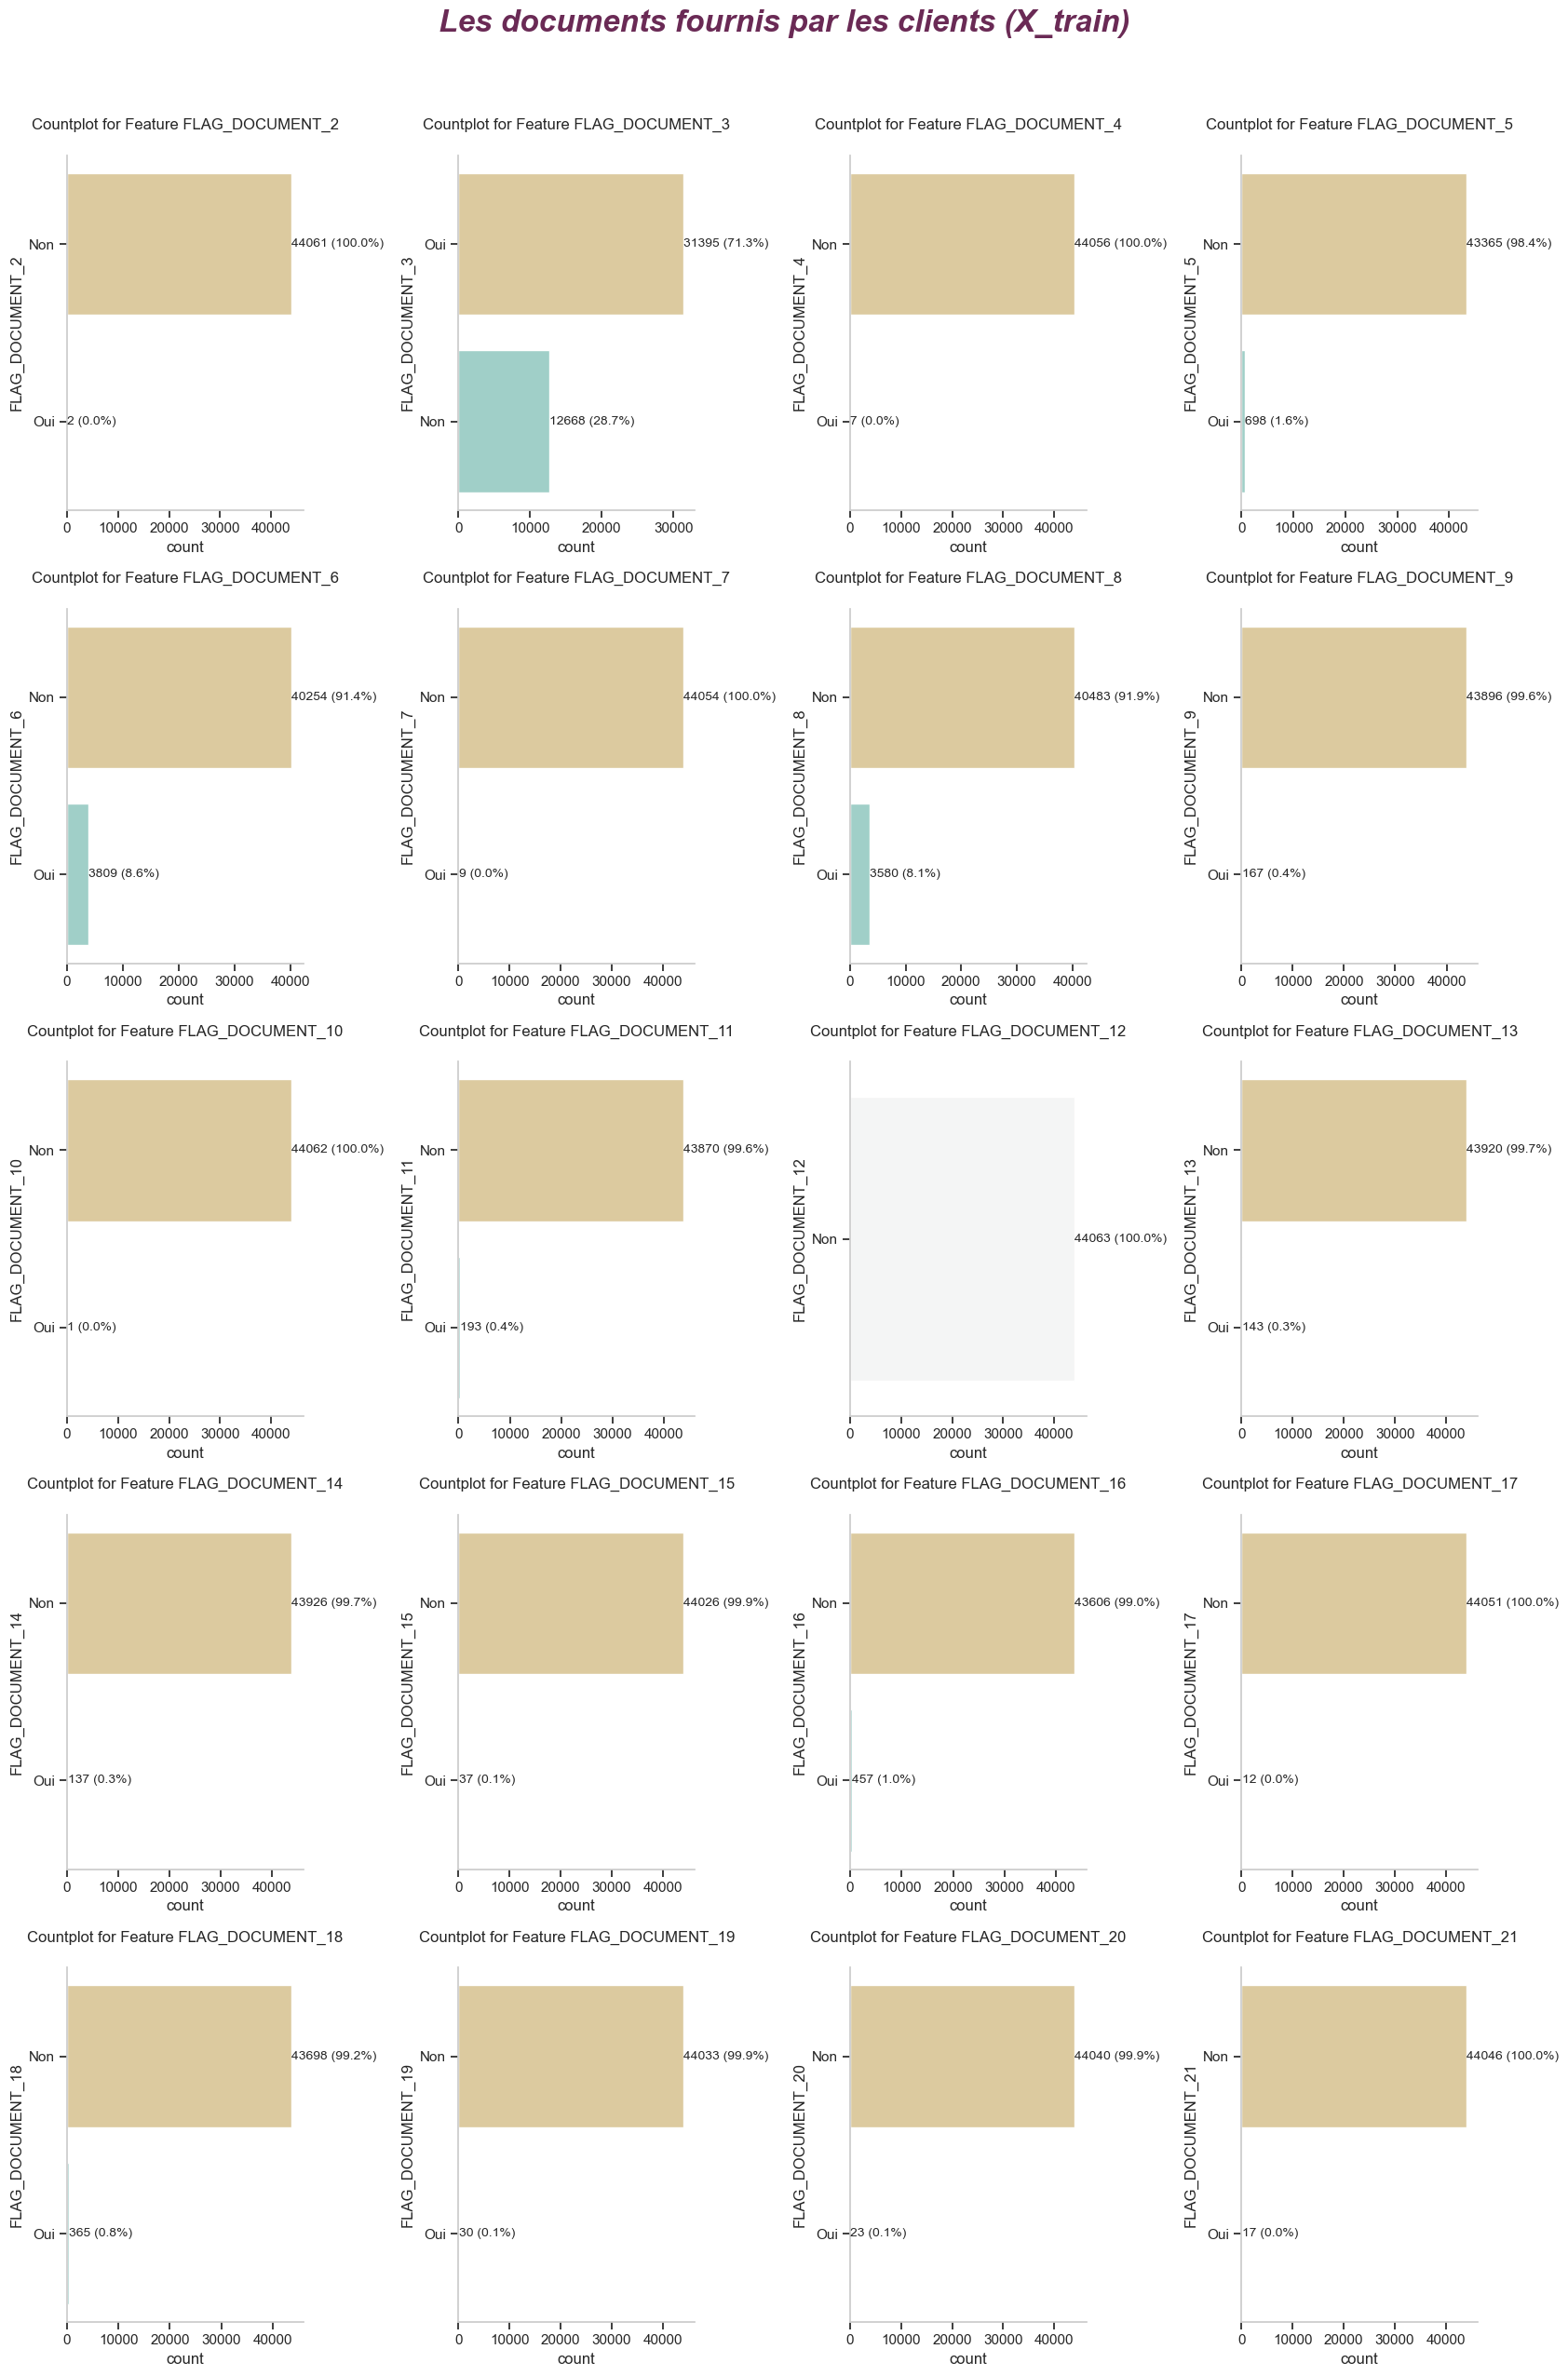

In [119]:
sns.set(style="ticks")

plot_multiple_countplots(df=clean_X_train,
                         n_cols=4,
                         col_list=liste3,
                         orient='h',
                         palette="BrBG",
                         size_labels=10,
                         size_title=12)

plt.suptitle("Les documents fournis par les clients (X_train)",
             y=1.02, fontsize=24, fontstyle='italic', fontweight='bold', color="#6a2a55")
plt.tight_layout()
plt.show()

In [120]:
# Conservation des variables FLAG_DOCUMENT_3, FLAG_DOCUMENT_6 et FLAG_DOCUMENT_8
# Suppression des autres variables non discriminantes

liste4 = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',  
          'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
          'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 
          'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

clean_X_train.drop(labels=liste4, 
                  axis=1, inplace=True)

In [121]:
# idem pour l'ensemble de test
flag_map = {1 : "Oui",
            0 : "Non"}

for var in liste3:
    clean_X_test[var] = clean_X_test[var].map(flag_map)

clean_X_test.drop(labels=liste4, 
                  axis=1, inplace=True)

In [122]:
print(clean_X_train.select_dtypes(include=[np.number]).columns.to_list())

['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']


In [123]:
print(clean_X_test.select_dtypes(include=[np.number]).columns.to_list())

['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']


####  Les évaluations de l'entreprise *Prêt à dépenser* de la région et de la ville où vit le client

In [124]:
liste5 = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']

flag_map = {1 : "Note_1",
            2 : "Note_2",
            3 : "Note_3"}

for var in liste5:
    clean_X_train[var] = clean_X_train[var].map(flag_map)

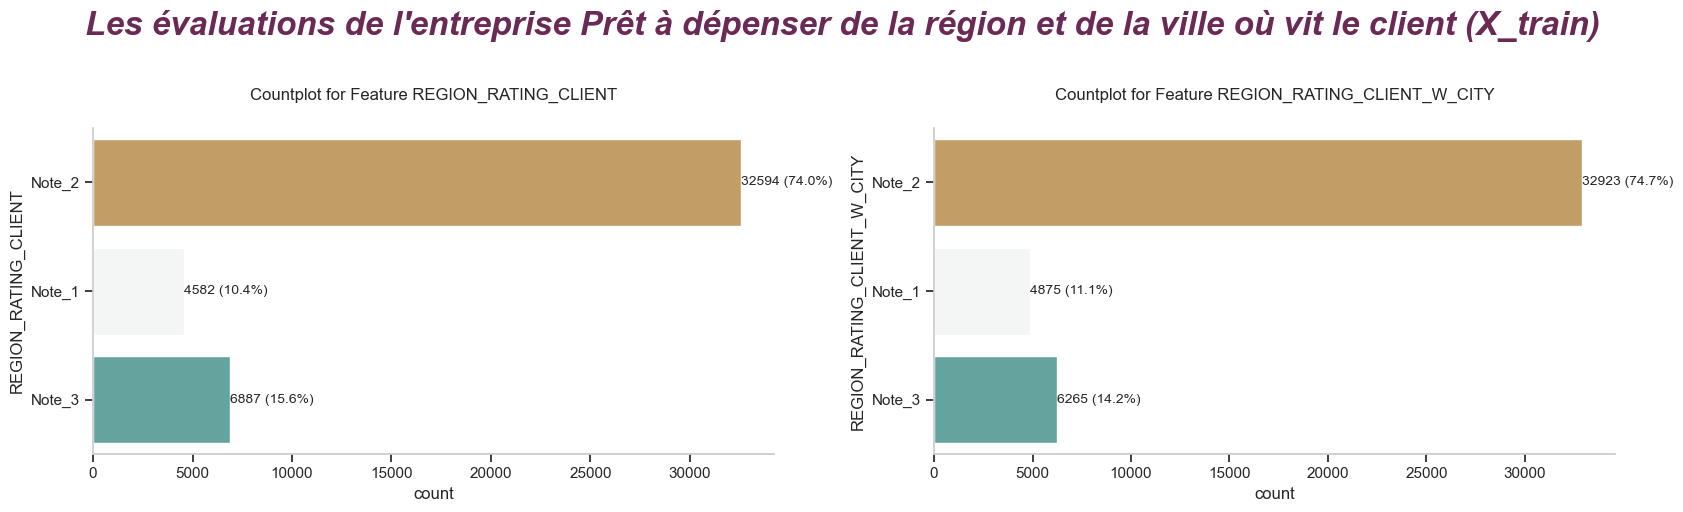

In [125]:
sns.set(style="ticks")

plot_multiple_countplots(df=clean_X_train,
                         n_cols=2,
                         col_list=liste5,
                         orient='h',
                         palette="BrBG",
                         size_labels=10,
                         size_title=12)

plt.suptitle("Les évaluations de l'entreprise Prêt à dépenser de la région et de la ville où vit le client (X_train)",
             y=1.02, fontsize=24, fontstyle='italic', fontweight='bold', color="#6a2a55")
plt.tight_layout()
plt.show()

In [126]:
for var in liste5:
    clean_X_test[var] = clean_X_test[var].map(flag_map)

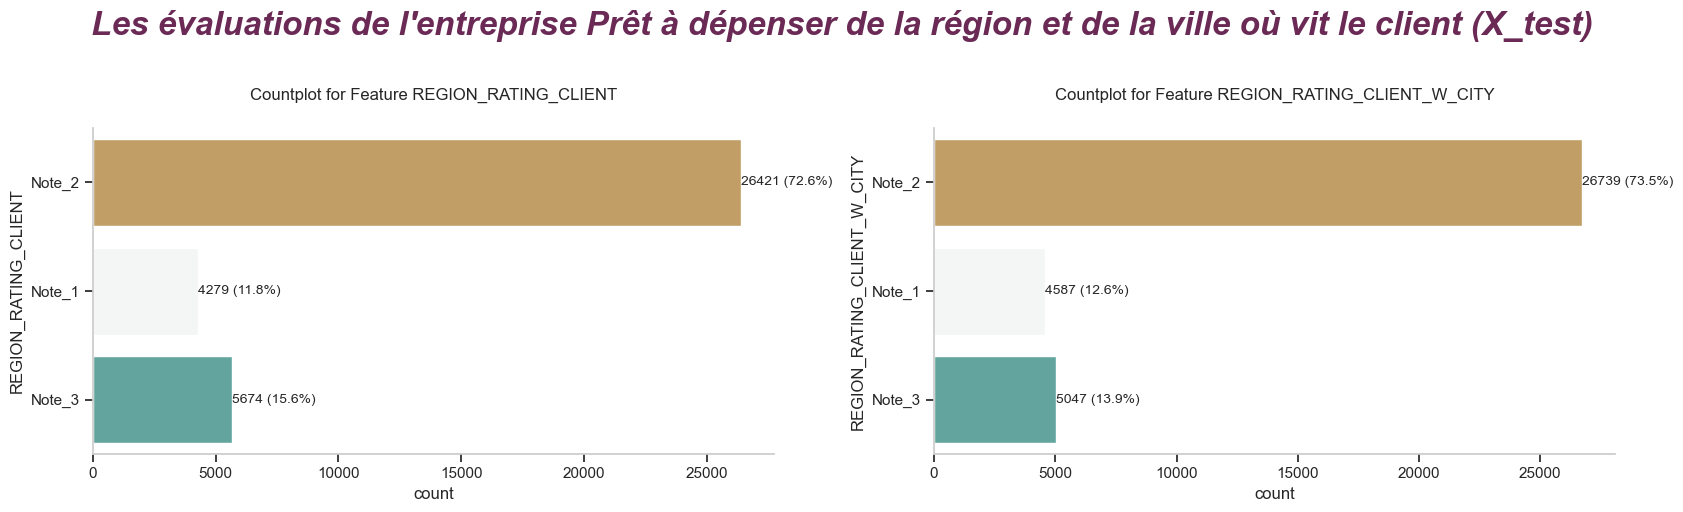

In [127]:
sns.set(style="ticks")

plot_multiple_countplots(df=clean_X_test,
                         n_cols=2,
                         col_list=liste5,
                         orient='h',
                         palette="BrBG",
                         size_labels=10,
                         size_title=12)

plt.suptitle("Les évaluations de l'entreprise Prêt à dépenser de la région et de la ville où vit le client (X_test)",
             y=1.02, fontsize=24, fontstyle='italic', fontweight='bold', color="#6a2a55")
plt.tight_layout()
plt.show()

#### Age du client lors de sa demande de prêt

In [128]:
# Calculé en jours depuis le jour de la demande (d'où le négatif) 
clean_X_train['DAYS_BIRTH'].describe()

count    44,063.00
mean    -16,031.66
std       4,359.36
min     -25,182.00
25%     -19,653.50
50%     -15,751.00
75%     -12,394.00
max      -7,680.00
Name: DAYS_BIRTH, dtype: float64

In [129]:
# Calcul de l'âge des clients
clean_X_train['DAYS_BIRTH'] = round(clean_X_train['DAYS_BIRTH'] / -365, 0)

In [130]:
clean_X_train['DAYS_BIRTH'].describe()

count   44,063.00
mean        43.92
std         11.95
min         21.00
25%         34.00
50%         43.00
75%         54.00
max         69.00
Name: DAYS_BIRTH, dtype: float64

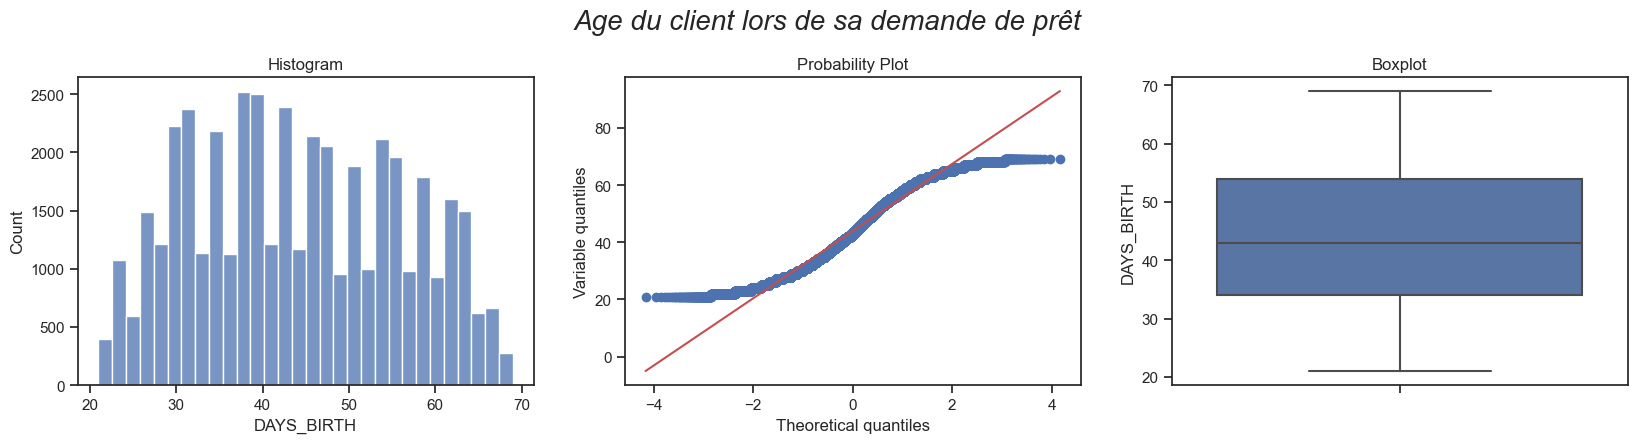

In [131]:
diagnostic_plots(clean_X_train, 'DAYS_BIRTH', "Age du client lors de sa demande de prêt")

Il n'y a pas de valeurs aberrantes dans la distribution des âges des clients, mais on peut clairement voir qu'elle ne suit une loi normale (queue de distibution à droite et à gauche). Elle a plutôt l'allure d'une courbe en S ou courbe sigmoïde (logistique).

Pour remédier à cette non normalité, nous allons découper cette distribution en 5 tranches d'âge d'effectifs à peu près égaux.

In [132]:
pd.qcut(clean_X_train.DAYS_BIRTH, q=5).head(7)

0    (20.999, 32.0]
1      (39.8, 47.0]
2      (47.0, 56.0]
3      (47.0, 56.0]
4      (47.0, 56.0]
5      (39.8, 47.0]
6      (32.0, 39.8]
Name: DAYS_BIRTH, dtype: category
Categories (5, interval[float64, right]): [(20.999, 32.0] < (32.0, 39.8] < (39.8, 47.0] < (47.0, 56.0] < (56.0, 69.0]]

In [133]:
clean_X_train['age_client'] = pd.qcut(clean_X_train.DAYS_BIRTH,
                                         q=5,
                                         labels=['32_ans_et_moins',
                                                 '33_a_39_ans',
                                                 '40_a_47_ans',
                                                 '48_a_56_ans',
                                                 '57_ans_et_plus'])

clean_X_train['age_client'].value_counts()

age_client
32_ans_et_moins    9357
40_a_47_ans        9167
48_a_56_ans        8929
57_ans_et_plus     8342
33_a_39_ans        8268
Name: count, dtype: int64

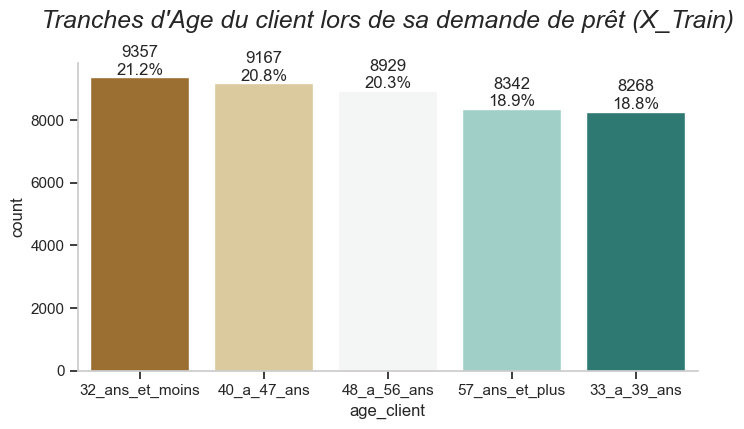

In [134]:
grah_barre(clean_X_train, 'age_client', 'BrBG', "Tranches d'Age du client lors de sa demande de prêt (X_Train)\n", (8, 4))

***Application à l'ensemble de Test***

In [135]:
# Calcul de l'âge des clients
clean_X_test['DAYS_BIRTH'] = round(clean_X_test['DAYS_BIRTH'] / -365, 0)

In [136]:
clean_X_test['age_client'] = pd.cut(clean_X_test.DAYS_BIRTH, 
                                    bins=[1,
                                          32,
                                          39,
                                          47,
                                          56,
                                          100],
                                    include_lowest=True,
                                    labels=['32_ans_et_moins',
                                            '33_a_39_ans',
                                            '40_a_47_ans',
                                            '48_a_56_ans',
                                            '57_ans_et_plus'])

clean_X_test['age_client'].value_counts()

age_client
40_a_47_ans        7661
32_ans_et_moins    7451
48_a_56_ans        7422
33_a_39_ans        6944
57_ans_et_plus     6896
Name: count, dtype: int64

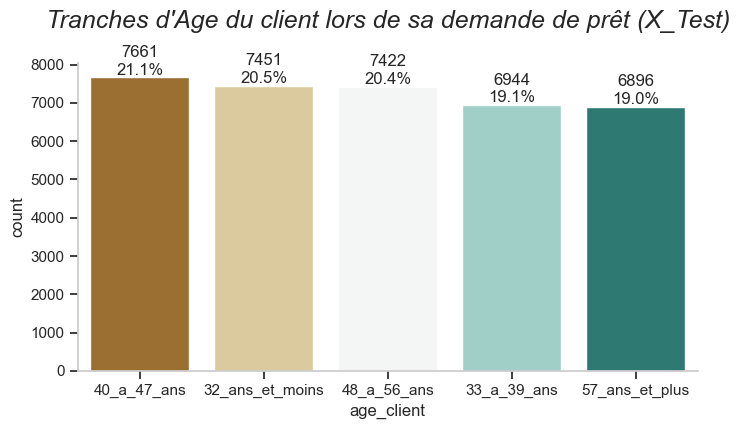

In [137]:
grah_barre(clean_X_test, 'age_client', 'BrBG', "Tranches d'Age du client lors de sa demande de prêt (X_Test)\n", (8, 4))

In [138]:
# Suppression de la variable DAYS_BIRTH dans X_Train et X_Test

clean_X_train.drop(labels='DAYS_BIRTH', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='DAYS_BIRTH', 
                  axis=1, inplace=True)

In [139]:
clean_X_train.shape, clean_X_test.shape

((44063, 44), (36374, 44))

In [140]:
print(clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number]).columns.to_list())

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']


In [141]:
clean_X_train.drop(labels='SK_ID_CURR', axis=1).describe().T

count       mean        std        min  \
AMT_INCOME_TOTAL           44,063.00 170,950.69 565,219.02  25,650.00   
AMT_CREDIT                 44,063.00 600,033.72 402,405.01  45,000.00   
AMT_ANNUITY                44,063.00  27,129.35  14,613.38   2,052.00   
AMT_GOODS_PRICE            44,063.00 539,145.76 369,631.10  45,000.00   
REGION_POPULATION_RELATIVE 44,063.00       0.02       0.01       0.00   
DAYS_EMPLOYED              44,063.00  63,409.58 140,961.75 -17,531.00   
DAYS_REGISTRATION          44,063.00  -4,974.05   3,517.34 -21,249.00   
DAYS_ID_PUBLISH            44,063.00  -2,993.43   1,510.05  -6,228.00   
HOUR_APPR_PROCESS_START    44,063.00      12.06       3.25       0.00   
EXT_SOURCE_2               44,063.00       0.51       0.19       0.00   
OBS_30_CNT_SOCIAL_CIRCLE   44,063.00       1.42       2.31       0.00   
DEF_30_CNT_SOCIAL_CIRCLE   44,063.00       0.14       0.44       0.00   
OBS_60_CNT_SOCIAL_CIRCLE   44,063.00       1.40       2.29       0.00   
DEF_60_CNT_SOCIAL_CIRCLE   44,063.00       0.10       0.36       0.00   
DAYS_LAST_PHONE_CHANGE     44,063.00    -966.05     830.05  -4,002.00   

                                  25%        50%        75%            max  
AMT_INCOME_TOTAL           112,500.00 144,000.00 202,500.00 117,000,000.00  
AMT_CREDIT                 270,000.00 517,500.00 808,650.00   4,050,000.00  
AMT_ANNUITY                 16,488.00  24,939.00  34,596.00     258,025.50  
AMT_GOODS_PRICE            238,500.00 450,000.00 679,500.00   4,050,000.00  
REGION_POPULATION_RELATIVE       0.01       0.02       0.03           0.07  
DAYS_EMPLOYED               -2,795.00  -1,222.00    -291.00     365,243.00  
DAYS_REGISTRATION           -7,455.50  -4,482.00  -2,007.00           0.00  
DAYS_ID_PUBLISH             -4,296.00  -3,256.00  -1,720.00           0.00  
HOUR_APPR_PROCESS_START         10.00      12.00      14.00          23.00  
EXT_SOURCE_2                     0.39       0.57       0.66           0.85  
OBS_30_CNT_SOCIAL_CIRCLE         0.00       0.00       2.00          28.00  
DEF_30_CNT_SOCIAL_CIRCLE         0.00       0.00       0.00           6.00  
OBS_60_CNT_SOCIAL_CIRCLE         0.00       0.00       2.00          28.00  
DEF_60_CNT_SOCIAL_CIRCLE         0.00       0.00       0.00           5.00  
DAYS_LAST_PHONE_CHANGE      -1,574.00    -758.00    -271.00           0.00

#### Depuis combien d'années le client est-il employé dans son entreprise actuelle ?

In [142]:
# Calcul du nombre d'années' (même principe que pour l'âge)
clean_X_train['DAYS_EMPLOYED'] = round(clean_X_train['DAYS_EMPLOYED'] / -365, 0)

In [143]:
clean_X_train['DAYS_EMPLOYED'].describe()

count   44,063.00
mean      -173.78
std        386.32
min     -1,001.00
25%          1.00
50%          3.00
75%          8.00
max         48.00
Name: DAYS_EMPLOYED, dtype: float64

In [144]:
clean_X_train[clean_X_train['DAYS_EMPLOYED'] < 0].shape

(7888, 44)

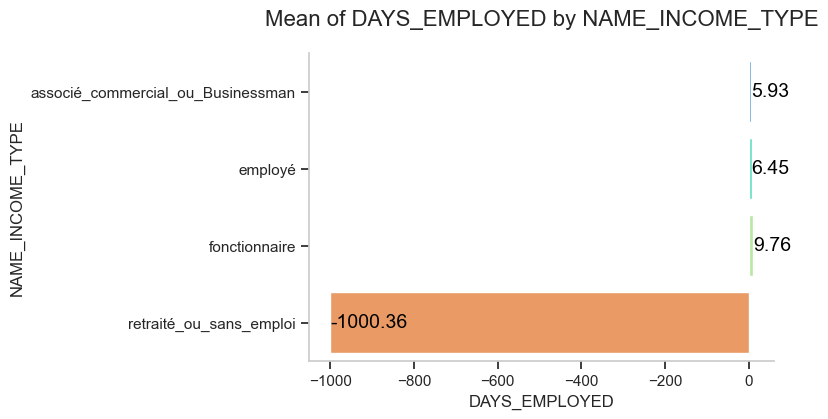

In [145]:
# par NAME_INCOME_TYPE = type de revenus

plot_aggregation(df=clean_X_train,
                 group_col='NAME_INCOME_TYPE',
                 value_col='DAYS_EMPLOYED',
                 aggreg='mean',
                 orient='h',
                 figsize=(6, 4))

Nous allons donc construire une variable qualitative prenant en compte les retraités et les chômeurs puisqu'ils ne travaillent plus dans une entreprise.

In [146]:
# Suppression temporaire des clients retraités et chômeurs pour calculer l'ancienneté des clients

modalite_to_drop = ['retraité_ou_sans_emploi']

temp_X_train = clean_X_train.loc[~clean_X_train['NAME_INCOME_TYPE'].isin(modalite_to_drop), :]
temp_X_train.shape

(36170, 44)

In [147]:
print(f"Il y a donc {len(clean_X_train) - (len(temp_X_train))} retraités ou sans emploi dans l'ensemble d'entraînement.")
print(f"Les retraités et les chômeurs représentent donc {(len(clean_X_train) - (len(temp_X_train))) / len(clean_X_train) * 100: .1f}% des demandeurs de crédit.")

Il y a donc 7893 retraités ou sans emploi dans l'ensemble d'entraînement.
Les retraités et les chômeurs représentent donc  17.9% des demandeurs de crédit.


In [148]:
#Calcul des tranches d'ancienneté

pd.qcut(temp_X_train.DAYS_EMPLOYED, q=4).head(7)

0    (-0.001, 2.0]
1       (2.0, 5.0]
2    (-0.001, 2.0]
3       (5.0, 9.0]
4       (5.0, 9.0]
5       (2.0, 5.0]
6       (5.0, 9.0]
Name: DAYS_EMPLOYED, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 2.0] < (2.0, 5.0] < (5.0, 9.0] < (9.0, 48.0]]

In [149]:
clean_X_train['anciennete_entreprise'] = clean_X_train['DAYS_EMPLOYED'] 

clean_X_train['anciennete_entreprise'] = np.where(clean_X_train['DAYS_EMPLOYED'] <= 2, 
                                                  '2_ans_et_moins', clean_X_train['anciennete_entreprise'])

clean_X_train['anciennete_entreprise'] = np.where((clean_X_train['DAYS_EMPLOYED'] > 2) & (clean_X_train['DAYS_EMPLOYED'] <= 5), 
                                                  '3_a_5_ans', clean_X_train['anciennete_entreprise'])

clean_X_train['anciennete_entreprise'] = np.where((clean_X_train['DAYS_EMPLOYED'] > 5) & (clean_X_train['DAYS_EMPLOYED'] <= 9), 
                                                  '6_a_9_ans', clean_X_train['anciennete_entreprise'])

clean_X_train['anciennete_entreprise'] = np.where(clean_X_train['DAYS_EMPLOYED'] > 9, 
                                                  '10_ans_et_plus', clean_X_train['anciennete_entreprise'])

clean_X_train['anciennete_entreprise'] = np.where(clean_X_train['NAME_INCOME_TYPE'].isin(modalite_to_drop), 
                                                  'retraité_ou_sans_emploi', clean_X_train['anciennete_entreprise'])


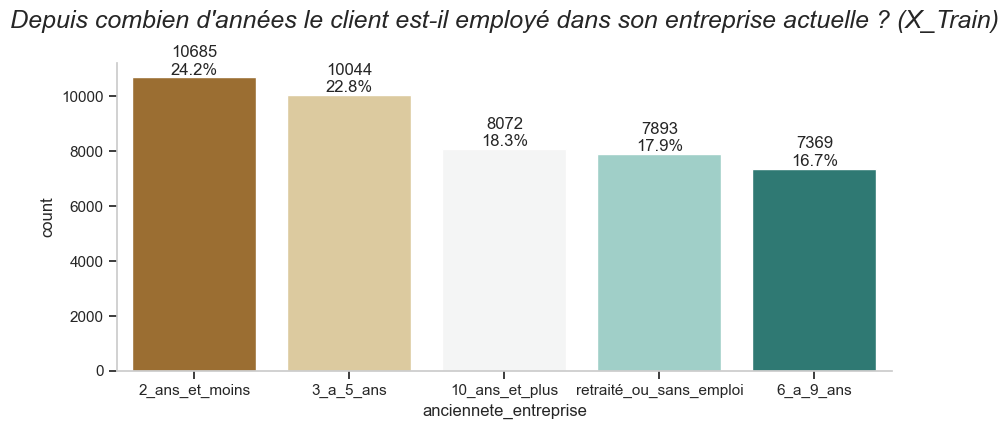

In [150]:
grah_barre(clean_X_train, 'anciennete_entreprise', 'BrBG', "Depuis combien d'années le client est-il employé dans son entreprise actuelle ? (X_Train)\n", (10, 4))

***Application à l'ensemble de Test***

In [151]:
# Calcul du nombre de mois (même principe que pour l'âge)
clean_X_test['DAYS_EMPLOYED'] = round(clean_X_test['DAYS_EMPLOYED'] / -365, 0)

clean_X_test['DAYS_EMPLOYED'].describe()

count   36,374.00
mean      -185.50
std        396.03
min     -1,001.00
25%          1.00
50%          4.00
75%          8.00
max         48.00
Name: DAYS_EMPLOYED, dtype: float64

In [152]:
clean_X_test['anciennete_entreprise'] = clean_X_test['DAYS_EMPLOYED'] 

clean_X_test['anciennete_entreprise'] = np.where(clean_X_test['DAYS_EMPLOYED'] <= 2, 
                                                  '2_ans_et_moins', clean_X_test['anciennete_entreprise'])

clean_X_test['anciennete_entreprise'] = np.where((clean_X_test['DAYS_EMPLOYED'] > 2) & (clean_X_test['DAYS_EMPLOYED'] <= 5), 
                                                  '3_a_5_ans', clean_X_test['anciennete_entreprise'])

clean_X_test['anciennete_entreprise'] = np.where((clean_X_test['DAYS_EMPLOYED'] > 5) & (clean_X_test['DAYS_EMPLOYED'] <= 9), 
                                                  '6_a_9_ans', clean_X_test['anciennete_entreprise'])

clean_X_test['anciennete_entreprise'] = np.where(clean_X_test['DAYS_EMPLOYED'] > 9, 
                                                  '10_ans_et_plus', clean_X_test['anciennete_entreprise'])

clean_X_test['anciennete_entreprise'] = np.where(clean_X_test['NAME_INCOME_TYPE'].isin(modalite_to_drop), 
                                                  'retraité_ou_sans_emploi', clean_X_test['anciennete_entreprise'])

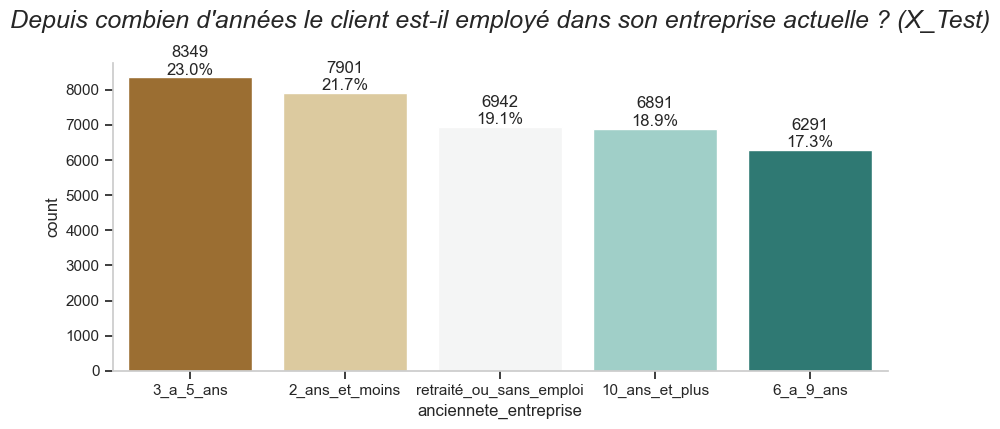

In [153]:
grah_barre(clean_X_test, 'anciennete_entreprise', 'BrBG', "Depuis combien d'années le client est-il employé dans son entreprise actuelle ? (X_Test)\n", (10, 4))

In [154]:
# Suppression de la variable DAYS_EMPLOYED dans X_Train et X_Test

clean_X_train.drop(labels='DAYS_EMPLOYED', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='DAYS_EMPLOYED', 
                  axis=1, inplace=True)

In [155]:
clean_X_train.shape, clean_X_test.shape

((44063, 44), (36374, 44))

In [156]:
print(clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number]).columns.to_list())

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']


In [157]:
clean_X_train.drop(labels='SK_ID_CURR', axis=1).describe().T

count       mean        std        min  \
AMT_INCOME_TOTAL           44,063.00 170,950.69 565,219.02  25,650.00   
AMT_CREDIT                 44,063.00 600,033.72 402,405.01  45,000.00   
AMT_ANNUITY                44,063.00  27,129.35  14,613.38   2,052.00   
AMT_GOODS_PRICE            44,063.00 539,145.76 369,631.10  45,000.00   
REGION_POPULATION_RELATIVE 44,063.00       0.02       0.01       0.00   
DAYS_REGISTRATION          44,063.00  -4,974.05   3,517.34 -21,249.00   
DAYS_ID_PUBLISH            44,063.00  -2,993.43   1,510.05  -6,228.00   
HOUR_APPR_PROCESS_START    44,063.00      12.06       3.25       0.00   
EXT_SOURCE_2               44,063.00       0.51       0.19       0.00   
OBS_30_CNT_SOCIAL_CIRCLE   44,063.00       1.42       2.31       0.00   
DEF_30_CNT_SOCIAL_CIRCLE   44,063.00       0.14       0.44       0.00   
OBS_60_CNT_SOCIAL_CIRCLE   44,063.00       1.40       2.29       0.00   
DEF_60_CNT_SOCIAL_CIRCLE   44,063.00       0.10       0.36       0.00   
DAYS_LAST_PHONE_CHANGE     44,063.00    -966.05     830.05  -4,002.00   

                                  25%        50%        75%            max  
AMT_INCOME_TOTAL           112,500.00 144,000.00 202,500.00 117,000,000.00  
AMT_CREDIT                 270,000.00 517,500.00 808,650.00   4,050,000.00  
AMT_ANNUITY                 16,488.00  24,939.00  34,596.00     258,025.50  
AMT_GOODS_PRICE            238,500.00 450,000.00 679,500.00   4,050,000.00  
REGION_POPULATION_RELATIVE       0.01       0.02       0.03           0.07  
DAYS_REGISTRATION           -7,455.50  -4,482.00  -2,007.00           0.00  
DAYS_ID_PUBLISH             -4,296.00  -3,256.00  -1,720.00           0.00  
HOUR_APPR_PROCESS_START         10.00      12.00      14.00          23.00  
EXT_SOURCE_2                     0.39       0.57       0.66           0.85  
OBS_30_CNT_SOCIAL_CIRCLE         0.00       0.00       2.00          28.00  
DEF_30_CNT_SOCIAL_CIRCLE         0.00       0.00       0.00           6.00  
OBS_60_CNT_SOCIAL_CIRCLE         0.00       0.00       2.00          28.00  
DEF_60_CNT_SOCIAL_CIRCLE         0.00       0.00       0.00           5.00  
DAYS_LAST_PHONE_CHANGE      -1,574.00    -758.00    -271.00           0.00

#### Ancienneté de la pièce d'identité avec laquelle le client a demandé le prêt.

In [158]:
# Calculé en jours depuis le jour de la demande (d'où le négatif) 
clean_X_train['DAYS_ID_PUBLISH'].describe()

count   44,063.00
mean    -2,993.43
std      1,510.05
min     -6,228.00
25%     -4,296.00
50%     -3,256.00
75%     -1,720.00
max          0.00
Name: DAYS_ID_PUBLISH, dtype: float64

In [159]:
# Calcul du nombre d'années' (même principe que pour l'âge)
clean_X_train['DAYS_ID_PUBLISH'] = round(clean_X_train['DAYS_ID_PUBLISH'] / -365, 0)

clean_X_train['DAYS_ID_PUBLISH'].describe()

count   44,063.00
mean         8.20
std          4.15
min          0.00
25%          5.00
50%          9.00
75%         12.00
max         17.00
Name: DAYS_ID_PUBLISH, dtype: float64

In [ ]:
diagnostic_plots(clean_X_train, 'DAYS_ID_PUBLISH', "Ancienneté de la pièce d'identité avec laquelle le client a demandé le prêt")

Comme pour l'âge des clients, il n'y a pas de valeurs aberrantes dans la distribution de l'ancienneté de leur pièce d'identité, mais on peut clairement voir qu'elle ne suit une loi normale (queue de distibution à droite et à gauche). Elle a plutôt l'allure d'une courbe en S ou courbe sigmoïde (logistique).

Pour remédier à cette non normalité, nous allons découper cette distribution en 4 tranches d'ancienneté d'effectifs à peu près égaux.

In [160]:
pd.qcut(clean_X_train.DAYS_ID_PUBLISH, q=4).head(7)

0       (5.0, 9.0]
1    (-0.001, 5.0]
2       (5.0, 9.0]
3       (5.0, 9.0]
4       (5.0, 9.0]
5    (-0.001, 5.0]
6    (-0.001, 5.0]
Name: DAYS_ID_PUBLISH, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 5.0] < (5.0, 9.0] < (9.0, 12.0] < (12.0, 17.0]]

In [161]:
clean_X_train['anciennete_cni'] = pd.qcut(clean_X_train.DAYS_ID_PUBLISH,
                                          q=4,
                                          labels=['5_ans_et_moins',
                                                  '6_a_9_ans',
                                                  '10_a_12_ans',
                                                  '13_ans_et_plus'])

clean_X_train['anciennete_cni'].value_counts()

anciennete_cni
10_a_12_ans       13782
5_ans_et_moins    13025
6_a_9_ans         10596
13_ans_et_plus     6660
Name: count, dtype: int64

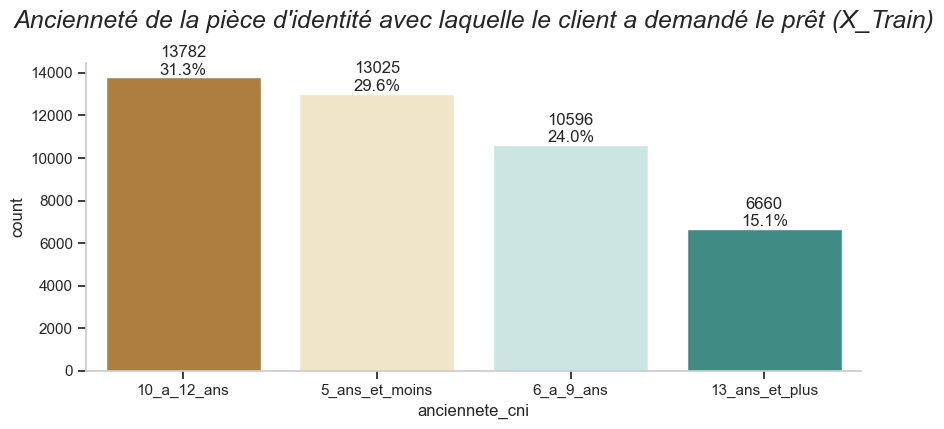

In [162]:
grah_barre(clean_X_train, 'anciennete_cni', 'BrBG', "Ancienneté de la pièce d'identité avec laquelle le client a demandé le prêt (X_Train)\n", (10, 4))

***Application à l'ensemble de Test***

In [163]:
# Calcul de l'ancienneté de la cni
clean_X_test['DAYS_ID_PUBLISH'] = round(clean_X_test['DAYS_ID_PUBLISH'] / -365, 0)

In [164]:
clean_X_test['anciennete_cni'] = pd.cut(clean_X_test.DAYS_ID_PUBLISH, 
                                        bins=[-1,
                                              5,
                                              9,
                                              12,
                                              100],
                                        include_lowest=True,
                                        labels=['5_ans_et_moins',
                                                '6_a_9_ans',
                                                '10_a_12_ans',
                                                '13_ans_et_plus'])

clean_X_test['anciennete_cni'].value_counts()

anciennete_cni
5_ans_et_moins    10733
10_a_12_ans        9327
6_a_9_ans          8738
13_ans_et_plus     7576
Name: count, dtype: int64

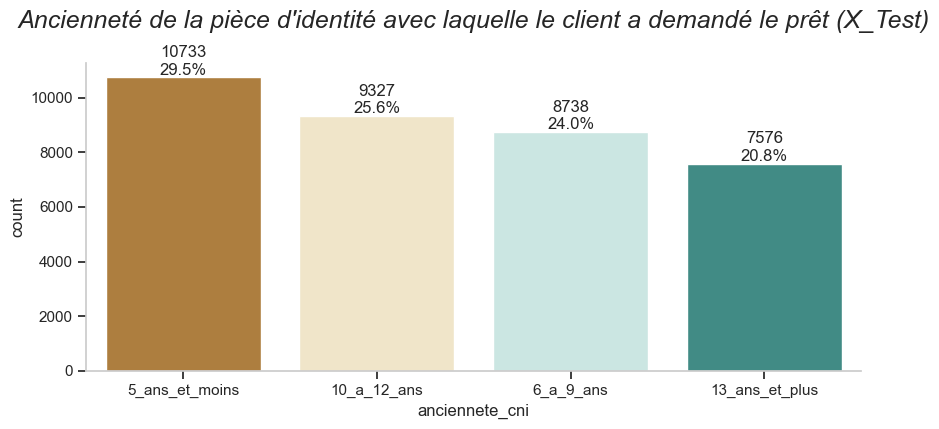

In [165]:
grah_barre(clean_X_test, 'anciennete_cni', 'BrBG', "Ancienneté de la pièce d'identité avec laquelle le client a demandé le prêt (X_Test)\n", (10, 4))

In [166]:
# Suppression de la variable DAYS_ID_PUBLISH dans X_Train et X_Test

clean_X_train.drop(labels='DAYS_ID_PUBLISH', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='DAYS_ID_PUBLISH', 
                  axis=1, inplace=True)

In [167]:
clean_X_train.shape, clean_X_test.shape

((44063, 44), (36374, 44))

In [168]:
print(clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number]).columns.to_list())

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']


In [169]:
clean_X_train.drop(labels='SK_ID_CURR', axis=1).describe().T

count       mean        std        min  \
AMT_INCOME_TOTAL           44,063.00 170,950.69 565,219.02  25,650.00   
AMT_CREDIT                 44,063.00 600,033.72 402,405.01  45,000.00   
AMT_ANNUITY                44,063.00  27,129.35  14,613.38   2,052.00   
AMT_GOODS_PRICE            44,063.00 539,145.76 369,631.10  45,000.00   
REGION_POPULATION_RELATIVE 44,063.00       0.02       0.01       0.00   
DAYS_REGISTRATION          44,063.00  -4,974.05   3,517.34 -21,249.00   
HOUR_APPR_PROCESS_START    44,063.00      12.06       3.25       0.00   
EXT_SOURCE_2               44,063.00       0.51       0.19       0.00   
OBS_30_CNT_SOCIAL_CIRCLE   44,063.00       1.42       2.31       0.00   
DEF_30_CNT_SOCIAL_CIRCLE   44,063.00       0.14       0.44       0.00   
OBS_60_CNT_SOCIAL_CIRCLE   44,063.00       1.40       2.29       0.00   
DEF_60_CNT_SOCIAL_CIRCLE   44,063.00       0.10       0.36       0.00   
DAYS_LAST_PHONE_CHANGE     44,063.00    -966.05     830.05  -4,002.00   

                                  25%        50%        75%            max  
AMT_INCOME_TOTAL           112,500.00 144,000.00 202,500.00 117,000,000.00  
AMT_CREDIT                 270,000.00 517,500.00 808,650.00   4,050,000.00  
AMT_ANNUITY                 16,488.00  24,939.00  34,596.00     258,025.50  
AMT_GOODS_PRICE            238,500.00 450,000.00 679,500.00   4,050,000.00  
REGION_POPULATION_RELATIVE       0.01       0.02       0.03           0.07  
DAYS_REGISTRATION           -7,455.50  -4,482.00  -2,007.00           0.00  
HOUR_APPR_PROCESS_START         10.00      12.00      14.00          23.00  
EXT_SOURCE_2                     0.39       0.57       0.66           0.85  
OBS_30_CNT_SOCIAL_CIRCLE         0.00       0.00       2.00          28.00  
DEF_30_CNT_SOCIAL_CIRCLE         0.00       0.00       0.00           6.00  
OBS_60_CNT_SOCIAL_CIRCLE         0.00       0.00       2.00          28.00  
DEF_60_CNT_SOCIAL_CIRCLE         0.00       0.00       0.00           5.00  
DAYS_LAST_PHONE_CHANGE      -1,574.00    -758.00    -271.00           0.00

#### Ancienneté du téléphone portable du client.

In [170]:
# Calculé en jours depuis le jour de la demande (d'où le négatif) 
clean_X_train['DAYS_LAST_PHONE_CHANGE'].describe()

count   44,063.00
mean      -966.05
std        830.05
min     -4,002.00
25%     -1,574.00
50%       -758.00
75%       -271.00
max          0.00
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [171]:
# Calcul du nombre de mois d'ancienneté (même principe que pour l'âge)
clean_X_train['DAYS_LAST_PHONE_CHANGE'] = round(clean_X_train['DAYS_LAST_PHONE_CHANGE'] / -12, 0)

clean_X_train['DAYS_LAST_PHONE_CHANGE'].describe()

count   44,063.00
mean        80.50
std         69.18
min         -0.00
25%         23.00
50%         63.00
75%        131.00
max        334.00
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

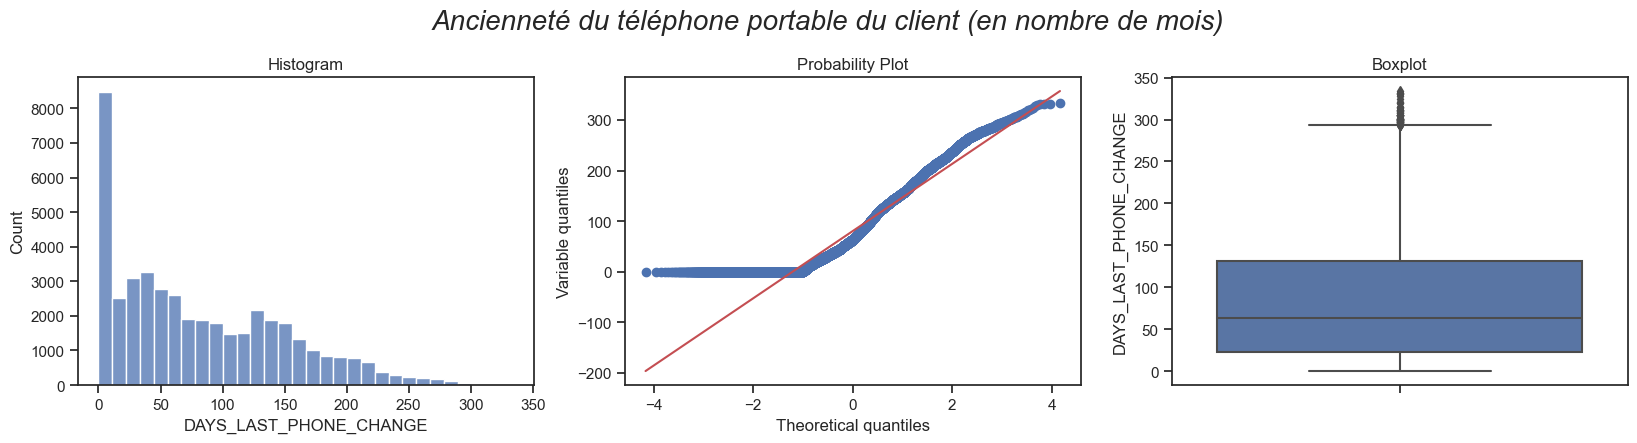

In [172]:
diagnostic_plots(clean_X_train, 'DAYS_LAST_PHONE_CHANGE', "Ancienneté du téléphone portable du client (en nombre de mois)")

In [173]:
pd.qcut(clean_X_train.DAYS_LAST_PHONE_CHANGE, q=5).head(7)

0     (89.0, 144.0]
1      (46.0, 89.0]
2      (46.0, 89.0]
3      (46.0, 89.0]
4     (89.0, 144.0]
5    (144.0, 334.0]
6     (89.0, 144.0]
Name: DAYS_LAST_PHONE_CHANGE, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 13.0] < (13.0, 46.0] < (46.0, 89.0] < (89.0, 144.0] < (144.0, 334.0]]

In [174]:
clean_X_train['anciennete_portable'] = pd.qcut(clean_X_train.DAYS_LAST_PHONE_CHANGE,
                                               q=5,
                                               labels=['13_mois_et_moins',
                                                       '14_a_46_mois',
                                                       '47_a_88_mois',
                                                       '89_a_143_mois',
                                                       '144_mois_et_plus'])

clean_X_train['anciennete_portable'].value_counts()

anciennete_portable
14_a_46_mois        9004
13_mois_et_moins    8889
89_a_143_mois       8809
144_mois_et_plus    8707
47_a_88_mois        8654
Name: count, dtype: int64

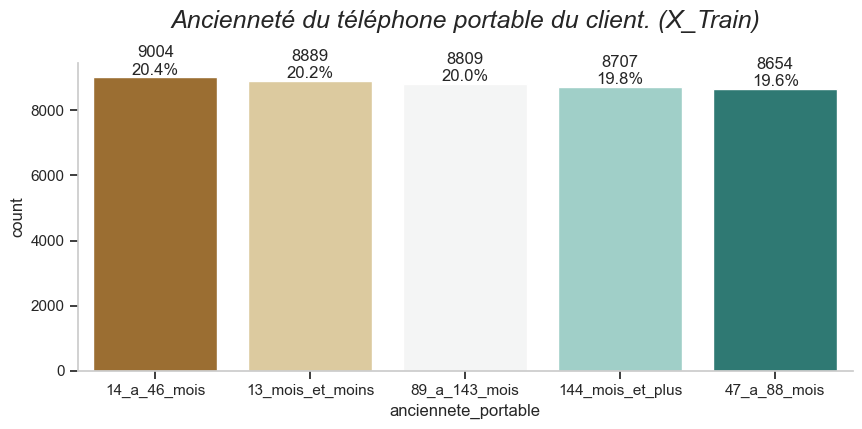

In [175]:
grah_barre(clean_X_train, 'anciennete_portable', 'BrBG', "Ancienneté du téléphone portable du client. (X_Train)\n", (10, 4))

***Application à l'ensemble de Test***

In [176]:
# Calcul de l'ancienneté du téléphone portable
clean_X_test['DAYS_LAST_PHONE_CHANGE'] = round(clean_X_test['DAYS_LAST_PHONE_CHANGE'] / -12, 0)

In [177]:
clean_X_test['anciennete_portable'] = pd.cut(clean_X_test.DAYS_LAST_PHONE_CHANGE, 
                                             bins=[-1,
                                                   13,
                                                   46,
                                                   88,
                                                   143,
                                                   500],
                                             include_lowest=True,
                                             labels=['13_mois_et_moins',
                                                     '14_a_46_mois',
                                                     '47_a_88_mois',
                                                     '89_a_143_mois',
                                                     '144_mois_et_plus'])

clean_X_test['anciennete_portable'].value_counts()

anciennete_portable
144_mois_et_plus    9727
47_a_88_mois        8254
14_a_46_mois        6898
13_mois_et_moins    5817
89_a_143_mois       5678
Name: count, dtype: int64

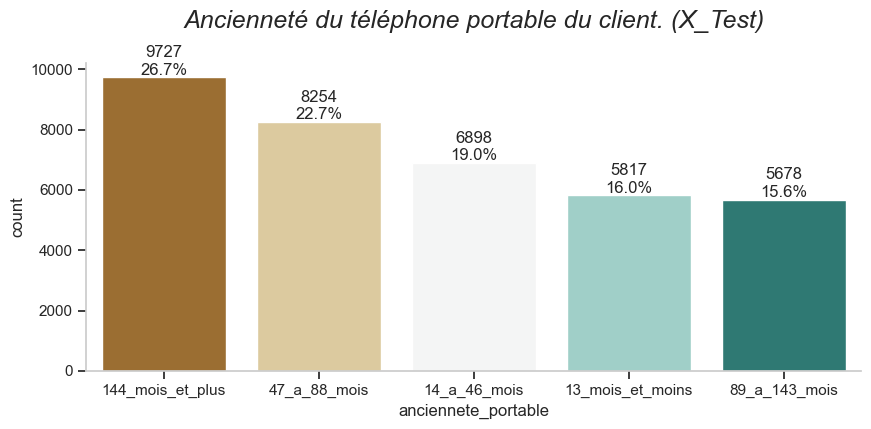

In [178]:
grah_barre(clean_X_test, 'anciennete_portable', 'BrBG', "Ancienneté du téléphone portable du client. (X_Test)\n", (10, 4))

In [179]:
# Suppression de la variable DAYS_LAST_PHONE_CHANGE dans X_Train et X_Test

clean_X_train.drop(labels='DAYS_LAST_PHONE_CHANGE', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='DAYS_LAST_PHONE_CHANGE', 
                  axis=1, inplace=True)

In [180]:
clean_X_train.shape, clean_X_test.shape

((44063, 44), (36374, 44))

In [181]:
print(clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number]).columns.to_list())

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']


In [182]:
clean_X_train.drop(labels='SK_ID_CURR', axis=1).describe().T

count       mean        std        min  \
AMT_INCOME_TOTAL           44,063.00 170,950.69 565,219.02  25,650.00   
AMT_CREDIT                 44,063.00 600,033.72 402,405.01  45,000.00   
AMT_ANNUITY                44,063.00  27,129.35  14,613.38   2,052.00   
AMT_GOODS_PRICE            44,063.00 539,145.76 369,631.10  45,000.00   
REGION_POPULATION_RELATIVE 44,063.00       0.02       0.01       0.00   
DAYS_REGISTRATION          44,063.00  -4,974.05   3,517.34 -21,249.00   
HOUR_APPR_PROCESS_START    44,063.00      12.06       3.25       0.00   
EXT_SOURCE_2               44,063.00       0.51       0.19       0.00   
OBS_30_CNT_SOCIAL_CIRCLE   44,063.00       1.42       2.31       0.00   
DEF_30_CNT_SOCIAL_CIRCLE   44,063.00       0.14       0.44       0.00   
OBS_60_CNT_SOCIAL_CIRCLE   44,063.00       1.40       2.29       0.00   
DEF_60_CNT_SOCIAL_CIRCLE   44,063.00       0.10       0.36       0.00   

                                  25%        50%        75%            max  
AMT_INCOME_TOTAL           112,500.00 144,000.00 202,500.00 117,000,000.00  
AMT_CREDIT                 270,000.00 517,500.00 808,650.00   4,050,000.00  
AMT_ANNUITY                 16,488.00  24,939.00  34,596.00     258,025.50  
AMT_GOODS_PRICE            238,500.00 450,000.00 679,500.00   4,050,000.00  
REGION_POPULATION_RELATIVE       0.01       0.02       0.03           0.07  
DAYS_REGISTRATION           -7,455.50  -4,482.00  -2,007.00           0.00  
HOUR_APPR_PROCESS_START         10.00      12.00      14.00          23.00  
EXT_SOURCE_2                     0.39       0.57       0.66           0.85  
OBS_30_CNT_SOCIAL_CIRCLE         0.00       0.00       2.00          28.00  
DEF_30_CNT_SOCIAL_CIRCLE         0.00       0.00       0.00           6.00  
OBS_60_CNT_SOCIAL_CIRCLE         0.00       0.00       2.00          28.00  
DEF_60_CNT_SOCIAL_CIRCLE         0.00       0.00       0.00           5.00

#### DAYS_REGISTRATION : Combien de jours avant la demande le client a-t-il modifié son inscription	? !!!!

In [183]:
# Calculé en jours depuis le jour de la demande (d'où le négatif) 
clean_X_train['DAYS_REGISTRATION'].describe()

count    44,063.00
mean     -4,974.05
std       3,517.34
min     -21,249.00
25%      -7,455.50
50%      -4,482.00
75%      -2,007.00
max           0.00
Name: DAYS_REGISTRATION, dtype: float64

In [184]:
# Calcul du nombre d'années (même principe que pour l'âge)
clean_X_train['DAYS_REGISTRATION'] = round(clean_X_train['DAYS_REGISTRATION'] / -365, 0)

clean_X_train['DAYS_REGISTRATION'].describe()

count   44,063.00
mean        13.63
std          9.64
min          0.00
25%          5.00
50%         12.00
75%         20.00
max         58.00
Name: DAYS_REGISTRATION, dtype: float64

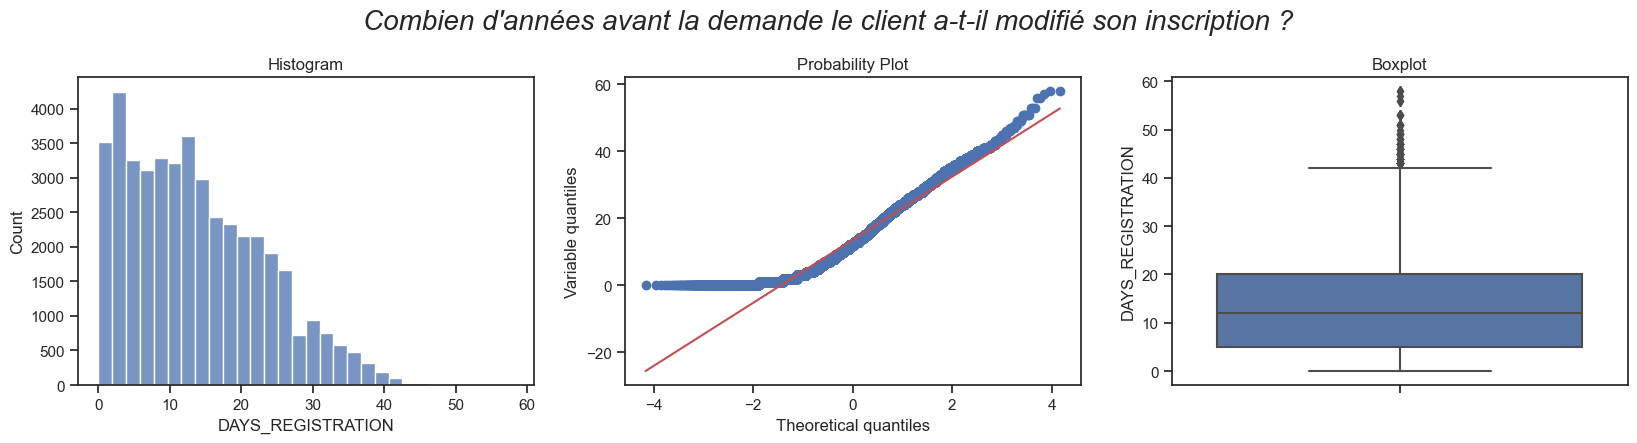

In [185]:
diagnostic_plots(clean_X_train, 'DAYS_REGISTRATION', "Combien d'années avant la demande le client a-t-il modifié son inscription ?")

In [186]:
pd.qcut(clean_X_train.DAYS_REGISTRATION, q=5).head(7)

0      (4.0, 10.0]
1    (-0.001, 4.0]
2     (10.0, 15.0]
3     (22.0, 58.0]
4     (10.0, 15.0]
5     (10.0, 15.0]
6    (-0.001, 4.0]
Name: DAYS_REGISTRATION, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 4.0] < (4.0, 10.0] < (10.0, 15.0] < (15.0, 22.0] < (22.0, 58.0]]

In [187]:
clean_X_train['year_registration'] = pd.qcut(clean_X_train.DAYS_REGISTRATION,
                                             q=5,
                                             labels=['4_ans_et_moins',
                                                     '5_a_10_ans',
                                                     '11_a_15_ans',
                                                     '16_a_23_ans',
                                                     '24_ans_et_plus'])

clean_X_train['year_registration'].value_counts()

year_registration
4_ans_et_moins    9502
5_a_10_ans        9441
24_ans_et_plus    8809
11_a_15_ans       8286
16_a_23_ans       8025
Name: count, dtype: int64

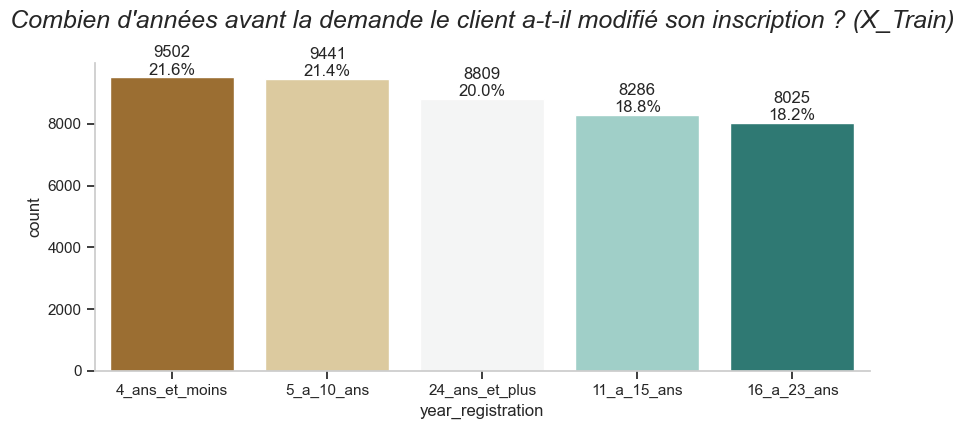

In [188]:
grah_barre(clean_X_train, 'year_registration', 'BrBG', "Combien d'années avant la demande le client a-t-il modifié son inscription ? (X_Train)\n", (10, 4))

***Application à l'ensemble de Test***

In [189]:
# Calcul de l'ancienneté du téléphone portable
clean_X_test['DAYS_REGISTRATION'] = round(clean_X_test['DAYS_REGISTRATION'] / -365, 0)

In [190]:
clean_X_test['year_registration'] = pd.cut(clean_X_test.DAYS_REGISTRATION,
                                           bins=[-1,
                                                 4,
                                                 10,
                                                 15,
                                                 23,
                                                 100],
                                           include_lowest=True,
                                           labels=['4_ans_et_moins',
                                                   '5_a_10_ans',
                                                   '11_a_15_ans',
                                                   '16_a_23_ans',
                                                   '24_ans_et_plus'])

clean_X_test['year_registration'].value_counts()

year_registration
4_ans_et_moins    8147
5_a_10_ans        7641
16_a_23_ans       7292
11_a_15_ans       6775
24_ans_et_plus    6519
Name: count, dtype: int64

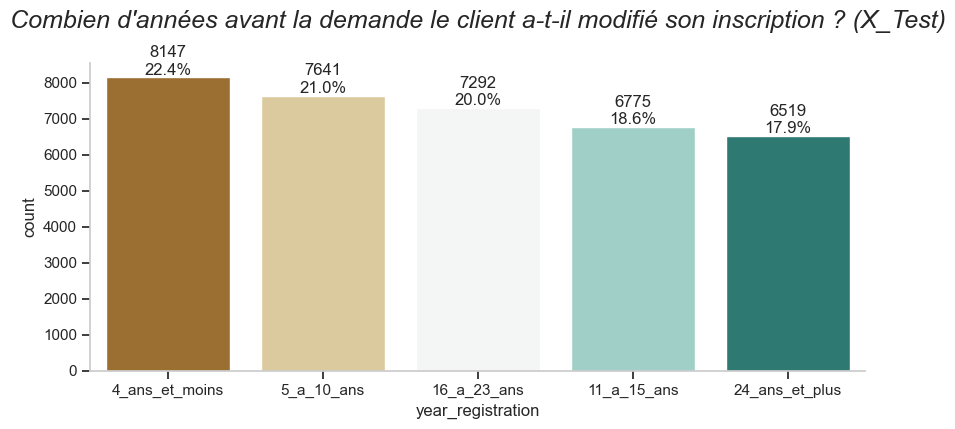

In [191]:
grah_barre(clean_X_test, 'year_registration', 'BrBG', "Combien d'années avant la demande le client a-t-il modifié son inscription ? (X_Test)\n", (10, 4))

In [192]:
# Suppression de la variable DAYS_REGISTRATION dans X_Train et X_Test

clean_X_train.drop(labels='DAYS_REGISTRATION', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='DAYS_REGISTRATION', 
                  axis=1, inplace=True)

#### À quelle heure environ le client a-t-il demandé le prêt	?

In [193]:
clean_X_train['HOUR_APPR_PROCESS_START'].describe()

count   44,063.00
mean        12.06
std          3.25
min          0.00
25%         10.00
50%         12.00
75%         14.00
max         23.00
Name: HOUR_APPR_PROCESS_START, dtype: float64

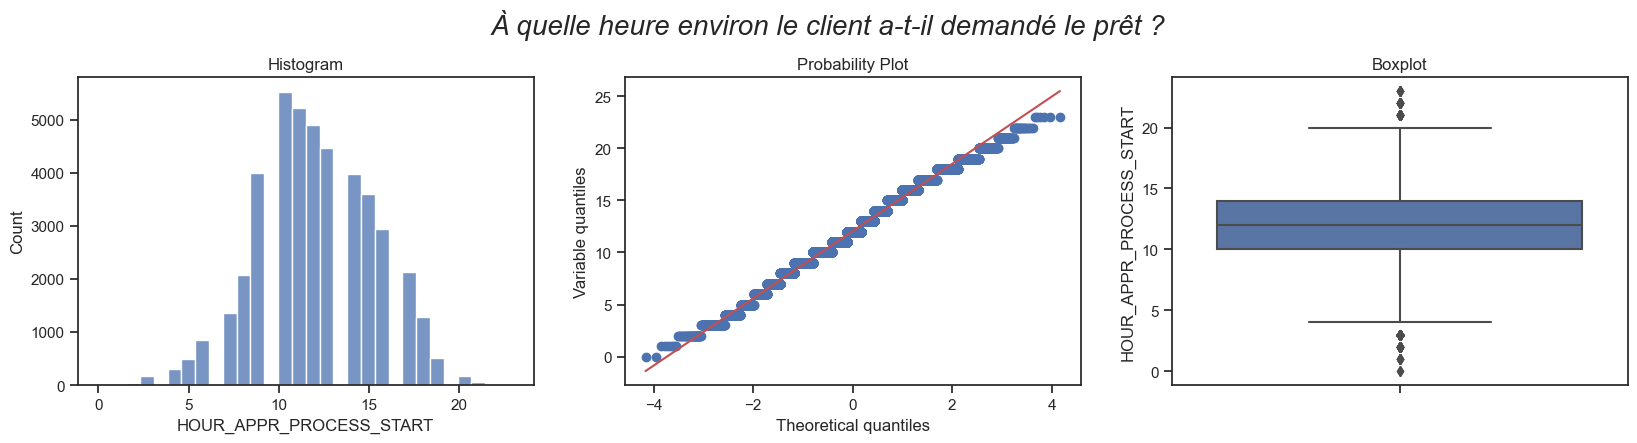

In [194]:
diagnostic_plots(clean_X_train, 'HOUR_APPR_PROCESS_START', "À quelle heure environ le client a-t-il demandé le prêt ?")

In [195]:
clean_X_train['heure_demande_pret'] = clean_X_train['HOUR_APPR_PROCESS_START'] 

clean_X_train['heure_demande_pret'] = np.where(clean_X_train['HOUR_APPR_PROCESS_START'] <= 7, 
                                                  'de_19h_à_7h', clean_X_train['heure_demande_pret'])

clean_X_train['heure_demande_pret'] = np.where((clean_X_train['HOUR_APPR_PROCESS_START'] > 7) & (clean_X_train['HOUR_APPR_PROCESS_START'] <= 12), 
                                                  'de_8h_à_12h', clean_X_train['heure_demande_pret'])

clean_X_train['heure_demande_pret'] = np.where((clean_X_train['HOUR_APPR_PROCESS_START'] > 12) & (clean_X_train['HOUR_APPR_PROCESS_START'] <= 18), 
                                                  'de_13h_à_18h', clean_X_train['heure_demande_pret'])

clean_X_train['heure_demande_pret'] = np.where(clean_X_train['HOUR_APPR_PROCESS_START'] >= 19, 
                                                  'de_19h_à_7h', clean_X_train['heure_demande_pret'])

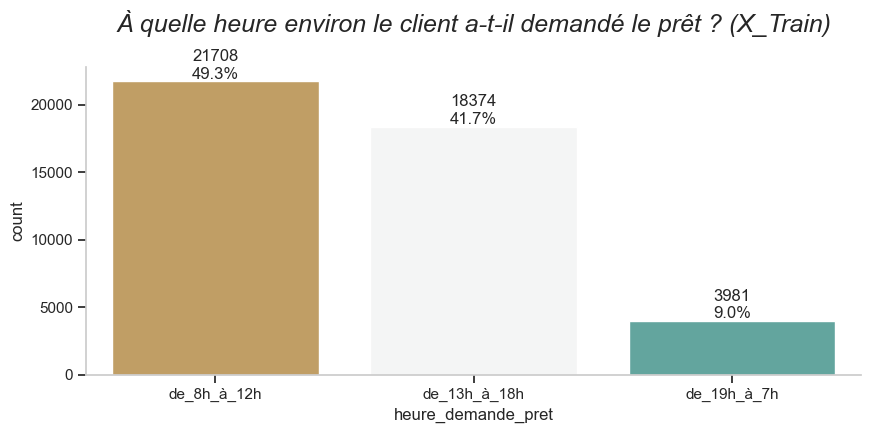

In [196]:
grah_barre(clean_X_train, 'heure_demande_pret', 'BrBG', "À quelle heure environ le client a-t-il demandé le prêt ? (X_Train)\n", (10, 4))

In [197]:
clean_X_test['heure_demande_pret'] = clean_X_test['HOUR_APPR_PROCESS_START'] 

clean_X_test['heure_demande_pret'] = np.where(clean_X_test['HOUR_APPR_PROCESS_START'] <= 7, 
                                                  'de_19h_à_7h', clean_X_test['heure_demande_pret'])

clean_X_test['heure_demande_pret'] = np.where((clean_X_test['HOUR_APPR_PROCESS_START'] > 7) & (clean_X_test['HOUR_APPR_PROCESS_START'] <= 12), 
                                                  'de_8h_à_12h', clean_X_test['heure_demande_pret'])

clean_X_test['heure_demande_pret'] = np.where((clean_X_test['HOUR_APPR_PROCESS_START'] > 12) & (clean_X_test['HOUR_APPR_PROCESS_START'] <= 18), 
                                                  'de_13h_à_18h', clean_X_test['heure_demande_pret'])

clean_X_test['heure_demande_pret'] = np.where(clean_X_test['HOUR_APPR_PROCESS_START'] >= 19, 
                                                  'de_19h_à_7h', clean_X_test['heure_demande_pret'])

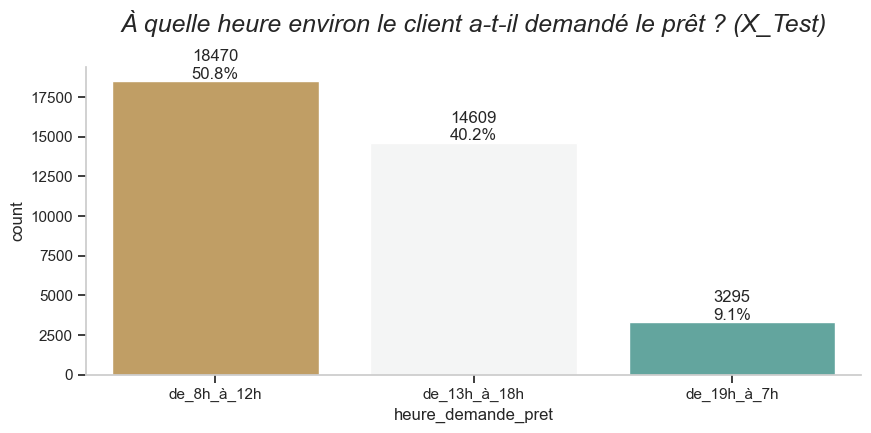

In [198]:
grah_barre(clean_X_test, 'heure_demande_pret', 'BrBG', "À quelle heure environ le client a-t-il demandé le prêt ? (X_Test)\n", (10, 4))

In [199]:
# Suppression de la variable HOUR_APPR_PROCESS_START dans X_Train et X_Test

clean_X_train.drop(labels='HOUR_APPR_PROCESS_START', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='HOUR_APPR_PROCESS_START', 
                  axis=1, inplace=True)

clean_X_train.shape, clean_X_test.shape

((44063, 44), (36374, 44))

In [200]:
print(clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number]).columns.to_list())

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']


#### 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'

In [201]:
list_var = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

clean_X_train[list_var].describe()

OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
count                 44,063.00                 44,063.00   
mean                       1.42                      0.14   
std                        2.31                      0.44   
min                        0.00                      0.00   
25%                        0.00                      0.00   
50%                        0.00                      0.00   
75%                        2.00                      0.00   
max                       28.00                      6.00   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  
count                 44,063.00                 44,063.00  
mean                       1.40                      0.10  
std                        2.29                      0.36  
min                        0.00                      0.00  
25%                        0.00                      0.00  
50%                        0.00                      0.00  
75%                        2.00                      0.00  
max                       28.00                      5.00

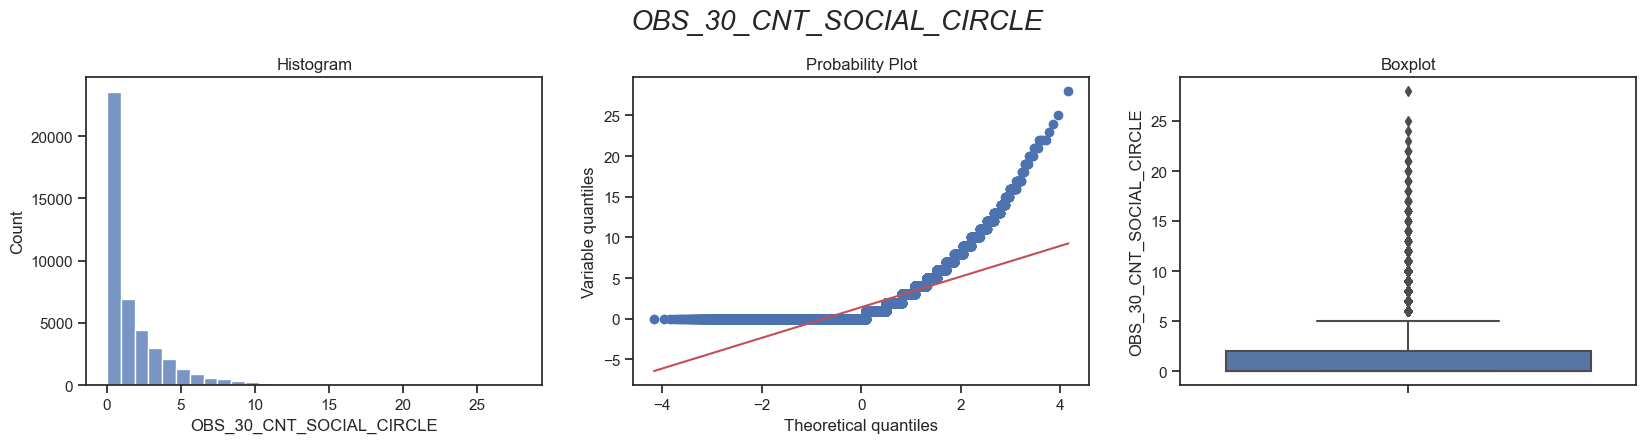

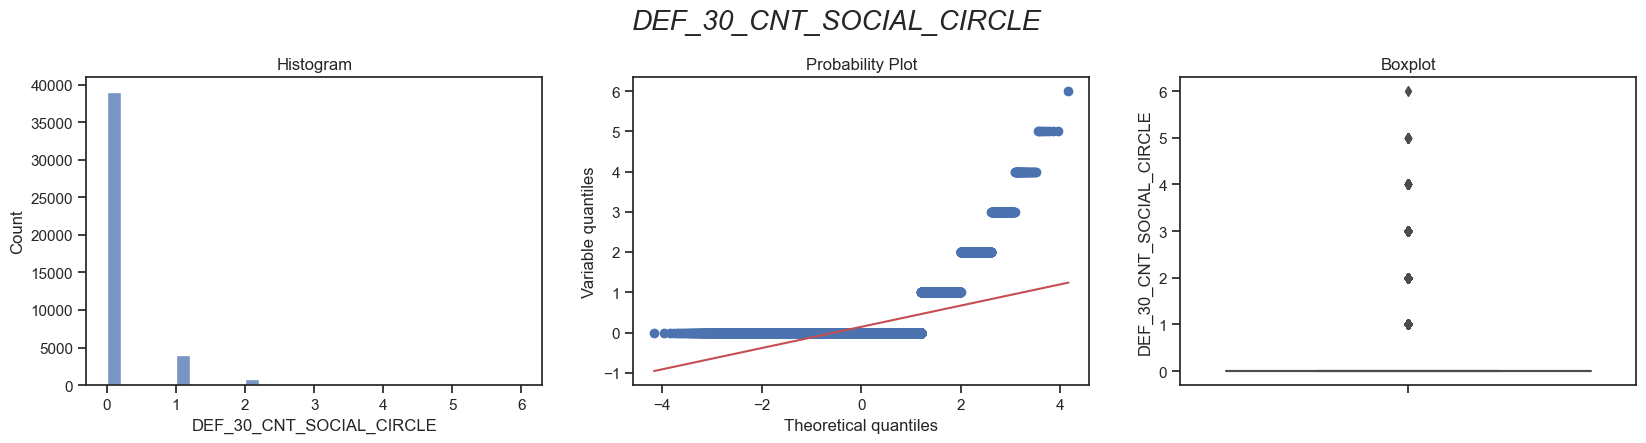

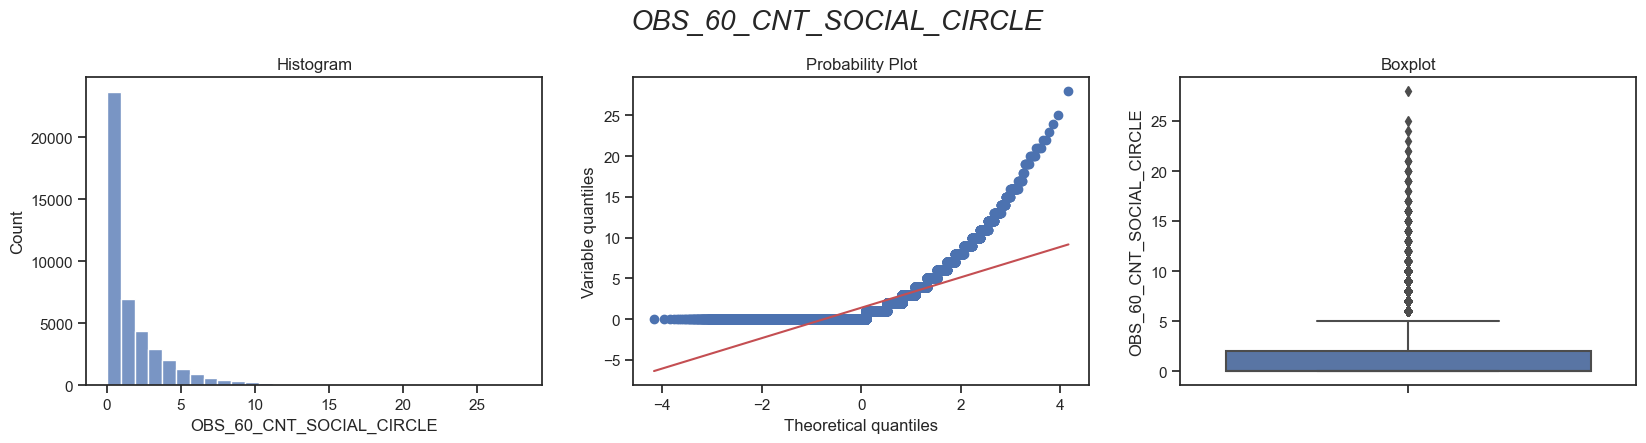

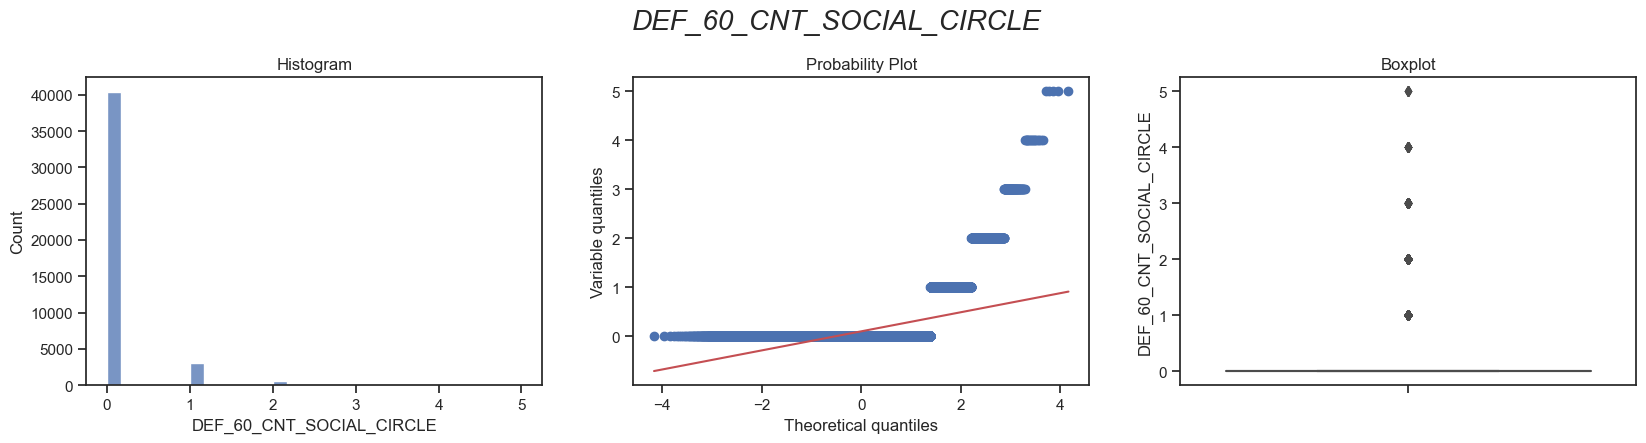

In [202]:
for var in list_var:
    diagnostic_plots(clean_X_train, var, f"{var}")

Ces variables sont toutes presque nulles, nous les supprimons des jeux de données.

In [203]:
clean_X_train.drop(labels=list_var, 
                   axis=1, inplace=True)

clean_X_test.drop(labels=list_var, 
                  axis=1, inplace=True)

clean_X_train.shape, clean_X_test.shape

((44063, 40), (36374, 40))

#### Population normalisée de la région où vit le client (un nombre plus élevé signifie que le client vit dans une région plus peuplée)

In [204]:
clean_X_train['REGION_POPULATION_RELATIVE'].describe()

count   44,063.00
mean         0.02
std          0.01
min          0.00
25%          0.01
50%          0.02
75%          0.03
max          0.07
Name: REGION_POPULATION_RELATIVE, dtype: float64

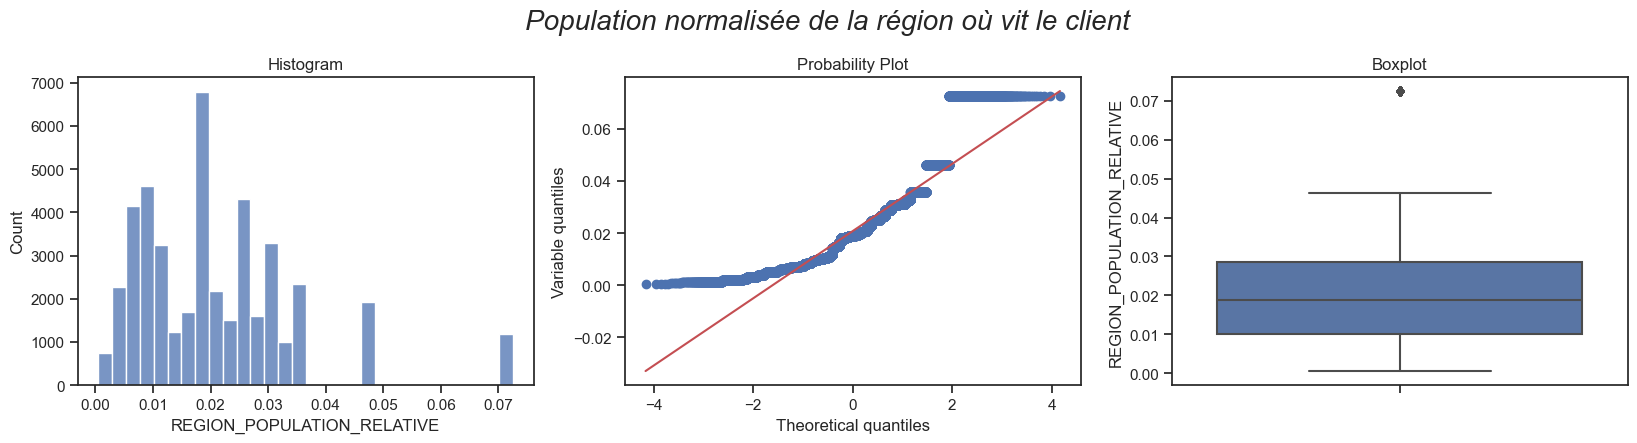

In [205]:
diagnostic_plots(clean_X_train, 'REGION_POPULATION_RELATIVE', "Population normalisée de la région où vit le client")

In [206]:
pd.qcut(clean_X_train.REGION_POPULATION_RELATIVE, q=5).head()

0                      (0.0166, 0.0207]
1    (-0.00046699999999999997, 0.00863]
2                     (0.00863, 0.0166]
3    (-0.00046699999999999997, 0.00863]
4                      (0.0207, 0.0308]
Name: REGION_POPULATION_RELATIVE, dtype: category
Categories (5, interval[float64, right]): [(-0.00046699999999999997, 0.00863] < (0.00863, 0.0166] < (0.0166, 0.0207] < (0.0207, 0.0308] < (0.0308, 0.0725]]

In [207]:
clean_X_train['pop_region'] = pd.qcut(clean_X_train.REGION_POPULATION_RELATIVE,
                                      q=5,
                                      labels=['densite_tres_faible',
                                              'densite_faible',
                                              'densite_moyenne',
                                              'densite_forte',
                                              'densite_tres_forte'])

clean_X_train['pop_region'].value_counts()

pop_region
densite_faible         9145
densite_forte          9136
densite_moyenne        8965
densite_tres_faible    8822
densite_tres_forte     7995
Name: count, dtype: int64

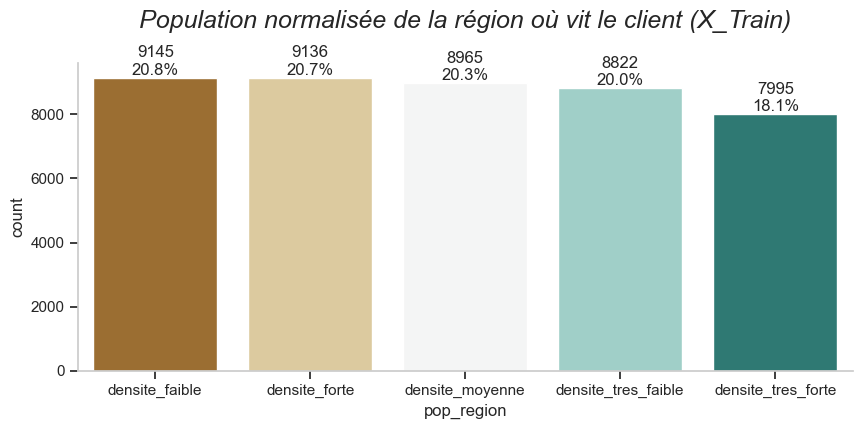

In [208]:
grah_barre(clean_X_train, 'pop_region', 'BrBG', "Population normalisée de la région où vit le client (X_Train)\n", (10, 4))

In [209]:
clean_X_test['pop_region'] = pd.cut(clean_X_test.REGION_POPULATION_RELATIVE,
                                    bins=[-0.00071,
                                          0.00887,
                                          0.0166,
                                          0.0207,
                                          0.0308,
                                          1],
                                    include_lowest=True,
                                    labels=['densite_tres_faible',
                                            'densite_faible',
                                            'densite_moyenne',
                                            'densite_forte',
                                            'densite_tres_forte'])
clean_X_test['pop_region'].value_counts()

pop_region
densite_forte          8247
densite_tres_faible    7287
densite_moyenne        7113
densite_tres_forte     6953
densite_faible         6774
Name: count, dtype: int64

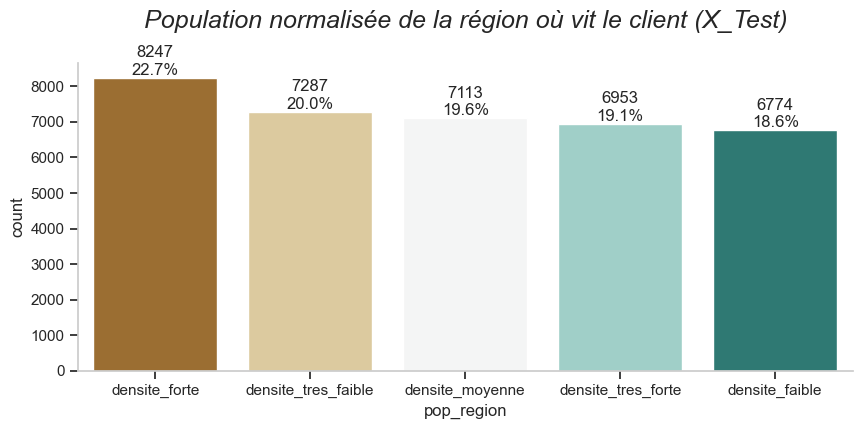

In [210]:
grah_barre(clean_X_test, 'pop_region', 'BrBG', "Population normalisée de la région où vit le client (X_Test)\n", (10, 4))

In [211]:
clean_X_train.drop(labels='REGION_POPULATION_RELATIVE', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='REGION_POPULATION_RELATIVE', 
                  axis=1, inplace=True)

clean_X_train.shape, clean_X_test.shape

((44063, 40), (36374, 40))

In [212]:
print(clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number]).columns.to_list())

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2']


### Les variables numériques continues

In [213]:
var_continues = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2']

In [214]:
clean_X_train[var_continues].describe()

AMT_INCOME_TOTAL   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
count         44,063.00    44,063.00    44,063.00        44,063.00   
mean         170,950.69   600,033.72    27,129.35       539,145.76   
std          565,219.02   402,405.01    14,613.38       369,631.10   
min           25,650.00    45,000.00     2,052.00        45,000.00   
25%          112,500.00   270,000.00    16,488.00       238,500.00   
50%          144,000.00   517,500.00    24,939.00       450,000.00   
75%          202,500.00   808,650.00    34,596.00       679,500.00   
max      117,000,000.00 4,050,000.00   258,025.50     4,050,000.00   

       EXT_SOURCE_2  
count     44,063.00  
mean           0.51  
std            0.19  
min            0.00  
25%            0.39  
50%            0.57  
75%            0.66  
max            0.85

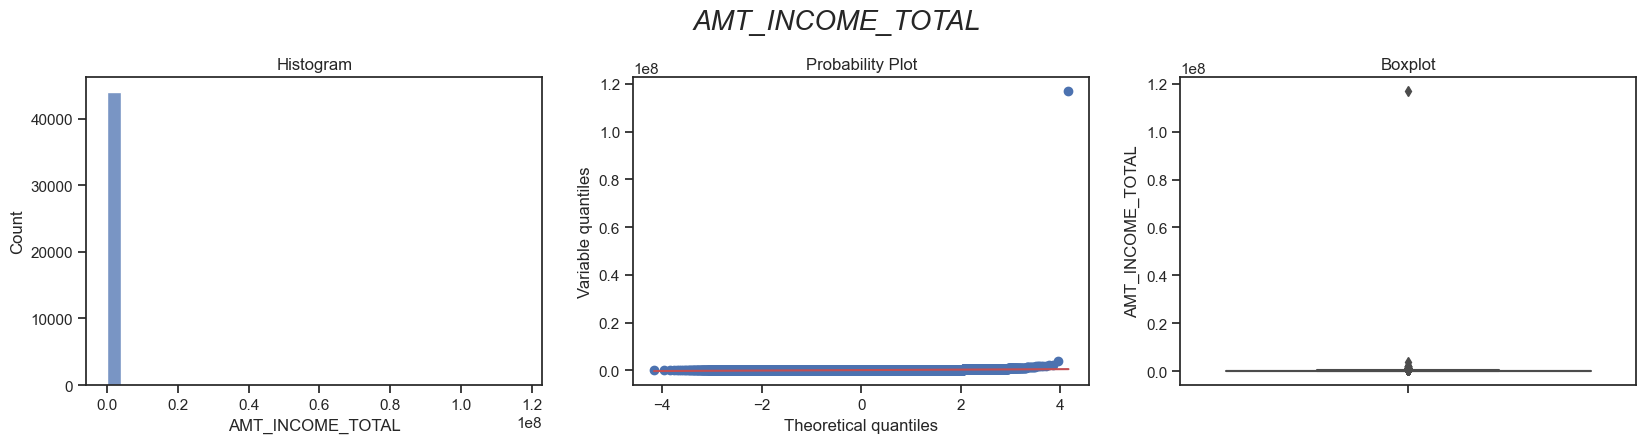

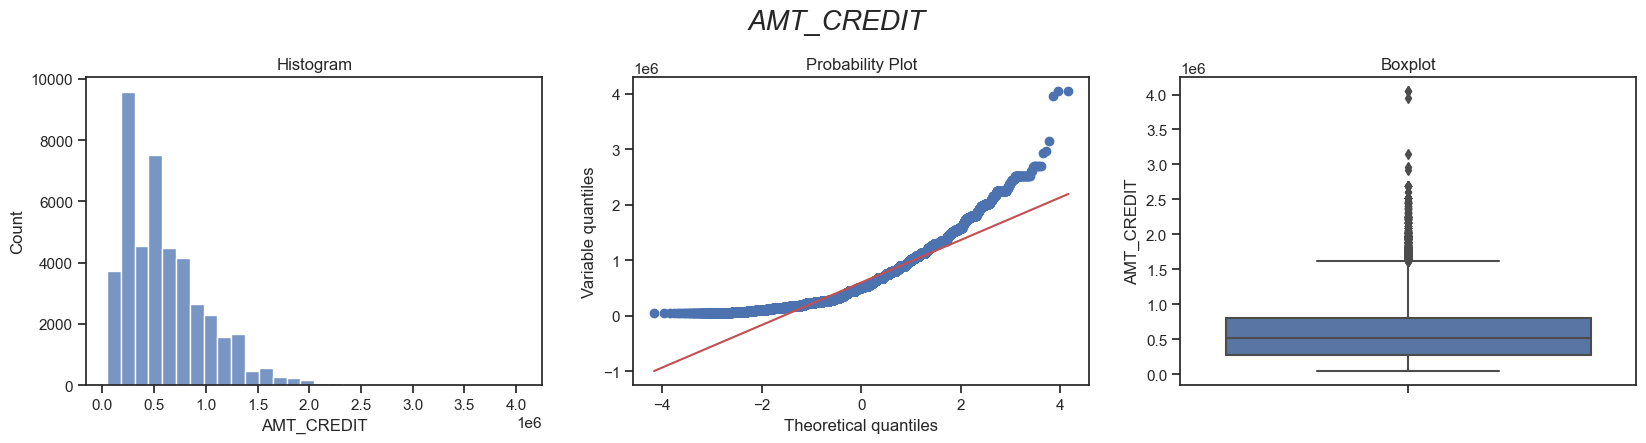

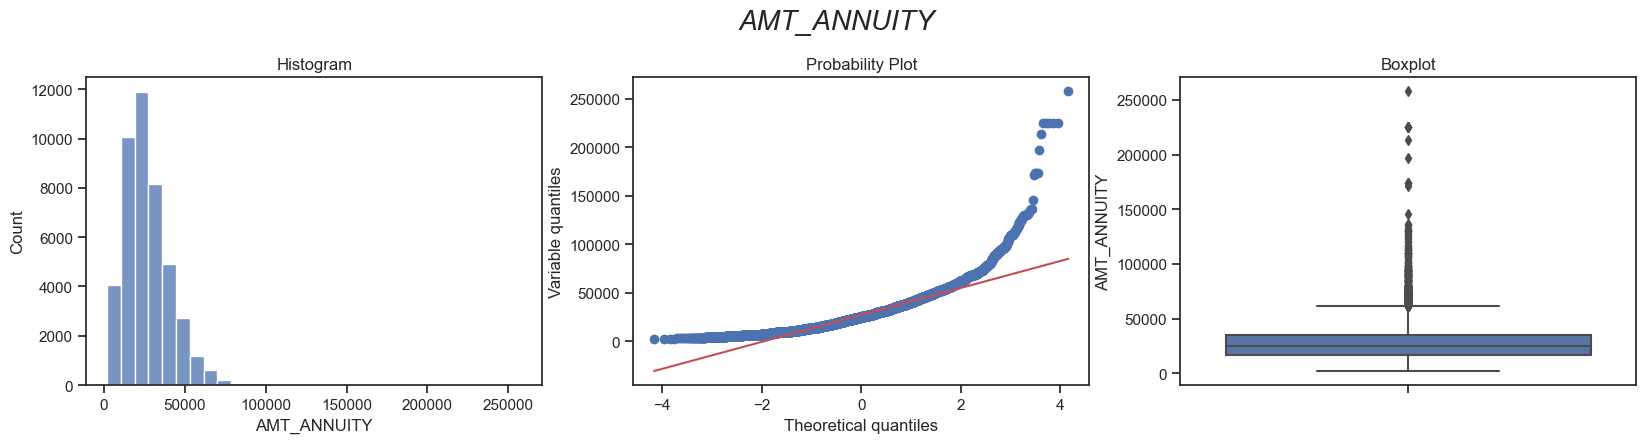

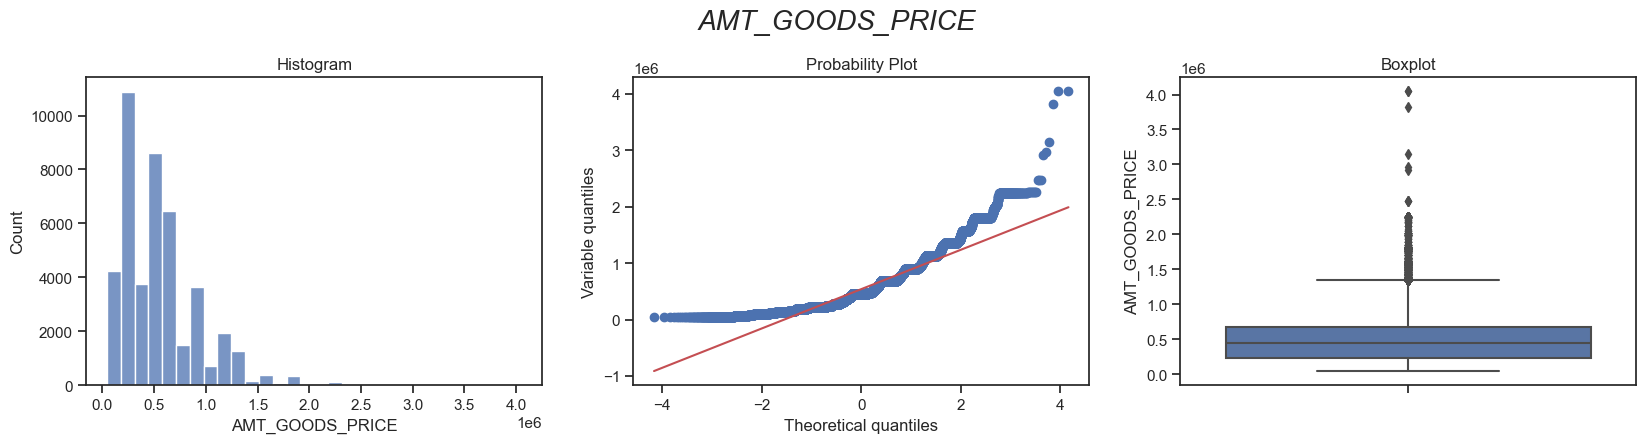

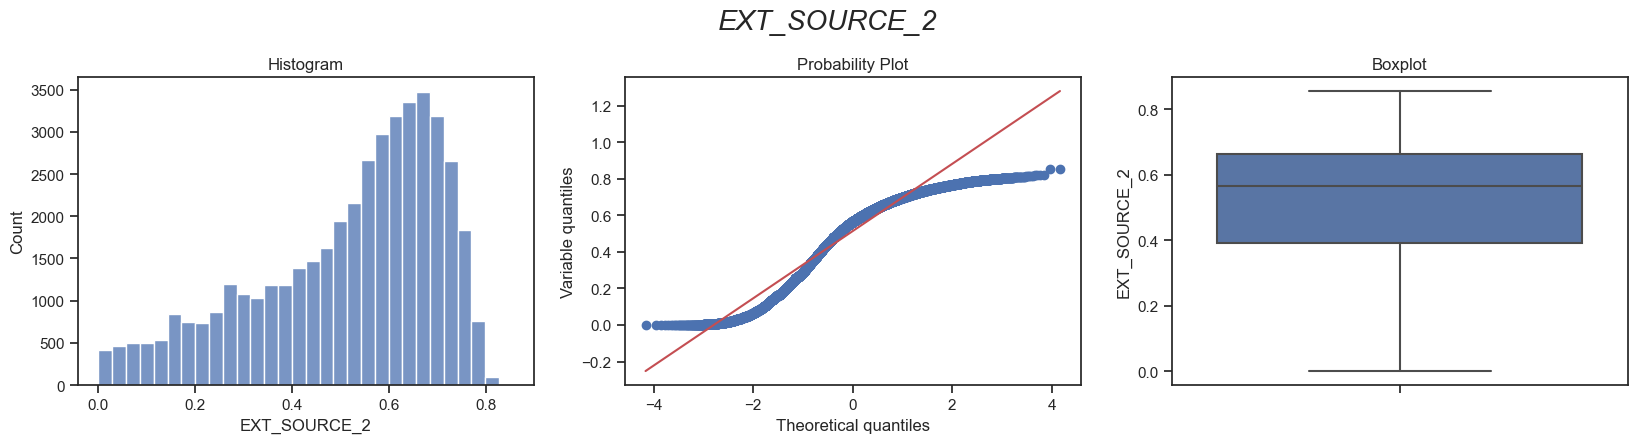

In [215]:
for var in var_continues:
    diagnostic_plots(clean_X_train, var, f"{var}")

Nous pouvons constater graphiquement que la plupart des distributions des variables numériques continues sont asymétriques.

Or, la plupart des algorithmes de Machine Learning sont conçus selon l'hypothèse que les variables d'entrées suivent une loi normale. Si ce n'est pas le cas, cela peut affecter énormément la qualité du modèle et conduire à de mauvaises classements/prédictions.

Il existe plusieurs techniques de transformations pour normaliser les variables (la transformation logarithmique par exemple ou la standardisation).

Afin d'être plus confiant sur la distribution de chaque variable par rapport à la loi normale, nous allons calculer les degrés d'asymétrie.

Une distribution normale a un degré d'asymétrie égal à 0 et un degré d'aplatissement égal à 3. Donc une variable suit la loi normale lorsque son degré d'asymétrie est proche de 0 et son degré d'aplatissement proche de 3.

In [216]:
# Calcul des degrés d'asymétrie : Test Skewness

clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number]).skew().sort_values()

EXT_SOURCE_2        -0.79
AMT_CREDIT           1.22
AMT_GOODS_PRICE      1.35
AMT_ANNUITY          1.73
AMT_INCOME_TOTAL   200.45
dtype: float64

In [217]:
# Calcul des degrés d'aplatissement : Test Kurtosis

clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number]).kurt().sort_values()

EXT_SOURCE_2           -0.27
AMT_CREDIT              1.93
AMT_GOODS_PRICE         2.52
AMT_ANNUITY             9.99
AMT_INCOME_TOTAL   41,428.63
dtype: float64

Aucune des variables a un degré d'asymétrie proche de 0 et aucune des variables a un degré d'aplatissement proche de 3. Elles ne suivent donc pas une loi normale. Vérifions-le statistiquement grâce au test de Jarque-Bera.

Le test de Jarque-Bera permet de tester si l'échantillon a l'asymétrie et l'aplatissement correspondant à une distribution normale, c'est-à-dire asymétrie = 0 et aplatissement = 3.

La statistique de test est toujours non négative, et si elle est loin de zéro, elle montre que les données n'ont pas une distribution normale. Ce test ne fonctionne que pour plus de 2000 échantillons de données.

H0 = L'échantillon provient d'une distribution normale.
HA = L'échantillon ne provient pas d'une distribution normale.

Si la valeur P est inférieure à 0,05, nous rejetons l'hypothèse nulle. Nous avons suffisamment de preuves pour dire que les données de l'échantillon ne proviennent pas d'une distribution normale.

In [218]:
# Jarque-Bera test

from scipy import stats

alpha = 0.05

for i in var_continues:
    print ([i])
    a,b = stats.jarque_bera(clean_X_train[[i]])
    print ("Statistics : ", a, "; p-value : ", b)
    if b < alpha:  
        print("On rejette H0 : la normalité de la distribution est rejetée\n")
    else:
        print("On accepte H0 : la normalité de la distribution est acceptée\n")

['AMT_INCOME_TOTAL']
Statistics :  3150692740006.045 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

['AMT_CREDIT']
Statistics :  17758.750327282192 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

['AMT_ANNUITY']
Statistics :  205105.8415011812 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

['AMT_GOODS_PRICE']
Statistics :  24974.73383836523 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

['EXT_SOURCE_2']
Statistics :  4747.624752470825 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée



Nous pouvons voir que les statistiques de test de toutes les variables sont loin de zéro et que les valeurs de p sont de 0, ce qui suggère que toutes les variables numériques ne sont pas distribuées normalement.

**Première conséquence de la non normalité des distributions** : Calculer Les coefficients de corrélation de Pearson qui mesure une corrélation linéaire entre deux variables (test paramétrique reposant sur la loi normale), n'est pas approprié.

**Deuxième conséquence de la non normalité des distributions** : Comme l’ACP utilise le coefficient de corrélation de Pearson, c'est-à-dire qu'elle ne mesure que les liaisons linéaires entre les variables, nous ne pourrons pas l'utiliser comme technique de réduction du nombre de variables.

Nous pourrions alors tenter de transformer ces variables numériques en appliquant une fonction log ou carré ou encore exponentielle. Mais, d'une part, cela ne garantit pas la "normalité" des variables transformées et surtout, l'interprétation des résultats devient alors très problématique. Or, nous devons fournir aux chargés de relation client un dashboard qui leur permet de visualiser le score et de l'interpréter pour chaque client de façon intelligible pour une personne non experte en data science.

Dans un premier temps, nous allons utiliser la méthode de calcul des corrélations de Spearman non paramétriques basées sur le rang afin de nous rendre compte si il y a redondance de l'information entre ces variables.

La corrélation de Spearman entre deux variables est égale à la corrélation de Pearson entre les valeurs de rang de ces deux variables ; alors que la corrélation de Pearson évalue les relations linéaires, la corrélation de Spearman évalue les relations monotones (qu’elles soient linéaires ou non). Le coefficient de corrélation sur les rangs (Rho de Spearman) s’interprète de la même manière qu’un coefficient de corrélation de Pearson : une valeur positive (maximum = +1) indique une variation simultanée dans le même sens, une valeur négative (minimum = -1) une variation simultanée en sens inverse.

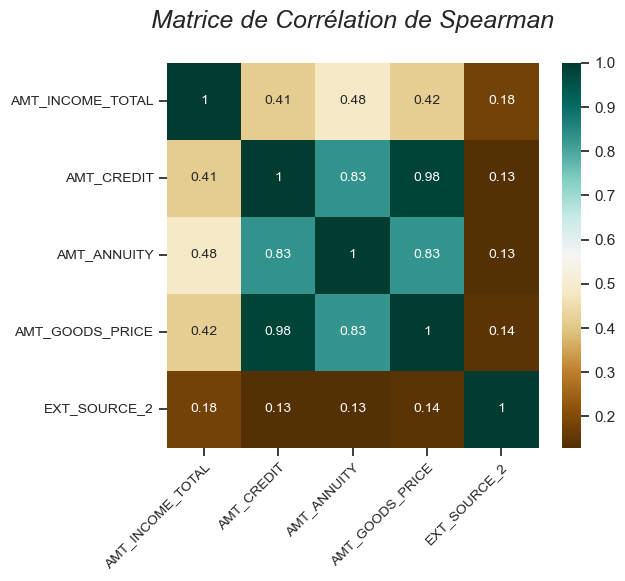

In [219]:
sns.set(style="ticks", rc={'figure.figsize': (6, 5)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = clean_X_train.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 10})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

Nous allons maintenant effectuer des tests de corrélation de Spearman dont l'intérêt est d’apporter plus de pertinence et de fiabilité à la lecture des coefficients de corrélation.

On pose les hypothèses de départ :

H0 : Variables indépendantes si p-value > 5% <br>
H1 : Variables non indépendantes si p-value < 5% : On peut en conclure que le coefficient de corrélation est différent de zéro et qu’une relation monotone existe entre les 2 variables. L'une des variables n'apportent donc pas plus d'informations que l'autre.

On effectue un test de corrélation sur chaque variable 2 à 2 en isolant uniquement la p-value.

In [220]:
a = np.empty((len(df_analyse_norm.columns), len(df_analyse_norm.columns),))
a[:] = np.nan
for i in range(0, len(df_analyse_norm.columns)):
    for j in range(0, len(df_analyse_norm.columns)):
        a[i, j] = stats.spearmanr(
            df_analyse_norm.iloc[:, i], df_analyse_norm.iloc[:, j])[1]

df_pvalue = round(pd.DataFrame(
    a, columns=df_analyse_norm.columns, index=df_analyse_norm.columns), 5)

In [223]:
# Définir la précision des chiffres dans le DataFrame avant d'appliquer le style
df_pvalue_formatted = df_pvalue.round(3)

cm = sns.light_palette("green", as_cmap=True)

styled_df = df_pvalue_formatted.style.background_gradient(cmap=cm)

**On peut conclure qu'il existe une relation monotone entre toutes les variables numériques.**

Le taux de corrélation entre le montant du crédit et le prix des biens pour lesquels le prêt est demandé étant de 98%, nous pouvons sans perdre d'informations, supprimer l'une d'entre elles. Nous allons donc supprimer 'AMT_GOODS_PRICE'.

De même, avec un taux de corrélation de 83% entre le montant du crédit et le montant annuel du remboursement ('AMT_ANNUITY'), nous pouvons supprimer ce dernier. Au préalable, nous calculerons la part du montant annuel du remboursement dans les revenus annuels des clients, ainsi que la durée totale approximative du remboursement du prêt.

Mais nous avons aussi **constater l'existence de valeurs aberrantes** dans les distributions de ces variables, c'est-à-dire de valeurs qui diffèrent grandement des autres valeurs de la même variable.

Or, plusieurs **algorithmes de Machine Learning sont sensibles aux données d’entrainement ainsi qu’à leurs distributions.** Avoir des Outliers dans le Training Set d’un algorithme de Machine Learning peut rendre la phase d’entrainement plus longue. Sans mentionner que l’apprentissage sera biaisé. Par conséquent, **le modèle prédictif produit ne sera pas performant, ou du moins, loin d’être optimal.**

***Que pouvons nous faire, alors, pour remédier à cette situation ?***

Souvent, et compte tenu du nombre important d'observations dans le dataset d'entraînement, on supprime ces outliers ou on les remplace par la limite supérieure de l'IQR (ou tout autre valeur - Méthode Censoring or Capping qui consiste à plafonner le maximum et/ou le minimum d'une distribution à une valeur arbitraire. En d'autres termes, les valeurs supérieures ou inférieures à celles déterminées arbitrairement sont censurées).

Mais cela n'a pas de sens ici d’un point de vue sémantique, et biaiserait tout autant les résultats des modèles de prédiction. En effet, les très hauts revenus, par exemple, sont des valeurs extrêmes et rares, mais plausibles : une personne avec un revenu annuel très élevé peu aussi demander un crédit ! <br>
De plus, nous devrions signifier aux chargés de la relation client, que notre modèle de prédiction ne fonctionne pas pour les personnes avec de très hauts revenus !!

**Nous allons donc discrétiser ces variables en créant des groupes.**

Ce codage va nous permettre d’étudier ces variables dont les distributions sont très irrégulières et pour lesquelles le coefficient de corrélation est une mesure de liaison inadaptée. Par exemple, si un élément a une valeur très éloignée des valeurs des autres éléments, il influe de manière prépondérante sur les coefficients de corrélation et un codage qualitatif le neutralise.

**Paradoxalement, en réduisant l’information traitée (l’appartenance à une classe ou un intervalle est moins précise qu’une valeur numérique), on augmente la richesse du résultat !**

In [224]:
clean_X_train.drop(labels='AMT_GOODS_PRICE', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='AMT_GOODS_PRICE', 
                  axis=1, inplace=True)

clean_X_train.shape, clean_X_test.shape

((44063, 39), (36374, 39))

####  Part du montant mensuel du remboursement dans les revenus mensuels des clients : le taux d'endettement du client 

Le taux d’endettement détermine le montant qu’un emprunteur peut raisonnablement consacrer au remboursement d’un crédit tout en continuant à vivre correctement. Il est donc égal à une fraction des revenus nets mensuels.

C’est un indicateur déterminant pour les banques dans leur étude d’une demande de crédit. Dans le cadre d’une étude de faisabilité du prêt, les organismes vont affiner ce taux en fonction de leurs paramètres propres et de la situation de chaque emprunteur. Mais le taux d’endettement est une boussole dans la préparation d’une demande de crédit.

Le taux d’endettement permet de connaître la part des revenus mensuels allouée au paiement des échéances des différents emprunts.

En France, le Haut Conseil de stabilité financière (HCSF) recommande un taux d’endettement maximum à 35 % des revenus de l’emprunteur. Un tiers des revenus consacré au remboursement des crédits semble raisonnable. Au-delà de 35 %, on estime que l’emprunteur pourrait rencontrer des difficultés pour faire face à ses échéances de prêt.

Les banques suivent en général ces recommandations mais peuvent s’adapter à la situation de chacun.

Il est donc tout à fait possible de signer un prêt avec un taux d’endettement supérieur à 35 % dès lors que le dossier de financement comporte des éléments cohérents. Chaque banque a ses propres ratios, critères et systèmes d’évaluation plus ou moins automatisés. De nombreuses données sont prises en considération dans l’appréciation globale de la demande de prêt : le montant de l’apport personnel, la capacité à épargner chaque mois, la gestion des comptes de manière raisonnable, les revenus, etc.

Il sera plus facile de déroger à la règle des 35 % dans les cas suivants notamment :

- Les prêts avec une durée de remboursement courte : en cas de difficulté de remboursement, il est facile pour le prêteur d’allonger la durée du crédit tout en diminuant la mensualité de l’emprunteur.
- Les revenus élevés : les établissements de prêt sont plus enclins à accorder une dérogation lorsque le reste à vivre est déjà important. Ainsi, au-delà du pourcentage, c’est le montant alloué à la vie de la famille selon sa composition qui est apprécié au cas par cas.
- Les situations professionnelles stables comme les fonctionnaires : la sécurité de l’emploi constitue une garantie supplémentaire qui peut inciter les prêteurs à être plus flexibles quant au taux d’endettement maximum accepté.
- L’âge de l’emprunteur : la jeunesse laisse espérer une augmentation de salaire dans les prochaines années.
- Le saut de charge : c’est la différence éventuelle entre le montant du loyer payé jusque-là et le montant de la mensualité de crédit immobilier.
- L’épargne : comme toujours, montrer une capacité d’épargne régulière rassure les banques !

In [225]:
clean_X_train['taux_endettement'] = clean_X_train['AMT_ANNUITY'] / clean_X_train['AMT_INCOME_TOTAL'] * 100
clean_X_train['taux_endettement'].describe()

count   44,063.00
mean        18.13
std          9.53
min          0.02
25%         11.48
50%         16.35
75%         22.98
max        187.60
Name: taux_endettement, dtype: float64

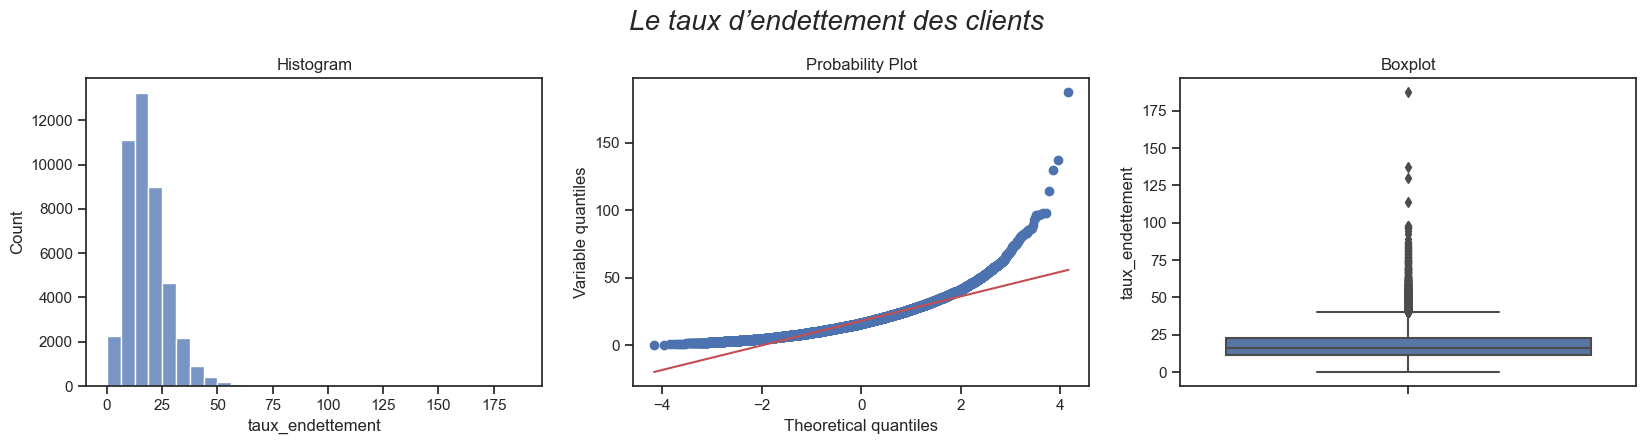

In [226]:
diagnostic_plots(clean_X_train, 'taux_endettement', "Le taux d’endettement des clients")

In [227]:
pd.qcut(round(clean_X_train.taux_endettement, 0), q=5).head()

0      (10.0, 14.0]
1      (10.0, 14.0]
2    (-0.001, 10.0]
3      (19.0, 25.0]
4      (14.0, 19.0]
Name: taux_endettement, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 10.0] < (10.0, 14.0] < (14.0, 19.0] < (19.0, 25.0] < (25.0, 188.0]]

In [228]:
clean_X_train['taux_endettement'] = pd.qcut(clean_X_train.taux_endettement,
                                      q=5,
                                      labels=['10%_et_mois',
                                              '11_a_14%',
                                              '15_a_19%',
                                              '20_a_25%',
                                              '26%_et_plus'])

clean_X_train['taux_endettement'].value_counts()

taux_endettement
15_a_19%       8814
10%_et_mois    8813
26%_et_plus    8813
11_a_14%       8812
20_a_25%       8811
Name: count, dtype: int64

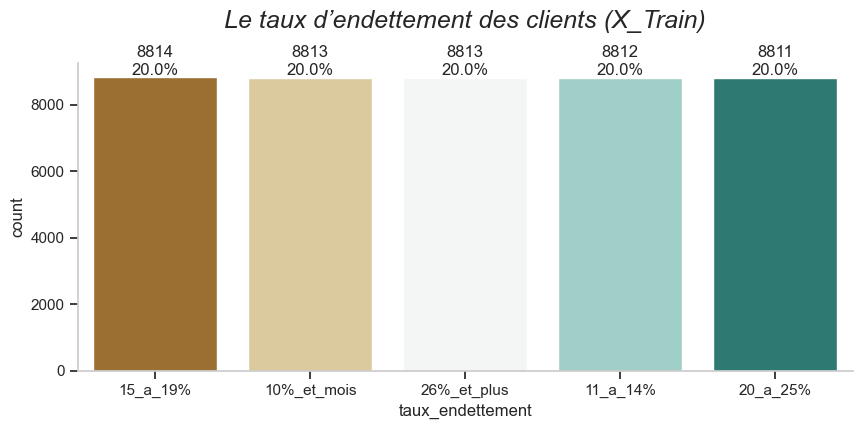

In [229]:
grah_barre(clean_X_train, 'taux_endettement', 'BrBG', "Le taux d’endettement des clients (X_Train)\n", (10, 4))

In [230]:
clean_X_test['taux_endettement'] = clean_X_test['AMT_ANNUITY'] / clean_X_test['AMT_INCOME_TOTAL'] * 100
clean_X_test['taux_endettement'].describe()

count   36,374.00
mean        18.29
std          9.59
min          0.57
25%         11.61
50%         16.55
75%         22.96
max        202.47
Name: taux_endettement, dtype: float64

In [231]:
clean_X_test['taux_endettement'] = pd.cut(round(clean_X_test.taux_endettement, 0),
                                          bins=[-1,
                                                10,
                                                14,
                                                19,
                                                25,
                                                300],
                                          include_lowest=True,
                                          labels=['10%_et_mois',
                                                  '11_a_14%',
                                                  '15_a_19%',
                                                  '20_a_25%',
                                                  '26%_et_plus'])

clean_X_test['taux_endettement'].value_counts()

taux_endettement
15_a_19%       8351
10%_et_mois    7266
11_a_14%       7165
26%_et_plus    6822
20_a_25%       6770
Name: count, dtype: int64

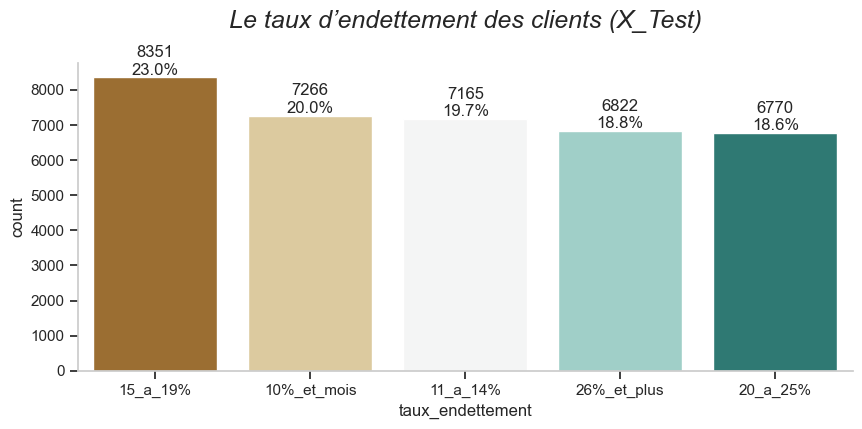

In [232]:
grah_barre(clean_X_test, 'taux_endettement', 'BrBG', "Le taux d’endettement des clients (X_Test)\n", (10, 4))

#### Durée mensuelle de remboursement du crédit

In [233]:
clean_X_train['duree_remboursement'] =  round(clean_X_train['AMT_CREDIT'] / clean_X_train['AMT_ANNUITY'], 0)
clean_X_train['duree_remboursement'].describe()

count   44,063.00
mean        21.64
std          7.84
min          8.00
25%         16.00
50%         20.00
75%         27.00
max         45.00
Name: duree_remboursement, dtype: float64

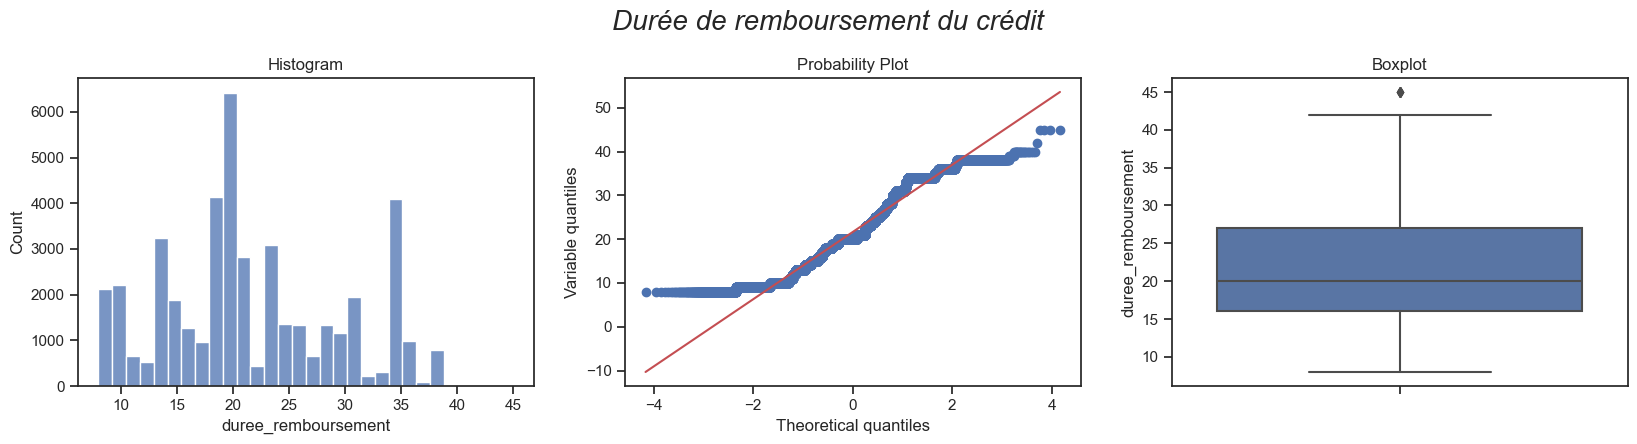

In [234]:
diagnostic_plots(clean_X_train, 'duree_remboursement', "Durée de remboursement du crédit")

In [235]:
pd.qcut(clean_X_train.duree_remboursement, q=3).head()

0    (7.999, 18.0]
1     (24.0, 45.0]
2     (18.0, 24.0]
3    (7.999, 18.0]
4     (18.0, 24.0]
Name: duree_remboursement, dtype: category
Categories (3, interval[float64, right]): [(7.999, 18.0] < (18.0, 24.0] < (24.0, 45.0]]

In [236]:
clean_X_train['duree_remboursement'] = pd.qcut(clean_X_train.duree_remboursement,
                                               q=3,
                                               labels=['18_mois_et_mois',
                                                       '19_a_24_mois',
                                                       '25_mois_et_plus'])

clean_X_train['duree_remboursement'].value_counts()

duree_remboursement
18_mois_et_mois    15042
19_a_24_mois       14739
25_mois_et_plus    14282
Name: count, dtype: int64

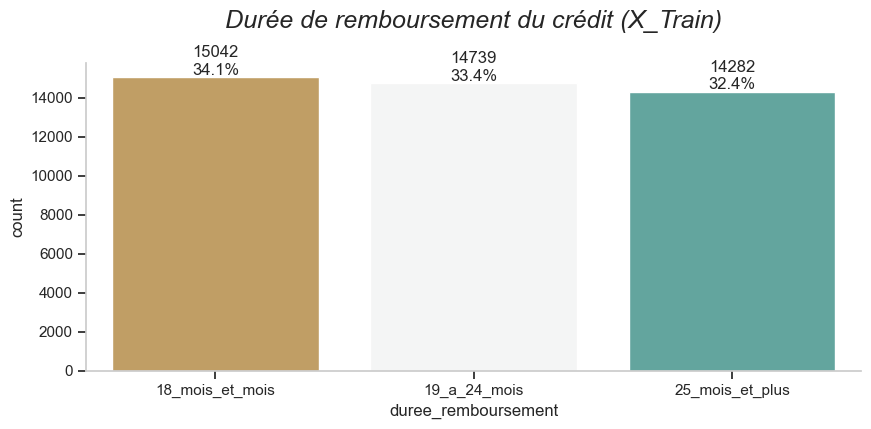

In [237]:
grah_barre(clean_X_train, 'duree_remboursement', 'BrBG', "Durée de remboursement du crédit (X_Train)\n", (10, 4))

In [238]:
clean_X_test['duree_remboursement'] =  round(clean_X_test['AMT_CREDIT'] / clean_X_test['AMT_ANNUITY'], 0)
clean_X_test['duree_remboursement'].describe()

count   36,374.00
mean        17.24
std          6.33
min          4.00
25%         13.00
50%         16.00
75%         21.00
max         72.00
Name: duree_remboursement, dtype: float64

In [239]:
clean_X_test['duree_remboursement'] = pd.cut(clean_X_test.duree_remboursement,
                                             bins=[-1,
                                                   18,
                                                   24,
                                                   100],
                                             include_lowest=True,
                                             labels=['18_mois_et_mois',
                                                     '19_a_24_mois',
                                                     '25_mois_et_plus'])


clean_X_test['duree_remboursement'].value_counts()

duree_remboursement
18_mois_et_mois    21597
19_a_24_mois       10305
25_mois_et_plus     4472
Name: count, dtype: int64

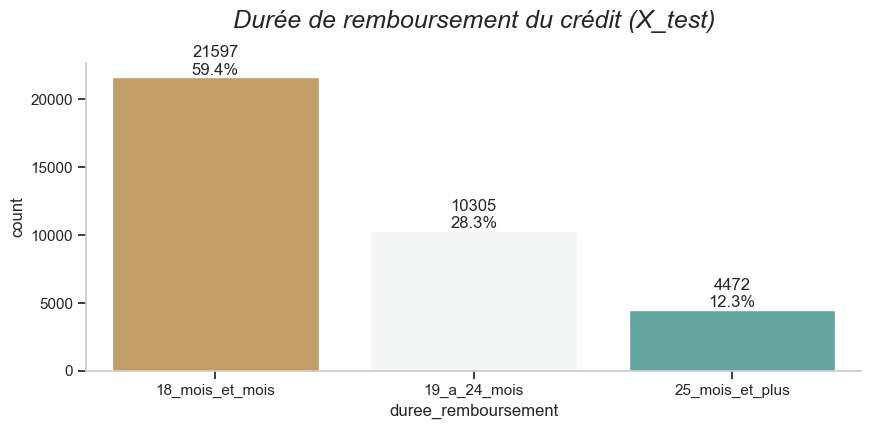

In [240]:
grah_barre(clean_X_test, 'duree_remboursement', 'BrBG', "Durée de remboursement du crédit (X_test)\n", (10, 4))

In [241]:
clean_X_train.drop(labels='AMT_ANNUITY', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='AMT_ANNUITY', 
                  axis=1, inplace=True)

clean_X_train.shape, clean_X_test.shape

((44063, 40), (36374, 40))

#### Les revenus mensuels des clients

In [242]:
clean_X_train['AMT_INCOME_TOTAL'].describe()

count        44,063.00
mean        170,950.69
std         565,219.02
min          25,650.00
25%         112,500.00
50%         144,000.00
75%         202,500.00
max     117,000,000.00
Name: AMT_INCOME_TOTAL, dtype: float64

In [243]:
pd.qcut(clean_X_train.AMT_INCOME_TOTAL, q=5).head(7)

0       (166500.0, 225000.0]
1    (225000.0, 117000000.0]
2       (25649.999, 99000.0]
3        (99000.0, 135000.0]
4        (99000.0, 135000.0]
5       (25649.999, 99000.0]
6       (166500.0, 225000.0]
Name: AMT_INCOME_TOTAL, dtype: category
Categories (5, interval[float64, right]): [(25649.999, 99000.0] < (99000.0, 135000.0] < (135000.0, 166500.0] < (166500.0, 225000.0] < (225000.0, 117000000.0]]

In [244]:
clean_X_train['total_revenus'] = pd.qcut(clean_X_train.AMT_INCOME_TOTAL,
                                         q=5,
                                         labels=['99000_et_moins',
                                                 '99001_a_135000',
                                                 '135001_a_162000',
                                                 '162001_a_225000',
                                                 '225001_et_plus'])

clean_X_train['total_revenus'].value_counts()

total_revenus
99001_a_135000     12244
162001_a_225000    10543
99000_et_moins      9204
225001_et_plus      6787
135001_a_162000     5285
Name: count, dtype: int64

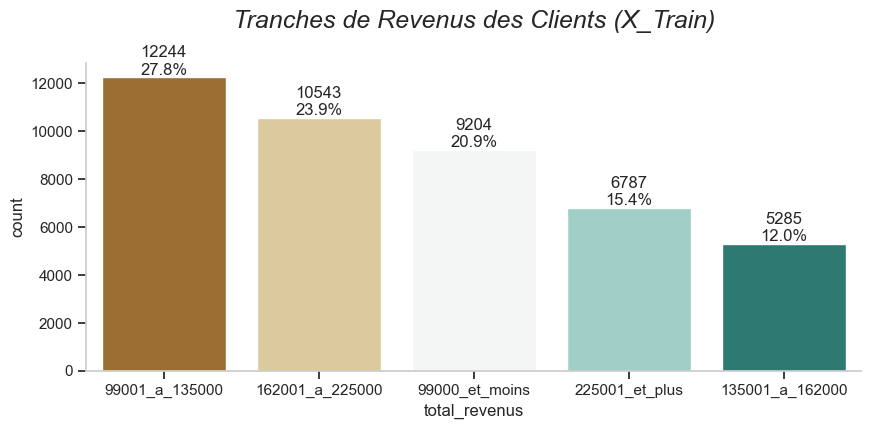

In [245]:
grah_barre(clean_X_train, 'total_revenus', 'BrBG', "Tranches de Revenus des Clients (X_Train)\n", (10, 4))

In [246]:
# Application à l'ensemble de test

clean_X_test['total_revenus'] = pd.cut(clean_X_test.AMT_INCOME_TOTAL,
                                       bins=[1,
                                             99000,
                                             135000,
                                             162000,
                                             225000,
                                             200000000],
                                       include_lowest=True,
                                       labels=['99000_et_moins',
                                               '99001_a_135000',
                                               '135001_a_162000',
                                               '162001_a_225000',
                                               '225001_et_plus'])

clean_X_test['total_revenus'].value_counts()

total_revenus
162001_a_225000    9913
99001_a_135000     9751
225001_et_plus     6423
99000_et_moins     5857
135001_a_162000    4430
Name: count, dtype: int64

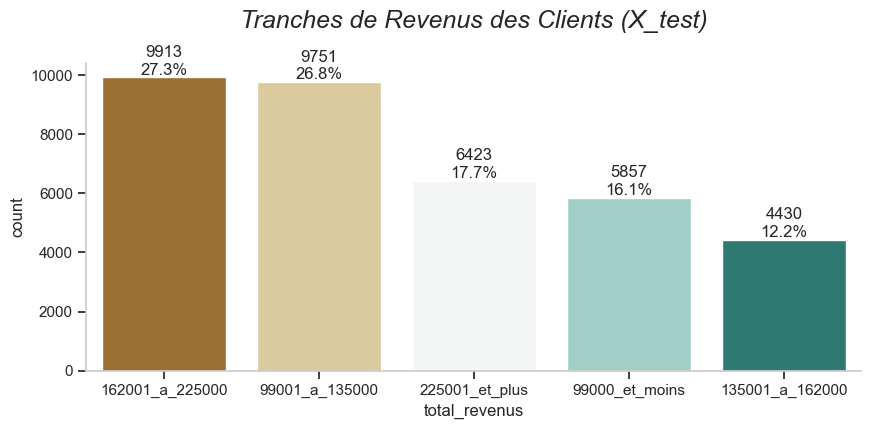

In [247]:
grah_barre(clean_X_test, 'total_revenus', 'BrBG', "Tranches de Revenus des Clients (X_test)\n", (10, 4))

In [248]:
# Suppression de la variable AMT_INCOME_TOTAL dans X_Train et X_Test

clean_X_train.drop(labels='AMT_INCOME_TOTAL', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='AMT_INCOME_TOTAL', 
                   axis=1, inplace=True)

clean_X_train.shape, clean_X_test.shape

((44063, 40), (36374, 40))

#### Le montant du crédit demandé par les clients

In [249]:
clean_X_train['AMT_CREDIT'].describe()

count      44,063.00
mean      600,033.72
std       402,405.01
min        45,000.00
25%       270,000.00
50%       517,500.00
75%       808,650.00
max     4,050,000.00
Name: AMT_CREDIT, dtype: float64

In [250]:
pd.qcut(clean_X_train.AMT_CREDIT, q=5).head(7)

0     (254700.0, 436032.0]
1    (900000.0, 4050000.0]
2    (44999.999, 254700.0]
3     (254700.0, 436032.0]
4     (436032.0, 610335.0]
5     (436032.0, 610335.0]
6    (900000.0, 4050000.0]
Name: AMT_CREDIT, dtype: category
Categories (5, interval[float64, right]): [(44999.999, 254700.0] < (254700.0, 436032.0] < (436032.0, 610335.0] < (610335.0, 900000.0] < (900000.0, 4050000.0]]

In [251]:
clean_X_train['montant_credit'] = pd.qcut(clean_X_train.AMT_CREDIT,
                                          q=5,
                                          labels=['254700_et_moins',
                                                  '254701_a_432000',
                                                  '432001_a_604152',
                                                  '604153_a_900000',
                                                  '900001_et_plus'])

clean_X_train['montant_credit'].value_counts()

montant_credit
254700_et_moins    9372
604153_a_900000    9070
432001_a_604152    8773
900001_et_plus     8536
254701_a_432000    8312
Name: count, dtype: int64

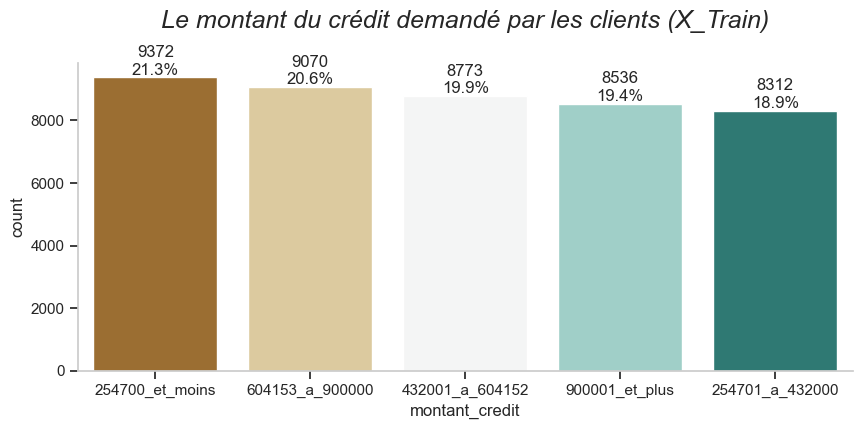

In [252]:
grah_barre(clean_X_train, 'montant_credit', 'BrBG', "Le montant du crédit demandé par les clients (X_Train)\n", (10, 4))

In [253]:
clean_X_test['AMT_CREDIT'].describe()

count      36,374.00
mean      515,845.22
std       364,637.89
min        45,000.00
25%       260,640.00
50%       450,000.00
75%       675,000.00
max     2,160,000.00
Name: AMT_CREDIT, dtype: float64

In [254]:
# Application à l'ensemble de test

clean_X_test['montant_credit'] = pd.cut(clean_X_test.AMT_CREDIT,
                                        bins=[1,
                                              254700,
                                              432000,
                                              604152,
                                              900000,
                                              5000000],
                                        include_lowest=True,
                                        labels=['254700_et_moins',
                                                '254701_a_432000',
                                                '432001_a_604152',
                                                '604153_a_900000',
                                                '900001_et_plus'])

clean_X_test['montant_credit'].value_counts()

montant_credit
254701_a_432000    8813
254700_et_moins    8709
432001_a_604152    8354
604153_a_900000    6289
900001_et_plus     4209
Name: count, dtype: int64

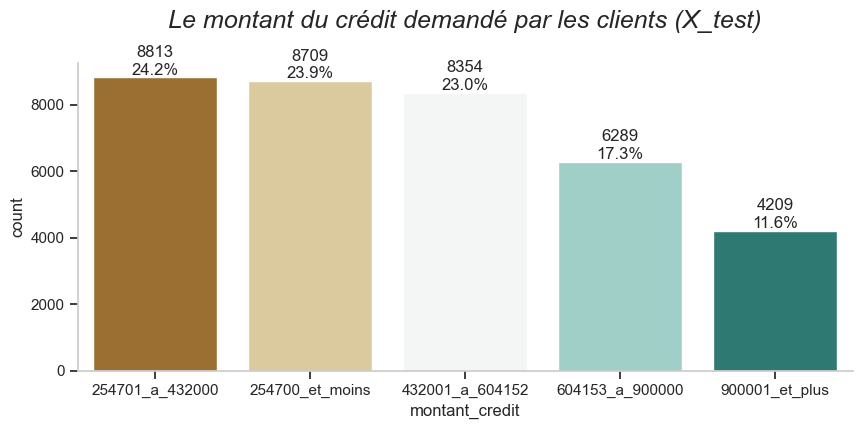

In [255]:
grah_barre(clean_X_test, 'montant_credit', 'BrBG', "Le montant du crédit demandé par les clients (X_test)\n", (10, 4))

In [256]:
# Suppression de la variable AMT_CREDIT dans X_Train et X_Test

clean_X_train.drop(labels='AMT_CREDIT', 
                   axis=1, inplace=True)

clean_X_test.drop(labels='AMT_CREDIT', 
                   axis=1, inplace=True)

clean_X_train.shape, clean_X_test.shape

((44063, 40), (36374, 40))

#### Score normalisé à partir d'une source de données externe

In [257]:
clean_X_train['EXT_SOURCE_2'].describe()

count   44,063.00
mean         0.51
std          0.19
min          0.00
25%          0.39
50%          0.57
75%          0.66
max          0.85
Name: EXT_SOURCE_2, dtype: float64

In [258]:
clean_X_train['TARGET'] = y_train

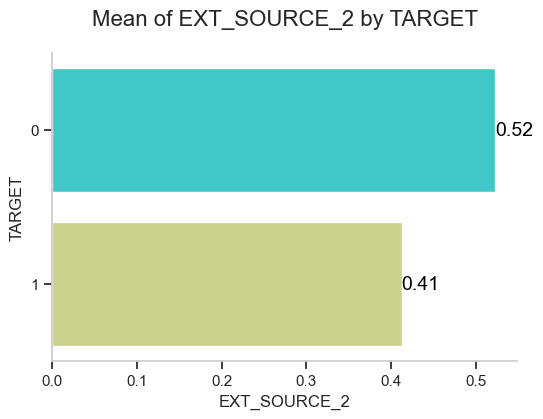

In [259]:
plot_aggregation(df=clean_X_train, 
                 group_col='TARGET', 
                 value_col='EXT_SOURCE_2', 
                 aggreg='mean',
                 figsize=(6,4),
                 orient = 'h')

Puisqu'elle n'a pas de valeurs aberrantes, nous conservons cette variable telle quelle.

## Conclusion sur le data Cleaning des ensembles d'entraînement et de test

Nous avons donc maintenant un dataset principal comprenant 39 variables explicatives, soit une diminution de 67,2%.
Toutes les features, sauf le Score normalisé à partir d'une source de données externe, sont des variables qualitatives qu'il faudra "numériser" pour utiliser les modèles de classification de machine learning.

In [260]:
clean_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44063 entries, 0 to 44062
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   SK_ID_CURR                   44063 non-null  int64   
 1   NAME_CONTRACT_TYPE           44063 non-null  object  
 2   CODE_GENDER                  44063 non-null  object  
 3   FLAG_OWN_CAR                 44063 non-null  object  
 4   FLAG_OWN_REALTY              44063 non-null  object  
 5   NAME_TYPE_SUITE              44063 non-null  object  
 6   NAME_INCOME_TYPE             44061 non-null  object  
 7   NAME_EDUCATION_TYPE          44063 non-null  object  
 8   NAME_FAMILY_STATUS           44063 non-null  object  
 9   NAME_HOUSING_TYPE            44063 non-null  object  
 10  FLAG_EMP_PHONE               44063 non-null  object  
 11  FLAG_WORK_PHONE              44063 non-null  object  
 12  FLAG_PHONE                   44063 non-null  object  
 13  F

In [261]:
clean_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36374 entries, 0 to 36373
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   SK_ID_CURR                   36374 non-null  int64   
 1   NAME_CONTRACT_TYPE           36374 non-null  object  
 2   CODE_GENDER                  36374 non-null  object  
 3   FLAG_OWN_CAR                 36374 non-null  object  
 4   FLAG_OWN_REALTY              36374 non-null  object  
 5   NAME_TYPE_SUITE              36374 non-null  object  
 6   NAME_INCOME_TYPE             36373 non-null  object  
 7   NAME_EDUCATION_TYPE          36374 non-null  object  
 8   NAME_FAMILY_STATUS           36374 non-null  object  
 9   NAME_HOUSING_TYPE            36374 non-null  object  
 10  FLAG_EMP_PHONE               36374 non-null  object  
 11  FLAG_WORK_PHONE              36374 non-null  object  
 12  FLAG_PHONE                   36374 non-null  object  
 13  F

# Les demandes antérieures de crédit des clients

Ce fichier regroupe toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

Un prêt de l'échantillon principal peut avoir 0, 1, 2 demandes de prêt précédentes ou plus dans Home Credit, une demande précédente pourrait, mais pas nécessairement, conduire à un crédit.

In [262]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [263]:
previous_application.isna().mean().sort_values(ascending=False) * 100

RATE_INTEREST_PRIVILEGED      99.64
RATE_INTEREST_PRIMARY         99.64
AMT_DOWN_PAYMENT              53.64
RATE_DOWN_PAYMENT             53.64
NAME_TYPE_SUITE               49.12
NFLAG_INSURED_ON_APPROVAL     40.30
DAYS_TERMINATION              40.30
DAYS_LAST_DUE                 40.30
DAYS_LAST_DUE_1ST_VERSION     40.30
DAYS_FIRST_DUE                40.30
DAYS_FIRST_DRAWING            40.30
AMT_GOODS_PRICE               23.08
AMT_ANNUITY                   22.29
CNT_PAYMENT                   22.29
PRODUCT_COMBINATION            0.02
AMT_CREDIT                     0.00
NAME_YIELD_GROUP               0.00
NAME_PORTFOLIO                 0.00
NAME_SELLER_INDUSTRY           0.00
SELLERPLACE_AREA               0.00
CHANNEL_TYPE                   0.00
NAME_PRODUCT_TYPE              0.00
SK_ID_PREV                     0.00
NAME_GOODS_CATEGORY            0.00
NAME_CLIENT_TYPE               0.00
CODE_REJECT_REASON             0.00
SK_ID_CURR                     0.00
DAYS_DECISION               

In [264]:
# Suppression des variables avec valeurs manquantes
var_to_drop = [var for var in previous_application.columns if previous_application[var].isnull().mean() > 0.2]
print(var_to_drop)

['AMT_ANNUITY', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_TYPE_SUITE', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


In [265]:
previous_application.drop(labels=var_to_drop, axis=1, inplace=True)

## Les variables numériques

In [266]:
# Les variables numériques
var_num = previous_application.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).select_dtypes(include=[np.number]).columns.to_list()
print(var_num)

['AMT_APPLICATION', 'AMT_CREDIT', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'SELLERPLACE_AREA']


In [267]:
previous_application.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).select_dtypes(include=[np.number]).describe()

AMT_APPLICATION   AMT_CREDIT  HOUR_APPR_PROCESS_START  \
count     1,670,214.00 1,670,213.00             1,670,214.00   
mean        175,233.86   196,114.02                    12.48   
std         292,779.76   318,574.62                     3.33   
min               0.00         0.00                     0.00   
25%          18,720.00    24,160.50                    10.00   
50%          71,046.00    80,541.00                    12.00   
75%         180,360.00   216,418.50                    15.00   
max       6,905,160.00 6,905,160.00                    23.00   

       NFLAG_LAST_APPL_IN_DAY  DAYS_DECISION  SELLERPLACE_AREA  
count            1,670,214.00   1,670,214.00      1,670,214.00  
mean                     1.00        -880.68            313.95  
std                      0.06         779.10          7,127.44  
min                      0.00      -2,922.00             -1.00  
25%                      1.00      -1,300.00             -1.00  
50%                      1.00        -581.00              3.00  
75%                      1.00        -280.00             82.00  
max                      1.00          -1.00      4,000,000.00

In [268]:
# Indique si l'application était la dernière application par jour du client. 
# Parfois, les clients demandent plus d'applications par jour. 
# Rarement, il peut également s'agir d'une erreur du système 
# selon laquelle une application se trouve deux fois dans la base de données

previous_application['NFLAG_LAST_APPL_IN_DAY'].value_counts()

NFLAG_LAST_APPL_IN_DAY
1    1664314
0       5900
Name: count, dtype: int64

In [269]:
previous_application.query('NFLAG_LAST_APPL_IN_DAY == 1', inplace=True)

previous_application.drop(labels='NFLAG_LAST_APPL_IN_DAY', axis=1, inplace=True)

previous_application.shape

(1664314, 22)

In [270]:
# Suppression de la zone de ventes des demandes précédentes !! 

previous_application.drop(labels='SELLERPLACE_AREA', axis=1, inplace=True)

previous_application.shape

(1664314, 21)

In [271]:
# Calcul nb_jours_depuis_demande_precedente
previous_application['DAYS_DECISION'] = round(previous_application['DAYS_DECISION'] / -365, 0)

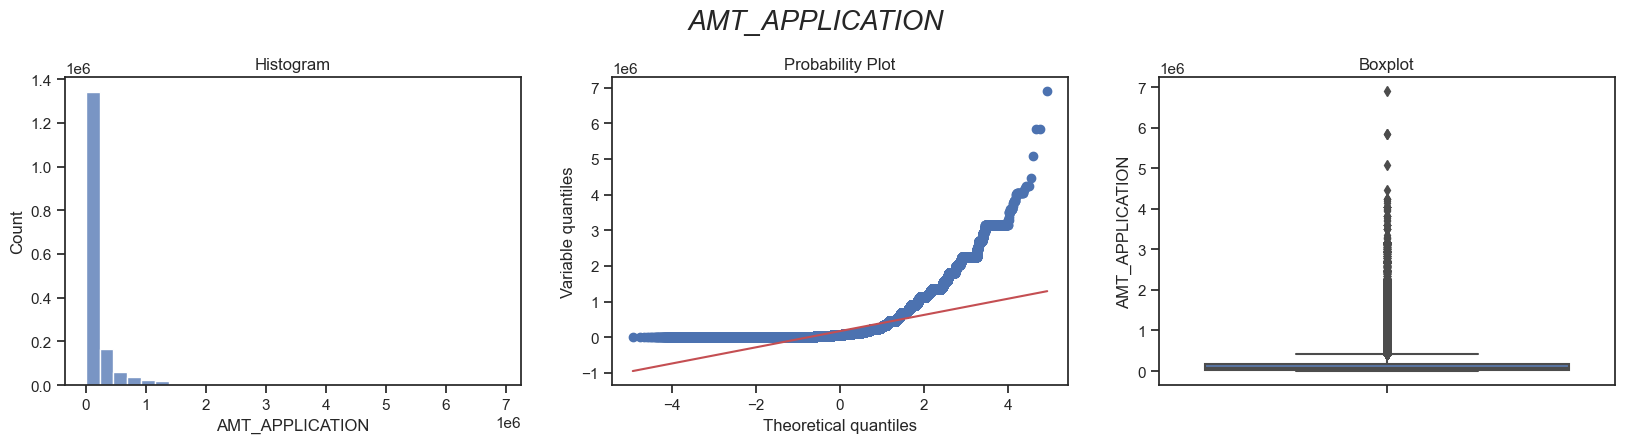

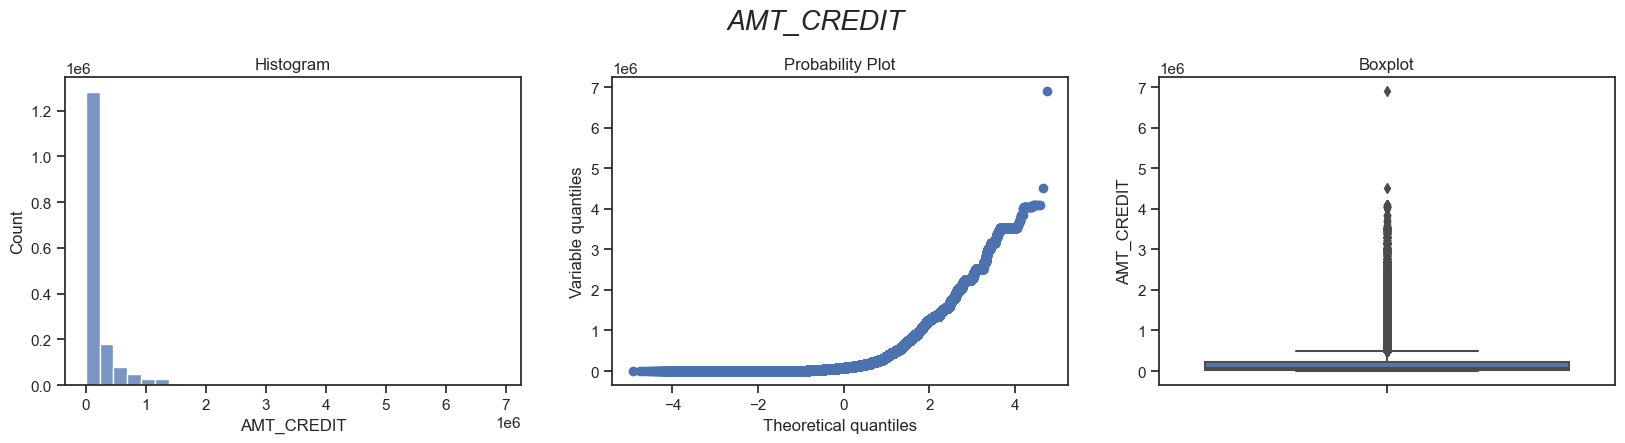

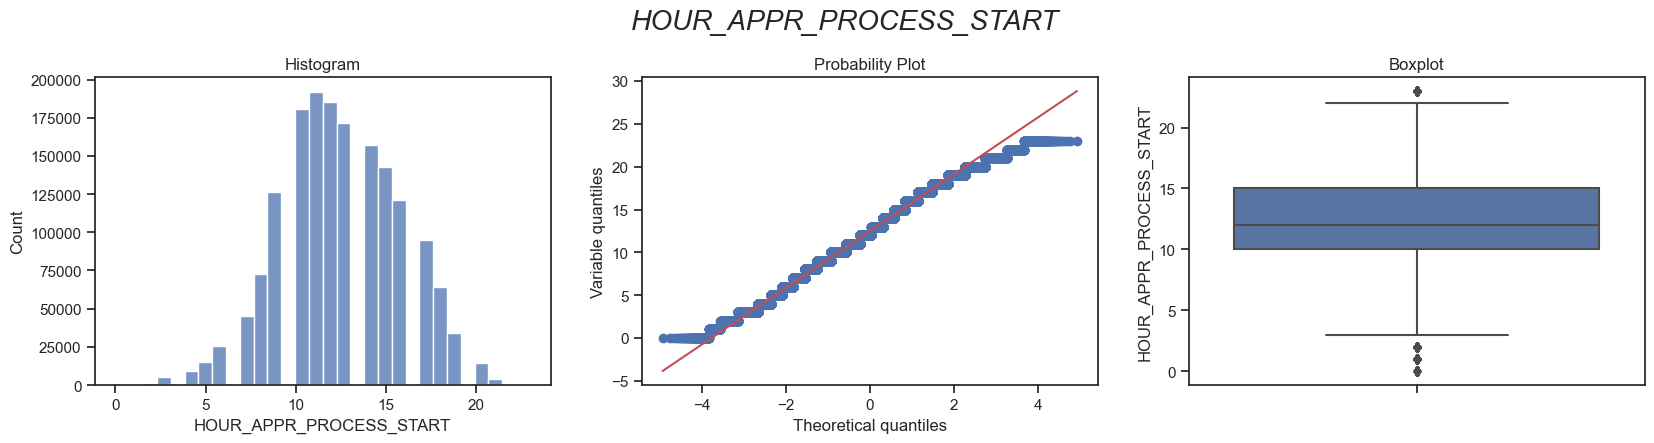

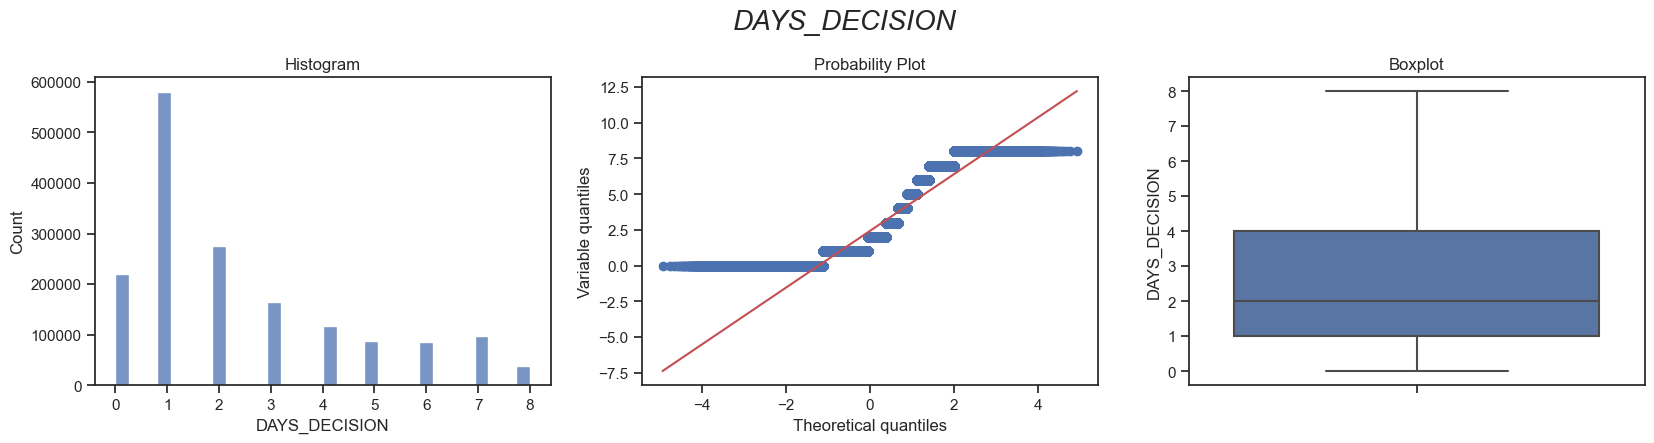

In [272]:
var_num = ['AMT_APPLICATION', 'AMT_CREDIT', 'HOUR_APPR_PROCESS_START', 'DAYS_DECISION']

for var in var_num:
    diagnostic_plots(previous_application, var, f"{var}")

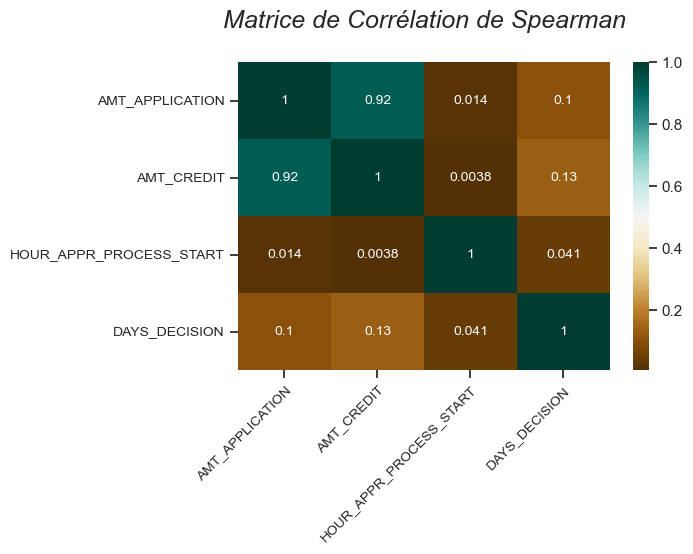

In [273]:
sns.set(style="ticks", rc={'figure.figsize': (6, 4)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = previous_application.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 10})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

2 variables sont très corrélées entre elles (92% de corrélation) : le montant des crédits demandés par les clients ('AMT_APPLICATION') et celui qui leur a été accordé ('AMT_CREDIT'). On conserve cette dernière.

In [274]:
prev_appli_1 = previous_application.groupby(['SK_ID_CURR'], as_index=False).agg({'SK_ID_PREV': 'count',
                                                                                 'AMT_CREDIT': 'mean',
                                                                                 'HOUR_APPR_PROCESS_START': 'mean',
                                                                                 'DAYS_DECISION': 'mean'})

In [275]:
prev_appli_1.drop(labels=['SK_ID_CURR'], axis=1).describe()

SK_ID_PREV   AMT_CREDIT  HOUR_APPR_PROCESS_START  DAYS_DECISION
count  338,810.00   338,810.00               338,810.00     338,810.00
mean         4.91   170,062.88                    12.67           2.52
std          4.20   164,996.61                     2.78           1.59
min          1.00         0.00                     0.00           0.00
25%          2.00    67,255.71                    11.00           1.25
50%          4.00   117,845.16                    12.77           2.06
75%          7.00   215,889.32                    14.50           3.40
max         77.00 4,050,000.00                    23.00           8.00

In [276]:
prev_appli_1 = prev_appli_1.rename(columns={'SK_ID_PREV': 'nb_demande_pret_precedente',
                                            'AMT_CREDIT': 'montant_demande_pret_precedente',
                                            'HOUR_APPR_PROCESS_START': 'heure_demande_pret_precedente',
                                            'DAYS_DECISION': 'nb_year_depuis_decision_precedente'})

In [277]:
#Fusion avec clean_X_train

clean_X_train_join1 = clean_X_train.merge(prev_appli_1, how='left', on='SK_ID_CURR')
clean_X_train_join1.shape

(44063, 45)

In [278]:
clean_X_train_join1.isna().mean() *100

SK_ID_CURR                           0.00
NAME_CONTRACT_TYPE                   0.00
CODE_GENDER                          0.00
FLAG_OWN_CAR                         0.00
FLAG_OWN_REALTY                      0.00
NAME_TYPE_SUITE                      0.00
NAME_INCOME_TYPE                     0.00
NAME_EDUCATION_TYPE                  0.00
NAME_FAMILY_STATUS                   0.00
NAME_HOUSING_TYPE                    0.00
FLAG_EMP_PHONE                       0.00
FLAG_WORK_PHONE                      0.00
FLAG_PHONE                           0.00
FLAG_EMAIL                           0.00
REGION_RATING_CLIENT                 0.00
REGION_RATING_CLIENT_W_CITY          0.00
WEEKDAY_APPR_PROCESS_START           0.00
REG_REGION_NOT_LIVE_REGION           0.00
REG_REGION_NOT_WORK_REGION           0.00
LIVE_REGION_NOT_WORK_REGION          0.00
REG_CITY_NOT_LIVE_CITY               0.00
REG_CITY_NOT_WORK_CITY               0.00
LIVE_CITY_NOT_WORK_CITY              0.00
EXT_SOURCE_2                      

5,4% des clients de l'ensemble d'entraînement n'ont pas fait de demande précédente de prêt. Nous remplaçons donc les valeurs manquantes par 0.

In [279]:
var_num = ['nb_demande_pret_precedente', 'montant_demande_pret_precedente', 'heure_demande_pret_precedente', 'nb_year_depuis_decision_precedente']

for var in var_num:
    clean_X_train_join1[var].fillna(0, inplace=True)


In [280]:
clean_X_train_join1[var_num].isna().mean() *100

nb_demande_pret_precedente           0.00
montant_demande_pret_precedente      0.00
heure_demande_pret_precedente        0.00
nb_year_depuis_decision_precedente   0.00
dtype: float64

In [281]:
#Fusion avec clean_X_test

clean_X_test_join1 = clean_X_test.merge(prev_appli_1, how='left', on='SK_ID_CURR')
clean_X_test_join1.shape

(36374, 44)

In [282]:
clean_X_test_join1.isna().mean() *100

SK_ID_CURR                           0.00
NAME_CONTRACT_TYPE                   0.00
CODE_GENDER                          0.00
FLAG_OWN_CAR                         0.00
FLAG_OWN_REALTY                      0.00
NAME_TYPE_SUITE                      0.00
NAME_INCOME_TYPE                     0.00
NAME_EDUCATION_TYPE                  0.00
NAME_FAMILY_STATUS                   0.00
NAME_HOUSING_TYPE                    0.00
FLAG_EMP_PHONE                       0.00
FLAG_WORK_PHONE                      0.00
FLAG_PHONE                           0.00
FLAG_EMAIL                           0.00
REGION_RATING_CLIENT                 0.00
REGION_RATING_CLIENT_W_CITY          0.00
WEEKDAY_APPR_PROCESS_START           0.00
REG_REGION_NOT_LIVE_REGION           0.00
REG_REGION_NOT_WORK_REGION           0.00
LIVE_REGION_NOT_WORK_REGION          0.00
REG_CITY_NOT_LIVE_CITY               0.00
REG_CITY_NOT_WORK_CITY               0.00
LIVE_CITY_NOT_WORK_CITY              0.00
EXT_SOURCE_2                      

2% des clients de l'ensemble de test n'ont pas fait de demande précédente de prêt. Nous remplaçons donc les valeurs manquantes par 0.

In [283]:
var_num = ['nb_demande_pret_precedente', 'montant_demande_pret_precedente', 'heure_demande_pret_precedente', 'nb_year_depuis_decision_precedente']

for var in var_num:
    clean_X_test_join1[var].fillna(0, inplace=True)

In [284]:
clean_X_test_join1[var_num].isna().mean() *100

nb_demande_pret_precedente           0.00
montant_demande_pret_precedente      0.00
heure_demande_pret_precedente        0.00
nb_year_depuis_decision_precedente   0.00
dtype: float64

## Les variables qualitatives

In [285]:
cat_var = previous_application.select_dtypes(exclude=[np.number]).columns.to_list()
print(cat_var)

['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']


In [286]:
# Categorical Variables
def cat_analyzer(dataframe, variable):
    print(variable)
    print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe) *100}), end="\n\n\n")
    

for i in cat_var:
    cat_analyzer(previous_application, i)

NAME_CONTRACT_TYPE
                     COUNT  RATIO
NAME_CONTRACT_TYPE               
Cash loans          747147  44.89
Consumer loans      728870  43.79
Revolving loans     187951  11.29
XNA                    346   0.02


WEEKDAY_APPR_PROCESS_START
                             COUNT  RATIO
WEEKDAY_APPR_PROCESS_START               
TUESDAY                     254289  15.28
WEDNESDAY                   253363  15.22
MONDAY                      252780  15.19
FRIDAY                      251190  15.09
THURSDAY                    248311  14.92
SATURDAY                    239993  14.42
SUNDAY                      164388   9.88


FLAG_LAST_APPL_PER_CONTRACT
                               COUNT  RATIO
FLAG_LAST_APPL_PER_CONTRACT                
Y                            1660953  99.80
N                               3361   0.20


NAME_CASH_LOAN_PURPOSE
                                   COUNT  RATIO
NAME_CASH_LOAN_PURPOSE                         
XAP                               917167  5

De nombreuses variables qualitatives ont des valeurs manquantes, nous ne les prendrons pas en compte.

En fait, seules 2 variables apparaissent intéressantes pour notre objectif : `NAME_CONTRACT_STATUS` et `NAME_CONTRACT_TYPE`.

### Statut du contrat (actif signé,...) de crédit précédent

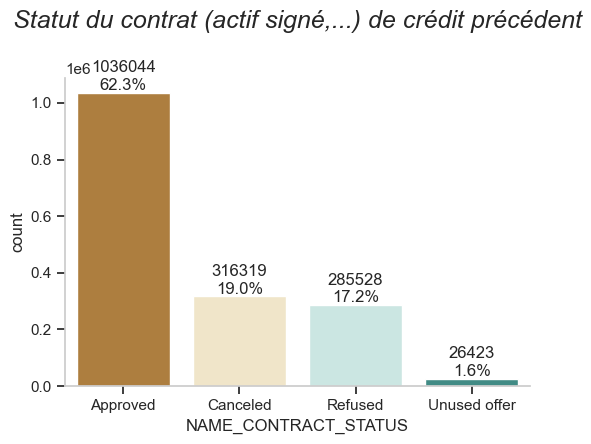

In [287]:
grah_barre(previous_application, 'NAME_CONTRACT_STATUS', 'BrBG', "Statut du contrat (actif signé,...) de crédit précédent\n", (6, 4))

In [288]:
map_status = {'Approved' : 'approved',
              'Canceled' : 'canceled_unused',
              'Refused' : 'refused',
              'Unused offer' : 'canceled_unused'}

previous_application['NAME_CONTRACT_STATUS'] = previous_application['NAME_CONTRACT_STATUS'].map(map_status)

### Type de contrat de crédit (Prêt de trésorerie, prêt à la consommation [POS],...) de la demande précédente	

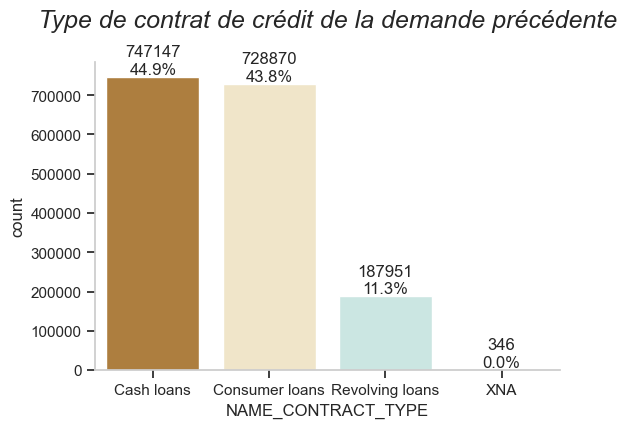

In [289]:
grah_barre(previous_application, 'NAME_CONTRACT_TYPE', 'BrBG', "Type de contrat de crédit de la demande précédente\n", (6, 4))

In [290]:
map_contrat_type = {'Cash loans': 'cash_loans',
                    'Consumer loans': 'consumer_loans',
                    'Revolving loans': 'revolving_loans',
                    'XNA': 'revolving_loans'}

previous_application['NAME_CONTRACT_TYPE'] = previous_application['NAME_CONTRACT_TYPE'].map(map_contrat_type)

In [291]:
print(previous_application.columns.to_list())

['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_APPLICATION', 'AMT_CREDIT', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']


In [292]:
prev_appli_2 = previous_application[['SK_ID_CURR', 'NAME_CONTRACT_TYPE','NAME_CONTRACT_STATUS']]

In [293]:
prev_appli_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1664314 entries, 0 to 1670213
Data columns (total 3 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   SK_ID_CURR            1664314 non-null  int64 
 1   NAME_CONTRACT_TYPE    1664314 non-null  object
 2   NAME_CONTRACT_STATUS  1664314 non-null  object
dtypes: int64(1), object(2)
memory usage: 50.8+ MB


### Quantification des variables catégorielles

Les données catégorielles ne sont pas utilisables avec tous les algotithmes de Machine Learning. C'est la raison pour laquelle nous devons donc les quantifier.

Mais, **nous devons être prudents lorsqu'il s'agit d'encoder des catégories sous forme de nombres. Nous voulons nous assurer que la relation numérique a un sens pour un modèle.**

**Les variables catégorielles ordinales, peuvent être remplacées par une valeur chiffrée.** Ce sont des variables catégorielles dont les valeurs suivent un ordre naturel.

Pour les variables catégorielles nominales en revanche, cela fausserait la signification de la colonne en donnant plus de poids à une modalité qu'à une autre. Ce sont des variables catégorielles dont les valeurs ne suivent pas un ordre naturel.
**Pour ces variables non ordonnées, la technique de quantification utilisée est la "dummification"** qui va créer des dummy variables. La variable initiale est alors remplacée par un ensemble de nouvelles variables dites fictives (ou indicatrices) prenant les valeurs 0 ou 1 pour indiquer l'absence ou la présence de la modalité. Néanmoins, pour éviter la multicolinéarité qui se produit lorsque un ensemble exhaustif de variables fictives et le terme constant sont présents, ce qu'on appelle le piège à variable fictive, il est impératif de supprimer soit le terme constant, soit l'une des indicatrices incriminées. La variable fictive retirée devient alors la catégorie de base à laquelle les autres catégories sont comparées.

In [294]:
prev_appli_2 = pd.get_dummies(prev_appli_2,
                              columns=["NAME_CONTRACT_STATUS",
                                       "NAME_CONTRACT_TYPE"],
                              prefix={'NAME_CONTRACT_STATUS': 'prev_contrat_statut',
                                      'NAME_CONTRACT_TYPE': 'prev_contrat_type'},
                              drop_first=True)

In [295]:
prev_appli_2.head()

SK_ID_CURR  prev_contrat_statut_canceled_unused  \
0      271877                                False   
1      108129                                False   
2      122040                                False   
3      176158                                False   
4      202054                                False   

   prev_contrat_statut_refused  prev_contrat_type_consumer_loans  \
0                        False                              True   
1                        False                             False   
2                        False                             False   
3                        False                             False   
4                         True                             False   

   prev_contrat_type_revolving_loans  
0                              False  
1                              False  
2                              False  
3                              False  
4                              False

In [296]:
prev_appli_2 = prev_appli_2.groupby(['SK_ID_CURR'], as_index=False).sum()

In [297]:
prev_appli_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338810 entries, 0 to 338809
Data columns (total 5 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   SK_ID_CURR                           338810 non-null  int64
 1   prev_contrat_statut_canceled_unused  338810 non-null  int64
 2   prev_contrat_statut_refused          338810 non-null  int64
 3   prev_contrat_type_consumer_loans     338810 non-null  int64
 4   prev_contrat_type_revolving_loans    338810 non-null  int64
dtypes: int64(5)
memory usage: 12.9 MB


In [298]:
liste_var = prev_appli_2.drop(labels='SK_ID_CURR', axis=1).columns.to_list()
print(liste_var)

['prev_contrat_statut_canceled_unused', 'prev_contrat_statut_refused', 'prev_contrat_type_consumer_loans', 'prev_contrat_type_revolving_loans']


In [299]:
#Fusion avec clean_X_train_join1

clean_X_train_join2 = clean_X_train_join1.merge(prev_appli_2, how='left', on='SK_ID_CURR')
clean_X_train_join2.shape

(44063, 49)

In [300]:
clean_X_train_join2[liste_var].isna().mean() *100

prev_contrat_statut_canceled_unused   5.22
prev_contrat_statut_refused           5.22
prev_contrat_type_consumer_loans      5.22
prev_contrat_type_revolving_loans     5.22
dtype: float64

In [301]:
for var in liste_var:
    clean_X_train_join2[var].fillna(0, inplace=True)

In [302]:
clean_X_train_join2[liste_var].isna().mean() *100

prev_contrat_statut_canceled_unused   0.00
prev_contrat_statut_refused           0.00
prev_contrat_type_consumer_loans      0.00
prev_contrat_type_revolving_loans     0.00
dtype: float64

In [303]:
#Fusion avec clean_X_test_join1

clean_X_test_join2 = clean_X_test_join1.merge(prev_appli_2, how='left', on='SK_ID_CURR')
clean_X_test_join2.shape

(36374, 48)

In [304]:
clean_X_test_join2[liste_var].isna().mean() *100

prev_contrat_statut_canceled_unused   1.91
prev_contrat_statut_refused           1.91
prev_contrat_type_consumer_loans      1.91
prev_contrat_type_revolving_loans     1.91
dtype: float64

In [305]:
for var in liste_var:
    clean_X_test_join2[var].fillna(0, inplace=True)

clean_X_test_join2[liste_var].isna().mean() *100

prev_contrat_statut_canceled_unused   0.00
prev_contrat_statut_refused           0.00
prev_contrat_type_consumer_loans      0.00
prev_contrat_type_revolving_loans     0.00
dtype: float64

In [306]:
clean_X_train_join2.shape, clean_X_test_join2.shape

((44063, 49), (36374, 48))

# Historique de remboursement des crédits précédents

In [307]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [308]:
installments_payments.isna().mean() * 100

SK_ID_PREV               0.00
SK_ID_CURR               0.00
NUM_INSTALMENT_VERSION   0.00
NUM_INSTALMENT_NUMBER    0.00
DAYS_INSTALMENT          0.00
DAYS_ENTRY_PAYMENT       0.02
AMT_INSTALMENT           0.00
AMT_PAYMENT              0.02
dtype: float64

In [309]:
liste_var = ['DAYS_ENTRY_PAYMENT', 'AMT_PAYMENT']

for var in liste_var:
    installments_payments[var].fillna(0, inplace=True)

In [310]:
installments_payments.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).describe()

NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
count           13,605,401.00          13,605,401.00    13,605,401.00   
mean                     0.86                  18.87        -1,042.27   
std                      1.04                  26.66           800.95   
min                      0.00                   1.00        -2,922.00   
25%                      0.00                   4.00        -1,654.00   
50%                      1.00                   8.00          -818.00   
75%                      1.00                  19.00          -361.00   
max                    178.00                 277.00            -1.00   

       DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  
count       13,605,401.00   13,605,401.00 13,605,401.00  
mean            -1,050.89       17,050.91     17,234.54  
std                800.65       50,570.25     54,730.52  
min             -4,921.00            0.00          0.00  
25%             -1,662.00        4,226.09      3,394.17  
50%               -827.00        8,884.08      8,122.19  
75%               -370.00       16,710.21     16,105.91  
max                  0.00    3,771,487.85  3,771,487.85

In [311]:
installments_payments['DAYS_INSTALMENT'] = round(installments_payments['DAYS_INSTALMENT'] / -365, 0)
installments_payments['DAYS_ENTRY_PAYMENT'] = round(installments_payments['DAYS_ENTRY_PAYMENT'] / -365, 0)

In [312]:
ins_payments = installments_payments.groupby(['SK_ID_CURR'], as_index=False).agg({'NUM_INSTALMENT_VERSION': 'nunique',
                                                                                  'NUM_INSTALMENT_NUMBER': 'sum', 
                                                                                  'DAYS_INSTALMENT': 'mean', 
                                                                                  'DAYS_ENTRY_PAYMENT': 'mean',
                                                                                  'AMT_INSTALMENT': 'sum',
                                                                                  'AMT_PAYMENT': 'sum'})

ins_payments.drop(labels='SK_ID_CURR', axis=1).describe()

NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  \
count              339,587.00             339,587.00       339,587.00   
mean                     2.30                 756.05             2.48   
std                      1.87               1,892.40             1.66   
min                      1.00                   1.00             0.00   
25%                      1.00                  62.00             1.10   
50%                      2.00                 156.00             2.16   
75%                      3.00                 440.50             3.56   
max                     59.00              43,919.00             8.00   

       DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  
count          339,587.00      339,587.00    339,587.00  
mean                 2.51      683,136.95    690,494.23  
std                  1.65      893,380.54    930,897.69  
min                  0.00            0.00          0.00  
25%                  1.14      136,683.36    133,200.74  
50%                  2.19      334,395.22    324,803.52  
75%                  3.59      857,772.74    849,730.91  
max                  8.00   32,479,781.27 32,689,281.51

In [313]:
# Montant payé vs Montant attendu
# Le client a-t-il réglé toutes ces mensualités attendues des crédits précédents ?


ins_payments['montant_paye_vs_du'] = np.where(ins_payments['AMT_INSTALMENT'] != 0,
                                                   ins_payments['AMT_PAYMENT'] / ins_payments['AMT_INSTALMENT'] * 100, 0)

ins_payments['montant_paye_vs_du'].describe()

count   339,587.00
mean         99.34
std          13.71
min           0.00
25%          96.24
50%         100.00
75%         100.00
max         548.51
Name: montant_paye_vs_du, dtype: float64

In [314]:
ins_payments[ins_payments['montant_paye_vs_du'] > 100]

SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
11          100012                       4                    434   
18          100019                       3                     34   
31          100034                       4                     26   
36          100039                       8                     74   
56          100060                       4                     17   
...            ...                     ...                    ...   
339533      456201                       5                     19   
339534      456202                       5                    112   
339539      456207                       3                     11   
339559      456227                       3                    286   
339586      456255                       4                    655   

        DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  \
11                 1.77                1.83      460,056.15   501,661.71   
18                 2.00                2.00      120,723.75   165,093.03   
31                 1.10                1.20      252,855.76   311,355.77   
36                 3.38                3.48    1,715,314.50 2,305,501.79   
56                 1.00                1.00      218,546.55   308,546.55   
...                 ...                 ...             ...          ...   
339533             0.78                0.78      240,004.17   352,504.17   
339534             0.76                0.80      436,163.67   491,657.67   
339539             0.00                0.00      147,171.46   187,671.46   
339559             3.76                3.80      552,528.85   583,354.93   
339586             1.32                1.32    3,068,388.81 3,525,819.98   

        montant_paye_vs_du  
11                  109.04  
18                  136.75  
31                  123.14  
36                  134.41  
56                  141.18  
...                    ...  
339533              146.87  
339534              112.72  
339539              127.52  
339559              105.58  
339586              114.91  

[40026 rows x 8 columns]

In [315]:
# Days past due and days before due (no negative values)
ins_payments['days_past_due'] = ins_payments['DAYS_ENTRY_PAYMENT'] - ins_payments['DAYS_INSTALMENT']
ins_payments['days_before_due'] = ins_payments['DAYS_INSTALMENT'] - ins_payments['DAYS_ENTRY_PAYMENT']
ins_payments['days_past_due'] = ins_payments['days_past_due'].apply(lambda x: x if x > 0 else 0)
ins_payments['days_before_due'] = ins_payments['days_before_due'].apply(lambda x: x if x > 0 else 0)

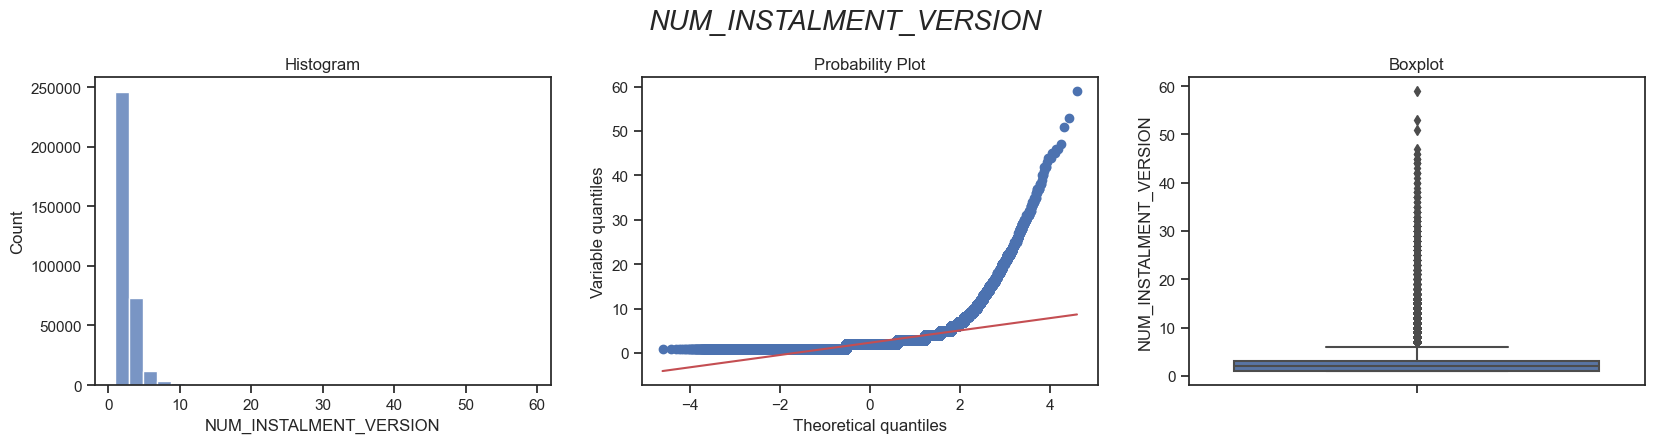

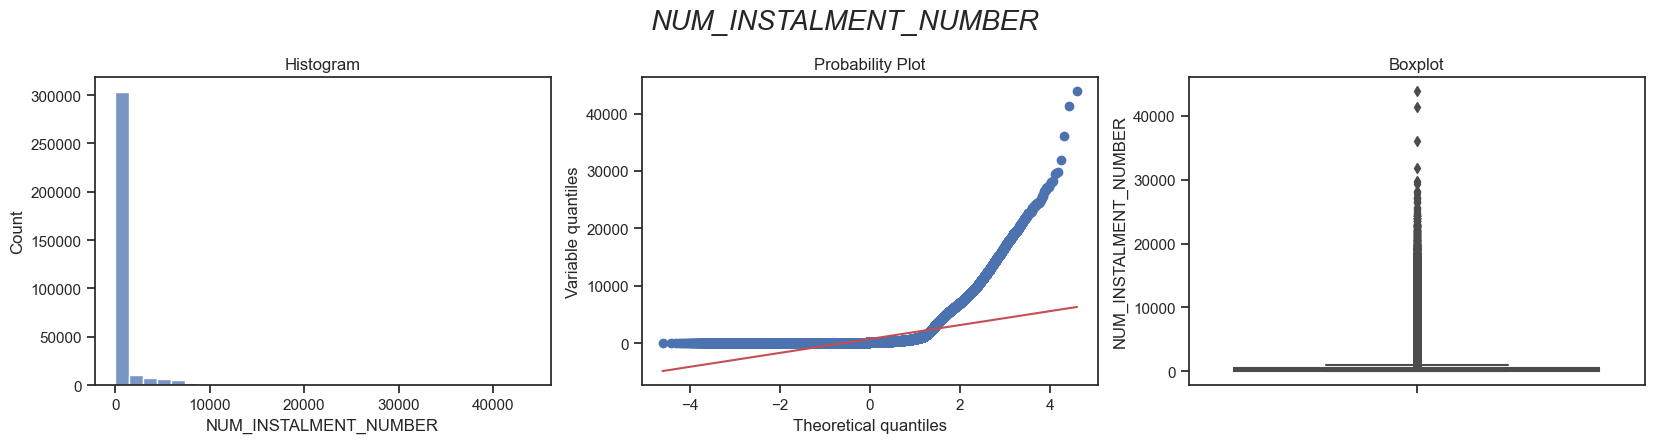

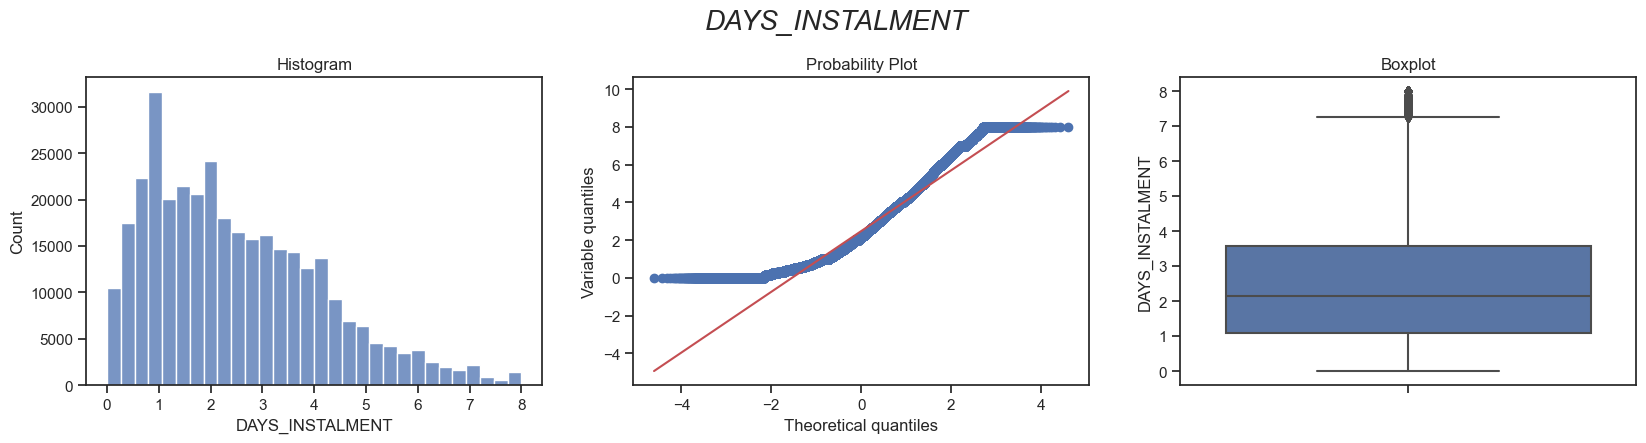

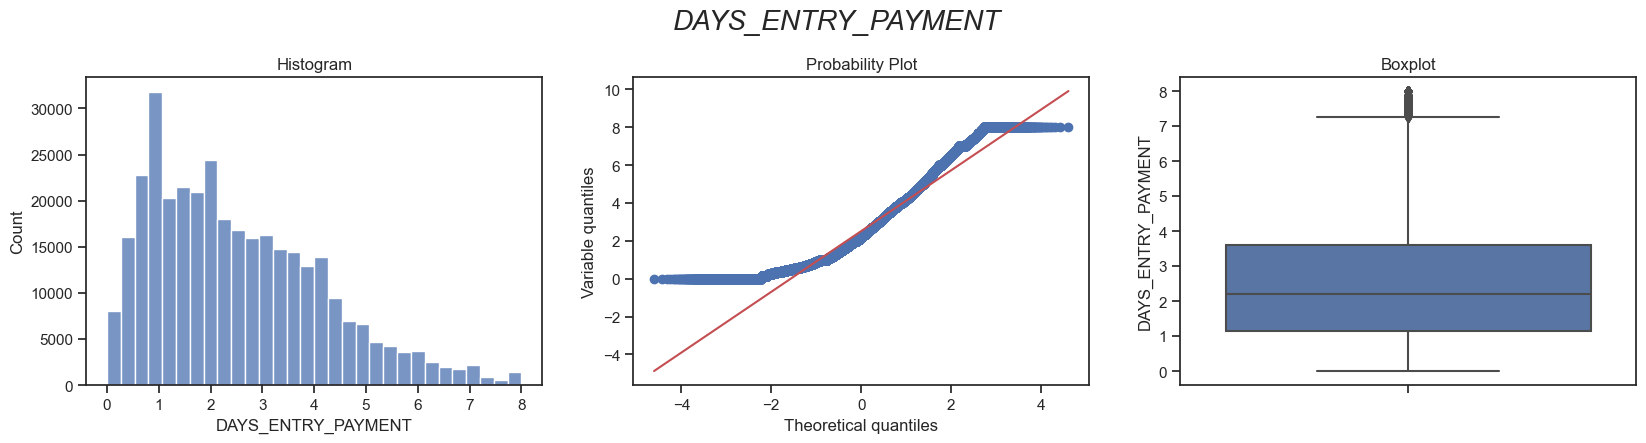

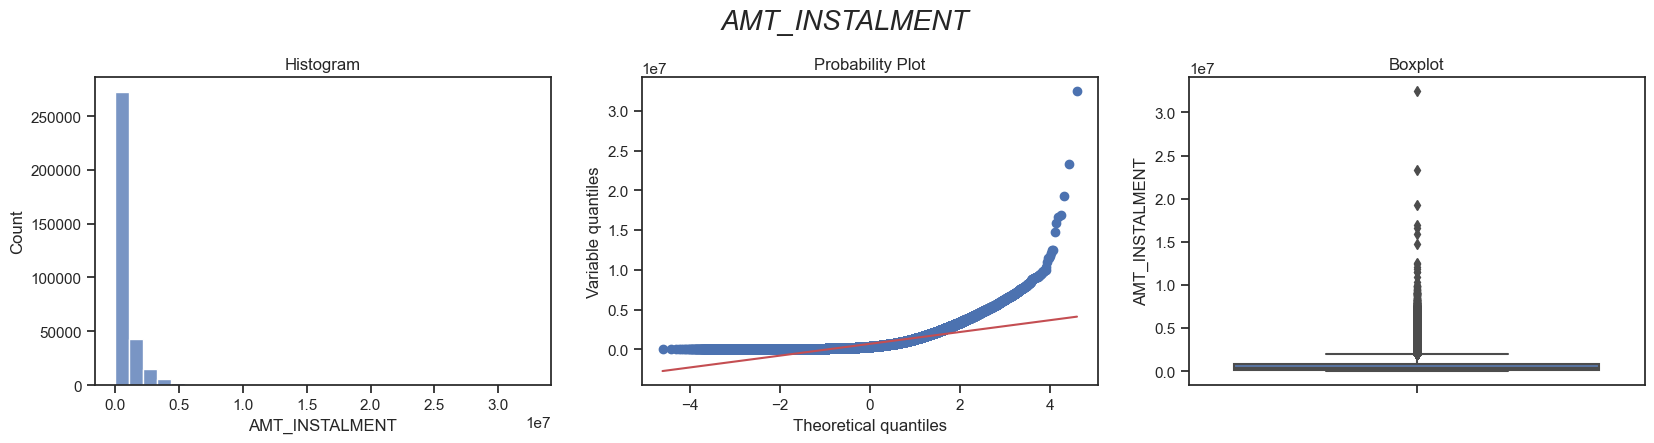

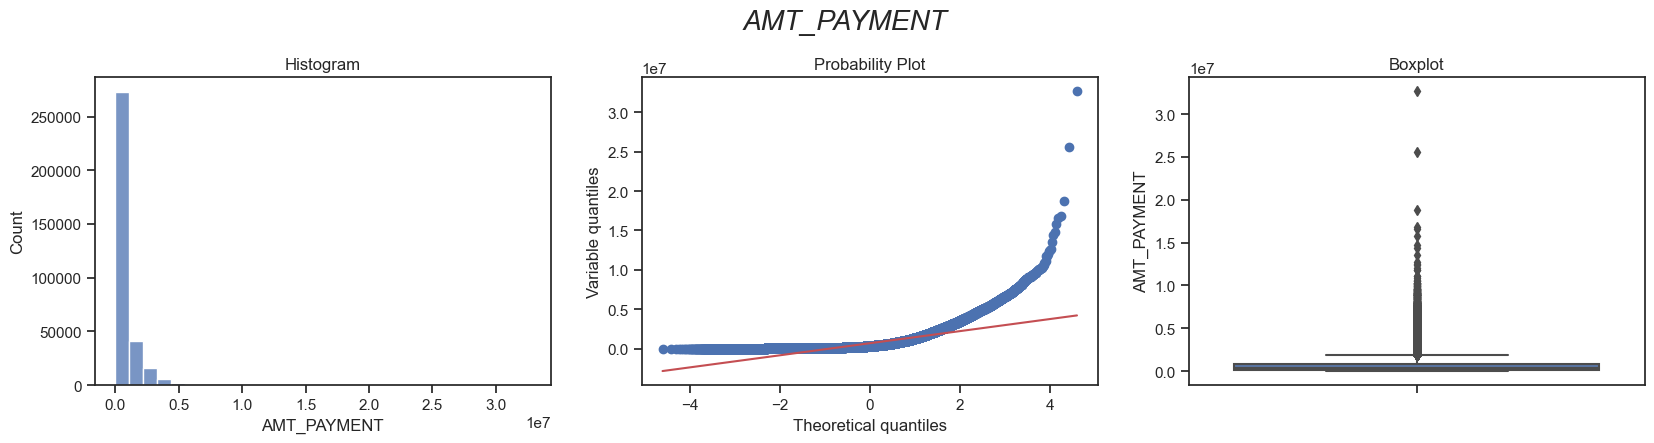

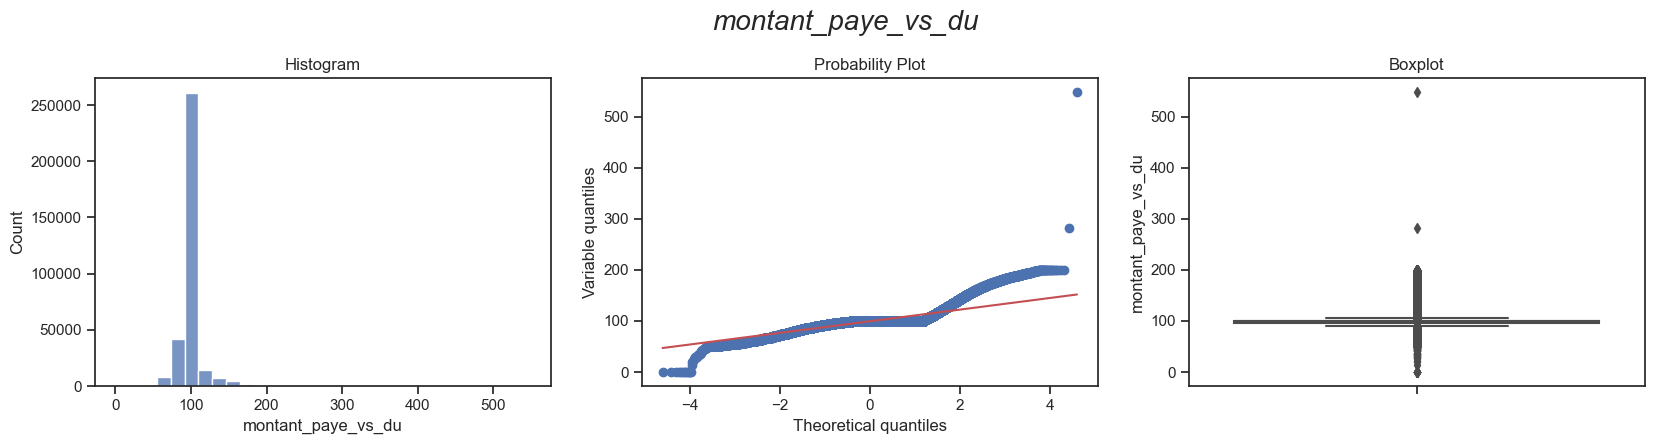

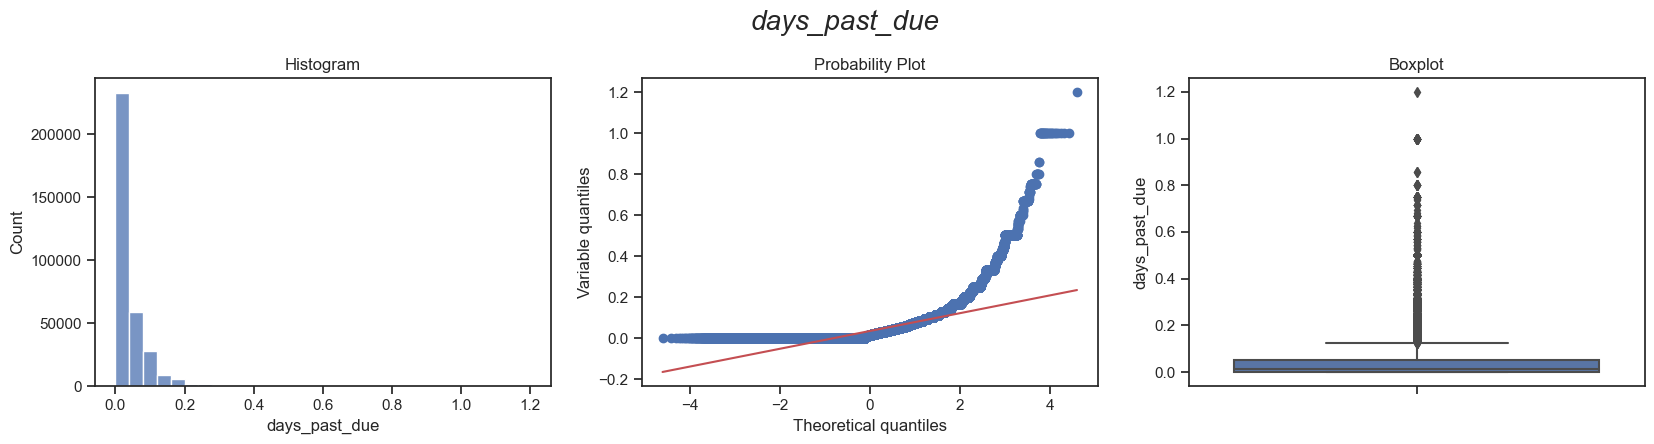

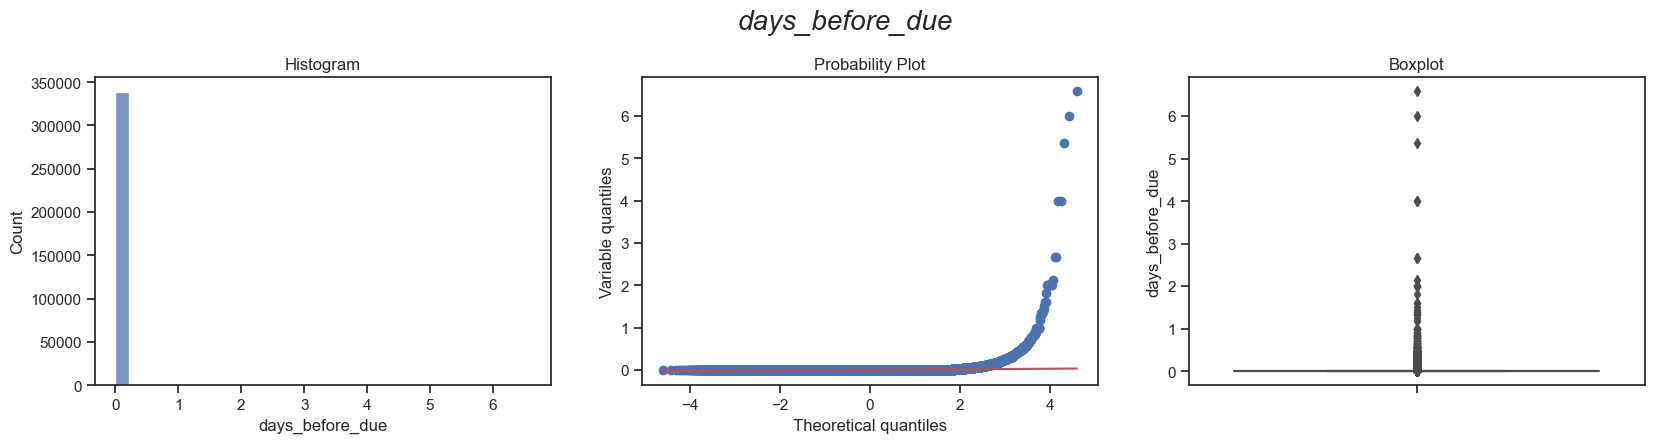

In [316]:
var_num = ['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 
           'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT','AMT_PAYMENT', 'montant_paye_vs_du',
           'days_past_due', 'days_before_due']

for var in var_num:
    diagnostic_plots(ins_payments, var, f"{var}")

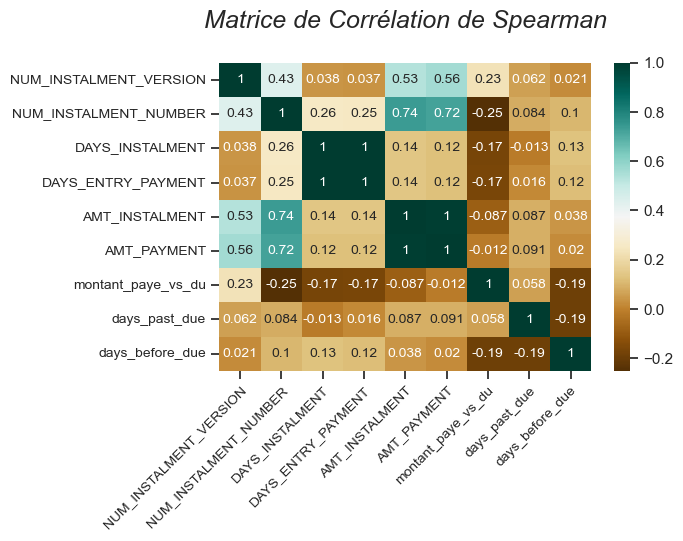

In [317]:
sns.set(style="ticks", rc={'figure.figsize': (6, 4)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = ins_payments.drop(labels='SK_ID_CURR', axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 10})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

In [318]:
# Quelles sont les variables dont le coef de corrélation > 0.7
def high_correlation(mat_corr, corr_value = 0.7):
    for i in mat_corr.columns:
        cr = mat_corr.loc[i].loc[(mat_corr.loc[i] >= corr_value) | (mat_corr.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")

In [319]:
high_correlation(corr_df, corr_value = 0.7)

NUM_INSTALMENT_NUMBER
-------------------------------
AMT_INSTALMENT   0.74
AMT_PAYMENT      0.72
Name: NUM_INSTALMENT_NUMBER, dtype: float64


DAYS_INSTALMENT
-------------------------------
DAYS_ENTRY_PAYMENT   1.00
Name: DAYS_INSTALMENT, dtype: float64


DAYS_ENTRY_PAYMENT
-------------------------------
DAYS_INSTALMENT   1.00
Name: DAYS_ENTRY_PAYMENT, dtype: float64


AMT_INSTALMENT
-------------------------------
AMT_PAYMENT             1.00
NUM_INSTALMENT_NUMBER   0.74
Name: AMT_INSTALMENT, dtype: float64


AMT_PAYMENT
-------------------------------
AMT_INSTALMENT          1.00
NUM_INSTALMENT_NUMBER   0.72
Name: AMT_PAYMENT, dtype: float64




In [320]:
ins_payments.drop(columns=['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT'], axis=1, inplace=True)

In [321]:
ins_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339587 entries, 0 to 339586
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   SK_ID_CURR              339587 non-null  int64  
 1   NUM_INSTALMENT_VERSION  339587 non-null  int64  
 2   NUM_INSTALMENT_NUMBER   339587 non-null  int64  
 3   AMT_PAYMENT             339587 non-null  float64
 4   montant_paye_vs_du      339587 non-null  float64
 5   days_past_due           339587 non-null  float64
 6   days_before_due         339587 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 18.1 MB


In [322]:
#Fusion avec clean_X_train_join2

clean_X_train_join3 = clean_X_train_join2.merge(ins_payments, how='left', on='SK_ID_CURR')
clean_X_train_join3.shape

(44063, 55)

In [323]:
liste_var = ins_payments.drop(columns=['SK_ID_CURR'], axis=1).columns.to_list()
print(liste_var)

['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'AMT_PAYMENT', 'montant_paye_vs_du', 'days_past_due', 'days_before_due']


In [324]:
clean_X_train_join3[liste_var].isna().mean() *100

NUM_INSTALMENT_VERSION   5.02
NUM_INSTALMENT_NUMBER    5.02
AMT_PAYMENT              5.02
montant_paye_vs_du       5.02
days_past_due            5.02
days_before_due          5.02
dtype: float64

In [325]:
for var in liste_var:
    clean_X_train_join3[var].fillna(0, inplace=True)

In [326]:
clean_X_train_join3[liste_var].isna().mean() *100

NUM_INSTALMENT_VERSION   0.00
NUM_INSTALMENT_NUMBER    0.00
AMT_PAYMENT              0.00
montant_paye_vs_du       0.00
days_past_due            0.00
days_before_due          0.00
dtype: float64

In [327]:
#Fusion avec clean_X_test_join2

clean_X_test_join3 = clean_X_test_join2.merge(ins_payments, how='left', on='SK_ID_CURR')
clean_X_test_join3.shape

(36374, 54)

In [328]:
clean_X_test_join3[liste_var].isna().mean() *100

NUM_INSTALMENT_VERSION   1.62
NUM_INSTALMENT_NUMBER    1.62
AMT_PAYMENT              1.62
montant_paye_vs_du       1.62
days_past_due            1.62
days_before_due          1.62
dtype: float64

In [329]:
for var in liste_var:
    clean_X_test_join3[var].fillna(0, inplace=True)

clean_X_test_join3[liste_var].isna().mean() *100

NUM_INSTALMENT_VERSION   0.00
NUM_INSTALMENT_NUMBER    0.00
AMT_PAYMENT              0.00
montant_paye_vs_du       0.00
days_past_due            0.00
days_before_due          0.00
dtype: float64

In [330]:
clean_X_train_join3.shape, clean_X_test_join3.shape

((44063, 55), (36374, 54))

# Les Crédits antérieurs enregistrés au bureau du crédit

## Crédits antérieurs du client fournis par d'autres institutions financières et signalés au bureau de crédit

In [331]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [332]:
bureau.isna().mean()*100

SK_ID_CURR                0.00
SK_ID_BUREAU              0.00
CREDIT_ACTIVE             0.00
CREDIT_CURRENCY           0.00
DAYS_CREDIT               0.00
CREDIT_DAY_OVERDUE        0.00
DAYS_CREDIT_ENDDATE       6.15
DAYS_ENDDATE_FACT        36.92
AMT_CREDIT_MAX_OVERDUE   65.51
CNT_CREDIT_PROLONG        0.00
AMT_CREDIT_SUM            0.00
AMT_CREDIT_SUM_DEBT      15.01
AMT_CREDIT_SUM_LIMIT     34.48
AMT_CREDIT_SUM_OVERDUE    0.00
CREDIT_TYPE               0.00
DAYS_CREDIT_UPDATE        0.00
AMT_ANNUITY              71.47
dtype: float64

In [333]:
# Suppression des variables avec valeurs manquantes

var_to_drop=['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
             'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY']

bureau.drop(labels=var_to_drop, axis=1, inplace= True)

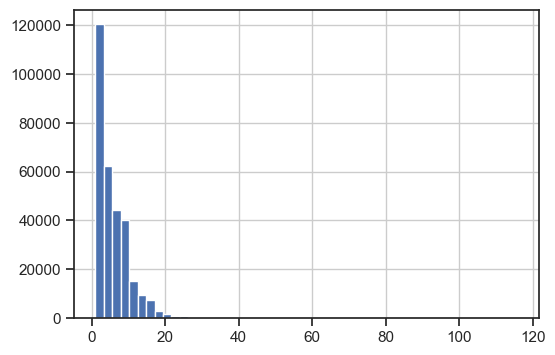

min        1.00
median     4.00
std        4.43
mean       5.61
max      116.00
Name: SK_ID_BUREAU, dtype: float64

In [334]:
# Nombre de prêts des clients enregistrés au bureau du crédit
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().hist(bins=50), plt.show()
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().agg({"min", "max", "mean", "median", "std"})

### Les variables qualitatives

In [335]:
cat_var = bureau.select_dtypes(exclude=[np.number]).columns.to_list()
print(cat_var)

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']


In [336]:
# Categorical Variables
def cat_analyzer(dataframe, variable):
    print(variable)
    print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe) *100}), end="\n\n\n")
    

for i in cat_var:
    cat_analyzer(bureau, i)

CREDIT_ACTIVE
                 COUNT  RATIO
CREDIT_ACTIVE                
Closed         1079273  62.88
Active          630607  36.74
Sold              6527   0.38
Bad debt            21   0.00


CREDIT_CURRENCY
                   COUNT  RATIO
CREDIT_CURRENCY                
currency 1       1715020  99.92
currency 2          1224   0.07
currency 3           174   0.01
currency 4            10   0.00


CREDIT_TYPE
                                                COUNT  RATIO
CREDIT_TYPE                                                 
Consumer credit                               1251615  72.92
Credit card                                    402195  23.43
Car loan                                        27690   1.61
Mortgage                                        18391   1.07
Microloan                                       12413   0.72
Loan for business development                    1975   0.12
Another type of loan                             1017   0.06
Unknown type of loan             

- `CREDIT_CURRENCY` est inutile pour la modélisation. Presque toutes les lignes sont de catégorie devise 1.
- La variable `CREDIT_ACTIVE` peut être utile. Il y a deux catégories rares dans cette colonne : sold (la créance a été vendue) et Bad debt (la créance est irrécouvrable). Nous pouvons combiner ces deux catégories afin d'attribuer une nouvelle catégorie en tant que Sold_BadDebt. En bref, la variable `CREDIT_ACTIVE` comprend 3 catégories comme Actif, Fermé et Sold_BadDebt.
- `CREDIT_TYPE` peut être utile, mais il existe également des catégories rares. Nous allons réduire le nombre de catégories en regroupant toutes les modalités à faible effectif dans une modalité "autres".

In [337]:
bureau.drop(columns=['CREDIT_CURRENCY'], axis=1, inplace=True)

In [338]:
map_credit_active = {'Closed': 'closed',
                     'Active': 'active',
                     'Sold': 'sold_bad_debt',
                     'Bad debt': 'sold_bad_debt'}

bureau['CREDIT_ACTIVE'] = bureau['CREDIT_ACTIVE'].map(map_credit_active)

In [339]:
map_credit_type = {"Consumer credit": "consumer_credit",
                   "Credit card": "credit_card",
                   "Car loan" : "other_credit",
                   "Mortgage" : "other_credit",
                   "Microloan" : "other_credit",
                   "Loan for business development" : "other_credit",
                   "Another type of loan" : "other_credit",
                   "Unknown type of loan" : "other_credit",
                   "Loan for working capital replenishment" : "other_credit",
                   "Cash loan (non-earmarked)" : "other_credit",
                   "Real estate loan" : "other_credit",
                   "Loan for the purchase of equipment" : "other_credit",
                   "Loan for purchase of shares (margin lending)" : "other_credit",
                   "Mobile operator loan" : "other_credit",
                   "Interbank credit" : "other_credit"}

bureau['CREDIT_TYPE'] = bureau['CREDIT_TYPE'].map(map_credit_type)

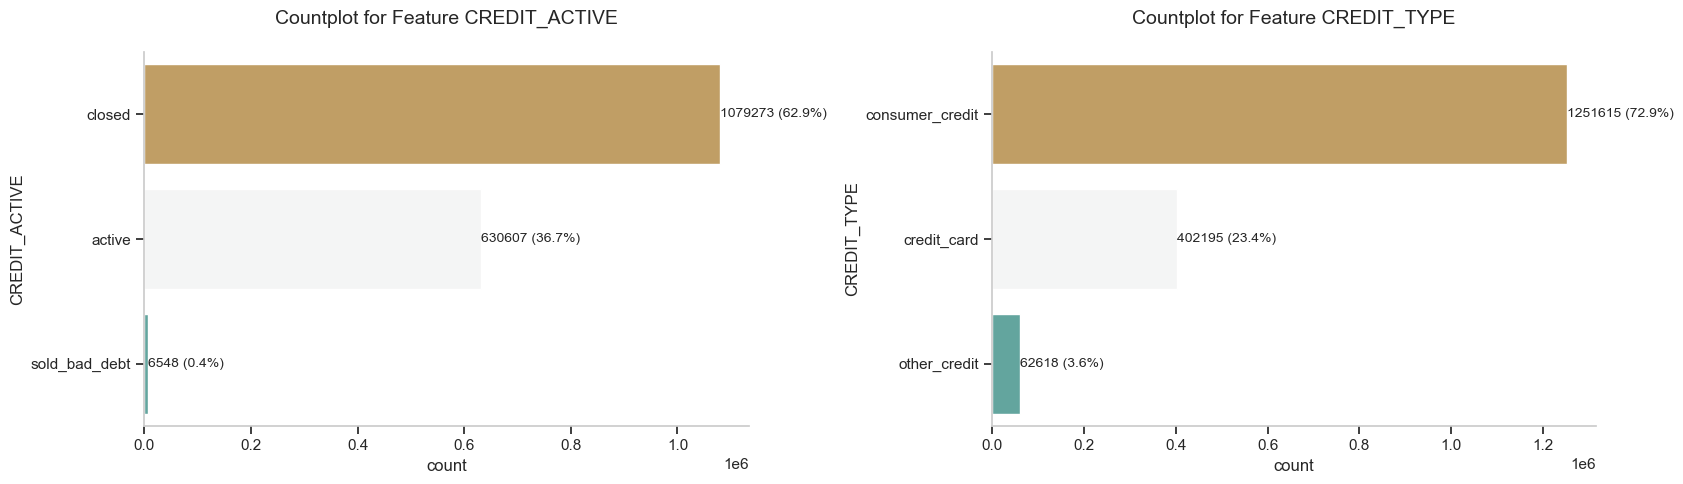

In [340]:
sns.set(style="ticks")

liste6 = ["CREDIT_ACTIVE", "CREDIT_TYPE"]

plot_multiple_countplots(df=bureau,
                         n_cols=2,
                         col_list=liste6,
                         orient='h',
                         palette="BrBG",
                         size_labels=10,
                         size_title=14)
plt.tight_layout()
plt.show()

In [341]:
bureau = pd.get_dummies(bureau,
                        columns=["CREDIT_ACTIVE",
                                 "CREDIT_TYPE"],
                        prefix={'CREDIT_ACTIVE': 'bureau_credit_actif',
                                'CREDIT_TYPE': 'bureau_credit_type'},
                       drop_first=True)

In [342]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 12 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   SK_ID_CURR                         int64  
 1   SK_ID_BUREAU                       int64  
 2   DAYS_CREDIT                        int64  
 3   CREDIT_DAY_OVERDUE                 int64  
 4   CNT_CREDIT_PROLONG                 int64  
 5   AMT_CREDIT_SUM                     float64
 6   AMT_CREDIT_SUM_OVERDUE             float64
 7   DAYS_CREDIT_UPDATE                 int64  
 8   bureau_credit_actif_closed         bool   
 9   bureau_credit_actif_sold_bad_debt  bool   
 10  bureau_credit_type_credit_card     bool   
 11  bureau_credit_type_other_credit    bool   
dtypes: bool(4), float64(2), int64(6)
memory usage: 111.3 MB


### Les variables numériques

In [343]:
# Les variables numériques
var_num = bureau.drop(labels=['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1).select_dtypes(include=[np.number]).columns.to_list()
print(var_num)

['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE']


In [344]:
var_num = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE']

bureau[var_num].describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])[1:].T

mean          std        min        1%       10%  \
DAYS_CREDIT             -1,142.11       795.16  -2,922.00 -2,867.00 -2,443.00   
CREDIT_DAY_OVERDUE           0.82        36.54       0.00      0.00      0.00   
CNT_CREDIT_PROLONG           0.01         0.10       0.00      0.00      0.00   
AMT_CREDIT_SUM         354,994.59 1,149,811.34       0.00      0.00 22,500.00   
AMT_CREDIT_SUM_OVERDUE      37.91     5,937.65       0.00      0.00      0.00   
DAYS_CREDIT_UPDATE        -593.75       720.75 -41,947.00 -2,531.00 -1,561.00   

                             25%        50%        75%        80%        90%  \
DAYS_CREDIT            -1,666.00    -987.00    -474.00    -385.00    -215.00   
CREDIT_DAY_OVERDUE          0.00       0.00       0.00       0.00       0.00   
CNT_CREDIT_PROLONG          0.00       0.00       0.00       0.00       0.00   
AMT_CREDIT_SUM         51,300.00 125,518.50 315,000.00 423,000.00 778,754.74   
AMT_CREDIT_SUM_OVERDUE      0.00       0.00       0.00       0.00       0.00   
DAYS_CREDIT_UPDATE       -908.00    -395.00     -33.00     -25.00     -13.00   

                                95%          99%            max  
DAYS_CREDIT                 -125.00       -38.00           0.00  
CREDIT_DAY_OVERDUE             0.00         0.00       2,792.00  
CNT_CREDIT_PROLONG             0.00         0.00           9.00  
AMT_CREDIT_SUM         1,350,000.00 3,700,916.10 585,000,000.00  
AMT_CREDIT_SUM_OVERDUE         0.00         0.00   3,756,681.00  
DAYS_CREDIT_UPDATE            -8.00        -3.00         372.00

Les statistiques récapitulatives nous donnent de nombreuses informations sur les variables numériques. De plus, les centiles, les valeurs minimales et maximales nous montrent qu'il existe ou non des valeurs aberrantes. Par exemple, la valeur maximale de la variable `AMT_CREDIT_SUM` (Montant actuel du crédit enregistré au bureau de crédit) est de 585 000 000, alors que le 99 centile est de 3 700 916,10. Cette différence est trop importante entre les valeurs max et 99 %. 

On remarque aussi que `CREDIT_DAY_OVERDUE` (Nombre de jours d'impayés sur crédit CB au moment de la demande de prêt connexe dans l'échantillon Train ou Test), `CNT_CREDIT_PROLONG`(Combien de fois le crédit du bureau de crédit a-t-il été prolongé), ou encore `AMT_CREDIT_SUM_OVERDUE` (Montant actuel en souffrance sur le crédit du bureau de crédit) sont à 99% nulles.

In [345]:
var_to_drop = ['CREDIT_DAY_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_OVERDUE']

bureau.drop(labels=var_to_drop, axis=1, inplace= True)

bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 9 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   SK_ID_CURR                         int64  
 1   SK_ID_BUREAU                       int64  
 2   DAYS_CREDIT                        int64  
 3   AMT_CREDIT_SUM                     float64
 4   DAYS_CREDIT_UPDATE                 int64  
 5   bureau_credit_actif_closed         bool   
 6   bureau_credit_actif_sold_bad_debt  bool   
 7   bureau_credit_type_credit_card     bool   
 8   bureau_credit_type_other_credit    bool   
dtypes: bool(4), float64(1), int64(4)
memory usage: 72.0 MB


In [346]:
bureau['DAYS_CREDIT'] = round(bureau['DAYS_CREDIT'] / -365, 0)
bureau['DAYS_CREDIT_UPDATE'] = round(bureau['DAYS_CREDIT_UPDATE'] / -365, 0)

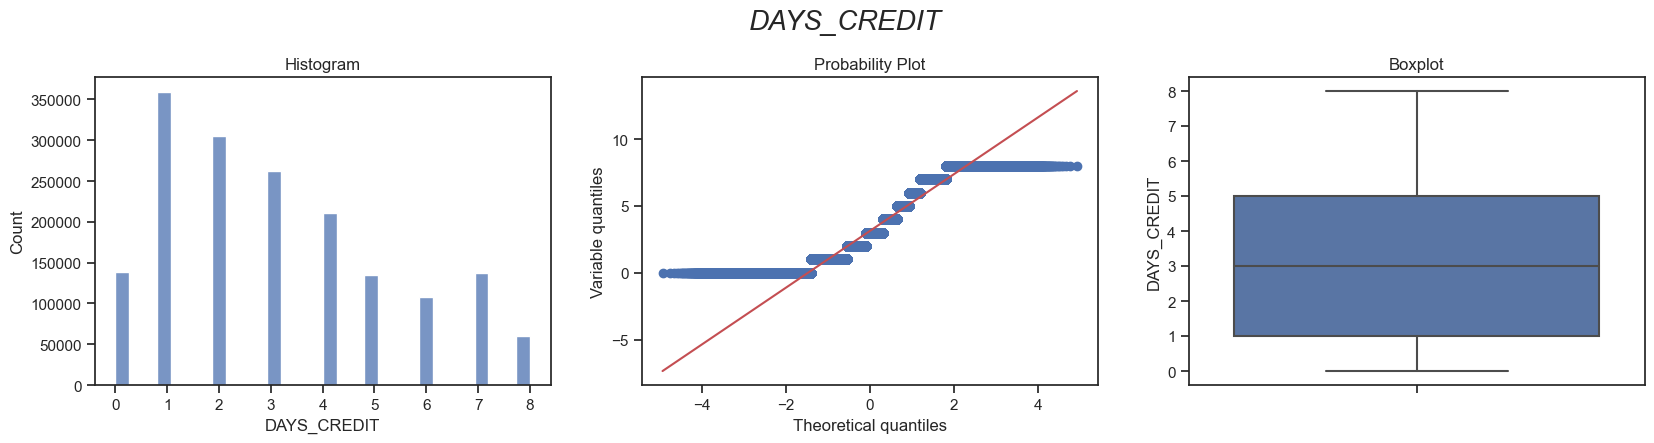

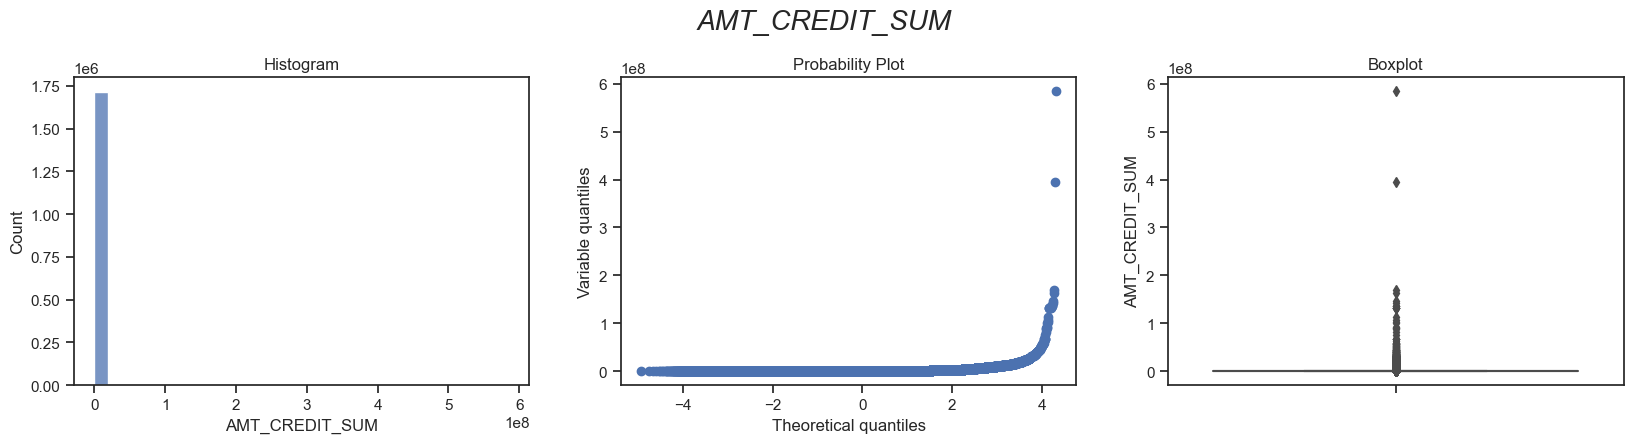

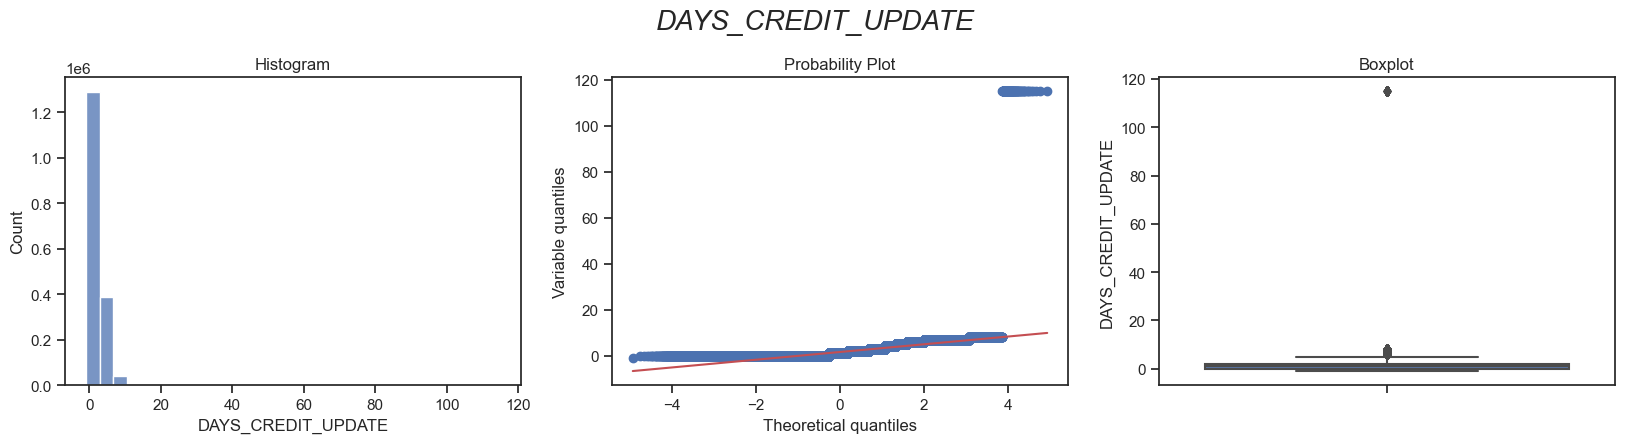

In [347]:
var_num = ['DAYS_CREDIT', 'AMT_CREDIT_SUM', 'DAYS_CREDIT_UPDATE']

for var in var_num:
    diagnostic_plots(bureau, var, f"{var}")

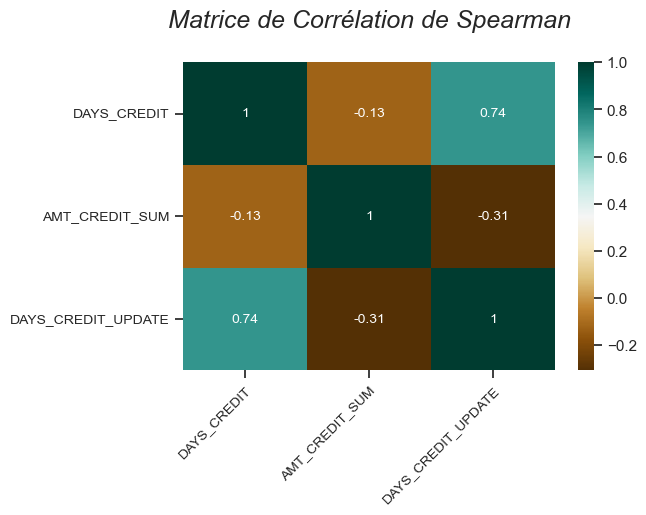

In [348]:
sns.set(style="ticks", rc={'figure.figsize': (6, 4)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = bureau.drop(labels=['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 10})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

In [349]:
# Quelles sont les variables dont le coef de corrélation > 0.7
def high_correlation(mat_corr, corr_value = 0.7):
    for i in mat_corr.columns:
        cr = mat_corr.loc[i].loc[(mat_corr.loc[i] >= corr_value) | (mat_corr.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")
            
high_correlation(corr_df, corr_value = 0.7)

DAYS_CREDIT
-------------------------------
DAYS_CREDIT_UPDATE   0.74
Name: DAYS_CREDIT, dtype: float64


DAYS_CREDIT_UPDATE
-------------------------------
DAYS_CREDIT   0.74
Name: DAYS_CREDIT_UPDATE, dtype: float64




`DAYS_CREDIT` et `DAYS_CREDIT_UPDATE` sont très liés, nous conservons la première : Quel est le nombre de jours entre la demande actuelle de crédit du client et sa demande précédente enregistrée au bureau de crédit.

In [350]:
bureau.drop(labels=['DAYS_CREDIT_UPDATE'], axis=1, inplace=True)

bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 8 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   SK_ID_CURR                         int64  
 1   SK_ID_BUREAU                       int64  
 2   DAYS_CREDIT                        float64
 3   AMT_CREDIT_SUM                     float64
 4   bureau_credit_actif_closed         bool   
 5   bureau_credit_actif_sold_bad_debt  bool   
 6   bureau_credit_type_credit_card     bool   
 7   bureau_credit_type_other_credit    bool   
dtypes: bool(4), float64(2), int64(2)
memory usage: 58.9 MB


## Soldes mensuels des crédits antérieurs au bureau de crédit

In [351]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [352]:
bureau_balance.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente) ????????? Signification

In [353]:
bureau_balance['MONTHS_BALANCE'].describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])

count   27,299,925.00
mean           -30.74
std             23.86
min            -96.00
1%             -91.00
10%            -68.00
25%            -46.00
50%            -25.00
75%            -11.00
80%             -9.00
90%             -4.00
95%             -2.00
99%              0.00
max              0.00
Name: MONTHS_BALANCE, dtype: float64

STATUT : Statut du prêt du bureau de crédit au cours du mois (actif, fermé, DPD0-30,…

- C signifie fermé,
- X signifie état inconnu,
- 0 signifie pas de DPD (jours de retard),
- 1 signifie que le maximum a été fait pendant le mois entre 1 et 30,
- 2 signifie DPD 31-60,
- … 5 signifie DPD 120+ ou vendu ou radié)"

In [354]:
# Categorical Variables
def cat_analyzer(dataframe, variable):
    print(variable)
    print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe) *100}), end="\n\n\n")
    
cat_analyzer(bureau_balance, 'STATUS')

STATUS
           COUNT  RATIO
STATUS                 
C       13646993  49.99
0        7499507  27.47
X        5810482  21.28
1         242347   0.89
5          62406   0.23
2          23419   0.09
3           8924   0.03
4           5847   0.02




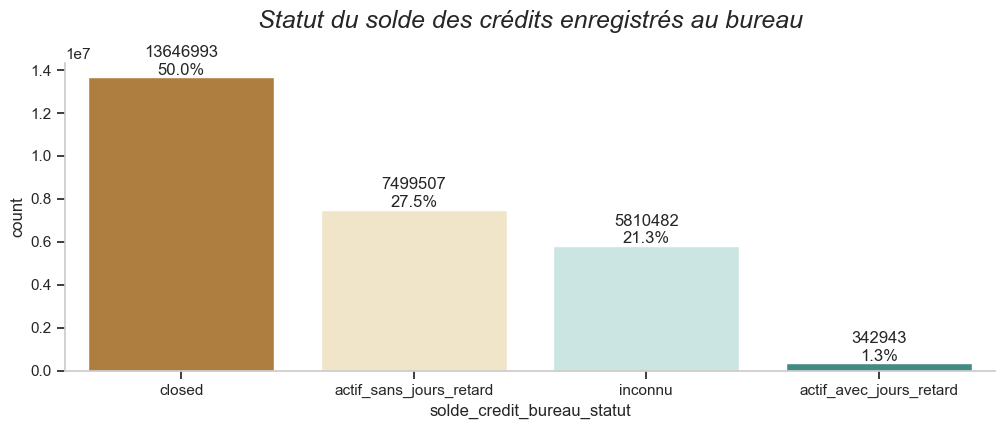

In [355]:
map_statut_bureau = {'C': 'closed',
                     '0': 'actif_sans_jours_retard',
                     '1': 'actif_avec_jours_retard',
                     '2': 'actif_avec_jours_retard',
                     '3': 'actif_avec_jours_retard',
                     '4': 'actif_avec_jours_retard',
                     '5': 'actif_avec_jours_retard',
                     'X': 'inconnu'}

bureau_balance['solde_credit_bureau_statut'] = bureau_balance['STATUS'].map(map_statut_bureau)

grah_barre(bureau_balance, 'solde_credit_bureau_statut', 'BrBG', "Statut du solde des crédits enregistrés au bureau\n", (12, 4))

In [356]:
bureau_balance = pd.get_dummies(bureau_balance,
                                columns=["solde_credit_bureau_statut"],
                                prefix={'solde_credit_bureau_statut': 'solde_credit_bureau_statut'})

In [357]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 7 columns):
 #   Column                                              Dtype 
---  ------                                              ----- 
 0   SK_ID_BUREAU                                        int64 
 1   MONTHS_BALANCE                                      int64 
 2   STATUS                                              object
 3   solde_credit_bureau_statut_actif_avec_jours_retard  bool  
 4   solde_credit_bureau_statut_actif_sans_jours_retard  bool  
 5   solde_credit_bureau_statut_closed                   bool  
 6   solde_credit_bureau_statut_inconnu                  bool  
dtypes: bool(4), int64(2), object(1)
memory usage: 729.0+ MB


In [358]:
# Non prise en compte de solde_credit_bureau_statut_inconnu pour éviter la fuite des variables fictives

solde_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU'], as_index=False).agg({'MONTHS_BALANCE': 'mean',
                                                                                     'solde_credit_bureau_statut_actif_avec_jours_retard': 'sum',
                                                                                     'solde_credit_bureau_statut_actif_sans_jours_retard': 'sum',
                                                                                     'solde_credit_bureau_statut_closed': 'sum'
                                                                                     })

solde_bureau_balance.drop(labels='SK_ID_BUREAU', axis=1).describe()

MONTHS_BALANCE  solde_credit_bureau_statut_actif_avec_jours_retard  \
count      817,395.00                                          817,395.00   
mean           -23.23                                                0.42   
std             19.35                                                2.28   
min            -96.00                                                0.00   
25%            -33.50                                                0.00   
50%            -18.00                                                0.00   
75%             -8.00                                                0.00   
max              0.00                                               97.00   

       solde_credit_bureau_statut_actif_sans_jours_retard  \
count                                          817,395.00   
mean                                                 9.17   
std                                                 10.31   
min                                                  0.00   
25%                                                  2.00   
50%                                                  6.00   
75%                                                 12.00   
max                                                 97.00   

       solde_credit_bureau_statut_closed  
count                         817,395.00  
mean                               16.70  
std                                23.27  
min                                 0.00  
25%                                 0.00  
50%                                 5.00  
75%                                27.00  
max                                97.00

## Fusion Bureau & Bureau_balance

In [359]:
#Fusion avec bureau
bureau = bureau.merge(solde_bureau_balance, how='left', on='SK_ID_BUREAU')
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 12 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   SK_ID_CURR                                          int64  
 1   SK_ID_BUREAU                                        int64  
 2   DAYS_CREDIT                                         float64
 3   AMT_CREDIT_SUM                                      float64
 4   bureau_credit_actif_closed                          bool   
 5   bureau_credit_actif_sold_bad_debt                   bool   
 6   bureau_credit_type_credit_card                      bool   
 7   bureau_credit_type_other_credit                     bool   
 8   MONTHS_BALANCE                                      float64
 9   solde_credit_bureau_statut_actif_avec_jours_retard  float64
 10  solde_credit_bureau_statut_actif_sans_jours_retard  float64
 11  solde_credit_bureau_statut_closed    

In [360]:
bureau.isna().mean()*100

SK_ID_CURR                                            0.00
SK_ID_BUREAU                                          0.00
DAYS_CREDIT                                           0.00
AMT_CREDIT_SUM                                        0.00
bureau_credit_actif_closed                            0.00
bureau_credit_actif_sold_bad_debt                     0.00
bureau_credit_type_credit_card                        0.00
bureau_credit_type_other_credit                       0.00
MONTHS_BALANCE                                       54.89
solde_credit_bureau_statut_actif_avec_jours_retard   54.89
solde_credit_bureau_statut_actif_sans_jours_retard   54.89
solde_credit_bureau_statut_closed                    54.89
dtype: float64

In [361]:
liste_var2 = ['MONTHS_BALANCE', 'solde_credit_bureau_statut_actif_avec_jours_retard', 'solde_credit_bureau_statut_actif_sans_jours_retard',
              'solde_credit_bureau_statut_closed']

In [362]:
for var in liste_var2:
    bureau[var].fillna(0, inplace=True)

In [363]:
bureau.isna().mean()*100

SK_ID_CURR                                           0.00
SK_ID_BUREAU                                         0.00
DAYS_CREDIT                                          0.00
AMT_CREDIT_SUM                                       0.00
bureau_credit_actif_closed                           0.00
bureau_credit_actif_sold_bad_debt                    0.00
bureau_credit_type_credit_card                       0.00
bureau_credit_type_other_credit                      0.00
MONTHS_BALANCE                                       0.00
solde_credit_bureau_statut_actif_avec_jours_retard   0.00
solde_credit_bureau_statut_actif_sans_jours_retard   0.00
solde_credit_bureau_statut_closed                    0.00
dtype: float64

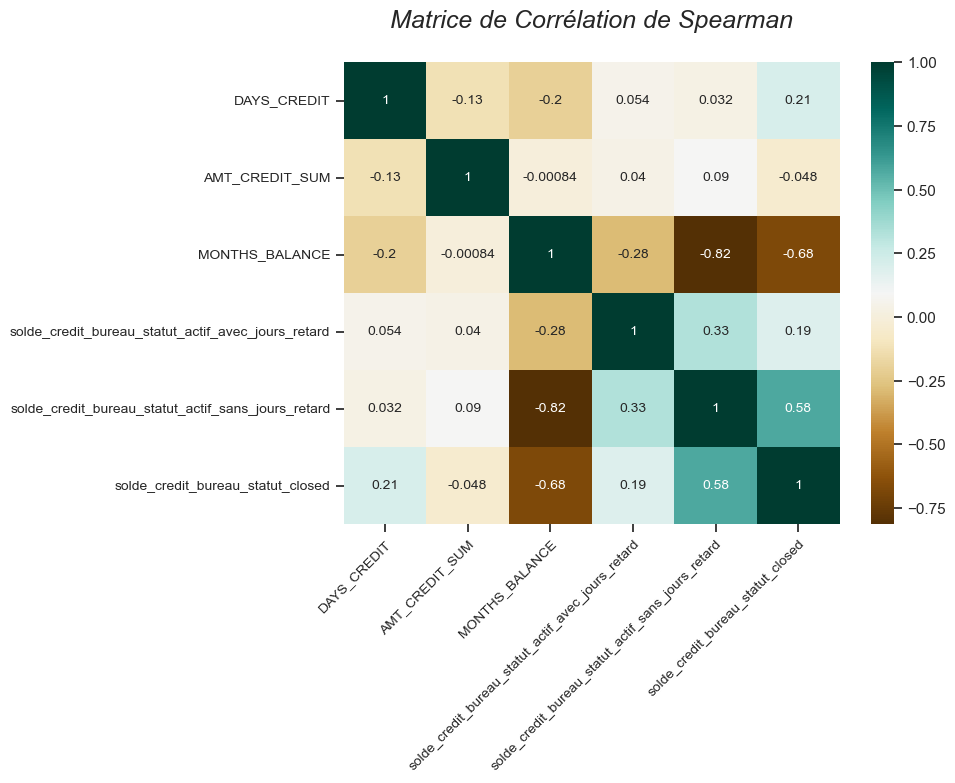

In [364]:
sns.set(style="ticks", rc={'figure.figsize': (8, 6)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = bureau.drop(labels=['SK_ID_CURR', 'SK_ID_BUREAU'], axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 10})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

In [365]:
# Quelles sont les variables dont le coef de corrélation > 0.7
def high_correlation(mat_corr, corr_value = 0.7):
    for i in mat_corr.columns:
        cr = mat_corr.loc[i].loc[(mat_corr.loc[i] >= corr_value) | (mat_corr.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")
            
high_correlation(corr_df, corr_value = 0.7)

MONTHS_BALANCE
-------------------------------
solde_credit_bureau_statut_actif_sans_jours_retard   -0.82
Name: MONTHS_BALANCE, dtype: float64


solde_credit_bureau_statut_actif_sans_jours_retard
-------------------------------
MONTHS_BALANCE   -0.82
Name: solde_credit_bureau_statut_actif_sans_jours_retard, dtype: float64




In [366]:
# Suppression de Months_Balance

bureau.drop(labels='MONTHS_BALANCE', axis=1, inplace=True)

In [367]:
bureau.columns.to_list()

['SK_ID_CURR',
 'SK_ID_BUREAU',
 'DAYS_CREDIT',
 'AMT_CREDIT_SUM',
 'bureau_credit_actif_closed',
 'bureau_credit_actif_sold_bad_debt',
 'bureau_credit_type_credit_card',
 'bureau_credit_type_other_credit',
 'solde_credit_bureau_statut_actif_avec_jours_retard',
 'solde_credit_bureau_statut_actif_sans_jours_retard',
 'solde_credit_bureau_statut_closed']

In [368]:
client_bureau = bureau.groupby(['SK_ID_CURR'], as_index=False).agg({'SK_ID_BUREAU': 'count',
                                                                    'DAYS_CREDIT': 'mean',
                                                                    'AMT_CREDIT_SUM': 'sum',
                                                                    'bureau_credit_actif_closed': 'sum',
                                                                    'bureau_credit_actif_sold_bad_debt': 'sum',
                                                                    'bureau_credit_type_credit_card': 'sum',
                                                                    'bureau_credit_type_other_credit': 'sum',
                                                                    'solde_credit_bureau_statut_actif_avec_jours_retard': 'sum',
                                                                    'solde_credit_bureau_statut_actif_sans_jours_retard': 'sum',
                                                                    'solde_credit_bureau_statut_closed': 'sum'
                                                                    })

client_bureau.drop(labels='SK_ID_CURR', axis=1).describe()

SK_ID_BUREAU  DAYS_CREDIT   AMT_CREDIT_SUM  bureau_credit_actif_closed  \
count    305,811.00   305,811.00       305,811.00                  305,811.00   
mean           5.61         2.96     1,992,466.07                        3.53   
std            4.43         1.55     4,165,820.02                        3.43   
min            1.00         0.00             0.00                        0.00   
25%            2.00         2.00       346,967.64                        1.00   
50%            4.00         3.00       978,820.74                        3.00   
75%            8.00         4.00     2,345,121.00                        5.00   
max          116.00         8.00 1,017,957,917.38                      108.00   

       bureau_credit_actif_sold_bad_debt  bureau_credit_type_credit_card  \
count                         305,811.00                      305,811.00   
mean                                0.02                            1.32   
std                                 0.16                            1.51   
min                                 0.00                            0.00   
25%                                 0.00                            0.00   
50%                                 0.00                            1.00   
75%                                 0.00                            2.00   
max                                 9.00                           22.00   

       bureau_credit_type_other_credit  \
count                       305,811.00   
mean                              0.20   
std                               0.72   
min                               0.00   
25%                               0.00   
50%                               0.00   
75%                               0.00   
max                              79.00   

       solde_credit_bureau_statut_actif_avec_jours_retard  \
count                                          305,811.00   
mean                                                 1.03   
std                                                  5.25   
min                                                  0.00   
25%                                                  0.00   
50%                                                  0.00   
75%                                                  0.00   
max                                                396.00   

       solde_credit_bureau_statut_actif_sans_jours_retard  \
count                                          305,811.00   
mean                                                23.53   
std                                                 44.87   
min                                                  0.00   
25%                                                  0.00   
50%                                                  0.00   
75%                                                 30.00   
max                                                696.00   

       solde_credit_bureau_statut_closed  
count                         305,811.00  
mean                               37.79  
std                                84.40  
min                                 0.00  
25%                                 0.00  
50%                                 0.00  
75%                                35.00  
max                             1,981.00

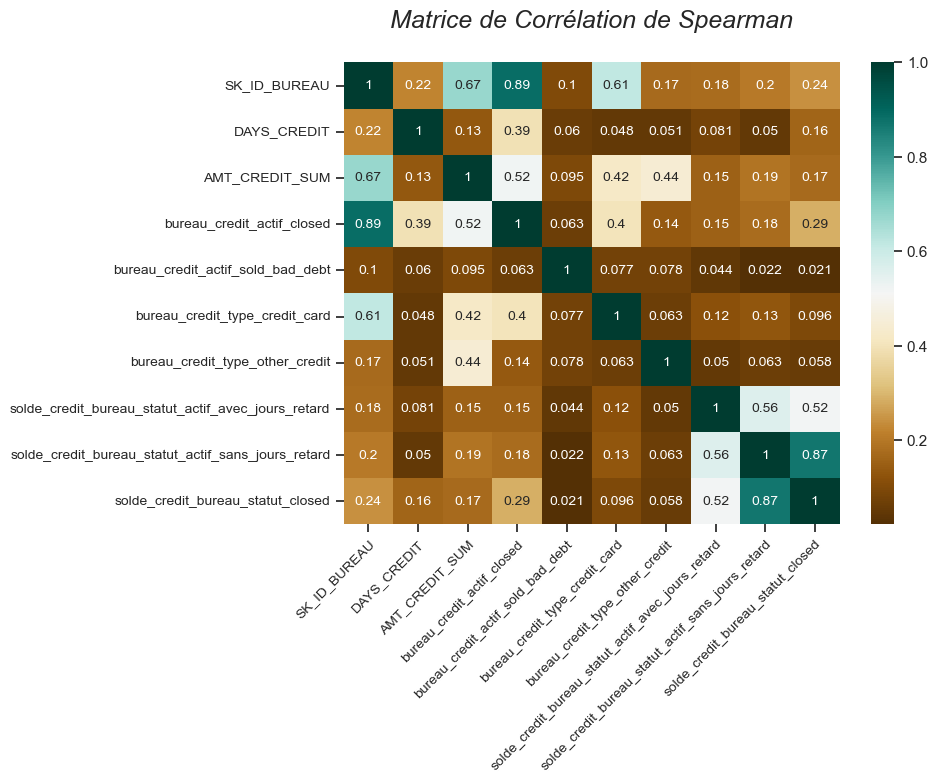

In [369]:
sns.set(style="ticks", rc={'figure.figsize': (8, 6)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = client_bureau.drop(labels=['SK_ID_CURR'], axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 10})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

In [370]:
# Quelles sont les variables dont le coef de corrélation > 0.7
def high_correlation(mat_corr, corr_value = 0.7):
    for i in mat_corr.columns:
        cr = mat_corr.loc[i].loc[(mat_corr.loc[i] >= corr_value) | (mat_corr.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")
            
high_correlation(corr_df, corr_value = 0.7)

SK_ID_BUREAU
-------------------------------
bureau_credit_actif_closed   0.89
Name: SK_ID_BUREAU, dtype: float64


bureau_credit_actif_closed
-------------------------------
SK_ID_BUREAU   0.89
Name: bureau_credit_actif_closed, dtype: float64


solde_credit_bureau_statut_actif_sans_jours_retard
-------------------------------
solde_credit_bureau_statut_closed   0.87
Name: solde_credit_bureau_statut_actif_sans_jours_retard, dtype: float64


solde_credit_bureau_statut_closed
-------------------------------
solde_credit_bureau_statut_actif_sans_jours_retard   0.87
Name: solde_credit_bureau_statut_closed, dtype: float64




Le nombre de crédits enregistré au bureau du crédit est très lié au type de crédit "crédit à la consommation". Nous supprimons donc la variable nombre de crédit (`SK_ID_BUREAU`).

D'autre part, en ce qui concerne le statut du solde du crédit, nous pouvons supprimer les statuts "sans jours de retard" puisqu'ils sont très liés aux status fermés.

In [371]:
vars_to_drop = ['SK_ID_BUREAU', 'solde_credit_bureau_statut_actif_sans_jours_retard']

client_bureau.drop(labels=vars_to_drop, axis=1, inplace=True)

In [372]:
client_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 9 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   SK_ID_CURR                                          305811 non-null  int64  
 1   DAYS_CREDIT                                         305811 non-null  float64
 2   AMT_CREDIT_SUM                                      305811 non-null  float64
 3   bureau_credit_actif_closed                          305811 non-null  int64  
 4   bureau_credit_actif_sold_bad_debt                   305811 non-null  int64  
 5   bureau_credit_type_credit_card                      305811 non-null  int64  
 6   bureau_credit_type_other_credit                     305811 non-null  int64  
 7   solde_credit_bureau_statut_actif_avec_jours_retard  305811 non-null  float64
 8   solde_credit_bureau_statut_closed                   305811 non-nu

## Fusion avec Train et Test

In [373]:
# pour rappel : les fusions précédentes
clean_X_train_join3.shape, clean_X_test_join3.shape

((44063, 55), (36374, 54))

In [374]:
#Fusion avec clean_X_train_join3

clean_X_train_join4 = clean_X_train_join3.merge(client_bureau, how='left', on='SK_ID_CURR')
clean_X_train_join4.shape

(44063, 63)

In [375]:
clean_X_train_join4.isna().mean()*100

SK_ID_CURR                                            0.00
NAME_CONTRACT_TYPE                                    0.00
CODE_GENDER                                           0.00
FLAG_OWN_CAR                                          0.00
FLAG_OWN_REALTY                                       0.00
NAME_TYPE_SUITE                                       0.00
NAME_INCOME_TYPE                                      0.00
NAME_EDUCATION_TYPE                                   0.00
NAME_FAMILY_STATUS                                    0.00
NAME_HOUSING_TYPE                                     0.00
FLAG_EMP_PHONE                                        0.00
FLAG_WORK_PHONE                                       0.00
FLAG_PHONE                                            0.00
FLAG_EMAIL                                            0.00
REGION_RATING_CLIENT                                  0.00
REGION_RATING_CLIENT_W_CITY                           0.00
WEEKDAY_APPR_PROCESS_START                            0.

In [376]:
liste_var3 = ['DAYS_CREDIT',
              'AMT_CREDIT_SUM',
              'bureau_credit_actif_closed',
              'bureau_credit_actif_sold_bad_debt',
              'bureau_credit_type_credit_card',
              'bureau_credit_type_other_credit',
              'solde_credit_bureau_statut_actif_avec_jours_retard',
              'solde_credit_bureau_statut_closed']

In [377]:
for var in liste_var3:
    clean_X_train_join4[var].fillna(0, inplace=True)

In [378]:
clean_X_train_join4.drop(labels=['SK_ID_CURR', 'TARGET'], axis=1).select_dtypes(include=[np.number]).columns.to_list()

['EXT_SOURCE_2',
 'nb_demande_pret_precedente',
 'montant_demande_pret_precedente',
 'heure_demande_pret_precedente',
 'nb_year_depuis_decision_precedente',
 'prev_contrat_statut_canceled_unused',
 'prev_contrat_statut_refused',
 'prev_contrat_type_consumer_loans',
 'prev_contrat_type_revolving_loans',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'AMT_PAYMENT',
 'montant_paye_vs_du',
 'days_past_due',
 'days_before_due',
 'DAYS_CREDIT',
 'AMT_CREDIT_SUM',
 'bureau_credit_actif_closed',
 'bureau_credit_actif_sold_bad_debt',
 'bureau_credit_type_credit_card',
 'bureau_credit_type_other_credit',
 'solde_credit_bureau_statut_actif_avec_jours_retard',
 'solde_credit_bureau_statut_closed']

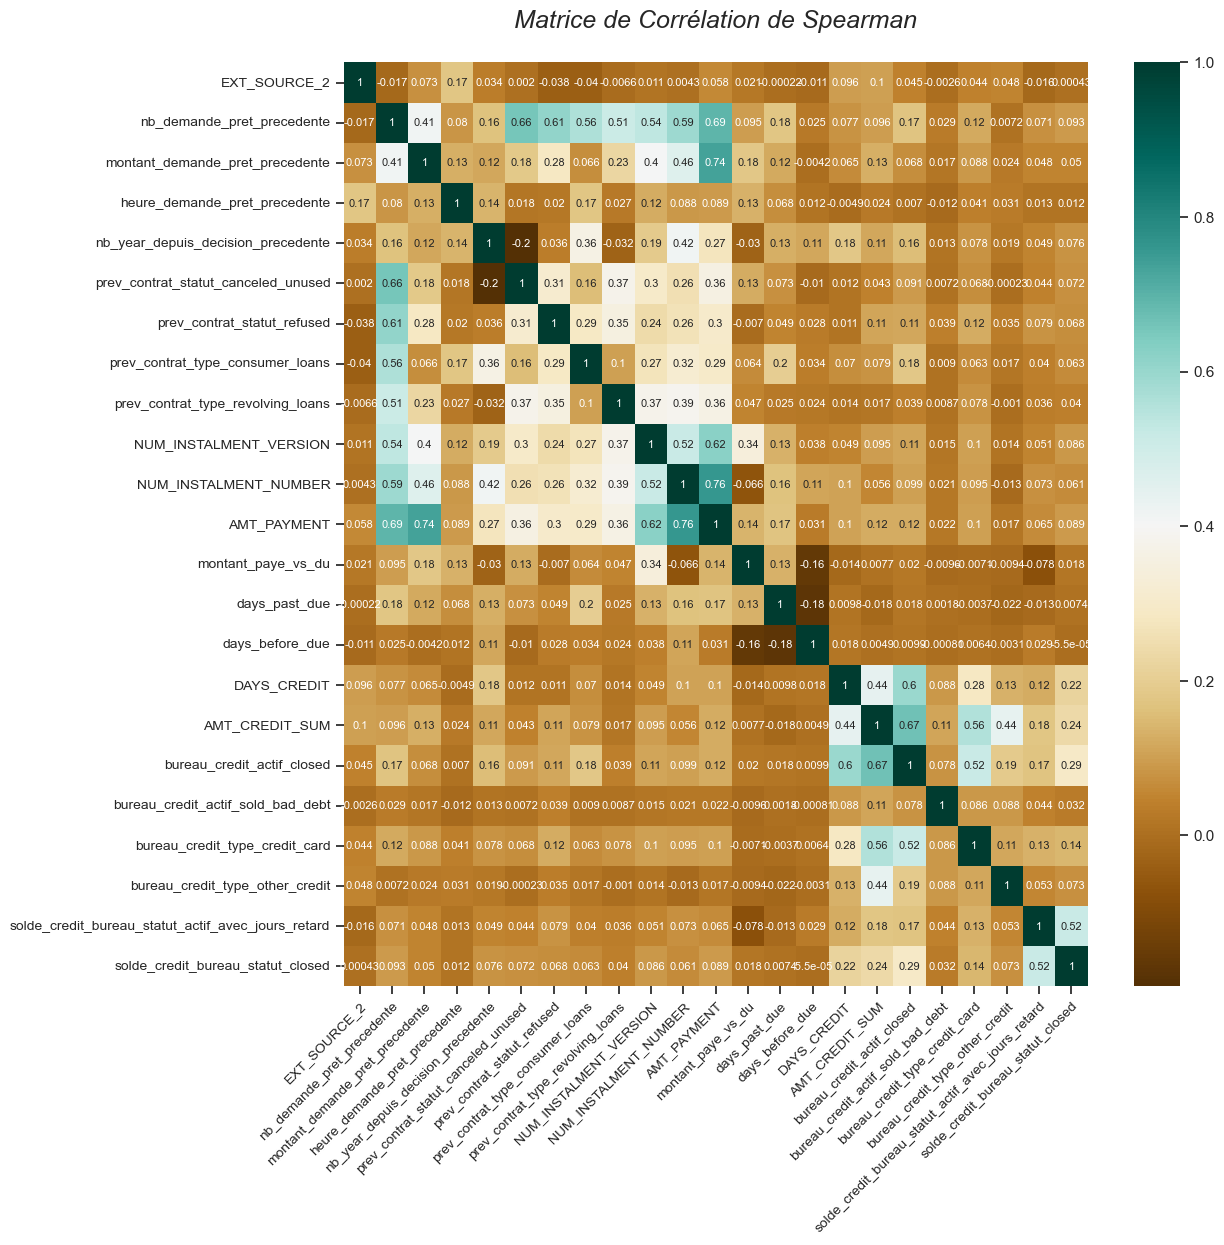

In [379]:
sns.set(style="ticks", rc={'figure.figsize': (12, 12)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = clean_X_train_join4.drop(labels=['SK_ID_CURR', 'TARGET'], axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

In [380]:
# Quelles sont les variables dont le coef de corrélation > 0.7
def high_correlation(mat_corr, corr_value = 0.7):
    for i in mat_corr.columns:
        cr = mat_corr.loc[i].loc[(mat_corr.loc[i] >= corr_value) | (mat_corr.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")
            
high_correlation(corr_df, corr_value = 0.7)

montant_demande_pret_precedente
-------------------------------
AMT_PAYMENT   0.74
Name: montant_demande_pret_precedente, dtype: float64


NUM_INSTALMENT_NUMBER
-------------------------------
AMT_PAYMENT   0.76
Name: NUM_INSTALMENT_NUMBER, dtype: float64


AMT_PAYMENT
-------------------------------
NUM_INSTALMENT_NUMBER             0.76
montant_demande_pret_precedente   0.74
Name: AMT_PAYMENT, dtype: float64




In [381]:
# Suppression des variables très liées entre elles

vars_to_drop2 = ['AMT_PAYMENT']

clean_X_train_join4.drop(labels=vars_to_drop2, axis=1, inplace=True)

clean_X_train_join4.shape

(44063, 62)

In [382]:
#Fusion avec clean_X_test_join3

clean_X_test_join4 = clean_X_test_join3.merge(client_bureau, how='left', on='SK_ID_CURR')
clean_X_test_join4.shape

(36374, 62)

In [383]:
clean_X_test_join4.isna().mean()*100

SK_ID_CURR                                            0.00
NAME_CONTRACT_TYPE                                    0.00
CODE_GENDER                                           0.00
FLAG_OWN_CAR                                          0.00
FLAG_OWN_REALTY                                       0.00
NAME_TYPE_SUITE                                       0.00
NAME_INCOME_TYPE                                      0.00
NAME_EDUCATION_TYPE                                   0.00
NAME_FAMILY_STATUS                                    0.00
NAME_HOUSING_TYPE                                     0.00
FLAG_EMP_PHONE                                        0.00
FLAG_WORK_PHONE                                       0.00
FLAG_PHONE                                            0.00
FLAG_EMAIL                                            0.00
REGION_RATING_CLIENT                                  0.00
REGION_RATING_CLIENT_W_CITY                           0.00
WEEKDAY_APPR_PROCESS_START                            0.

In [384]:
for var in liste_var3:
    clean_X_test_join4[var].fillna(0, inplace=True)

In [385]:
# Suppression des variables très liées entre elles

vars_to_drop2 = ['AMT_PAYMENT']

clean_X_test_join4.drop(labels=vars_to_drop2, axis=1, inplace=True)

clean_X_test_join4.shape

(36374, 61)

In [386]:
clean_X_train_join4.shape, clean_X_test_join4.shape

((44063, 62), (36374, 61))

# POS CASH Balance

Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec Home Credit. Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon * nombre de crédits précédents relatifs * nombre de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

In [387]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [388]:
pos_cash.isna().mean()*100

SK_ID_PREV              0.00
SK_ID_CURR              0.00
MONTHS_BALANCE          0.00
CNT_INSTALMENT          0.26
CNT_INSTALMENT_FUTURE   0.26
NAME_CONTRACT_STATUS    0.00
SK_DPD                  0.00
SK_DPD_DEF              0.00
dtype: float64

In [389]:
# Categorical Variables
def cat_analyzer(dataframe, variable):
    print(variable)
    print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe) *100}), end="\n\n\n")
    
cat_analyzer(pos_cash, 'NAME_CONTRACT_STATUS')

NAME_CONTRACT_STATUS
                         COUNT  RATIO
NAME_CONTRACT_STATUS                 
Active                 9151119  91.50
Completed               744883   7.45
Signed                   87260   0.87
Demand                    7065   0.07
Returned to the store     5461   0.05
Approved                  4917   0.05
Amortized debt             636   0.01
Canceled                    15   0.00
XNA                          2   0.00




91,5% des contrats précédents sont actifs, cette variable n'est donc pas discriminante, nous la supprimons.

In [390]:
pos_cash.drop(labels='NAME_CONTRACT_STATUS', axis=1, inplace=True)

In [391]:
pos_cash.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99])

MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE        SK_DPD  \
count   10,001,358.00    9,975,287.00           9,975,271.00 10,001,358.00   
mean           -35.01           17.09                  10.48         11.61   
std             26.07           12.00                  11.11        132.71   
min            -96.00            1.00                   0.00          0.00   
1%             -94.00            4.00                   0.00          0.00   
10%            -77.00            6.00                   0.00          0.00   
25%            -54.00           10.00                   3.00          0.00   
50%            -28.00           12.00                   7.00          0.00   
75%            -13.00           24.00                  14.00          0.00   
80%            -11.00           24.00                  17.00          0.00   
90%             -6.00           36.00                  24.00          0.00   
95%             -4.00           45.00                  35.00          0.00   
99%             -2.00           60.00                  53.00        235.00   
max             -1.00           92.00                  85.00      4,231.00   

         SK_DPD_DEF  
count 10,001,358.00  
mean           0.65  
std           32.76  
min            0.00  
1%             0.00  
10%            0.00  
25%            0.00  
50%            0.00  
75%            0.00  
80%            0.00  
90%            0.00  
95%            0.00  
99%            1.00  
max        3,595.00

`CNT_INSTALMENT` : Durée du crédit précédent<br>
`CNT_INSTALMENT_FUTURE` : Acomptes restant à payer sur le crédit précédent
`SK_DPD` : DPD (jours de retard) au cours du mois du crédit précédent
`SK_DPD_DEF` : DPD au cours du mois avec tolérance (les dettes à faible montant d'emprunt sont ignorées) du crédit précédent

`SK_DPD` et `SK_DPD_DEF` sont à supprimer compte tenu de leur distribution.

In [392]:
pos_cash.drop(labels=['SK_DPD', 'SK_DPD_DEF'], axis=1, inplace=True)

In [393]:
client_pos_cash = pos_cash.groupby(['SK_ID_CURR'], as_index=False).agg({'SK_ID_PREV': 'count',
                                                                        'MONTHS_BALANCE': 'mean',
                                                                        'CNT_INSTALMENT': 'mean',
                                                                        'CNT_INSTALMENT_FUTURE': 'mean'})

client_pos_cash.drop(labels='SK_ID_CURR', axis=1).describe()

SK_ID_PREV  MONTHS_BALANCE  CNT_INSTALMENT  CNT_INSTALMENT_FUTURE
count  337,252.00      337,252.00      337,224.00             337,224.00
mean        29.66          -31.87           14.65                   9.18
std         24.53           20.08            7.97                   6.50
min          1.00          -96.00            1.00                   0.00
25%         12.00          -43.99            9.62                   5.00
50%         22.00          -28.57           12.00                   6.99
75%         39.00          -15.50           18.60                  11.67
max        295.00           -1.00           72.00                  60.00

In [394]:
#Fusion avec clean_X_train_join4

clean_X_train_join5 = clean_X_train_join4.merge(client_pos_cash, how='left', on='SK_ID_CURR')
clean_X_train_join5.shape

(44063, 66)

In [395]:
clean_X_train_join5.isna().mean()*100

SK_ID_CURR                                           0.00
NAME_CONTRACT_TYPE                                   0.00
CODE_GENDER                                          0.00
FLAG_OWN_CAR                                         0.00
FLAG_OWN_REALTY                                      0.00
NAME_TYPE_SUITE                                      0.00
NAME_INCOME_TYPE                                     0.00
NAME_EDUCATION_TYPE                                  0.00
NAME_FAMILY_STATUS                                   0.00
NAME_HOUSING_TYPE                                    0.00
FLAG_EMP_PHONE                                       0.00
FLAG_WORK_PHONE                                      0.00
FLAG_PHONE                                           0.00
FLAG_EMAIL                                           0.00
REGION_RATING_CLIENT                                 0.00
REGION_RATING_CLIENT_W_CITY                          0.00
WEEKDAY_APPR_PROCESS_START                           0.00
REG_REGION_NOT

In [396]:
liste_var4 = ['SK_ID_PREV', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']

for var in liste_var4:
    clean_X_train_join5[var].fillna(0, inplace=True)

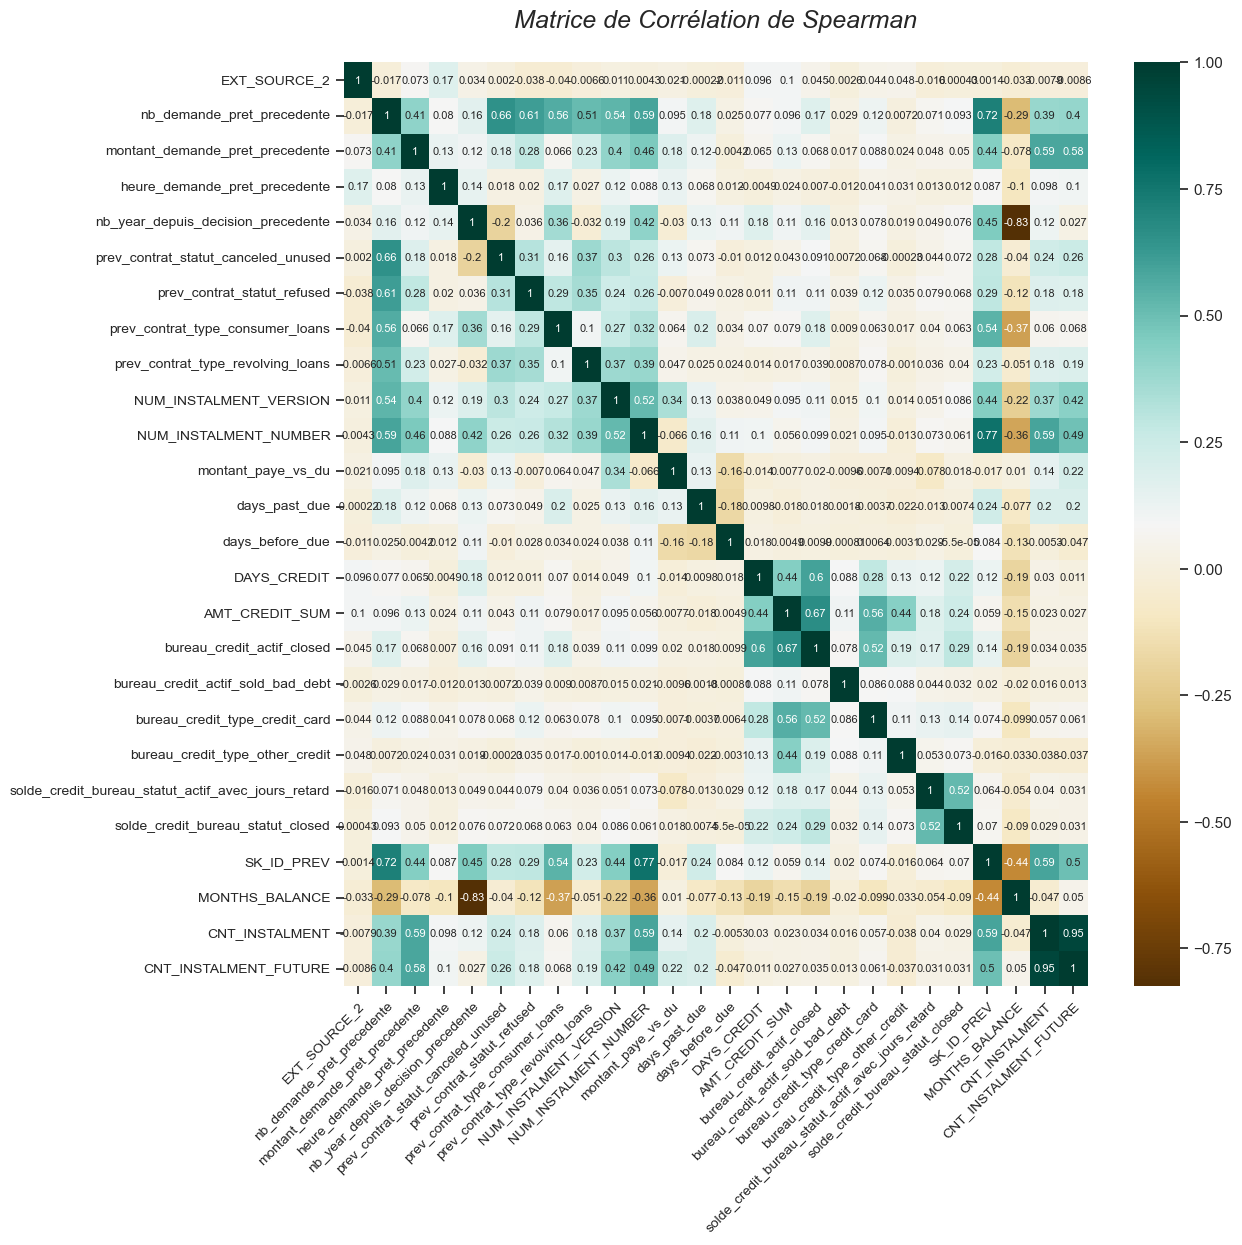

In [397]:
sns.set(style="ticks", rc={'figure.figsize': (12, 12)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = clean_X_train_join5.drop(labels=['SK_ID_CURR', 'TARGET'], axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

In [398]:
# Quelles sont les variables dont le coef de corrélation > 0.7
def high_correlation(mat_corr, corr_value = 0.7):
    for i in mat_corr.columns:
        cr = mat_corr.loc[i].loc[(mat_corr.loc[i] >= corr_value) | (mat_corr.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")
            
high_correlation(corr_df, corr_value = 0.7)

nb_demande_pret_precedente
-------------------------------
SK_ID_PREV   0.72
Name: nb_demande_pret_precedente, dtype: float64


nb_year_depuis_decision_precedente
-------------------------------
MONTHS_BALANCE   -0.83
Name: nb_year_depuis_decision_precedente, dtype: float64


NUM_INSTALMENT_NUMBER
-------------------------------
SK_ID_PREV   0.77
Name: NUM_INSTALMENT_NUMBER, dtype: float64


SK_ID_PREV
-------------------------------
NUM_INSTALMENT_NUMBER        0.77
nb_demande_pret_precedente   0.72
Name: SK_ID_PREV, dtype: float64


MONTHS_BALANCE
-------------------------------
nb_year_depuis_decision_precedente   -0.83
Name: MONTHS_BALANCE, dtype: float64


CNT_INSTALMENT
-------------------------------
CNT_INSTALMENT_FUTURE   0.95
Name: CNT_INSTALMENT, dtype: float64


CNT_INSTALMENT_FUTURE
-------------------------------
CNT_INSTALMENT   0.95
Name: CNT_INSTALMENT_FUTURE, dtype: float64




In [399]:
# Suppression des variables très liées entre elles

vars_to_drop3 = ['CNT_INSTALMENT_FUTURE', 'MONTHS_BALANCE', 'SK_ID_PREV']

clean_X_train_join5.drop(labels=vars_to_drop3, axis=1, inplace=True)

clean_X_train_join5.shape

(44063, 63)

In [400]:
#Fusion avec clean_X_test_join4

clean_X_test_join5 = clean_X_test_join4.merge(client_pos_cash, how='left', on='SK_ID_CURR')
clean_X_test_join5.shape

(36374, 65)

In [401]:
liste_var4 = ['SK_ID_PREV', 'MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']

for var in liste_var4:
    clean_X_test_join5[var].fillna(0, inplace=True)

In [402]:
# Suppression des variables très liées entre elles

vars_to_drop3 = ['CNT_INSTALMENT_FUTURE', 'MONTHS_BALANCE', 'SK_ID_PREV']

clean_X_test_join5.drop(labels=vars_to_drop3, axis=1, inplace=True)

clean_X_test_join5.shape

(36374, 62)

In [403]:
clean_X_train_join5.shape, clean_X_test_join5.shape

((44063, 63), (36374, 62))

# Credit Card

Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit. Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (nombre de prêts dans l'échantillon nombre de cartes de crédit précédentes relatives nombre de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

In [404]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [405]:
credit_card.isna().mean()*100

SK_ID_PREV                    0.00
SK_ID_CURR                    0.00
MONTHS_BALANCE                0.00
AMT_BALANCE                   0.00
AMT_CREDIT_LIMIT_ACTUAL       0.00
AMT_DRAWINGS_ATM_CURRENT     19.52
AMT_DRAWINGS_CURRENT          0.00
AMT_DRAWINGS_OTHER_CURRENT   19.52
AMT_DRAWINGS_POS_CURRENT     19.52
AMT_INST_MIN_REGULARITY       7.95
AMT_PAYMENT_CURRENT          20.00
AMT_PAYMENT_TOTAL_CURRENT     0.00
AMT_RECEIVABLE_PRINCIPAL      0.00
AMT_RECIVABLE                 0.00
AMT_TOTAL_RECEIVABLE          0.00
CNT_DRAWINGS_ATM_CURRENT     19.52
CNT_DRAWINGS_CURRENT          0.00
CNT_DRAWINGS_OTHER_CURRENT   19.52
CNT_DRAWINGS_POS_CURRENT     19.52
CNT_INSTALMENT_MATURE_CUM     7.95
NAME_CONTRACT_STATUS          0.00
SK_DPD                        0.00
SK_DPD_DEF                    0.00
dtype: float64

In [406]:
credit_card.dropna(axis=1, inplace=True)

In [407]:
credit_card.isna().mean()*100

SK_ID_PREV                  0.00
SK_ID_CURR                  0.00
MONTHS_BALANCE              0.00
AMT_BALANCE                 0.00
AMT_CREDIT_LIMIT_ACTUAL     0.00
AMT_DRAWINGS_CURRENT        0.00
AMT_PAYMENT_TOTAL_CURRENT   0.00
AMT_RECEIVABLE_PRINCIPAL    0.00
AMT_RECIVABLE               0.00
AMT_TOTAL_RECEIVABLE        0.00
CNT_DRAWINGS_CURRENT        0.00
NAME_CONTRACT_STATUS        0.00
SK_DPD                      0.00
SK_DPD_DEF                  0.00
dtype: float64

In [408]:
# Categorical Variables
def cat_analyzer(dataframe, variable):
    print(variable)
    print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe) *100}), end="\n\n\n")
    
cat_analyzer(credit_card, 'NAME_CONTRACT_STATUS')

NAME_CONTRACT_STATUS
                        COUNT  RATIO
NAME_CONTRACT_STATUS                
Active                3698436  96.31
Completed              128918   3.36
Signed                  11058   0.29
Demand                   1365   0.04
Sent proposal             513   0.01
Refused                    17   0.00
Approved                    5   0.00




In [409]:
credit_card.drop(labels='NAME_CONTRACT_STATUS', axis=1, inplace=True)

In [410]:
credit_card.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).describe([.01, .1, .25, .5, .75, .8, .9, .95, .99]).T

count       mean        std         min  \
MONTHS_BALANCE            3,840,312.00     -34.52      26.67      -96.00   
AMT_BALANCE               3,840,312.00  58,300.16 106,307.03 -420,250.18   
AMT_CREDIT_LIMIT_ACTUAL   3,840,312.00 153,807.96 165,145.70        0.00   
AMT_DRAWINGS_CURRENT      3,840,312.00   7,433.39  33,846.08   -6,211.62   
AMT_PAYMENT_TOTAL_CURRENT 3,840,312.00   7,588.86  32,005.99        0.00   
AMT_RECEIVABLE_PRINCIPAL  3,840,312.00  55,965.88 102,533.62 -423,305.82   
AMT_RECIVABLE             3,840,312.00  58,088.81 105,965.37 -420,250.18   
AMT_TOTAL_RECEIVABLE      3,840,312.00  58,098.29 105,971.80 -420,250.18   
CNT_DRAWINGS_CURRENT      3,840,312.00       0.70       3.19        0.00   
SK_DPD                    3,840,312.00       9.28      97.52        0.00   
SK_DPD_DEF                3,840,312.00       0.33      21.48        0.00   

                               1%    10%       25%        50%        75%  \
MONTHS_BALANCE             -93.00 -76.00    -55.00     -28.00     -11.00   
AMT_BALANCE                  0.00   0.00      0.00       0.00  89,046.69   
AMT_CREDIT_LIMIT_ACTUAL      0.00   0.00 45,000.00 112,500.00 180,000.00   
AMT_DRAWINGS_CURRENT         0.00   0.00      0.00       0.00       0.00   
AMT_PAYMENT_TOTAL_CURRENT    0.00   0.00      0.00       0.00   6,750.00   
AMT_RECEIVABLE_PRINCIPAL     0.00   0.00      0.00       0.00  85,359.24   
AMT_RECIVABLE             -487.26   0.00      0.00       0.00  88,899.49   
AMT_TOTAL_RECEIVABLE      -486.63   0.00      0.00       0.00  88,914.51   
CNT_DRAWINGS_CURRENT         0.00   0.00      0.00       0.00       0.00   
SK_DPD                       0.00   0.00      0.00       0.00       0.00   
SK_DPD_DEF                   0.00   0.00      0.00       0.00       0.00   

                                 80%        90%        95%        99%  \
MONTHS_BALANCE                 -9.00      -5.00      -3.00      -1.00   
AMT_BALANCE               116,880.71 180,016.20 257,181.38 466,295.12   
AMT_CREDIT_LIMIT_ACTUAL   225,000.00 427,500.00 450,000.00 765,000.00   
AMT_DRAWINGS_CURRENT            0.00  11,250.00  45,000.00 157,500.00   
AMT_PAYMENT_TOTAL_CURRENT   9,000.00  13,500.00  23,400.00 128,614.93   
AMT_RECEIVABLE_PRINCIPAL  111,982.27 173,228.93 247,803.41 448,121.83   
AMT_RECIVABLE             116,663.39 179,815.77 256,445.41 464,023.86   
AMT_TOTAL_RECEIVABLE      116,690.04 179,830.17 256,468.50 464,025.51   
CNT_DRAWINGS_CURRENT            0.00       1.00       4.00      14.00   
SK_DPD                          0.00       0.00       0.00     274.00   
SK_DPD_DEF                      0.00       0.00       0.00       1.00   

                                   max  
MONTHS_BALANCE                   -1.00  
AMT_BALANCE               1,505,902.19  
AMT_CREDIT_LIMIT_ACTUAL   1,350,000.00  
AMT_DRAWINGS_CURRENT      2,287,098.31  
AMT_PAYMENT_TOTAL_CURRENT 4,278,315.69  
AMT_RECEIVABLE_PRINCIPAL  1,472,316.79  
AMT_RECIVABLE             1,493,338.19  
AMT_TOTAL_RECEIVABLE      1,493,338.19  
CNT_DRAWINGS_CURRENT            165.00  
SK_DPD                        3,260.00  
SK_DPD_DEF                    3,260.00

`MONTHS_BALANCE` : Mois du solde par rapport à la date d'application (-1 signifie la date de solde la plus récente)<br>
`AMT_BALANCE` : Solde au cours du mois du crédit précédent<br>
`AMT_CREDIT_LIMIT_ACTUAL` : Limite de carte de crédit au cours du mois du crédit précédent<br>
`AMT_DRAWINGS_CURRENT` : Montant tiré au cours du mois du crédit précédent<br>
`AMT_PAYMENT_TOTAL_CURRENT` : Combien le client a-t-il payé au cours du mois au total sur le crédit précédent<br>
`AMT_RECEIVABLE_PRINCIPAL` : Montant à recevoir en principal sur le crédit précédent<br>
`AMT_RECIVABLE` : Montant à recevoir sur le crédit précédent<br>
`AMT_TOTAL_RECEIVABLE` : Montant total à recevoir sur le crédit précédent<br>
`CNT_DRAWINGS_CURRENT` : Nombre de tirages durant ce mois sur le crédit précédent<br>
`SK_DPD` : DPD (Jours de retard) au cours du mois sur le crédit précédent<br>
`SK_DPD_DEF` : DPD (Jours de retard) au cours du mois avec tolérance (les créances à faible montant d'emprunt sont ignorées) du crédit précédent

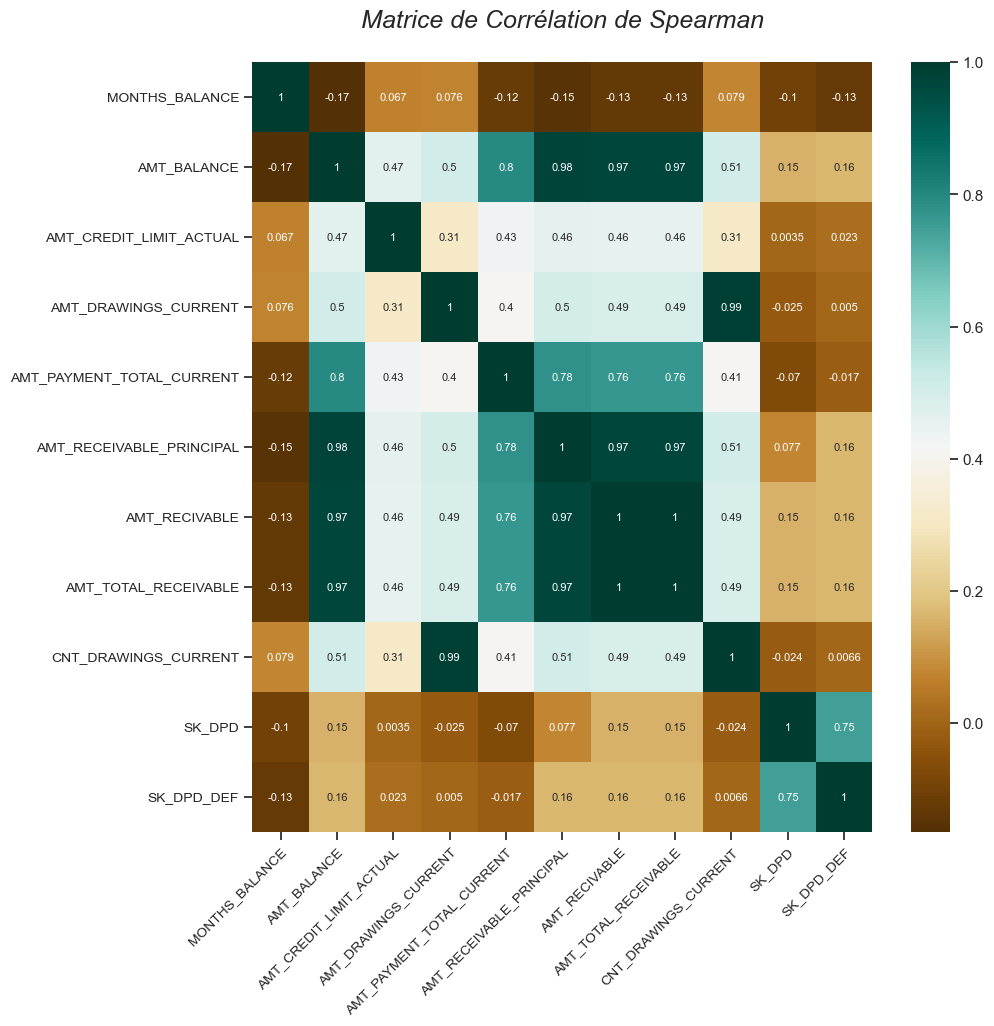

In [411]:
sns.set(style="ticks", rc={'figure.figsize': (10, 10)})
#cmap = sns.diverging_palette(145, 280, s=99, l=30, n=24)

df_analyse_num = credit_card.drop(labels=['SK_ID_CURR', 'SK_ID_PREV'], axis=1).select_dtypes(include=[np.number])

# On centre et on réduit les colonnes
df_analyse_norm = (df_analyse_num-df_analyse_num.mean(axis=0)
                   )/df_analyse_num.std(axis=0)

# On crée la matrice de corrélation
corr_df = df_analyse_norm.corr(method='spearman')

# Heatmap de la matrice de corrélation
ax = sns.heatmap(corr_df, cmap="BrBG", annot=True, annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10,
                   rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10, 
                   horizontalalignment='right')
plt.title("Matrice de Corrélation de Spearman\n",
          loc="center", fontsize=18, fontstyle='italic')
plt.show()

In [412]:
# Quelles sont les variables dont le coef de corrélation > 0.7
def high_correlation(mat_corr, corr_value = 0.7):
    for i in mat_corr.columns:
        cr = mat_corr.loc[i].loc[(mat_corr.loc[i] >= corr_value) | (mat_corr.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")
            
high_correlation(corr_df, corr_value = 0.7)

AMT_BALANCE
-------------------------------
AMT_RECEIVABLE_PRINCIPAL    0.98
AMT_TOTAL_RECEIVABLE        0.97
AMT_RECIVABLE               0.97
AMT_PAYMENT_TOTAL_CURRENT   0.80
Name: AMT_BALANCE, dtype: float64


AMT_DRAWINGS_CURRENT
-------------------------------
CNT_DRAWINGS_CURRENT   0.99
Name: AMT_DRAWINGS_CURRENT, dtype: float64


AMT_PAYMENT_TOTAL_CURRENT
-------------------------------
AMT_BALANCE                0.80
AMT_RECEIVABLE_PRINCIPAL   0.78
AMT_TOTAL_RECEIVABLE       0.76
AMT_RECIVABLE              0.76
Name: AMT_PAYMENT_TOTAL_CURRENT, dtype: float64


AMT_RECEIVABLE_PRINCIPAL
-------------------------------
AMT_BALANCE                 0.98
AMT_RECIVABLE               0.97
AMT_TOTAL_RECEIVABLE        0.97
AMT_PAYMENT_TOTAL_CURRENT   0.78
Name: AMT_RECEIVABLE_PRINCIPAL, dtype: float64


AMT_RECIVABLE
-------------------------------
AMT_TOTAL_RECEIVABLE        1.00
AMT_BALANCE                 0.97
AMT_RECEIVABLE_PRINCIPAL    0.97
AMT_PAYMENT_TOTAL_CURRENT   0.76
Name: AMT_

In [413]:
# Suppression des variables très liées entre elles

vars_to_drop4 = ['AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 
                 'AMT_PAYMENT_TOTAL_CURRENT', 'CNT_DRAWINGS_CURRENT', 'SK_DPD', 'SK_DPD_DEF']

credit_card.drop(labels=vars_to_drop4, axis=1, inplace=True)

credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 6 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   SK_ID_PREV               int64  
 1   SK_ID_CURR               int64  
 2   MONTHS_BALANCE           int64  
 3   AMT_BALANCE              float64
 4   AMT_CREDIT_LIMIT_ACTUAL  int64  
 5   AMT_DRAWINGS_CURRENT     float64
dtypes: float64(2), int64(4)
memory usage: 175.8 MB


In [414]:
client_credit_card = credit_card.groupby(['SK_ID_CURR'], as_index=False).agg({'SK_ID_PREV': 'count',
                                                                              'MONTHS_BALANCE': 'mean',
                                                                              'AMT_BALANCE': 'sum',
                                                                              'AMT_CREDIT_LIMIT_ACTUAL': 'sum',
                                                                              'AMT_DRAWINGS_CURRENT': 'sum' })

In [415]:
#Fusion avec clean_X_train_join5

clean_X_train_join6 = clean_X_train_join5.merge(client_credit_card, how='left', on='SK_ID_CURR')
clean_X_train_join6.shape

(44063, 68)

In [416]:
clean_X_train_join6.isna().mean()*100

SK_ID_CURR                                            0.00
NAME_CONTRACT_TYPE                                    0.00
CODE_GENDER                                           0.00
FLAG_OWN_CAR                                          0.00
FLAG_OWN_REALTY                                       0.00
NAME_TYPE_SUITE                                       0.00
NAME_INCOME_TYPE                                      0.00
NAME_EDUCATION_TYPE                                   0.00
NAME_FAMILY_STATUS                                    0.00
NAME_HOUSING_TYPE                                     0.00
FLAG_EMP_PHONE                                        0.00
FLAG_WORK_PHONE                                       0.00
FLAG_PHONE                                            0.00
FLAG_EMAIL                                            0.00
REGION_RATING_CLIENT                                  0.00
REGION_RATING_CLIENT_W_CITY                           0.00
WEEKDAY_APPR_PROCESS_START                            0.

In [417]:
#Fusion avec clean_X_test_join5

clean_X_test_join6 = clean_X_test_join5.merge(client_credit_card, how='left', on='SK_ID_CURR')
clean_X_test_join6.shape

(36374, 67)

In [418]:
clean_X_test_join6.isna().mean()*100

SK_ID_CURR                                            0.00
NAME_CONTRACT_TYPE                                    0.00
CODE_GENDER                                           0.00
FLAG_OWN_CAR                                          0.00
FLAG_OWN_REALTY                                       0.00
NAME_TYPE_SUITE                                       0.00
NAME_INCOME_TYPE                                      0.00
NAME_EDUCATION_TYPE                                   0.00
NAME_FAMILY_STATUS                                    0.00
NAME_HOUSING_TYPE                                     0.00
FLAG_EMP_PHONE                                        0.00
FLAG_WORK_PHONE                                       0.00
FLAG_PHONE                                            0.00
FLAG_EMAIL                                            0.00
REGION_RATING_CLIENT                                  0.00
REGION_RATING_CLIENT_W_CITY                           0.00
WEEKDAY_APPR_PROCESS_START                            0.

Compte tenu du nombre de valeurs manquantes, c'est-à-dire du nombre de clients de l'ensemble d'entraînement qui n'ont pas de cartes de crédits avec Home Credit, près de 72%, nous n'utiliserons pas ces informations pour construire notre modèle de prédiction.

# Sauvegarde des fichiers d'entraînement et de test

In [419]:
clean_X_train_join5.to_csv('./Data/X_train.csv', encoding='utf-8', index=None)

In [420]:
clean_X_test_join5.to_csv('./Data/X_test.csv', encoding='utf-8', index=None)